In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cpdetect import cpDetector
try:
    import cPickle as pickle
except:
    import pickle

In [2]:
transition_matrix = np.array([[0.9971, 0.0005933, 0.00000908, 0.001998, 0.0001998, 0.00009982], 
                             [0.001500, 0.9943, 0.0015, 0.00021419, 0.0015388, 0.0009470109], 
                             [0.0003, 0.0001, 0.9969, 0.0009, 0.0009, 0.00090],
                             [0.001, 0.002, 0.003, 0.991, 0.002, 0.001],
                             [0.0009, 0.0001, 0.0003, 0.00008, 0.98992, 0.0087],
                             [0.00040, 0.0003, 0.00006, 0.00025, 0.00009, 0.9989]])

In [3]:
means = np.random.uniform(low=7.0, high=9.0, size=20)
variances = np.random.uniform(low=0.2, high=0.3, size=6)
means.sort()
mean_2 = means[0::3]
means_2 = np.delete(mean_2, [1])

transition_matrix = np.array([[0.9971, 0.0005933, 0.00000908, 0.001998, 0.0001998, 0.00009982], 
                             [0.001500, 0.9943, 0.0015, 0.00021419, 0.0015388, 0.0009470109], 
                             [0.0003, 0.0001, 0.9969, 0.0009, 0.0009, 0.00090],
                             [0.001, 0.002, 0.003, 0.991, 0.002, 0.001],
                             [0.0009, 0.0001, 0.0003, 0.00008, 0.98992, 0.0087],
                             [0.00040, 0.0003, 0.00006, 0.00025, 0.00009, 0.9989]])

In [4]:
print(means_2)
print(variances)

[ 7.10353876  7.62000329  7.97523214  8.1037751   8.50811475  8.62210224]
[ 0.20211947  0.20985324  0.26727114  0.20377163  0.27954563  0.27087918]


In [5]:
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of 
            state in the Markov Chain.
 
        states: 1-D array 
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = transition_matrix
        self.states = states
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
         self.states, 
         p=self.transition_matrix[self.index_dict[current_state], :]
        )
 
    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states

In [6]:
markov_chain = MarkovChain(transition_matrix, states=[0,1,2,3,4,5])

In [7]:
synthetic_trajectories = np.zeros((100, 10000))
true_ts = {}
for i in range(100):
    chain = markov_chain.generate_states(current_state=1, no=10000)
    true_ts['traj_{}'.format(str(i))] = []
    for m, n in enumerate(chain):
        if m == len(chain)-1:
            break
        if n != chain[m+1]:
            true_ts['traj_{}'.format(i)].append(m+1)
    synthetic_data = np.zeros(len(chain))
    for j, k in enumerate(chain):
        synthetic_trajectories[i][j] = np.random.lognormal(means_2[k], variances[k])

In [8]:
n = 100*10000
print(n)
P = 0
for t in true_ts:
    P+=len(true_ts[t])
print(P)
N = n-P
print(N)

1000000
2924
997076


In [9]:
np.save('synthetic_trajectories_markov_process', synthetic_trajectories)
pickle.dump(true_ts, open('true_ts_markov_process.pickle', 'wb'))

In [10]:
synthetic_trajs = list(synthetic_trajectories)

In [11]:
# ROC curve
TPRS = []
FPRS = []
TPRS_refinement = []
FPRS_refinement = []
for thresh in range(-10, 15): 
    print(thresh)
    TP = 0
    FP = 0
    TP_refinement = 0
    FP_refinement = 0
    detector = cpDetector(synthetic_trajs, distribution='log_normal', log_odds_threshold=thresh)
    detector.detect_cp()
    for t in range(len(synthetic_trajs)):
        predicted_ts = detector.change_points['traj_{}'.format(t)]['ts'].values
        predicted_ts.sort()
    #false_positive = np.asarray(detector.change_points['traj_0']['ts'])
    
        for j in true_ts['traj_{}'.format(t)]:
            for i, p_ts in enumerate(predicted_ts):
                if p_ts-50 <= j <= p_ts+50:
                    TP +=1
                    predicted_ts = np.delete(predicted_ts, i)
                    break
        FP += len(predicted_ts)
    TPR = TP/P
    FPR = FP/N
    TPRS.append(TPR)
    FPRS.append(FPR)
    print(TPR, FPR)
    
    # refinement
    detector.refinement(threshold=-5, reject_window=20)
    detector.regenerate_step_function()
    for t in range(len(synthetic_trajs)):
        predicted_ts = np.asarray(detector.change_points['traj_{}'.format(t)]['ts'].append(
            detector.refined_change_points['traj_{}'.format(t)]['ts']))
        predicted_ts.sort()
        for j in true_ts['traj_{}'.format(t)]:
            for i, p_ts in enumerate(predicted_ts):
                if p_ts-50 <= j <= p_ts+50:
                    TP_refinement +=1
                    predicted_ts = np.delete(predicted_ts, i)
                    break
        FP_refinement += len(predicted_ts)
    TPR_refinement = TP_refinement/P
    FPR_refinement = FP_refinement/N
    TPRS_refinement.append(TPR_refinement)
    FPRS_refinement.append(FPR_refinement)
    print(TPR_refinement, FPR_refinement)
    

-10
20:16:46 INFO cpDetector: =======================================
20:16:46 INFO cpDetector: Running change point detector
20:16:46 INFO cpDetector: =======================================
20:16:46 INFO cpDetector:    input observations: 100 of length [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
20:16:46 INFO cpDetector: Running cp detecto

20:16:50 INFO cpDetector:     Found a new change point at: 797!!
20:16:50 INFO cpDetector:     Found a new change point at: 814!!
20:16:50 INFO cpDetector:     Found a new change point at: 817!!
20:16:50 INFO cpDetector:     Found a new change point at: 860!!
20:16:51 INFO cpDetector:     Found a new change point at: 2028!!
20:16:51 INFO cpDetector:     Found a new change point at: 1477!!
20:16:51 INFO cpDetector:     Found a new change point at: 1430!!
20:16:51 INFO cpDetector:     Found a new change point at: 1433!!
20:16:51 INFO cpDetector:     Found a new change point at: 1457!!
20:16:51 INFO cpDetector:     Found a new change point at: 1437!!
20:16:51 INFO cpDetector:     Found a new change point at: 1452!!
20:16:51 INFO cpDetector:     Found a new change point at: 1440!!
20:16:51 INFO cpDetector:     Found a new change point at: 1449!!
20:16:51 INFO cpDetector:     Found a new change point at: 1446!!
20:16:51 INFO cpDetector:     Found a new change point at: 1443!!
20:16:51 INFO 

20:17:04 INFO cpDetector:     Found a new change point at: 6159!!
20:17:04 INFO cpDetector:     Found a new change point at: 6156!!
20:17:04 INFO cpDetector:     Found a new change point at: 6153!!
20:17:04 INFO cpDetector:     Found a new change point at: 6150!!
20:17:04 INFO cpDetector:     Found a new change point at: 6147!!
20:17:04 INFO cpDetector:     Found a new change point at: 6100!!
20:17:04 INFO cpDetector:     Found a new change point at: 6103!!
20:17:04 INFO cpDetector:     Found a new change point at: 6106!!
20:17:04 INFO cpDetector:     Found a new change point at: 6109!!
20:17:04 INFO cpDetector:     Found a new change point at: 6115!!
20:17:04 INFO cpDetector:     Found a new change point at: 6112!!
20:17:04 INFO cpDetector:     Found a new change point at: 6119!!
20:17:04 INFO cpDetector:     Found a new change point at: 6126!!
20:17:04 INFO cpDetector:     Found a new change point at: 6123!!
20:17:04 INFO cpDetector:     Found a new change point at: 6136!!
20:17:04 I

20:17:12 INFO cpDetector:     Found a new change point at: 4500!!
20:17:12 INFO cpDetector:     Found a new change point at: 4503!!
20:17:12 INFO cpDetector:     Found a new change point at: 4506!!
20:17:12 INFO cpDetector:     Found a new change point at: 4509!!
20:17:12 INFO cpDetector:     Found a new change point at: 4512!!
20:17:12 INFO cpDetector:     Found a new change point at: 4536!!
20:17:12 INFO cpDetector:     Found a new change point at: 4533!!
20:17:12 INFO cpDetector:     Found a new change point at: 4517!!
20:17:12 INFO cpDetector:     Found a new change point at: 4520!!
20:17:12 INFO cpDetector:     Found a new change point at: 4523!!
20:17:12 INFO cpDetector:     Found a new change point at: 4526!!
20:17:12 INFO cpDetector:     Found a new change point at: 4529!!
20:17:12 INFO cpDetector:     Found a new change point at: 8343!!
20:17:12 INFO cpDetector:     Found a new change point at: 6177!!
20:17:12 INFO cpDetector:     Found a new change point at: 7608!!
20:17:12 I

20:17:21 INFO cpDetector:     Found a new change point at: 3686!!
20:17:21 INFO cpDetector:     Found a new change point at: 3692!!
20:17:21 INFO cpDetector:     Found a new change point at: 3695!!
20:17:21 INFO cpDetector:     Found a new change point at: 3698!!
20:17:21 INFO cpDetector:     Found a new change point at: 3703!!
20:17:21 INFO cpDetector:     Found a new change point at: 3706!!
20:17:21 INFO cpDetector:     Found a new change point at: 3711!!
20:17:21 INFO cpDetector:     Found a new change point at: 3738!!
20:17:21 INFO cpDetector:     Found a new change point at: 3735!!
20:17:21 INFO cpDetector:     Found a new change point at: 3732!!
20:17:21 INFO cpDetector:     Found a new change point at: 3729!!
20:17:21 INFO cpDetector:     Found a new change point at: 3724!!
20:17:21 INFO cpDetector:     Found a new change point at: 3721!!
20:17:21 INFO cpDetector:     Found a new change point at: 3718!!
20:17:21 INFO cpDetector:     Found a new change point at: 3715!!
20:17:22 I

20:17:29 INFO cpDetector:     Found a new change point at: 2078!!
20:17:29 INFO cpDetector:     Found a new change point at: 2081!!
20:17:29 INFO cpDetector:     Found a new change point at: 2086!!
20:17:29 INFO cpDetector:     Found a new change point at: 2097!!
20:17:29 INFO cpDetector:     Found a new change point at: 2116!!
20:17:29 INFO cpDetector:     Found a new change point at: 2100!!
20:17:29 INFO cpDetector:     Found a new change point at: 2103!!
20:17:29 INFO cpDetector:     Found a new change point at: 2111!!
20:17:29 INFO cpDetector:     Found a new change point at: 2108!!
20:17:29 INFO cpDetector:     Found a new change point at: 2122!!
20:17:29 INFO cpDetector:     Found a new change point at: 2119!!
20:17:29 INFO cpDetector:     Found a new change point at: 2141!!
20:17:29 INFO cpDetector:     Found a new change point at: 2128!!
20:17:29 INFO cpDetector:     Found a new change point at: 2125!!
20:17:29 INFO cpDetector:     Found a new change point at: 2131!!
20:17:29 I

20:17:40 INFO cpDetector:     Found a new change point at: 8787!!
20:17:40 INFO cpDetector:     Found a new change point at: 9361!!
20:17:40 INFO cpDetector:     Found a new change point at: 9153!!
20:17:40 INFO cpDetector:     Found a new change point at: 8973!!
20:17:40 INFO cpDetector:     Found a new change point at: 8879!!
20:17:40 INFO cpDetector:     Found a new change point at: 8969!!
20:17:40 INFO cpDetector: Generating step fucntion
20:17:40 INFO cpDetector: ---------------------------------
20:17:40 INFO cpDetector: Running cp detector on traj 10
20:17:40 INFO cpDetector: ---------------------------------
20:17:42 INFO cpDetector:     Found a new change point at: 5836!!
20:17:43 INFO cpDetector:     Found a new change point at: 5261!!
20:17:43 INFO cpDetector:     Found a new change point at: 4443!!
20:17:43 INFO cpDetector:     Found a new change point at: 2318!!
20:17:44 INFO cpDetector:     Found a new change point at: 1611!!
20:17:44 INFO cpDetector:     Found a new chan

20:17:48 INFO cpDetector:     Found a new change point at: 8646!!
20:17:49 INFO cpDetector:     Found a new change point at: 6943!!
20:17:50 INFO cpDetector:     Found a new change point at: 5171!!
20:17:51 INFO cpDetector:     Found a new change point at: 3966!!
20:17:51 INFO cpDetector:     Found a new change point at: 1069!!
20:17:51 INFO cpDetector:     Found a new change point at: 223!!
20:17:51 INFO cpDetector:     Found a new change point at: 129!!
20:17:51 INFO cpDetector:     Found a new change point at: 2761!!
20:17:51 INFO cpDetector:     Found a new change point at: 1586!!
20:17:51 INFO cpDetector:     Found a new change point at: 1452!!
20:17:51 INFO cpDetector:     Found a new change point at: 1483!!
20:17:51 INFO cpDetector:     Found a new change point at: 1475!!
20:17:51 INFO cpDetector:     Found a new change point at: 1455!!
20:17:51 INFO cpDetector:     Found a new change point at: 1459!!
20:17:51 INFO cpDetector:     Found a new change point at: 1462!!
20:17:51 INF

20:17:58 INFO cpDetector:     Found a new change point at: 4912!!
20:17:58 INFO cpDetector:     Found a new change point at: 4842!!
20:17:58 INFO cpDetector:     Found a new change point at: 4852!!
20:17:58 INFO cpDetector:     Found a new change point at: 4849!!
20:17:58 INFO cpDetector:     Found a new change point at: 4846!!
20:17:58 INFO cpDetector:     Found a new change point at: 4895!!
20:17:58 INFO cpDetector:     Found a new change point at: 4855!!
20:17:58 INFO cpDetector:     Found a new change point at: 4870!!
20:17:58 INFO cpDetector:     Found a new change point at: 4867!!
20:17:58 INFO cpDetector:     Found a new change point at: 4858!!
20:17:58 INFO cpDetector:     Found a new change point at: 4861!!
20:17:58 INFO cpDetector:     Found a new change point at: 4864!!
20:17:58 INFO cpDetector:     Found a new change point at: 4891!!
20:17:58 INFO cpDetector:     Found a new change point at: 4888!!
20:17:58 INFO cpDetector:     Found a new change point at: 4885!!
20:17:58 I

20:18:07 INFO cpDetector:     Found a new change point at: 2604!!
20:18:07 INFO cpDetector:     Found a new change point at: 2532!!
20:18:07 INFO cpDetector:     Found a new change point at: 3883!!
20:18:08 INFO cpDetector:     Found a new change point at: 3944!!
20:18:08 INFO cpDetector:     Found a new change point at: 4374!!
20:18:08 INFO cpDetector:     Found a new change point at: 6978!!
20:18:08 INFO cpDetector:     Found a new change point at: 4387!!
20:18:08 INFO cpDetector:     Found a new change point at: 4381!!
20:18:08 INFO cpDetector:     Found a new change point at: 4384!!
20:18:09 INFO cpDetector:     Found a new change point at: 8718!!
20:18:09 INFO cpDetector:     Found a new change point at: 7101!!
20:18:09 INFO cpDetector:     Found a new change point at: 8084!!
20:18:09 INFO cpDetector:     Found a new change point at: 7655!!
20:18:09 INFO cpDetector:     Found a new change point at: 8450!!
20:18:09 INFO cpDetector:     Found a new change point at: 8336!!
20:18:09 I

20:18:18 INFO cpDetector:     Found a new change point at: 9735!!
20:18:18 INFO cpDetector:     Found a new change point at: 9744!!
20:18:18 INFO cpDetector:     Found a new change point at: 9747!!
20:18:18 INFO cpDetector:     Found a new change point at: 9752!!
20:18:18 INFO cpDetector:     Found a new change point at: 9755!!
20:18:18 INFO cpDetector:     Found a new change point at: 9758!!
20:18:18 INFO cpDetector:     Found a new change point at: 9761!!
20:18:18 INFO cpDetector:     Found a new change point at: 9764!!
20:18:18 INFO cpDetector:     Found a new change point at: 9778!!
20:18:18 INFO cpDetector:     Found a new change point at: 9775!!
20:18:18 INFO cpDetector:     Found a new change point at: 9772!!
20:18:18 INFO cpDetector:     Found a new change point at: 9769!!
20:18:18 INFO cpDetector: Generating step fucntion
20:18:18 INFO cpDetector: ---------------------------------
20:18:18 INFO cpDetector: Running cp detector on traj 17
20:18:18 INFO cpDetector: --------------

20:18:28 INFO cpDetector:     Found a new change point at: 8842!!
20:18:28 INFO cpDetector: Generating step fucntion
20:18:28 INFO cpDetector: ---------------------------------
20:18:28 INFO cpDetector: Running cp detector on traj 19
20:18:28 INFO cpDetector: ---------------------------------
20:18:29 INFO cpDetector:     Found a new change point at: 8970!!
20:18:30 INFO cpDetector:     Found a new change point at: 7601!!
20:18:31 INFO cpDetector:     Found a new change point at: 5409!!
20:18:32 INFO cpDetector:     Found a new change point at: 3717!!
20:18:32 INFO cpDetector:     Found a new change point at: 2046!!
20:18:32 INFO cpDetector:     Found a new change point at: 1431!!
20:18:32 INFO cpDetector:     Found a new change point at: 103!!
20:18:32 INFO cpDetector:     Found a new change point at: 956!!
20:18:32 INFO cpDetector:     Found a new change point at: 859!!
20:18:32 INFO cpDetector:     Found a new change point at: 950!!
20:18:32 INFO cpDetector:     Found a new change p

20:18:45 INFO cpDetector:     Found a new change point at: 2518!!
20:18:45 INFO cpDetector:     Found a new change point at: 1491!!
20:18:45 INFO cpDetector:     Found a new change point at: 3347!!
20:18:45 INFO cpDetector:     Found a new change point at: 3025!!
20:18:45 INFO cpDetector:     Found a new change point at: 2714!!
20:18:45 INFO cpDetector:     Found a new change point at: 2676!!
20:18:45 INFO cpDetector:     Found a new change point at: 2602!!
20:18:45 INFO cpDetector:     Found a new change point at: 2521!!
20:18:45 INFO cpDetector:     Found a new change point at: 2619!!
20:18:45 INFO cpDetector:     Found a new change point at: 2616!!
20:18:45 INFO cpDetector:     Found a new change point at: 2611!!
20:18:45 INFO cpDetector:     Found a new change point at: 2605!!
20:18:45 INFO cpDetector:     Found a new change point at: 2608!!
20:18:45 INFO cpDetector:     Found a new change point at: 2709!!
20:18:45 INFO cpDetector:     Found a new change point at: 2688!!
20:18:45 I

20:18:46 INFO cpDetector:     Found a new change point at: 6666!!
20:18:46 INFO cpDetector:     Found a new change point at: 6669!!
20:18:46 INFO cpDetector:     Found a new change point at: 6685!!
20:18:46 INFO cpDetector:     Found a new change point at: 6672!!
20:18:46 INFO cpDetector:     Found a new change point at: 6680!!
20:18:46 INFO cpDetector:     Found a new change point at: 6677!!
20:18:46 INFO cpDetector:     Found a new change point at: 6699!!
20:18:46 INFO cpDetector:     Found a new change point at: 6703!!
20:18:46 INFO cpDetector:     Found a new change point at: 6706!!
20:18:46 INFO cpDetector:     Found a new change point at: 6709!!
20:18:46 INFO cpDetector:     Found a new change point at: 6712!!
20:18:46 INFO cpDetector:     Found a new change point at: 6842!!
20:18:46 INFO cpDetector:     Found a new change point at: 9097!!
20:18:46 INFO cpDetector:     Found a new change point at: 9612!!
20:18:46 INFO cpDetector:     Found a new change point at: 9328!!
20:18:46 I

20:18:52 INFO cpDetector:     Found a new change point at: 7961!!
20:18:52 INFO cpDetector:     Found a new change point at: 7488!!
20:18:52 INFO cpDetector:     Found a new change point at: 7268!!
20:18:52 INFO cpDetector:     Found a new change point at: 7182!!
20:18:52 INFO cpDetector:     Found a new change point at: 7175!!
20:18:52 INFO cpDetector:     Found a new change point at: 7170!!
20:18:52 INFO cpDetector:     Found a new change point at: 7179!!
20:18:52 INFO cpDetector:     Found a new change point at: 7195!!
20:18:52 INFO cpDetector:     Found a new change point at: 7189!!
20:18:52 INFO cpDetector:     Found a new change point at: 7186!!
20:18:52 INFO cpDetector:     Found a new change point at: 7192!!
20:18:52 INFO cpDetector:     Found a new change point at: 7206!!
20:18:52 INFO cpDetector:     Found a new change point at: 7198!!
20:18:52 INFO cpDetector:     Found a new change point at: 7202!!
20:18:52 INFO cpDetector:     Found a new change point at: 7256!!
20:18:52 I

20:18:59 INFO cpDetector:     Found a new change point at: 5415!!
20:18:59 INFO cpDetector:     Found a new change point at: 5484!!
20:18:59 INFO cpDetector:     Found a new change point at: 5507!!
20:18:59 INFO cpDetector:     Found a new change point at: 5487!!
20:18:59 INFO cpDetector:     Found a new change point at: 5490!!
20:18:59 INFO cpDetector:     Found a new change point at: 5493!!
20:18:59 INFO cpDetector:     Found a new change point at: 5499!!
20:18:59 INFO cpDetector:     Found a new change point at: 5496!!
20:18:59 INFO cpDetector:     Found a new change point at: 5502!!
20:18:59 INFO cpDetector:     Found a new change point at: 5510!!
20:18:59 INFO cpDetector:     Found a new change point at: 8880!!
20:18:59 INFO cpDetector:     Found a new change point at: 7273!!
20:19:00 INFO cpDetector:     Found a new change point at: 7034!!
20:19:00 INFO cpDetector:     Found a new change point at: 9588!!
20:19:00 INFO cpDetector:     Found a new change point at: 8988!!
20:19:00 I

20:19:12 INFO cpDetector:     Found a new change point at: 4535!!
20:19:12 INFO cpDetector:     Found a new change point at: 4532!!
20:19:12 INFO cpDetector:     Found a new change point at: 4524!!
20:19:12 INFO cpDetector:     Found a new change point at: 4527!!
20:19:12 INFO cpDetector:     Found a new change point at: 4538!!
20:19:12 INFO cpDetector:     Found a new change point at: 4541!!
20:19:12 INFO cpDetector:     Found a new change point at: 4547!!
20:19:12 INFO cpDetector:     Found a new change point at: 4552!!
20:19:12 INFO cpDetector:     Found a new change point at: 4555!!
20:19:12 INFO cpDetector:     Found a new change point at: 4558!!
20:19:12 INFO cpDetector:     Found a new change point at: 4561!!
20:19:12 INFO cpDetector:     Found a new change point at: 4564!!
20:19:12 INFO cpDetector:     Found a new change point at: 4567!!
20:19:12 INFO cpDetector:     Found a new change point at: 4570!!
20:19:12 INFO cpDetector:     Found a new change point at: 4573!!
20:19:12 I

20:19:17 INFO cpDetector:     Found a new change point at: 1295!!
20:19:17 INFO cpDetector:     Found a new change point at: 1292!!
20:19:17 INFO cpDetector:     Found a new change point at: 1289!!
20:19:17 INFO cpDetector:     Found a new change point at: 1286!!
20:19:17 INFO cpDetector:     Found a new change point at: 1283!!
20:19:17 INFO cpDetector:     Found a new change point at: 1277!!
20:19:17 INFO cpDetector:     Found a new change point at: 1280!!
20:19:17 INFO cpDetector:     Found a new change point at: 1477!!
20:19:17 INFO cpDetector:     Found a new change point at: 4625!!
20:19:17 INFO cpDetector:     Found a new change point at: 4131!!
20:19:17 INFO cpDetector:     Found a new change point at: 4074!!
20:19:17 INFO cpDetector:     Found a new change point at: 4126!!
20:19:17 INFO cpDetector:     Found a new change point at: 4078!!
20:19:17 INFO cpDetector:     Found a new change point at: 4081!!
20:19:17 INFO cpDetector:     Found a new change point at: 4123!!
20:19:17 I

20:19:28 INFO cpDetector:     Found a new change point at: 1063!!
20:19:28 INFO cpDetector:     Found a new change point at: 153!!
20:19:28 INFO cpDetector:     Found a new change point at: 550!!
20:19:28 INFO cpDetector:     Found a new change point at: 478!!
20:19:28 INFO cpDetector:     Found a new change point at: 481!!
20:19:28 INFO cpDetector:     Found a new change point at: 547!!
20:19:28 INFO cpDetector:     Found a new change point at: 544!!
20:19:28 INFO cpDetector:     Found a new change point at: 541!!
20:19:28 INFO cpDetector:     Found a new change point at: 538!!
20:19:28 INFO cpDetector:     Found a new change point at: 535!!
20:19:28 INFO cpDetector:     Found a new change point at: 532!!
20:19:28 INFO cpDetector:     Found a new change point at: 529!!
20:19:28 INFO cpDetector:     Found a new change point at: 526!!
20:19:28 INFO cpDetector:     Found a new change point at: 523!!
20:19:28 INFO cpDetector:     Found a new change point at: 520!!
20:19:28 INFO cpDetector

20:19:32 INFO cpDetector:     Found a new change point at: 6644!!
20:19:32 INFO cpDetector:     Found a new change point at: 6650!!
20:19:32 INFO cpDetector:     Found a new change point at: 6647!!
20:19:32 INFO cpDetector:     Found a new change point at: 6653!!
20:19:32 INFO cpDetector:     Found a new change point at: 6657!!
20:19:32 INFO cpDetector:     Found a new change point at: 6667!!
20:19:32 INFO cpDetector:     Found a new change point at: 6663!!
20:19:32 INFO cpDetector:     Found a new change point at: 6660!!
20:19:32 INFO cpDetector:     Found a new change point at: 6675!!
20:19:32 INFO cpDetector:     Found a new change point at: 6738!!
20:19:32 INFO cpDetector:     Found a new change point at: 6695!!
20:19:32 INFO cpDetector:     Found a new change point at: 6684!!
20:19:32 INFO cpDetector:     Found a new change point at: 6678!!
20:19:32 INFO cpDetector:     Found a new change point at: 6681!!
20:19:32 INFO cpDetector:     Found a new change point at: 6692!!
20:19:32 I

20:19:38 INFO cpDetector:     Found a new change point at: 4535!!
20:19:38 INFO cpDetector:     Found a new change point at: 4547!!
20:19:38 INFO cpDetector:     Found a new change point at: 4538!!
20:19:38 INFO cpDetector:     Found a new change point at: 5122!!
20:19:38 INFO cpDetector:     Found a new change point at: 5119!!
20:19:38 INFO cpDetector:     Found a new change point at: 5428!!
20:19:38 INFO cpDetector:     Found a new change point at: 5463!!
20:19:38 INFO cpDetector:     Found a new change point at: 5431!!
20:19:38 INFO cpDetector:     Found a new change point at: 5468!!
20:19:39 INFO cpDetector:     Found a new change point at: 6836!!
20:19:39 INFO cpDetector:     Found a new change point at: 8762!!
20:19:39 INFO cpDetector:     Found a new change point at: 9049!!
20:19:39 INFO cpDetector:     Found a new change point at: 8940!!
20:19:39 INFO cpDetector:     Found a new change point at: 9789!!
20:19:39 INFO cpDetector:     Found a new change point at: 9850!!
20:19:39 I

20:19:47 INFO cpDetector:     Found a new change point at: 7666!!
20:19:47 INFO cpDetector:     Found a new change point at: 7803!!
20:19:47 INFO cpDetector:     Found a new change point at: 9655!!
20:19:47 INFO cpDetector:     Found a new change point at: 9307!!
20:19:47 INFO cpDetector:     Found a new change point at: 9312!!
20:19:47 INFO cpDetector:     Found a new change point at: 9405!!
20:19:47 INFO cpDetector:     Found a new change point at: 9402!!
20:19:47 INFO cpDetector:     Found a new change point at: 9315!!
20:19:47 INFO cpDetector:     Found a new change point at: 9318!!
20:19:48 INFO cpDetector:     Found a new change point at: 9321!!
20:19:48 INFO cpDetector:     Found a new change point at: 9324!!
20:19:48 INFO cpDetector:     Found a new change point at: 9327!!
20:19:48 INFO cpDetector:     Found a new change point at: 9399!!
20:19:48 INFO cpDetector:     Found a new change point at: 9330!!
20:19:48 INFO cpDetector:     Found a new change point at: 9334!!
20:19:48 I

20:19:54 INFO cpDetector:     Found a new change point at: 5428!!
20:19:54 INFO cpDetector:     Found a new change point at: 5431!!
20:19:54 INFO cpDetector:     Found a new change point at: 5434!!
20:19:54 INFO cpDetector:     Found a new change point at: 5448!!
20:19:54 INFO cpDetector:     Found a new change point at: 5443!!
20:19:54 INFO cpDetector:     Found a new change point at: 5440!!
20:19:54 INFO cpDetector:     Found a new change point at: 5437!!
20:19:54 INFO cpDetector:     Found a new change point at: 7567!!
20:19:54 INFO cpDetector:     Found a new change point at: 7241!!
20:19:54 INFO cpDetector:     Found a new change point at: 7342!!
20:19:54 INFO cpDetector:     Found a new change point at: 8290!!
20:19:55 INFO cpDetector:     Found a new change point at: 8406!!
20:19:55 INFO cpDetector:     Found a new change point at: 8795!!
20:19:55 INFO cpDetector: Generating step fucntion
20:19:55 INFO cpDetector: ---------------------------------
20:19:55 INFO cpDetector: Runni

20:20:00 INFO cpDetector:     Found a new change point at: 9378!!
20:20:00 INFO cpDetector:     Found a new change point at: 9319!!
20:20:00 INFO cpDetector:     Found a new change point at: 9302!!
20:20:00 INFO cpDetector:     Found a new change point at: 9299!!
20:20:00 INFO cpDetector:     Found a new change point at: 9292!!
20:20:00 INFO cpDetector:     Found a new change point at: 9295!!
20:20:00 INFO cpDetector:     Found a new change point at: 9309!!
20:20:00 INFO cpDetector:     Found a new change point at: 9305!!
20:20:00 INFO cpDetector:     Found a new change point at: 9312!!
20:20:00 INFO cpDetector:     Found a new change point at: 9315!!
20:20:00 INFO cpDetector:     Found a new change point at: 9322!!
20:20:00 INFO cpDetector:     Found a new change point at: 9375!!
20:20:00 INFO cpDetector:     Found a new change point at: 9370!!
20:20:00 INFO cpDetector:     Found a new change point at: 9365!!
20:20:00 INFO cpDetector:     Found a new change point at: 9362!!
20:20:00 I

20:20:08 INFO cpDetector:     Found a new change point at: 2028!!
20:20:08 INFO cpDetector:     Found a new change point at: 2025!!
20:20:08 INFO cpDetector:     Found a new change point at: 2022!!
20:20:08 INFO cpDetector:     Found a new change point at: 2014!!
20:20:08 INFO cpDetector:     Found a new change point at: 2018!!
20:20:09 INFO cpDetector:     Found a new change point at: 8049!!
20:20:09 INFO cpDetector:     Found a new change point at: 6809!!
20:20:09 INFO cpDetector:     Found a new change point at: 5185!!
20:20:10 INFO cpDetector:     Found a new change point at: 3103!!
20:20:10 INFO cpDetector:     Found a new change point at: 2173!!
20:20:10 INFO cpDetector:     Found a new change point at: 2319!!
20:20:10 INFO cpDetector:     Found a new change point at: 4140!!
20:20:10 INFO cpDetector:     Found a new change point at: 4638!!
20:20:10 INFO cpDetector:     Found a new change point at: 6343!!
20:20:10 INFO cpDetector:     Found a new change point at: 5892!!
20:20:10 I

20:20:15 INFO cpDetector:     Found a new change point at: 9700!!
20:20:15 INFO cpDetector:     Found a new change point at: 9696!!
20:20:15 INFO cpDetector:     Found a new change point at: 9693!!
20:20:15 INFO cpDetector:     Found a new change point at: 9690!!
20:20:15 INFO cpDetector:     Found a new change point at: 9684!!
20:20:15 INFO cpDetector:     Found a new change point at: 9687!!
20:20:15 INFO cpDetector: Generating step fucntion
20:20:15 INFO cpDetector: ---------------------------------
20:20:15 INFO cpDetector: Running cp detector on traj 36
20:20:15 INFO cpDetector: ---------------------------------
20:20:16 INFO cpDetector:     Found a new change point at: 2193!!
20:20:16 INFO cpDetector:     Found a new change point at: 385!!
20:20:16 INFO cpDetector:     Found a new change point at: 217!!
20:20:16 INFO cpDetector:     Found a new change point at: 55!!
20:20:17 INFO cpDetector:     Found a new change point at: 227!!
20:20:17 INFO cpDetector:     Found a new change po

20:20:25 INFO cpDetector:     Found a new change point at: 7018!!
20:20:25 INFO cpDetector:     Found a new change point at: 7021!!
20:20:25 INFO cpDetector:     Found a new change point at: 9553!!
20:20:25 INFO cpDetector:     Found a new change point at: 8977!!
20:20:25 INFO cpDetector:     Found a new change point at: 8860!!
20:20:25 INFO cpDetector:     Found a new change point at: 8457!!
20:20:25 INFO cpDetector:     Found a new change point at: 8649!!
20:20:25 INFO cpDetector:     Found a new change point at: 8971!!
20:20:25 INFO cpDetector:     Found a new change point at: 8968!!
20:20:25 INFO cpDetector:     Found a new change point at: 8865!!
20:20:25 INFO cpDetector:     Found a new change point at: 8868!!
20:20:25 INFO cpDetector:     Found a new change point at: 8957!!
20:20:25 INFO cpDetector:     Found a new change point at: 8871!!
20:20:25 INFO cpDetector:     Found a new change point at: 8874!!
20:20:25 INFO cpDetector:     Found a new change point at: 8877!!
20:20:26 I

20:20:30 INFO cpDetector:     Found a new change point at: 2608!!
20:20:30 INFO cpDetector:     Found a new change point at: 2599!!
20:20:30 INFO cpDetector:     Found a new change point at: 2603!!
20:20:30 INFO cpDetector:     Found a new change point at: 2627!!
20:20:30 INFO cpDetector:     Found a new change point at: 4003!!
20:20:30 INFO cpDetector:     Found a new change point at: 5411!!
20:20:30 INFO cpDetector:     Found a new change point at: 4882!!
20:20:30 INFO cpDetector:     Found a new change point at: 4208!!
20:20:30 INFO cpDetector:     Found a new change point at: 4154!!
20:20:30 INFO cpDetector:     Found a new change point at: 4061!!
20:20:30 INFO cpDetector:     Found a new change point at: 4036!!
20:20:30 INFO cpDetector:     Found a new change point at: 4039!!
20:20:30 INFO cpDetector:     Found a new change point at: 4056!!
20:20:30 INFO cpDetector:     Found a new change point at: 4052!!
20:20:30 INFO cpDetector:     Found a new change point at: 4049!!
20:20:30 I

20:20:37 INFO cpDetector:     Found a new change point at: 2041!!
20:20:37 INFO cpDetector:     Found a new change point at: 2155!!
20:20:37 INFO cpDetector:     Found a new change point at: 2127!!
20:20:37 INFO cpDetector:     Found a new change point at: 2124!!
20:20:37 INFO cpDetector:     Found a new change point at: 2121!!
20:20:37 INFO cpDetector:     Found a new change point at: 2107!!
20:20:37 INFO cpDetector:     Found a new change point at: 2100!!
20:20:37 INFO cpDetector:     Found a new change point at: 2095!!
20:20:37 INFO cpDetector:     Found a new change point at: 2092!!
20:20:37 INFO cpDetector:     Found a new change point at: 2089!!
20:20:37 INFO cpDetector:     Found a new change point at: 2086!!
20:20:37 INFO cpDetector:     Found a new change point at: 2083!!
20:20:37 INFO cpDetector:     Found a new change point at: 2045!!
20:20:37 INFO cpDetector:     Found a new change point at: 2048!!
20:20:37 INFO cpDetector:     Found a new change point at: 2051!!
20:20:37 I

20:20:45 INFO cpDetector:     Found a new change point at: 4382!!
20:20:45 INFO cpDetector:     Found a new change point at: 1642!!
20:20:46 INFO cpDetector:     Found a new change point at: 1046!!
20:20:46 INFO cpDetector:     Found a new change point at: 510!!
20:20:46 INFO cpDetector:     Found a new change point at: 244!!
20:20:46 INFO cpDetector:     Found a new change point at: 2861!!
20:20:46 INFO cpDetector:     Found a new change point at: 1997!!
20:20:46 INFO cpDetector:     Found a new change point at: 1827!!
20:20:46 INFO cpDetector:     Found a new change point at: 2384!!
20:20:46 INFO cpDetector:     Found a new change point at: 3883!!
20:20:46 INFO cpDetector:     Found a new change point at: 3932!!
20:20:46 INFO cpDetector:     Found a new change point at: 3886!!
20:20:46 INFO cpDetector:     Found a new change point at: 3929!!
20:20:46 INFO cpDetector:     Found a new change point at: 3926!!
20:20:46 INFO cpDetector:     Found a new change point at: 3923!!
20:20:46 INF

20:20:50 INFO cpDetector:     Found a new change point at: 571!!
20:20:50 INFO cpDetector:     Found a new change point at: 564!!
20:20:50 INFO cpDetector:     Found a new change point at: 557!!
20:20:50 INFO cpDetector:     Found a new change point at: 550!!
20:20:50 INFO cpDetector:     Found a new change point at: 553!!
20:20:50 INFO cpDetector:     Found a new change point at: 561!!
20:20:50 INFO cpDetector:     Found a new change point at: 567!!
20:20:51 INFO cpDetector:     Found a new change point at: 2940!!
20:20:51 INFO cpDetector:     Found a new change point at: 3764!!
20:20:51 INFO cpDetector:     Found a new change point at: 3406!!
20:20:51 INFO cpDetector:     Found a new change point at: 3163!!
20:20:51 INFO cpDetector:     Found a new change point at: 2951!!
20:20:51 INFO cpDetector:     Found a new change point at: 2948!!
20:20:51 INFO cpDetector:     Found a new change point at: 2945!!
20:20:51 INFO cpDetector:     Found a new change point at: 3176!!
20:20:51 INFO cpD

20:20:57 INFO cpDetector:     Found a new change point at: 9761!!
20:20:57 INFO cpDetector:     Found a new change point at: 9764!!
20:20:57 INFO cpDetector:     Found a new change point at: 9767!!
20:20:57 INFO cpDetector:     Found a new change point at: 9770!!
20:20:57 INFO cpDetector:     Found a new change point at: 9774!!
20:20:57 INFO cpDetector:     Found a new change point at: 9777!!
20:20:57 INFO cpDetector:     Found a new change point at: 9780!!
20:20:57 INFO cpDetector:     Found a new change point at: 9783!!
20:20:57 INFO cpDetector:     Found a new change point at: 9786!!
20:20:57 INFO cpDetector:     Found a new change point at: 9789!!
20:20:57 INFO cpDetector:     Found a new change point at: 9792!!
20:20:57 INFO cpDetector:     Found a new change point at: 9799!!
20:20:57 INFO cpDetector:     Found a new change point at: 9795!!
20:20:57 INFO cpDetector:     Found a new change point at: 9802!!
20:20:57 INFO cpDetector:     Found a new change point at: 9805!!
20:20:57 I

20:21:03 INFO cpDetector:     Found a new change point at: 1788!!
20:21:03 INFO cpDetector:     Found a new change point at: 1791!!
20:21:03 INFO cpDetector:     Found a new change point at: 1794!!
20:21:03 INFO cpDetector:     Found a new change point at: 2258!!
20:21:03 INFO cpDetector:     Found a new change point at: 2255!!
20:21:03 INFO cpDetector:     Found a new change point at: 2249!!
20:21:03 INFO cpDetector:     Found a new change point at: 2252!!
20:21:03 INFO cpDetector:     Found a new change point at: 2725!!
20:21:03 INFO cpDetector:     Found a new change point at: 4719!!
20:21:03 INFO cpDetector:     Found a new change point at: 4172!!
20:21:03 INFO cpDetector:     Found a new change point at: 4162!!
20:21:03 INFO cpDetector:     Found a new change point at: 4153!!
20:21:03 INFO cpDetector:     Found a new change point at: 4157!!
20:21:03 INFO cpDetector:     Found a new change point at: 4165!!
20:21:03 INFO cpDetector:     Found a new change point at: 4169!!
20:21:03 I

20:21:06 INFO cpDetector:     Found a new change point at: 3072!!
20:21:06 INFO cpDetector:     Found a new change point at: 3105!!
20:21:06 INFO cpDetector:     Found a new change point at: 3075!!
20:21:06 INFO cpDetector:     Found a new change point at: 3078!!
20:21:06 INFO cpDetector:     Found a new change point at: 3083!!
20:21:06 INFO cpDetector:     Found a new change point at: 3087!!
20:21:06 INFO cpDetector:     Found a new change point at: 3102!!
20:21:06 INFO cpDetector:     Found a new change point at: 3090!!
20:21:06 INFO cpDetector:     Found a new change point at: 3095!!
20:21:06 INFO cpDetector:     Found a new change point at: 3098!!
20:21:06 INFO cpDetector:     Found a new change point at: 3137!!
20:21:06 INFO cpDetector:     Found a new change point at: 3134!!
20:21:06 INFO cpDetector:     Found a new change point at: 3130!!
20:21:07 INFO cpDetector:     Found a new change point at: 3127!!
20:21:07 INFO cpDetector:     Found a new change point at: 3123!!
20:21:07 I

20:21:15 INFO cpDetector:     Found a new change point at: 9975!!
20:21:15 INFO cpDetector:     Found a new change point at: 9929!!
20:21:16 INFO cpDetector:     Found a new change point at: 9926!!
20:21:16 INFO cpDetector:     Found a new change point at: 9923!!
20:21:16 INFO cpDetector:     Found a new change point at: 9920!!
20:21:16 INFO cpDetector:     Found a new change point at: 9907!!
20:21:16 INFO cpDetector:     Found a new change point at: 9904!!
20:21:16 INFO cpDetector:     Found a new change point at: 9917!!
20:21:16 INFO cpDetector:     Found a new change point at: 9913!!
20:21:16 INFO cpDetector:     Found a new change point at: 9910!!
20:21:16 INFO cpDetector:     Found a new change point at: 9932!!
20:21:16 INFO cpDetector:     Found a new change point at: 9935!!
20:21:16 INFO cpDetector:     Found a new change point at: 9938!!
20:21:16 INFO cpDetector:     Found a new change point at: 9941!!
20:21:16 INFO cpDetector:     Found a new change point at: 9948!!
20:21:16 I

20:21:20 INFO cpDetector:     Found a new change point at: 5656!!
20:21:20 INFO cpDetector:     Found a new change point at: 6606!!
20:21:20 INFO cpDetector:     Found a new change point at: 7392!!
20:21:20 INFO cpDetector:     Found a new change point at: 7536!!
20:21:20 INFO cpDetector:     Found a new change point at: 7679!!
20:21:20 INFO cpDetector: Generating step fucntion
20:21:20 INFO cpDetector: ---------------------------------
20:21:20 INFO cpDetector: Running cp detector on traj 49
20:21:20 INFO cpDetector: ---------------------------------
20:21:21 INFO cpDetector:     Found a new change point at: 9304!!
20:21:23 INFO cpDetector:     Found a new change point at: 2480!!
20:21:23 INFO cpDetector:     Found a new change point at: 2049!!
20:21:23 INFO cpDetector:     Found a new change point at: 1033!!
20:21:23 INFO cpDetector:     Found a new change point at: 451!!
20:21:23 INFO cpDetector:     Found a new change point at: 265!!
20:21:23 INFO cpDetector:     Found a new change

20:21:26 INFO cpDetector:     Found a new change point at: 7406!!
20:21:26 INFO cpDetector:     Found a new change point at: 7409!!
20:21:26 INFO cpDetector:     Found a new change point at: 7555!!
20:21:26 INFO cpDetector:     Found a new change point at: 7548!!
20:21:26 INFO cpDetector:     Found a new change point at: 7544!!
20:21:26 INFO cpDetector:     Found a new change point at: 7541!!
20:21:26 INFO cpDetector:     Found a new change point at: 7538!!
20:21:26 INFO cpDetector:     Found a new change point at: 7532!!
20:21:26 INFO cpDetector:     Found a new change point at: 7437!!
20:21:26 INFO cpDetector:     Found a new change point at: 7434!!
20:21:26 INFO cpDetector:     Found a new change point at: 7431!!
20:21:26 INFO cpDetector:     Found a new change point at: 7422!!
20:21:26 INFO cpDetector:     Found a new change point at: 7419!!
20:21:26 INFO cpDetector:     Found a new change point at: 7415!!
20:21:26 INFO cpDetector:     Found a new change point at: 7425!!
20:21:26 I

20:21:36 INFO cpDetector:     Found a new change point at: 5140!!
20:21:36 INFO cpDetector:     Found a new change point at: 4864!!
20:21:36 INFO cpDetector:     Found a new change point at: 5485!!
20:21:37 INFO cpDetector:     Found a new change point at: 9937!!
20:21:37 INFO cpDetector:     Found a new change point at: 7557!!
20:21:37 INFO cpDetector:     Found a new change point at: 7856!!
20:21:37 INFO cpDetector:     Found a new change point at: 7693!!
20:21:37 INFO cpDetector:     Found a new change point at: 7560!!
20:21:37 INFO cpDetector:     Found a new change point at: 8933!!
20:21:37 INFO cpDetector:     Found a new change point at: 8860!!
20:21:37 INFO cpDetector: Generating step fucntion
20:21:37 INFO cpDetector: ---------------------------------
20:21:37 INFO cpDetector: Running cp detector on traj 52
20:21:37 INFO cpDetector: ---------------------------------
20:21:39 INFO cpDetector:     Found a new change point at: 3704!!
20:21:39 INFO cpDetector:     Found a new chan

20:21:45 INFO cpDetector:     Found a new change point at: 2200!!
20:21:45 INFO cpDetector:     Found a new change point at: 2203!!
20:21:45 INFO cpDetector:     Found a new change point at: 2216!!
20:21:45 INFO cpDetector:     Found a new change point at: 2209!!
20:21:45 INFO cpDetector:     Found a new change point at: 2206!!
20:21:45 INFO cpDetector:     Found a new change point at: 2212!!
20:21:45 INFO cpDetector:     Found a new change point at: 2251!!
20:21:45 INFO cpDetector:     Found a new change point at: 2248!!
20:21:45 INFO cpDetector:     Found a new change point at: 2245!!
20:21:45 INFO cpDetector:     Found a new change point at: 2231!!
20:21:45 INFO cpDetector:     Found a new change point at: 2228!!
20:21:45 INFO cpDetector:     Found a new change point at: 2225!!
20:21:45 INFO cpDetector:     Found a new change point at: 2240!!
20:21:45 INFO cpDetector:     Found a new change point at: 2235!!
20:21:45 INFO cpDetector:     Found a new change point at: 2258!!
20:21:45 I

20:21:52 INFO cpDetector:     Found a new change point at: 9283!!
20:21:52 INFO cpDetector:     Found a new change point at: 9280!!
20:21:52 INFO cpDetector:     Found a new change point at: 9276!!
20:21:52 INFO cpDetector:     Found a new change point at: 9273!!
20:21:52 INFO cpDetector:     Found a new change point at: 9270!!
20:21:52 INFO cpDetector:     Found a new change point at: 9412!!
20:21:52 INFO cpDetector:     Found a new change point at: 9762!!
20:21:52 INFO cpDetector:     Found a new change point at: 9881!!
20:21:52 INFO cpDetector:     Found a new change point at: 9884!!
20:21:52 INFO cpDetector:     Found a new change point at: 9910!!
20:21:52 INFO cpDetector:     Found a new change point at: 9890!!
20:21:52 INFO cpDetector:     Found a new change point at: 9887!!
20:21:52 INFO cpDetector:     Found a new change point at: 9894!!
20:21:52 INFO cpDetector:     Found a new change point at: 9904!!
20:21:52 INFO cpDetector:     Found a new change point at: 9897!!
20:21:52 I

20:21:58 INFO cpDetector:     Found a new change point at: 2215!!
20:21:58 INFO cpDetector:     Found a new change point at: 1864!!
20:21:58 INFO cpDetector:     Found a new change point at: 1275!!
20:21:58 INFO cpDetector:     Found a new change point at: 288!!
20:21:58 INFO cpDetector:     Found a new change point at: 41!!
20:21:58 INFO cpDetector:     Found a new change point at: 3!!
20:21:58 INFO cpDetector:     Found a new change point at: 23!!
20:21:58 INFO cpDetector:     Found a new change point at: 20!!
20:21:58 INFO cpDetector:     Found a new change point at: 17!!
20:21:58 INFO cpDetector:     Found a new change point at: 14!!
20:21:58 INFO cpDetector:     Found a new change point at: 11!!
20:21:58 INFO cpDetector:     Found a new change point at: 8!!
20:21:58 INFO cpDetector:     Found a new change point at: 38!!
20:21:58 INFO cpDetector:     Found a new change point at: 35!!
20:21:58 INFO cpDetector:     Found a new change point at: 26!!
20:21:58 INFO cpDetector:     Found

20:22:02 INFO cpDetector:     Found a new change point at: 8821!!
20:22:02 INFO cpDetector:     Found a new change point at: 8802!!
20:22:02 INFO cpDetector:     Found a new change point at: 8805!!
20:22:02 INFO cpDetector:     Found a new change point at: 8808!!
20:22:02 INFO cpDetector:     Found a new change point at: 8818!!
20:22:02 INFO cpDetector:     Found a new change point at: 8815!!
20:22:02 INFO cpDetector:     Found a new change point at: 8812!!
20:22:02 INFO cpDetector:     Found a new change point at: 8834!!
20:22:02 INFO cpDetector:     Found a new change point at: 8848!!
20:22:02 INFO cpDetector:     Found a new change point at: 8910!!
20:22:02 INFO cpDetector:     Found a new change point at: 8906!!
20:22:02 INFO cpDetector:     Found a new change point at: 8856!!
20:22:02 INFO cpDetector:     Found a new change point at: 8860!!
20:22:02 INFO cpDetector:     Found a new change point at: 8863!!
20:22:02 INFO cpDetector:     Found a new change point at: 8903!!
20:22:02 I

20:22:16 INFO cpDetector:     Found a new change point at: 1191!!
20:22:16 INFO cpDetector:     Found a new change point at: 1188!!
20:22:16 INFO cpDetector:     Found a new change point at: 1077!!
20:22:16 INFO cpDetector:     Found a new change point at: 1080!!
20:22:16 INFO cpDetector:     Found a new change point at: 1083!!
20:22:16 INFO cpDetector:     Found a new change point at: 1086!!
20:22:16 INFO cpDetector:     Found a new change point at: 1095!!
20:22:16 INFO cpDetector:     Found a new change point at: 1091!!
20:22:16 INFO cpDetector:     Found a new change point at: 1098!!
20:22:16 INFO cpDetector:     Found a new change point at: 1102!!
20:22:16 INFO cpDetector:     Found a new change point at: 1105!!
20:22:16 INFO cpDetector:     Found a new change point at: 1108!!
20:22:16 INFO cpDetector:     Found a new change point at: 1185!!
20:22:16 INFO cpDetector:     Found a new change point at: 1182!!
20:22:16 INFO cpDetector:     Found a new change point at: 1179!!
20:22:16 I

20:22:19 INFO cpDetector:     Found a new change point at: 8327!!
20:22:19 INFO cpDetector:     Found a new change point at: 8631!!
20:22:19 INFO cpDetector:     Found a new change point at: 8749!!
20:22:19 INFO cpDetector:     Found a new change point at: 8663!!
20:22:19 INFO cpDetector:     Found a new change point at: 8638!!
20:22:19 INFO cpDetector:     Found a new change point at: 8634!!
20:22:19 INFO cpDetector:     Found a new change point at: 8660!!
20:22:19 INFO cpDetector:     Found a new change point at: 8648!!
20:22:19 INFO cpDetector:     Found a new change point at: 8641!!
20:22:19 INFO cpDetector:     Found a new change point at: 8645!!
20:22:19 INFO cpDetector:     Found a new change point at: 8657!!
20:22:19 INFO cpDetector:     Found a new change point at: 8651!!
20:22:19 INFO cpDetector:     Found a new change point at: 8654!!
20:22:19 INFO cpDetector: Generating step fucntion
20:22:19 INFO cpDetector: ---------------------------------
20:22:19 INFO cpDetector: Runni

20:22:24 INFO cpDetector:     Found a new change point at: 7314!!
20:22:24 INFO cpDetector:     Found a new change point at: 7443!!
20:22:24 INFO cpDetector:     Found a new change point at: 7319!!
20:22:24 INFO cpDetector:     Found a new change point at: 7322!!
20:22:24 INFO cpDetector:     Found a new change point at: 7438!!
20:22:24 INFO cpDetector:     Found a new change point at: 7435!!
20:22:24 INFO cpDetector:     Found a new change point at: 7432!!
20:22:24 INFO cpDetector:     Found a new change point at: 7421!!
20:22:24 INFO cpDetector:     Found a new change point at: 7410!!
20:22:24 INFO cpDetector:     Found a new change point at: 7407!!
20:22:24 INFO cpDetector:     Found a new change point at: 7360!!
20:22:24 INFO cpDetector:     Found a new change point at: 7357!!
20:22:24 INFO cpDetector:     Found a new change point at: 7354!!
20:22:24 INFO cpDetector:     Found a new change point at: 7349!!
20:22:24 INFO cpDetector:     Found a new change point at: 7346!!
20:22:24 I

20:22:30 INFO cpDetector:     Found a new change point at: 5824!!
20:22:30 INFO cpDetector:     Found a new change point at: 5741!!
20:22:30 INFO cpDetector:     Found a new change point at: 5733!!
20:22:30 INFO cpDetector:     Found a new change point at: 5736!!
20:22:30 INFO cpDetector:     Found a new change point at: 5754!!
20:22:30 INFO cpDetector:     Found a new change point at: 5744!!
20:22:30 INFO cpDetector:     Found a new change point at: 5749!!
20:22:30 INFO cpDetector:     Found a new change point at: 5771!!
20:22:30 INFO cpDetector:     Found a new change point at: 5758!!
20:22:30 INFO cpDetector:     Found a new change point at: 5761!!
20:22:30 INFO cpDetector:     Found a new change point at: 5765!!
20:22:30 INFO cpDetector:     Found a new change point at: 5768!!
20:22:30 INFO cpDetector:     Found a new change point at: 5821!!
20:22:30 INFO cpDetector:     Found a new change point at: 5774!!
20:22:30 INFO cpDetector:     Found a new change point at: 5777!!
20:22:30 I

20:22:36 INFO cpDetector: ---------------------------------
20:22:36 INFO cpDetector: Running cp detector on traj 63
20:22:36 INFO cpDetector: ---------------------------------
20:22:37 INFO cpDetector:     Found a new change point at: 6376!!
20:22:38 INFO cpDetector:     Found a new change point at: 1249!!
20:22:38 INFO cpDetector:     Found a new change point at: 55!!
20:22:38 INFO cpDetector:     Found a new change point at: 5370!!
20:22:39 INFO cpDetector:     Found a new change point at: 2462!!
20:22:39 INFO cpDetector:     Found a new change point at: 2294!!
20:22:39 INFO cpDetector:     Found a new change point at: 1994!!
20:22:39 INFO cpDetector:     Found a new change point at: 1346!!
20:22:39 INFO cpDetector:     Found a new change point at: 1252!!
20:22:39 INFO cpDetector:     Found a new change point at: 1343!!
20:22:39 INFO cpDetector:     Found a new change point at: 1340!!
20:22:39 INFO cpDetector:     Found a new change point at: 1337!!
20:22:39 INFO cpDetector:     Fou

20:22:40 INFO cpDetector:     Found a new change point at: 4279!!
20:22:40 INFO cpDetector:     Found a new change point at: 4282!!
20:22:40 INFO cpDetector:     Found a new change point at: 4285!!
20:22:40 INFO cpDetector:     Found a new change point at: 4290!!
20:22:40 INFO cpDetector:     Found a new change point at: 4318!!
20:22:40 INFO cpDetector:     Found a new change point at: 4321!!
20:22:40 INFO cpDetector:     Found a new change point at: 5132!!
20:22:40 INFO cpDetector:     Found a new change point at: 5311!!
20:22:40 INFO cpDetector:     Found a new change point at: 5314!!
20:22:40 INFO cpDetector:     Found a new change point at: 5360!!
20:22:40 INFO cpDetector:     Found a new change point at: 5354!!
20:22:40 INFO cpDetector:     Found a new change point at: 5346!!
20:22:40 INFO cpDetector:     Found a new change point at: 5343!!
20:22:40 INFO cpDetector:     Found a new change point at: 5340!!
20:22:40 INFO cpDetector:     Found a new change point at: 5333!!
20:22:40 I

20:22:45 INFO cpDetector:     Found a new change point at: 9623!!
20:22:45 INFO cpDetector:     Found a new change point at: 9799!!
20:22:46 INFO cpDetector: Generating step fucntion
20:22:46 INFO cpDetector: ---------------------------------
20:22:46 INFO cpDetector: Running cp detector on traj 65
20:22:46 INFO cpDetector: ---------------------------------
20:22:47 INFO cpDetector:     Found a new change point at: 7422!!
20:22:48 INFO cpDetector:     Found a new change point at: 913!!
20:22:48 INFO cpDetector:     Found a new change point at: 2517!!
20:22:48 INFO cpDetector:     Found a new change point at: 1726!!
20:22:48 INFO cpDetector:     Found a new change point at: 2127!!
20:22:48 INFO cpDetector:     Found a new change point at: 1930!!
20:22:49 INFO cpDetector:     Found a new change point at: 5366!!
20:22:49 INFO cpDetector:     Found a new change point at: 6519!!
20:22:49 INFO cpDetector:     Found a new change point at: 5519!!
20:22:49 INFO cpDetector:     Found a new chang

20:22:57 INFO cpDetector:     Found a new change point at: 155!!
20:22:57 INFO cpDetector:     Found a new change point at: 232!!
20:22:57 INFO cpDetector:     Found a new change point at: 229!!
20:22:57 INFO cpDetector:     Found a new change point at: 158!!
20:22:57 INFO cpDetector:     Found a new change point at: 161!!
20:22:57 INFO cpDetector:     Found a new change point at: 164!!
20:22:57 INFO cpDetector:     Found a new change point at: 178!!
20:22:57 INFO cpDetector:     Found a new change point at: 174!!
20:22:57 INFO cpDetector:     Found a new change point at: 170!!
20:22:57 INFO cpDetector:     Found a new change point at: 167!!
20:22:57 INFO cpDetector:     Found a new change point at: 181!!
20:22:57 INFO cpDetector:     Found a new change point at: 184!!
20:22:57 INFO cpDetector:     Found a new change point at: 194!!
20:22:57 INFO cpDetector:     Found a new change point at: 190!!
20:22:57 INFO cpDetector:     Found a new change point at: 187!!
20:22:57 INFO cpDetector:

20:23:08 INFO cpDetector:     Found a new change point at: 4534!!
20:23:08 INFO cpDetector:     Found a new change point at: 4148!!
20:23:08 INFO cpDetector:     Found a new change point at: 3910!!
20:23:08 INFO cpDetector:     Found a new change point at: 4805!!
20:23:08 INFO cpDetector:     Found a new change point at: 4751!!
20:23:08 INFO cpDetector:     Found a new change point at: 4793!!
20:23:08 INFO cpDetector:     Found a new change point at: 4788!!
20:23:08 INFO cpDetector:     Found a new change point at: 4779!!
20:23:08 INFO cpDetector:     Found a new change point at: 4776!!
20:23:08 INFO cpDetector:     Found a new change point at: 4754!!
20:23:08 INFO cpDetector:     Found a new change point at: 4758!!
20:23:08 INFO cpDetector:     Found a new change point at: 4761!!
20:23:08 INFO cpDetector:     Found a new change point at: 4764!!
20:23:08 INFO cpDetector:     Found a new change point at: 4771!!
20:23:08 INFO cpDetector:     Found a new change point at: 4768!!
20:23:08 I

20:23:13 INFO cpDetector: ---------------------------------
20:23:14 INFO cpDetector:     Found a new change point at: 7156!!
20:23:15 INFO cpDetector:     Found a new change point at: 2815!!
20:23:15 INFO cpDetector:     Found a new change point at: 1654!!
20:23:15 INFO cpDetector:     Found a new change point at: 405!!
20:23:15 INFO cpDetector:     Found a new change point at: 130!!
20:23:15 INFO cpDetector:     Found a new change point at: 18!!
20:23:15 INFO cpDetector:     Found a new change point at: 14!!
20:23:15 INFO cpDetector:     Found a new change point at: 10!!
20:23:15 INFO cpDetector:     Found a new change point at: 7!!
20:23:15 INFO cpDetector:     Found a new change point at: 4!!
20:23:15 INFO cpDetector:     Found a new change point at: 93!!
20:23:15 INFO cpDetector:     Found a new change point at: 21!!
20:23:15 INFO cpDetector:     Found a new change point at: 121!!
20:23:15 INFO cpDetector:     Found a new change point at: 118!!
20:23:15 INFO cpDetector:     Found 

20:23:21 INFO cpDetector:     Found a new change point at: 4570!!
20:23:21 INFO cpDetector:     Found a new change point at: 4577!!
20:23:21 INFO cpDetector:     Found a new change point at: 4574!!
20:23:21 INFO cpDetector:     Found a new change point at: 4581!!
20:23:21 INFO cpDetector:     Found a new change point at: 7335!!
20:23:21 INFO cpDetector:     Found a new change point at: 6955!!
20:23:21 INFO cpDetector:     Found a new change point at: 6825!!
20:23:21 INFO cpDetector:     Found a new change point at: 6503!!
20:23:21 INFO cpDetector:     Found a new change point at: 6423!!
20:23:21 INFO cpDetector:     Found a new change point at: 6426!!
20:23:21 INFO cpDetector:     Found a new change point at: 6429!!
20:23:22 INFO cpDetector:     Found a new change point at: 7189!!
20:23:22 INFO cpDetector:     Found a new change point at: 7066!!
20:23:22 INFO cpDetector:     Found a new change point at: 7217!!
20:23:22 INFO cpDetector:     Found a new change point at: 7210!!
20:23:22 I

20:23:27 INFO cpDetector:     Found a new change point at: 6447!!
20:23:27 INFO cpDetector:     Found a new change point at: 6376!!
20:23:27 INFO cpDetector:     Found a new change point at: 6272!!
20:23:27 INFO cpDetector:     Found a new change point at: 6268!!
20:23:27 INFO cpDetector:     Found a new change point at: 6265!!
20:23:27 INFO cpDetector:     Found a new change point at: 6229!!
20:23:27 INFO cpDetector:     Found a new change point at: 6233!!
20:23:27 INFO cpDetector:     Found a new change point at: 6236!!
20:23:27 INFO cpDetector:     Found a new change point at: 6239!!
20:23:27 INFO cpDetector:     Found a new change point at: 6242!!
20:23:27 INFO cpDetector:     Found a new change point at: 6262!!
20:23:27 INFO cpDetector:     Found a new change point at: 6259!!
20:23:27 INFO cpDetector:     Found a new change point at: 6256!!
20:23:27 INFO cpDetector:     Found a new change point at: 6253!!
20:23:27 INFO cpDetector:     Found a new change point at: 6245!!
20:23:27 I

20:23:32 INFO cpDetector:     Found a new change point at: 7867!!
20:23:32 INFO cpDetector:     Found a new change point at: 9682!!
20:23:32 INFO cpDetector:     Found a new change point at: 9436!!
20:23:33 INFO cpDetector:     Found a new change point at: 9882!!
20:23:33 INFO cpDetector:     Found a new change point at: 9784!!
20:23:33 INFO cpDetector:     Found a new change point at: 9822!!
20:23:33 INFO cpDetector:     Found a new change point at: 9847!!
20:23:33 INFO cpDetector:     Found a new change point at: 9842!!
20:23:33 INFO cpDetector:     Found a new change point at: 9833!!
20:23:33 INFO cpDetector:     Found a new change point at: 9828!!
20:23:33 INFO cpDetector:     Found a new change point at: 9825!!
20:23:33 INFO cpDetector:     Found a new change point at: 9839!!
20:23:33 INFO cpDetector:     Found a new change point at: 9836!!
20:23:33 INFO cpDetector:     Found a new change point at: 9850!!
20:23:33 INFO cpDetector:     Found a new change point at: 9878!!
20:23:33 I

20:23:39 INFO cpDetector:     Found a new change point at: 750!!
20:23:39 INFO cpDetector:     Found a new change point at: 753!!
20:23:39 INFO cpDetector:     Found a new change point at: 758!!
20:23:39 INFO cpDetector:     Found a new change point at: 761!!
20:23:39 INFO cpDetector:     Found a new change point at: 780!!
20:23:39 INFO cpDetector:     Found a new change point at: 777!!
20:23:39 INFO cpDetector:     Found a new change point at: 772!!
20:23:39 INFO cpDetector:     Found a new change point at: 783!!
20:23:39 INFO cpDetector:     Found a new change point at: 1828!!
20:23:39 INFO cpDetector:     Found a new change point at: 2861!!
20:23:39 INFO cpDetector:     Found a new change point at: 3309!!
20:23:39 INFO cpDetector:     Found a new change point at: 3032!!
20:23:39 INFO cpDetector:     Found a new change point at: 3388!!
20:23:40 INFO cpDetector:     Found a new change point at: 5325!!
20:23:40 INFO cpDetector:     Found a new change point at: 3620!!
20:23:40 INFO cpDe

20:23:46 INFO cpDetector:     Found a new change point at: 4767!!
20:23:46 INFO cpDetector:     Found a new change point at: 4764!!
20:23:46 INFO cpDetector:     Found a new change point at: 4761!!
20:23:46 INFO cpDetector:     Found a new change point at: 4773!!
20:23:46 INFO cpDetector:     Found a new change point at: 6590!!
20:23:46 INFO cpDetector:     Found a new change point at: 6263!!
20:23:46 INFO cpDetector:     Found a new change point at: 6160!!
20:23:46 INFO cpDetector:     Found a new change point at: 7085!!
20:23:46 INFO cpDetector:     Found a new change point at: 6910!!
20:23:46 INFO cpDetector:     Found a new change point at: 7425!!
20:23:46 INFO cpDetector:     Found a new change point at: 7207!!
20:23:46 INFO cpDetector:     Found a new change point at: 7896!!
20:23:47 INFO cpDetector: Generating step fucntion
20:23:47 INFO cpDetector: ---------------------------------
20:23:47 INFO cpDetector: Running cp detector on traj 77
20:23:47 INFO cpDetector: --------------

20:23:56 INFO cpDetector:     Found a new change point at: 2991!!
20:23:56 INFO cpDetector:     Found a new change point at: 2995!!
20:23:56 INFO cpDetector:     Found a new change point at: 3684!!
20:23:56 INFO cpDetector:     Found a new change point at: 5515!!
20:23:56 INFO cpDetector:     Found a new change point at: 4027!!
20:23:56 INFO cpDetector:     Found a new change point at: 3771!!
20:23:56 INFO cpDetector:     Found a new change point at: 3768!!
20:23:56 INFO cpDetector:     Found a new change point at: 5827!!
20:23:56 INFO cpDetector:     Found a new change point at: 5564!!
20:23:56 INFO cpDetector:     Found a new change point at: 5723!!
20:23:56 INFO cpDetector:     Found a new change point at: 5726!!
20:23:56 INFO cpDetector:     Found a new change point at: 5732!!
20:23:56 INFO cpDetector:     Found a new change point at: 5729!!
20:23:56 INFO cpDetector:     Found a new change point at: 5735!!
20:23:56 INFO cpDetector:     Found a new change point at: 5738!!
20:23:56 I

20:24:03 INFO cpDetector:     Found a new change point at: 5920!!
20:24:03 INFO cpDetector:     Found a new change point at: 7065!!
20:24:03 INFO cpDetector:     Found a new change point at: 6618!!
20:24:03 INFO cpDetector:     Found a new change point at: 7523!!
20:24:03 INFO cpDetector:     Found a new change point at: 8907!!
20:24:03 INFO cpDetector:     Found a new change point at: 8568!!
20:24:03 INFO cpDetector:     Found a new change point at: 7877!!
20:24:03 INFO cpDetector:     Found a new change point at: 7648!!
20:24:03 INFO cpDetector:     Found a new change point at: 7527!!
20:24:03 INFO cpDetector:     Found a new change point at: 8280!!
20:24:03 INFO cpDetector:     Found a new change point at: 8325!!
20:24:03 INFO cpDetector:     Found a new change point at: 8283!!
20:24:03 INFO cpDetector:     Found a new change point at: 8287!!
20:24:03 INFO cpDetector:     Found a new change point at: 8290!!
20:24:03 INFO cpDetector:     Found a new change point at: 8293!!
20:24:03 I

20:24:08 INFO cpDetector:     Found a new change point at: 2367!!
20:24:08 INFO cpDetector:     Found a new change point at: 2379!!
20:24:08 INFO cpDetector:     Found a new change point at: 2376!!
20:24:08 INFO cpDetector:     Found a new change point at: 2370!!
20:24:08 INFO cpDetector:     Found a new change point at: 2373!!
20:24:08 INFO cpDetector:     Found a new change point at: 2382!!
20:24:08 INFO cpDetector:     Found a new change point at: 2385!!
20:24:08 INFO cpDetector:     Found a new change point at: 2388!!
20:24:08 INFO cpDetector:     Found a new change point at: 2391!!
20:24:08 INFO cpDetector:     Found a new change point at: 2396!!
20:24:08 INFO cpDetector:     Found a new change point at: 2399!!
20:24:08 INFO cpDetector:     Found a new change point at: 2402!!
20:24:08 INFO cpDetector:     Found a new change point at: 2405!!
20:24:08 INFO cpDetector:     Found a new change point at: 2408!!
20:24:08 INFO cpDetector:     Found a new change point at: 2411!!
20:24:08 I

20:24:14 INFO cpDetector:     Found a new change point at: 1887!!
20:24:14 INFO cpDetector:     Found a new change point at: 1884!!
20:24:14 INFO cpDetector:     Found a new change point at: 1881!!
20:24:14 INFO cpDetector:     Found a new change point at: 1878!!
20:24:14 INFO cpDetector:     Found a new change point at: 1890!!
20:24:14 INFO cpDetector:     Found a new change point at: 2090!!
20:24:14 INFO cpDetector:     Found a new change point at: 2087!!
20:24:14 INFO cpDetector:     Found a new change point at: 1942!!
20:24:14 INFO cpDetector:     Found a new change point at: 1930!!
20:24:14 INFO cpDetector:     Found a new change point at: 1927!!
20:24:14 INFO cpDetector:     Found a new change point at: 1924!!
20:24:14 INFO cpDetector:     Found a new change point at: 1921!!
20:24:14 INFO cpDetector:     Found a new change point at: 1918!!
20:24:14 INFO cpDetector:     Found a new change point at: 1915!!
20:24:14 INFO cpDetector:     Found a new change point at: 1912!!
20:24:14 I

20:24:21 INFO cpDetector:     Found a new change point at: 1895!!
20:24:21 INFO cpDetector:     Found a new change point at: 1898!!
20:24:21 INFO cpDetector:     Found a new change point at: 1901!!
20:24:21 INFO cpDetector:     Found a new change point at: 1905!!
20:24:21 INFO cpDetector:     Found a new change point at: 1908!!
20:24:21 INFO cpDetector:     Found a new change point at: 1911!!
20:24:21 INFO cpDetector:     Found a new change point at: 1914!!
20:24:21 INFO cpDetector:     Found a new change point at: 3086!!
20:24:21 INFO cpDetector:     Found a new change point at: 2701!!
20:24:21 INFO cpDetector:     Found a new change point at: 3552!!
20:24:21 INFO cpDetector:     Found a new change point at: 3676!!
20:24:21 INFO cpDetector:     Found a new change point at: 3810!!
20:24:21 INFO cpDetector:     Found a new change point at: 5823!!
20:24:21 INFO cpDetector:     Found a new change point at: 5936!!
20:24:21 INFO cpDetector:     Found a new change point at: 5989!!
20:24:21 I

20:24:30 INFO cpDetector:     Found a new change point at: 3317!!
20:24:30 INFO cpDetector:     Found a new change point at: 3190!!
20:24:30 INFO cpDetector:     Found a new change point at: 4800!!
20:24:30 INFO cpDetector:     Found a new change point at: 4538!!
20:24:30 INFO cpDetector:     Found a new change point at: 4122!!
20:24:30 INFO cpDetector:     Found a new change point at: 3807!!
20:24:30 INFO cpDetector:     Found a new change point at: 3425!!
20:24:30 INFO cpDetector:     Found a new change point at: 4090!!
20:24:30 INFO cpDetector:     Found a new change point at: 4093!!
20:24:30 INFO cpDetector:     Found a new change point at: 4118!!
20:24:30 INFO cpDetector:     Found a new change point at: 4113!!
20:24:30 INFO cpDetector:     Found a new change point at: 4110!!
20:24:30 INFO cpDetector:     Found a new change point at: 4107!!
20:24:30 INFO cpDetector:     Found a new change point at: 4100!!
20:24:30 INFO cpDetector:     Found a new change point at: 4096!!
20:24:30 I

20:24:35 INFO cpDetector:     Found a new change point at: 2752!!
20:24:35 INFO cpDetector:     Found a new change point at: 2755!!
20:24:35 INFO cpDetector:     Found a new change point at: 2758!!
20:24:35 INFO cpDetector:     Found a new change point at: 2766!!
20:24:35 INFO cpDetector:     Found a new change point at: 2769!!
20:24:35 INFO cpDetector:     Found a new change point at: 2772!!
20:24:35 INFO cpDetector:     Found a new change point at: 2777!!
20:24:35 INFO cpDetector:     Found a new change point at: 2784!!
20:24:35 INFO cpDetector:     Found a new change point at: 2789!!
20:24:35 INFO cpDetector:     Found a new change point at: 2981!!
20:24:35 INFO cpDetector:     Found a new change point at: 3050!!
20:24:35 INFO cpDetector:     Found a new change point at: 3068!!
20:24:35 INFO cpDetector:     Found a new change point at: 3065!!
20:24:35 INFO cpDetector:     Found a new change point at: 3062!!
20:24:35 INFO cpDetector:     Found a new change point at: 3059!!
20:24:35 I

20:24:40 INFO cpDetector:     Found a new change point at: 2463!!
20:24:40 INFO cpDetector:     Found a new change point at: 3908!!
20:24:40 INFO cpDetector:     Found a new change point at: 3275!!
20:24:40 INFO cpDetector:     Found a new change point at: 3113!!
20:24:40 INFO cpDetector:     Found a new change point at: 3210!!
20:24:40 INFO cpDetector:     Found a new change point at: 3272!!
20:24:40 INFO cpDetector:     Found a new change point at: 3213!!
20:24:40 INFO cpDetector:     Found a new change point at: 3216!!
20:24:40 INFO cpDetector:     Found a new change point at: 3219!!
20:24:40 INFO cpDetector:     Found a new change point at: 3222!!
20:24:40 INFO cpDetector:     Found a new change point at: 3228!!
20:24:40 INFO cpDetector:     Found a new change point at: 3225!!
20:24:40 INFO cpDetector:     Found a new change point at: 3232!!
20:24:40 INFO cpDetector:     Found a new change point at: 3269!!
20:24:40 INFO cpDetector:     Found a new change point at: 3264!!
20:24:40 I

20:24:50 INFO cpDetector:     Found a new change point at: 1924!!
20:24:50 INFO cpDetector:     Found a new change point at: 2934!!
20:24:50 INFO cpDetector:     Found a new change point at: 3179!!
20:24:50 INFO cpDetector:     Found a new change point at: 3582!!
20:24:50 INFO cpDetector:     Found a new change point at: 3585!!
20:24:50 INFO cpDetector:     Found a new change point at: 3590!!
20:24:50 INFO cpDetector:     Found a new change point at: 3926!!
20:24:50 INFO cpDetector:     Found a new change point at: 3965!!
20:24:50 INFO cpDetector:     Found a new change point at: 3930!!
20:24:50 INFO cpDetector:     Found a new change point at: 3933!!
20:24:50 INFO cpDetector:     Found a new change point at: 3936!!
20:24:50 INFO cpDetector:     Found a new change point at: 3961!!
20:24:50 INFO cpDetector:     Found a new change point at: 3958!!
20:24:50 INFO cpDetector:     Found a new change point at: 3948!!
20:24:50 INFO cpDetector:     Found a new change point at: 3945!!
20:24:50 I

20:24:55 INFO cpDetector:     Found a new change point at: 3818!!
20:24:55 INFO cpDetector:     Found a new change point at: 3815!!
20:24:55 INFO cpDetector:     Found a new change point at: 3827!!
20:24:55 INFO cpDetector:     Found a new change point at: 3824!!
20:24:55 INFO cpDetector:     Found a new change point at: 3835!!
20:24:55 INFO cpDetector:     Found a new change point at: 3847!!
20:24:56 INFO cpDetector:     Found a new change point at: 4752!!
20:24:56 INFO cpDetector:     Found a new change point at: 4324!!
20:24:56 INFO cpDetector:     Found a new change point at: 4283!!
20:24:56 INFO cpDetector:     Found a new change point at: 4320!!
20:24:56 INFO cpDetector:     Found a new change point at: 5224!!
20:24:56 INFO cpDetector:     Found a new change point at: 4991!!
20:24:56 INFO cpDetector:     Found a new change point at: 4870!!
20:24:56 INFO cpDetector:     Found a new change point at: 4984!!
20:24:56 INFO cpDetector:     Found a new change point at: 4981!!
20:24:56 I

20:24:59 INFO cpDetector:     Found a new change point at: 81!!
20:24:59 INFO cpDetector:     Found a new change point at: 90!!
20:24:59 INFO cpDetector:     Found a new change point at: 87!!
20:24:59 INFO cpDetector:     Found a new change point at: 99!!
20:24:59 INFO cpDetector:     Found a new change point at: 153!!
20:24:59 INFO cpDetector:     Found a new change point at: 135!!
20:24:59 INFO cpDetector:     Found a new change point at: 132!!
20:24:59 INFO cpDetector:     Found a new change point at: 126!!
20:24:59 INFO cpDetector:     Found a new change point at: 106!!
20:24:59 INFO cpDetector:     Found a new change point at: 102!!
20:24:59 INFO cpDetector:     Found a new change point at: 109!!
20:24:59 INFO cpDetector:     Found a new change point at: 112!!
20:24:59 INFO cpDetector:     Found a new change point at: 115!!
20:24:59 INFO cpDetector:     Found a new change point at: 118!!
20:24:59 INFO cpDetector:     Found a new change point at: 123!!
20:24:59 INFO cpDetector:    

20:55:39 INFO cpDetector:     Found a new change point at: 6136!!
20:55:39 INFO cpDetector:     Found a new change point at: 6133!!
20:55:39 INFO cpDetector:     Found a new change point at: 6139!!
20:55:39 INFO cpDetector:     Found a new change point at: 6153!!
20:55:39 INFO cpDetector:     Found a new change point at: 6147!!
20:55:39 INFO cpDetector:     Found a new change point at: 6144!!
20:55:39 INFO cpDetector:     Found a new change point at: 6150!!
20:55:39 INFO cpDetector:     Found a new change point at: 6157!!
20:55:39 INFO cpDetector:     Found a new change point at: 6160!!
20:55:39 INFO cpDetector:     Found a new change point at: 6163!!
20:55:39 INFO cpDetector:     Found a new change point at: 6166!!
20:55:39 INFO cpDetector:     Found a new change point at: 6169!!
20:55:39 INFO cpDetector:     Found a new change point at: 6179!!
20:55:39 INFO cpDetector:     Found a new change point at: 6172!!
20:55:39 INFO cpDetector:     Found a new change point at: 6175!!
20:55:39 I

20:55:47 INFO cpDetector:     Found a new change point at: 2449!!
20:55:47 INFO cpDetector:     Found a new change point at: 2445!!
20:55:47 INFO cpDetector:     Found a new change point at: 2438!!
20:55:47 INFO cpDetector:     Found a new change point at: 2441!!
20:55:47 INFO cpDetector:     Found a new change point at: 8618!!
20:55:48 INFO cpDetector:     Found a new change point at: 6382!!
20:55:48 INFO cpDetector:     Found a new change point at: 5866!!
20:55:48 INFO cpDetector:     Found a new change point at: 4729!!
20:55:48 INFO cpDetector:     Found a new change point at: 5702!!
20:55:48 INFO cpDetector:     Found a new change point at: 4896!!
20:55:48 INFO cpDetector:     Found a new change point at: 4792!!
20:55:48 INFO cpDetector:     Found a new change point at: 5153!!
20:55:48 INFO cpDetector:     Found a new change point at: 5722!!
20:55:48 INFO cpDetector:     Found a new change point at: 5706!!
20:55:48 INFO cpDetector:     Found a new change point at: 5709!!
20:55:48 I

20:55:54 INFO cpDetector:     Found a new change point at: 7910!!
20:55:54 INFO cpDetector:     Found a new change point at: 7853!!
20:55:54 INFO cpDetector:     Found a new change point at: 7879!!
20:55:54 INFO cpDetector:     Found a new change point at: 7876!!
20:55:54 INFO cpDetector:     Found a new change point at: 7872!!
20:55:54 INFO cpDetector:     Found a new change point at: 7869!!
20:55:54 INFO cpDetector:     Found a new change point at: 7859!!
20:55:54 INFO cpDetector:     Found a new change point at: 7856!!
20:55:54 INFO cpDetector:     Found a new change point at: 7866!!
20:55:54 INFO cpDetector:     Found a new change point at: 7862!!
20:55:54 INFO cpDetector:     Found a new change point at: 7882!!
20:55:54 INFO cpDetector:     Found a new change point at: 7902!!
20:55:54 INFO cpDetector:     Found a new change point at: 7885!!
20:55:54 INFO cpDetector:     Found a new change point at: 7888!!
20:55:54 INFO cpDetector:     Found a new change point at: 7891!!
20:55:54 I

20:56:01 INFO cpDetector:     Found a new change point at: 3897!!
20:56:01 INFO cpDetector:     Found a new change point at: 3894!!
20:56:01 INFO cpDetector:     Found a new change point at: 3900!!
20:56:01 INFO cpDetector:     Found a new change point at: 5129!!
20:56:01 INFO cpDetector:     Found a new change point at: 5141!!
20:56:01 INFO cpDetector:     Found a new change point at: 5138!!
20:56:01 INFO cpDetector:     Found a new change point at: 5134!!
20:56:02 INFO cpDetector:     Found a new change point at: 5147!!
20:56:02 INFO cpDetector:     Found a new change point at: 5144!!
20:56:02 INFO cpDetector:     Found a new change point at: 5584!!
20:56:02 INFO cpDetector:     Found a new change point at: 5619!!
20:56:02 INFO cpDetector:     Found a new change point at: 5616!!
20:56:02 INFO cpDetector:     Found a new change point at: 5613!!
20:56:02 INFO cpDetector:     Found a new change point at: 5591!!
20:56:02 INFO cpDetector:     Found a new change point at: 5588!!
20:56:02 I

20:56:03 INFO cpDetector:     Found a new change point at: 9120!!
20:56:03 INFO cpDetector:     Found a new change point at: 9116!!
20:56:03 INFO cpDetector:     Found a new change point at: 9048!!
20:56:03 INFO cpDetector:     Found a new change point at: 9052!!
20:56:03 INFO cpDetector:     Found a new change point at: 9056!!
20:56:03 INFO cpDetector:     Found a new change point at: 9059!!
20:56:03 INFO cpDetector:     Found a new change point at: 9064!!
20:56:03 INFO cpDetector:     Found a new change point at: 9067!!
20:56:03 INFO cpDetector:     Found a new change point at: 9070!!
20:56:03 INFO cpDetector:     Found a new change point at: 9089!!
20:56:03 INFO cpDetector:     Found a new change point at: 9073!!
20:56:03 INFO cpDetector:     Found a new change point at: 9085!!
20:56:03 INFO cpDetector:     Found a new change point at: 9076!!
20:56:03 INFO cpDetector:     Found a new change point at: 9079!!
20:56:03 INFO cpDetector:     Found a new change point at: 9082!!
20:56:03 I

20:56:07 INFO cpDetector:     Found a new change point at: 1864!!
20:56:07 INFO cpDetector:     Found a new change point at: 1868!!
20:56:07 INFO cpDetector:     Found a new change point at: 1876!!
20:56:07 INFO cpDetector:     Found a new change point at: 1890!!
20:56:07 INFO cpDetector:     Found a new change point at: 1895!!
20:56:07 INFO cpDetector:     Found a new change point at: 1898!!
20:56:07 INFO cpDetector:     Found a new change point at: 1920!!
20:56:07 INFO cpDetector:     Found a new change point at: 1917!!
20:56:07 INFO cpDetector:     Found a new change point at: 1914!!
20:56:07 INFO cpDetector:     Found a new change point at: 1905!!
20:56:07 INFO cpDetector:     Found a new change point at: 1909!!
20:56:07 INFO cpDetector:     Found a new change point at: 2777!!
20:56:07 INFO cpDetector:     Found a new change point at: 2784!!
20:56:07 INFO cpDetector:     Found a new change point at: 2780!!
20:56:07 INFO cpDetector:     Found a new change point at: 2822!!
20:56:08 I

20:56:13 INFO cpDetector:     Found a new change point at: 5485!!
20:56:13 INFO cpDetector:     Found a new change point at: 5578!!
20:56:13 INFO cpDetector:     Found a new change point at: 7534!!
20:56:13 INFO cpDetector:     Found a new change point at: 6428!!
20:56:13 INFO cpDetector:     Found a new change point at: 6124!!
20:56:13 INFO cpDetector:     Found a new change point at: 6213!!
20:56:13 INFO cpDetector:     Found a new change point at: 6223!!
20:56:13 INFO cpDetector:     Found a new change point at: 6220!!
20:56:13 INFO cpDetector:     Found a new change point at: 6216!!
20:56:13 INFO cpDetector:     Found a new change point at: 6231!!
20:56:13 INFO cpDetector:     Found a new change point at: 6226!!
20:56:13 INFO cpDetector:     Found a new change point at: 6425!!
20:56:13 INFO cpDetector:     Found a new change point at: 6420!!
20:56:13 INFO cpDetector:     Found a new change point at: 6408!!
20:56:13 INFO cpDetector:     Found a new change point at: 6412!!
20:56:13 I

20:56:18 INFO cpDetector:     Found a new change point at: 5094!!
20:56:18 INFO cpDetector:     Found a new change point at: 5097!!
20:56:18 INFO cpDetector:     Found a new change point at: 5100!!
20:56:18 INFO cpDetector:     Found a new change point at: 5103!!
20:56:18 INFO cpDetector:     Found a new change point at: 5106!!
20:56:18 INFO cpDetector:     Found a new change point at: 5109!!
20:56:18 INFO cpDetector:     Found a new change point at: 5112!!
20:56:18 INFO cpDetector:     Found a new change point at: 5116!!
20:56:18 INFO cpDetector:     Found a new change point at: 5119!!
20:56:18 INFO cpDetector:     Found a new change point at: 5122!!
20:56:18 INFO cpDetector:     Found a new change point at: 5127!!
20:56:18 INFO cpDetector:     Found a new change point at: 5130!!
20:56:18 INFO cpDetector:     Found a new change point at: 5164!!
20:56:18 INFO cpDetector:     Found a new change point at: 5133!!
20:56:18 INFO cpDetector:     Found a new change point at: 5136!!
20:56:18 I

20:57:32 INFO cpDetector:     Found a new change point at: 777!!
20:57:32 INFO cpDetector:     Found a new change point at: 774!!
20:57:32 INFO cpDetector:     Found a new change point at: 787!!
20:57:32 INFO cpDetector:     Found a new change point at: 783!!
20:57:32 INFO cpDetector:     Found a new change point at: 2037!!
20:57:32 INFO cpDetector:     Found a new change point at: 1557!!
20:57:32 INFO cpDetector:     Found a new change point at: 2173!!
20:57:32 INFO cpDetector:     Found a new change point at: 2298!!
20:57:32 INFO cpDetector:     Found a new change point at: 6832!!
20:57:32 INFO cpDetector:     Found a new change point at: 6872!!
20:57:32 INFO cpDetector:     Found a new change point at: 7092!!
20:57:33 INFO cpDetector: Generating step fucntion
20:57:33 INFO cpDetector: ---------------------------------
20:57:33 INFO cpDetector: Running cp detector on traj 2
20:57:33 INFO cpDetector: ---------------------------------
20:57:34 INFO cpDetector:     Found a new change po

20:57:57 INFO cpDetector:     Found a new change point at: 2493!!
20:57:57 INFO cpDetector:     Found a new change point at: 2370!!
20:57:57 INFO cpDetector:     Found a new change point at: 1812!!
20:57:57 INFO cpDetector:     Found a new change point at: 1803!!
20:57:57 INFO cpDetector:     Found a new change point at: 1798!!
20:57:57 INFO cpDetector:     Found a new change point at: 1795!!
20:57:57 INFO cpDetector:     Found a new change point at: 1792!!
20:57:57 INFO cpDetector:     Found a new change point at: 1809!!
20:57:57 INFO cpDetector:     Found a new change point at: 1806!!
20:57:57 INFO cpDetector:     Found a new change point at: 2433!!
20:57:57 INFO cpDetector:     Found a new change point at: 3259!!
20:57:57 INFO cpDetector:     Found a new change point at: 3564!!
20:57:58 INFO cpDetector:     Found a new change point at: 3668!!
20:57:58 INFO cpDetector:     Found a new change point at: 9698!!
20:57:58 INFO cpDetector:     Found a new change point at: 9040!!
20:57:58 I

20:58:15 INFO cpDetector:     Found a new change point at: 8879!!
20:58:15 INFO cpDetector: Generating step fucntion
20:58:15 INFO cpDetector: ---------------------------------
20:58:15 INFO cpDetector: Running cp detector on traj 10
20:58:15 INFO cpDetector: ---------------------------------
20:58:17 INFO cpDetector:     Found a new change point at: 5836!!
20:58:18 INFO cpDetector:     Found a new change point at: 5261!!
20:58:18 INFO cpDetector:     Found a new change point at: 4443!!
20:58:18 INFO cpDetector:     Found a new change point at: 2318!!
20:58:19 INFO cpDetector:     Found a new change point at: 1611!!
20:58:19 INFO cpDetector:     Found a new change point at: 655!!
20:58:19 INFO cpDetector:     Found a new change point at: 329!!
20:58:19 INFO cpDetector:     Found a new change point at: 200!!
20:58:19 INFO cpDetector:     Found a new change point at: 251!!
20:58:19 INFO cpDetector:     Found a new change point at: 248!!
20:58:19 INFO cpDetector:     Found a new change po

20:58:33 INFO cpDetector: Running cp detector on traj 13
20:58:33 INFO cpDetector: ---------------------------------
20:58:34 INFO cpDetector:     Found a new change point at: 3359!!
20:58:35 INFO cpDetector:     Found a new change point at: 1461!!
20:58:35 INFO cpDetector:     Found a new change point at: 899!!
20:58:35 INFO cpDetector:     Found a new change point at: 411!!
20:58:35 INFO cpDetector:     Found a new change point at: 336!!
20:58:35 INFO cpDetector:     Found a new change point at: 59!!
20:58:35 INFO cpDetector:     Found a new change point at: 54!!
20:58:35 INFO cpDetector:     Found a new change point at: 45!!
20:58:35 INFO cpDetector:     Found a new change point at: 32!!
20:58:35 INFO cpDetector:     Found a new change point at: 29!!
20:58:35 INFO cpDetector:     Found a new change point at: 26!!
20:58:35 INFO cpDetector:     Found a new change point at: 23!!
20:58:35 INFO cpDetector:     Found a new change point at: 18!!
20:58:35 INFO cpDetector:     Found a new ch

20:58:53 INFO cpDetector:     Found a new change point at: 9688!!
20:58:53 INFO cpDetector:     Found a new change point at: 9726!!
20:58:53 INFO cpDetector:     Found a new change point at: 9691!!
20:58:53 INFO cpDetector:     Found a new change point at: 9696!!
20:58:53 INFO cpDetector:     Found a new change point at: 9723!!
20:58:53 INFO cpDetector:     Found a new change point at: 9720!!
20:58:53 INFO cpDetector:     Found a new change point at: 9716!!
20:58:53 INFO cpDetector:     Found a new change point at: 9699!!
20:58:53 INFO cpDetector:     Found a new change point at: 9702!!
20:58:53 INFO cpDetector:     Found a new change point at: 9705!!
20:58:53 INFO cpDetector:     Found a new change point at: 9708!!
20:58:53 INFO cpDetector:     Found a new change point at: 9711!!
20:58:53 INFO cpDetector:     Found a new change point at: 9784!!
20:58:53 INFO cpDetector:     Found a new change point at: 9781!!
20:58:53 INFO cpDetector:     Found a new change point at: 9729!!
20:58:53 I

20:59:14 INFO cpDetector:     Found a new change point at: 7834!!
20:59:14 INFO cpDetector:     Found a new change point at: 7828!!
20:59:15 INFO cpDetector:     Found a new change point at: 7814!!
20:59:15 INFO cpDetector:     Found a new change point at: 7817!!
20:59:15 INFO cpDetector:     Found a new change point at: 7821!!
20:59:15 INFO cpDetector:     Found a new change point at: 7824!!
20:59:15 INFO cpDetector:     Found a new change point at: 7831!!
20:59:15 INFO cpDetector:     Found a new change point at: 7847!!
20:59:15 INFO cpDetector:     Found a new change point at: 8522!!
20:59:15 INFO cpDetector:     Found a new change point at: 8511!!
20:59:15 INFO cpDetector:     Found a new change point at: 8515!!
20:59:15 INFO cpDetector:     Found a new change point at: 8519!!
20:59:15 INFO cpDetector: Generating step fucntion
20:59:15 INFO cpDetector: ---------------------------------
20:59:15 INFO cpDetector: Running cp detector on traj 21
20:59:15 INFO cpDetector: --------------

20:59:26 INFO cpDetector:     Found a new change point at: 4981!!
20:59:26 INFO cpDetector:     Found a new change point at: 5116!!
20:59:27 INFO cpDetector:     Found a new change point at: 8825!!
20:59:27 INFO cpDetector:     Found a new change point at: 7165!!
20:59:27 INFO cpDetector:     Found a new change point at: 8450!!
20:59:27 INFO cpDetector:     Found a new change point at: 7961!!
20:59:27 INFO cpDetector:     Found a new change point at: 7488!!
20:59:27 INFO cpDetector:     Found a new change point at: 7268!!
20:59:27 INFO cpDetector:     Found a new change point at: 7458!!
20:59:27 INFO cpDetector:     Found a new change point at: 7474!!
20:59:27 INFO cpDetector:     Found a new change point at: 7462!!
20:59:27 INFO cpDetector:     Found a new change point at: 7465!!
20:59:27 INFO cpDetector:     Found a new change point at: 7468!!
20:59:27 INFO cpDetector:     Found a new change point at: 7471!!
20:59:27 INFO cpDetector:     Found a new change point at: 7812!!
20:59:27 I

20:59:37 INFO cpDetector:     Found a new change point at: 2786!!
20:59:37 INFO cpDetector:     Found a new change point at: 3821!!
20:59:37 INFO cpDetector:     Found a new change point at: 3038!!
20:59:37 INFO cpDetector:     Found a new change point at: 4023!!
20:59:37 INFO cpDetector:     Found a new change point at: 3996!!
20:59:37 INFO cpDetector:     Found a new change point at: 4000!!
20:59:37 INFO cpDetector:     Found a new change point at: 4004!!
20:59:37 INFO cpDetector:     Found a new change point at: 4019!!
20:59:37 INFO cpDetector:     Found a new change point at: 4016!!
20:59:37 INFO cpDetector:     Found a new change point at: 4013!!
20:59:37 INFO cpDetector:     Found a new change point at: 4008!!
20:59:37 INFO cpDetector:     Found a new change point at: 5650!!
20:59:38 INFO cpDetector:     Found a new change point at: 5701!!
20:59:38 INFO cpDetector:     Found a new change point at: 6844!!
20:59:38 INFO cpDetector:     Found a new change point at: 8469!!
20:59:38 I

20:59:50 INFO cpDetector:     Found a new change point at: 1270!!
20:59:50 INFO cpDetector:     Found a new change point at: 1273!!
20:59:50 INFO cpDetector:     Found a new change point at: 1306!!
20:59:50 INFO cpDetector:     Found a new change point at: 1303!!
20:59:50 INFO cpDetector:     Found a new change point at: 1299!!
20:59:50 INFO cpDetector:     Found a new change point at: 1295!!
20:59:50 INFO cpDetector:     Found a new change point at: 1292!!
20:59:50 INFO cpDetector:     Found a new change point at: 1289!!
20:59:50 INFO cpDetector:     Found a new change point at: 1286!!
20:59:50 INFO cpDetector:     Found a new change point at: 1283!!
20:59:50 INFO cpDetector:     Found a new change point at: 1277!!
20:59:50 INFO cpDetector:     Found a new change point at: 1280!!
20:59:50 INFO cpDetector:     Found a new change point at: 1477!!
20:59:50 INFO cpDetector:     Found a new change point at: 4625!!
20:59:50 INFO cpDetector:     Found a new change point at: 4131!!
20:59:50 I

21:00:02 INFO cpDetector:     Found a new change point at: 5603!!
21:00:02 INFO cpDetector:     Found a new change point at: 5599!!
21:00:02 INFO cpDetector:     Found a new change point at: 5596!!
21:00:02 INFO cpDetector:     Found a new change point at: 5590!!
21:00:02 INFO cpDetector:     Found a new change point at: 5587!!
21:00:02 INFO cpDetector:     Found a new change point at: 5582!!
21:00:02 INFO cpDetector:     Found a new change point at: 5593!!
21:00:02 INFO cpDetector:     Found a new change point at: 5810!!
21:00:02 INFO cpDetector:     Found a new change point at: 6549!!
21:00:02 INFO cpDetector:     Found a new change point at: 6637!!
21:00:02 INFO cpDetector:     Found a new change point at: 6743!!
21:00:02 INFO cpDetector:     Found a new change point at: 6672!!
21:00:02 INFO cpDetector:     Found a new change point at: 6640!!
21:00:02 INFO cpDetector:     Found a new change point at: 6644!!
21:00:02 INFO cpDetector:     Found a new change point at: 6650!!
21:00:02 I

21:00:13 INFO cpDetector:     Found a new change point at: 4205!!
21:00:13 INFO cpDetector:     Found a new change point at: 4208!!
21:00:13 INFO cpDetector:     Found a new change point at: 4229!!
21:00:13 INFO cpDetector:     Found a new change point at: 4224!!
21:00:13 INFO cpDetector:     Found a new change point at: 4221!!
21:00:13 INFO cpDetector:     Found a new change point at: 4218!!
21:00:14 INFO cpDetector:     Found a new change point at: 9057!!
21:00:15 INFO cpDetector:     Found a new change point at: 8105!!
21:00:15 INFO cpDetector:     Found a new change point at: 7592!!
21:00:15 INFO cpDetector:     Found a new change point at: 5752!!
21:00:15 INFO cpDetector:     Found a new change point at: 5265!!
21:00:15 INFO cpDetector:     Found a new change point at: 5644!!
21:00:15 INFO cpDetector:     Found a new change point at: 6317!!
21:00:15 INFO cpDetector:     Found a new change point at: 6076!!
21:00:15 INFO cpDetector:     Found a new change point at: 6085!!
21:00:15 I

21:00:30 INFO cpDetector:     Found a new change point at: 7635!!
21:00:30 INFO cpDetector:     Found a new change point at: 7533!!
21:00:30 INFO cpDetector:     Found a new change point at: 7798!!
21:00:30 INFO cpDetector:     Found a new change point at: 8560!!
21:00:30 INFO cpDetector:     Found a new change point at: 8762!!
21:00:30 INFO cpDetector:     Found a new change point at: 9289!!
21:00:30 INFO cpDetector:     Found a new change point at: 8803!!
21:00:30 INFO cpDetector:     Found a new change point at: 9389!!
21:00:30 INFO cpDetector:     Found a new change point at: 9378!!
21:00:30 INFO cpDetector:     Found a new change point at: 9384!!
21:00:30 INFO cpDetector:     Found a new change point at: 9381!!
21:00:30 INFO cpDetector:     Found a new change point at: 9407!!
21:00:30 INFO cpDetector:     Found a new change point at: 9394!!
21:00:30 INFO cpDetector:     Found a new change point at: 9404!!
21:00:30 INFO cpDetector:     Found a new change point at: 9400!!
21:00:30 I

21:00:46 INFO cpDetector:     Found a new change point at: 5579!!
21:00:46 INFO cpDetector:     Found a new change point at: 5629!!
21:00:46 INFO cpDetector:     Found a new change point at: 5626!!
21:00:46 INFO cpDetector:     Found a new change point at: 5618!!
21:00:46 INFO cpDetector:     Found a new change point at: 5615!!
21:00:46 INFO cpDetector:     Found a new change point at: 5591!!
21:00:46 INFO cpDetector:     Found a new change point at: 5612!!
21:00:46 INFO cpDetector:     Found a new change point at: 5609!!
21:00:46 INFO cpDetector:     Found a new change point at: 5594!!
21:00:46 INFO cpDetector:     Found a new change point at: 5606!!
21:00:46 INFO cpDetector:     Found a new change point at: 5603!!
21:00:46 INFO cpDetector:     Found a new change point at: 5599!!
21:00:46 INFO cpDetector:     Found a new change point at: 5623!!
21:00:46 INFO cpDetector:     Found a new change point at: 5634!!
21:00:47 INFO cpDetector:     Found a new change point at: 9599!!
21:00:47 I

21:00:59 INFO cpDetector:     Found a new change point at: 8454!!
21:00:59 INFO cpDetector:     Found a new change point at: 7031!!
21:00:59 INFO cpDetector:     Found a new change point at: 9553!!
21:01:00 INFO cpDetector:     Found a new change point at: 8977!!
21:01:00 INFO cpDetector:     Found a new change point at: 8860!!
21:01:00 INFO cpDetector:     Found a new change point at: 8457!!
21:01:00 INFO cpDetector:     Found a new change point at: 8649!!
21:01:00 INFO cpDetector:     Found a new change point at: 8971!!
21:01:00 INFO cpDetector:     Found a new change point at: 8974!!
21:01:00 INFO cpDetector:     Found a new change point at: 9174!!
21:01:00 INFO cpDetector:     Found a new change point at: 9909!!
21:01:00 INFO cpDetector: Generating step fucntion
21:01:00 INFO cpDetector: ---------------------------------
21:01:00 INFO cpDetector: Running cp detector on traj 38
21:01:00 INFO cpDetector: ---------------------------------
21:01:01 INFO cpDetector:     Found a new chan

21:01:10 INFO cpDetector: ---------------------------------
21:01:10 INFO cpDetector: Running cp detector on traj 40
21:01:10 INFO cpDetector: ---------------------------------
21:01:12 INFO cpDetector:     Found a new change point at: 4923!!
21:01:12 INFO cpDetector:     Found a new change point at: 999!!
21:01:12 INFO cpDetector:     Found a new change point at: 483!!
21:01:12 INFO cpDetector:     Found a new change point at: 310!!
21:01:12 INFO cpDetector:     Found a new change point at: 107!!
21:01:12 INFO cpDetector:     Found a new change point at: 478!!
21:01:13 INFO cpDetector:     Found a new change point at: 1716!!
21:01:13 INFO cpDetector:     Found a new change point at: 2940!!
21:01:13 INFO cpDetector:     Found a new change point at: 2041!!
21:01:13 INFO cpDetector:     Found a new change point at: 3561!!
21:01:14 INFO cpDetector:     Found a new change point at: 3812!!
21:01:14 INFO cpDetector:     Found a new change point at: 4328!!
21:01:14 INFO cpDetector:     Found 

21:01:30 INFO cpDetector:     Found a new change point at: 5042!!
21:01:30 INFO cpDetector:     Found a new change point at: 5226!!
21:01:30 INFO cpDetector:     Found a new change point at: 5184!!
21:01:30 INFO cpDetector:     Found a new change point at: 5181!!
21:01:30 INFO cpDetector:     Found a new change point at: 5178!!
21:01:30 INFO cpDetector:     Found a new change point at: 5164!!
21:01:30 INFO cpDetector:     Found a new change point at: 5167!!
21:01:30 INFO cpDetector:     Found a new change point at: 5170!!
21:01:30 INFO cpDetector:     Found a new change point at: 5173!!
21:01:30 INFO cpDetector:     Found a new change point at: 5380!!
21:01:30 INFO cpDetector:     Found a new change point at: 8974!!
21:01:30 INFO cpDetector:     Found a new change point at: 7159!!
21:01:30 INFO cpDetector:     Found a new change point at: 6063!!
21:01:31 INFO cpDetector:     Found a new change point at: 8240!!
21:01:31 INFO cpDetector:     Found a new change point at: 7455!!
21:01:31 I

21:01:43 INFO cpDetector:     Found a new change point at: 5488!!
21:01:43 INFO cpDetector:     Found a new change point at: 5491!!
21:01:43 INFO cpDetector:     Found a new change point at: 5494!!
21:01:43 INFO cpDetector:     Found a new change point at: 5497!!
21:01:44 INFO cpDetector:     Found a new change point at: 8019!!
21:01:44 INFO cpDetector:     Found a new change point at: 8272!!
21:01:44 INFO cpDetector:     Found a new change point at: 8147!!
21:01:44 INFO cpDetector:     Found a new change point at: 8106!!
21:01:44 INFO cpDetector:     Found a new change point at: 8120!!
21:01:44 INFO cpDetector:     Found a new change point at: 8110!!
21:01:44 INFO cpDetector:     Found a new change point at: 8117!!
21:01:44 INFO cpDetector:     Found a new change point at: 8114!!
21:01:44 INFO cpDetector:     Found a new change point at: 8143!!
21:01:44 INFO cpDetector:     Found a new change point at: 8139!!
21:01:44 INFO cpDetector:     Found a new change point at: 8136!!
21:01:44 I

21:02:01 INFO cpDetector:     Found a new change point at: 1480!!
21:02:01 INFO cpDetector:     Found a new change point at: 1494!!
21:02:01 INFO cpDetector:     Found a new change point at: 1491!!
21:02:01 INFO cpDetector:     Found a new change point at: 1488!!
21:02:01 INFO cpDetector:     Found a new change point at: 1485!!
21:02:01 INFO cpDetector:     Found a new change point at: 6889!!
21:02:02 INFO cpDetector:     Found a new change point at: 5310!!
21:02:02 INFO cpDetector:     Found a new change point at: 5091!!
21:02:02 INFO cpDetector:     Found a new change point at: 4770!!
21:02:02 INFO cpDetector:     Found a new change point at: 4517!!
21:02:02 INFO cpDetector:     Found a new change point at: 4683!!
21:02:02 INFO cpDetector:     Found a new change point at: 5064!!
21:02:02 INFO cpDetector:     Found a new change point at: 5088!!
21:02:02 INFO cpDetector:     Found a new change point at: 5085!!
21:02:02 INFO cpDetector:     Found a new change point at: 5082!!
21:02:02 I

21:02:17 INFO cpDetector:     Found a new change point at: 602!!
21:02:17 INFO cpDetector:     Found a new change point at: 117!!
21:02:19 INFO cpDetector:     Found a new change point at: 1373!!
21:02:20 INFO cpDetector:     Found a new change point at: 4717!!
21:02:21 INFO cpDetector:     Found a new change point at: 5556!!
21:02:21 INFO cpDetector:     Found a new change point at: 5140!!
21:02:21 INFO cpDetector:     Found a new change point at: 4864!!
21:02:21 INFO cpDetector:     Found a new change point at: 5485!!
21:02:22 INFO cpDetector:     Found a new change point at: 9937!!
21:02:22 INFO cpDetector:     Found a new change point at: 7557!!
21:02:22 INFO cpDetector:     Found a new change point at: 7856!!
21:02:22 INFO cpDetector:     Found a new change point at: 7693!!
21:02:22 INFO cpDetector:     Found a new change point at: 7560!!
21:02:22 INFO cpDetector:     Found a new change point at: 8933!!
21:02:23 INFO cpDetector:     Found a new change point at: 8860!!
21:02:23 INF

21:02:39 INFO cpDetector:     Found a new change point at: 9913!!
21:02:39 INFO cpDetector:     Found a new change point at: 8985!!
21:02:39 INFO cpDetector:     Found a new change point at: 8442!!
21:02:39 INFO cpDetector:     Found a new change point at: 9289!!
21:02:39 INFO cpDetector:     Found a new change point at: 9267!!
21:02:39 INFO cpDetector:     Found a new change point at: 9040!!
21:02:39 INFO cpDetector:     Found a new change point at: 9286!!
21:02:39 INFO cpDetector:     Found a new change point at: 9283!!
21:02:39 INFO cpDetector:     Found a new change point at: 9280!!
21:02:39 INFO cpDetector:     Found a new change point at: 9276!!
21:02:39 INFO cpDetector:     Found a new change point at: 9273!!
21:02:39 INFO cpDetector:     Found a new change point at: 9270!!
21:02:39 INFO cpDetector:     Found a new change point at: 9412!!
21:02:39 INFO cpDetector:     Found a new change point at: 9762!!
21:02:39 INFO cpDetector:     Found a new change point at: 9881!!
21:02:39 I

21:02:51 INFO cpDetector: ---------------------------------
21:02:53 INFO cpDetector:     Found a new change point at: 9283!!
21:02:54 INFO cpDetector:     Found a new change point at: 6324!!
21:02:55 INFO cpDetector:     Found a new change point at: 3323!!
21:02:55 INFO cpDetector:     Found a new change point at: 1311!!
21:02:55 INFO cpDetector:     Found a new change point at: 618!!
21:02:55 INFO cpDetector:     Found a new change point at: 77!!
21:02:55 INFO cpDetector:     Found a new change point at: 706!!
21:02:55 INFO cpDetector:     Found a new change point at: 983!!
21:02:55 INFO cpDetector:     Found a new change point at: 2678!!
21:02:56 INFO cpDetector:     Found a new change point at: 2824!!
21:02:56 INFO cpDetector:     Found a new change point at: 2749!!
21:02:56 INFO cpDetector:     Found a new change point at: 5850!!
21:02:56 INFO cpDetector:     Found a new change point at: 5383!!
21:02:56 INFO cpDetector:     Found a new change point at: 5171!!
21:02:56 INFO cpDetec

21:03:15 INFO cpDetector:     Found a new change point at: 3107!!
21:03:15 INFO cpDetector:     Found a new change point at: 3111!!
21:03:15 INFO cpDetector:     Found a new change point at: 3154!!
21:03:15 INFO cpDetector:     Found a new change point at: 3114!!
21:03:15 INFO cpDetector:     Found a new change point at: 3117!!
21:03:15 INFO cpDetector:     Found a new change point at: 3120!!
21:03:15 INFO cpDetector:     Found a new change point at: 3123!!
21:03:15 INFO cpDetector:     Found a new change point at: 3151!!
21:03:15 INFO cpDetector:     Found a new change point at: 3148!!
21:03:15 INFO cpDetector:     Found a new change point at: 3145!!
21:03:15 INFO cpDetector:     Found a new change point at: 3142!!
21:03:15 INFO cpDetector:     Found a new change point at: 3139!!
21:03:15 INFO cpDetector:     Found a new change point at: 3136!!
21:03:15 INFO cpDetector:     Found a new change point at: 3133!!
21:03:15 INFO cpDetector:     Found a new change point at: 3127!!
21:03:15 I

21:03:34 INFO cpDetector:     Found a new change point at: 3844!!
21:03:34 INFO cpDetector:     Found a new change point at: 3835!!
21:03:34 INFO cpDetector:     Found a new change point at: 3840!!
21:03:34 INFO cpDetector:     Found a new change point at: 4997!!
21:03:34 INFO cpDetector:     Found a new change point at: 4337!!
21:03:35 INFO cpDetector:     Found a new change point at: 5132!!
21:03:35 INFO cpDetector:     Found a new change point at: 5311!!
21:03:35 INFO cpDetector:     Found a new change point at: 5669!!
21:03:35 INFO cpDetector:     Found a new change point at: 8772!!
21:03:35 INFO cpDetector:     Found a new change point at: 6452!!
21:03:35 INFO cpDetector:     Found a new change point at: 9014!!
21:03:35 INFO cpDetector: Generating step fucntion
21:03:35 INFO cpDetector: ---------------------------------
21:03:35 INFO cpDetector: Running cp detector on traj 64
21:03:35 INFO cpDetector: ---------------------------------
21:03:37 INFO cpDetector:     Found a new chan

21:03:57 INFO cpDetector:     Found a new change point at: 6609!!
21:03:57 INFO cpDetector:     Found a new change point at: 6619!!
21:03:57 INFO cpDetector:     Found a new change point at: 6616!!
21:03:57 INFO cpDetector:     Found a new change point at: 6624!!
21:03:57 INFO cpDetector:     Found a new change point at: 9086!!
21:03:57 INFO cpDetector:     Found a new change point at: 8760!!
21:03:57 INFO cpDetector:     Found a new change point at: 8647!!
21:03:57 INFO cpDetector:     Found a new change point at: 8069!!
21:03:57 INFO cpDetector:     Found a new change point at: 7707!!
21:03:57 INFO cpDetector:     Found a new change point at: 7679!!
21:03:57 INFO cpDetector:     Found a new change point at: 7687!!
21:03:57 INFO cpDetector:     Found a new change point at: 7684!!
21:03:57 INFO cpDetector:     Found a new change point at: 7704!!
21:03:57 INFO cpDetector:     Found a new change point at: 7701!!
21:03:57 INFO cpDetector:     Found a new change point at: 7696!!
21:03:57 I

21:04:14 INFO cpDetector:     Found a new change point at: 8086!!
21:04:14 INFO cpDetector:     Found a new change point at: 8370!!
21:04:14 INFO cpDetector: Generating step fucntion
21:04:14 INFO cpDetector: ---------------------------------
21:04:14 INFO cpDetector: Running cp detector on traj 70
21:04:14 INFO cpDetector: ---------------------------------
21:04:16 INFO cpDetector:     Found a new change point at: 7156!!
21:04:16 INFO cpDetector:     Found a new change point at: 2815!!
21:04:17 INFO cpDetector:     Found a new change point at: 1654!!
21:04:17 INFO cpDetector:     Found a new change point at: 405!!
21:04:17 INFO cpDetector:     Found a new change point at: 130!!
21:04:17 INFO cpDetector:     Found a new change point at: 18!!
21:04:17 INFO cpDetector:     Found a new change point at: 14!!
21:04:17 INFO cpDetector:     Found a new change point at: 10!!
21:04:17 INFO cpDetector:     Found a new change point at: 7!!
21:04:17 INFO cpDetector:     Found a new change point at

21:04:30 INFO cpDetector:     Found a new change point at: 5675!!
21:04:30 INFO cpDetector:     Found a new change point at: 5156!!
21:04:30 INFO cpDetector:     Found a new change point at: 4850!!
21:04:30 INFO cpDetector:     Found a new change point at: 5442!!
21:04:30 INFO cpDetector:     Found a new change point at: 5975!!
21:04:31 INFO cpDetector:     Found a new change point at: 6226!!
21:04:31 INFO cpDetector:     Found a new change point at: 6595!!
21:04:31 INFO cpDetector:     Found a new change point at: 6447!!
21:04:31 INFO cpDetector:     Found a new change point at: 6376!!
21:04:31 INFO cpDetector:     Found a new change point at: 6272!!
21:04:31 INFO cpDetector:     Found a new change point at: 6434!!
21:04:31 INFO cpDetector:     Found a new change point at: 6437!!
21:04:31 INFO cpDetector:     Found a new change point at: 6441!!
21:04:31 INFO cpDetector:     Found a new change point at: 6444!!
21:04:31 INFO cpDetector:     Found a new change point at: 7010!!
21:04:31 I

21:04:37 INFO cpDetector: ---------------------------------
21:04:37 INFO cpDetector: Running cp detector on traj 74
21:04:37 INFO cpDetector: ---------------------------------
21:04:39 INFO cpDetector:     Found a new change point at: 4543!!
21:04:39 INFO cpDetector:     Found a new change point at: 3125!!
21:04:40 INFO cpDetector:     Found a new change point at: 1768!!
21:04:40 INFO cpDetector:     Found a new change point at: 717!!
21:04:40 INFO cpDetector:     Found a new change point at: 1238!!
21:04:40 INFO cpDetector:     Found a new change point at: 1398!!
21:04:40 INFO cpDetector:     Found a new change point at: 4149!!
21:04:41 INFO cpDetector:     Found a new change point at: 9750!!
21:04:42 INFO cpDetector:     Found a new change point at: 8742!!
21:04:42 INFO cpDetector:     Found a new change point at: 8789!!
21:04:42 INFO cpDetector:     Found a new change point at: 8755!!
21:04:42 INFO cpDetector:     Found a new change point at: 8747!!
21:04:42 INFO cpDetector:     Fo

21:04:54 INFO cpDetector:     Found a new change point at: 7896!!
21:04:54 INFO cpDetector: Generating step fucntion
21:04:54 INFO cpDetector: ---------------------------------
21:04:54 INFO cpDetector: Running cp detector on traj 77
21:04:54 INFO cpDetector: ---------------------------------
21:04:56 INFO cpDetector:     Found a new change point at: 7779!!
21:04:57 INFO cpDetector:     Found a new change point at: 6675!!
21:04:58 INFO cpDetector:     Found a new change point at: 2171!!
21:04:58 INFO cpDetector:     Found a new change point at: 356!!
21:04:58 INFO cpDetector:     Found a new change point at: 213!!
21:04:58 INFO cpDetector:     Found a new change point at: 3256!!
21:04:59 INFO cpDetector:     Found a new change point at: 3736!!
21:04:59 INFO cpDetector:     Found a new change point at: 4015!!
21:04:59 INFO cpDetector:     Found a new change point at: 4928!!
21:04:59 INFO cpDetector:     Found a new change point at: 4292!!
21:04:59 INFO cpDetector:     Found a new change

21:05:13 INFO cpDetector:     Found a new change point at: 4551!!
21:05:13 INFO cpDetector:     Found a new change point at: 4556!!
21:05:13 INFO cpDetector:     Found a new change point at: 6171!!
21:05:13 INFO cpDetector:     Found a new change point at: 5936!!
21:05:13 INFO cpDetector:     Found a new change point at: 5905!!
21:05:13 INFO cpDetector:     Found a new change point at: 5727!!
21:05:13 INFO cpDetector:     Found a new change point at: 5931!!
21:05:13 INFO cpDetector:     Found a new change point at: 5928!!
21:05:13 INFO cpDetector:     Found a new change point at: 5908!!
21:05:13 INFO cpDetector:     Found a new change point at: 5911!!
21:05:13 INFO cpDetector:     Found a new change point at: 5924!!
21:05:14 INFO cpDetector:     Found a new change point at: 5914!!
21:05:14 INFO cpDetector:     Found a new change point at: 5917!!
21:05:14 INFO cpDetector:     Found a new change point at: 5920!!
21:05:14 INFO cpDetector:     Found a new change point at: 7065!!
21:05:14 I

21:05:26 INFO cpDetector:     Found a new change point at: 329!!
21:05:26 INFO cpDetector:     Found a new change point at: 305!!
21:05:26 INFO cpDetector:     Found a new change point at: 326!!
21:05:26 INFO cpDetector:     Found a new change point at: 309!!
21:05:26 INFO cpDetector:     Found a new change point at: 312!!
21:05:26 INFO cpDetector:     Found a new change point at: 315!!
21:05:26 INFO cpDetector:     Found a new change point at: 318!!
21:05:26 INFO cpDetector:     Found a new change point at: 321!!
21:05:27 INFO cpDetector:     Found a new change point at: 1604!!
21:05:27 INFO cpDetector:     Found a new change point at: 1215!!
21:05:27 INFO cpDetector:     Found a new change point at: 1202!!
21:05:27 INFO cpDetector:     Found a new change point at: 1212!!
21:05:27 INFO cpDetector:     Found a new change point at: 1209!!
21:05:27 INFO cpDetector:     Found a new change point at: 1205!!
21:05:27 INFO cpDetector:     Found a new change point at: 1875!!
21:05:27 INFO cpDe

21:05:41 INFO cpDetector:     Found a new change point at: 1648!!
21:05:41 INFO cpDetector:     Found a new change point at: 1645!!
21:05:41 INFO cpDetector:     Found a new change point at: 1678!!
21:05:41 INFO cpDetector:     Found a new change point at: 1675!!
21:05:41 INFO cpDetector:     Found a new change point at: 1670!!
21:05:41 INFO cpDetector:     Found a new change point at: 1651!!
21:05:41 INFO cpDetector:     Found a new change point at: 1667!!
21:05:41 INFO cpDetector:     Found a new change point at: 1664!!
21:05:41 INFO cpDetector:     Found a new change point at: 1661!!
21:05:41 INFO cpDetector:     Found a new change point at: 1657!!
21:05:41 INFO cpDetector:     Found a new change point at: 1654!!
21:05:41 INFO cpDetector:     Found a new change point at: 2011!!
21:05:41 INFO cpDetector:     Found a new change point at: 4348!!
21:05:41 INFO cpDetector:     Found a new change point at: 3906!!
21:05:41 INFO cpDetector:     Found a new change point at: 4485!!
21:05:41 I

21:05:53 INFO cpDetector:     Found a new change point at: 3056!!
21:05:53 INFO cpDetector:     Found a new change point at: 3071!!
21:05:53 INFO cpDetector:     Found a new change point at: 3074!!
21:05:53 INFO cpDetector:     Found a new change point at: 3090!!
21:05:53 INFO cpDetector:     Found a new change point at: 3087!!
21:05:53 INFO cpDetector:     Found a new change point at: 3078!!
21:05:53 INFO cpDetector:     Found a new change point at: 3083!!
21:05:54 INFO cpDetector:     Found a new change point at: 5038!!
21:05:54 INFO cpDetector:     Found a new change point at: 8049!!
21:05:54 INFO cpDetector:     Found a new change point at: 7213!!
21:05:55 INFO cpDetector:     Found a new change point at: 6706!!
21:05:55 INFO cpDetector:     Found a new change point at: 5576!!
21:05:55 INFO cpDetector:     Found a new change point at: 5405!!
21:05:55 INFO cpDetector:     Found a new change point at: 6599!!
21:05:55 INFO cpDetector:     Found a new change point at: 7025!!
21:05:55 I

21:06:09 INFO cpDetector:     Found a new change point at: 2934!!
21:06:09 INFO cpDetector:     Found a new change point at: 3179!!
21:06:09 INFO cpDetector:     Found a new change point at: 3582!!
21:06:09 INFO cpDetector:     Found a new change point at: 3585!!
21:06:09 INFO cpDetector:     Found a new change point at: 3590!!
21:06:09 INFO cpDetector:     Found a new change point at: 3926!!
21:06:09 INFO cpDetector:     Found a new change point at: 3965!!
21:06:09 INFO cpDetector:     Found a new change point at: 3972!!
21:06:09 INFO cpDetector:     Found a new change point at: 3968!!
21:06:10 INFO cpDetector:     Found a new change point at: 7316!!
21:06:10 INFO cpDetector:     Found a new change point at: 7652!!
21:06:10 INFO cpDetector:     Found a new change point at: 8235!!
21:06:10 INFO cpDetector:     Found a new change point at: 8158!!
21:06:10 INFO cpDetector: Generating step fucntion
21:06:10 INFO cpDetector: ---------------------------------
21:06:10 INFO cpDetector: Runni

21:06:28 INFO cpDetector:     Found a new change point at: 4540!!
21:06:28 INFO cpDetector:     Found a new change point at: 5362!!
21:06:28 INFO cpDetector:     Found a new change point at: 4925!!
21:06:28 INFO cpDetector:     Found a new change point at: 5879!!
21:06:28 INFO cpDetector:     Found a new change point at: 6054!!
21:06:28 INFO cpDetector:     Found a new change point at: 5950!!
21:06:29 INFO cpDetector:     Found a new change point at: 6349!!
21:06:29 INFO cpDetector:     Found a new change point at: 6185!!
21:06:29 INFO cpDetector:     Found a new change point at: 6686!!
21:06:29 INFO cpDetector:     Found a new change point at: 7841!!
21:06:29 INFO cpDetector:     Found a new change point at: 8523!!
21:06:29 INFO cpDetector:     Found a new change point at: 9436!!
21:06:29 INFO cpDetector:     Found a new change point at: 9586!!
21:06:29 INFO cpDetector:     Found a new change point at: 9713!!
21:06:29 INFO cpDetector:     Found a new change point at: 9675!!
21:06:29 I

21:06:44 INFO cpDetector:     Found a new change point at: 4338!!
21:06:44 INFO cpDetector:     Found a new change point at: 1909!!
21:06:45 INFO cpDetector:     Found a new change point at: 5019!!
21:06:45 INFO cpDetector:     Found a new change point at: 4819!!
21:06:45 INFO cpDetector:     Found a new change point at: 5220!!
21:06:45 INFO cpDetector:     Found a new change point at: 5034!!
21:06:45 INFO cpDetector:     Found a new change point at: 5029!!
21:06:45 INFO cpDetector:     Found a new change point at: 5026!!
21:06:45 INFO cpDetector:     Found a new change point at: 5022!!
21:06:45 INFO cpDetector:     Found a new change point at: 5443!!
21:06:45 INFO cpDetector:     Found a new change point at: 5835!!
21:06:45 INFO cpDetector:     Found a new change point at: 5791!!
21:06:45 INFO cpDetector:     Found a new change point at: 5591!!
21:06:45 INFO cpDetector:     Found a new change point at: 5610!!
21:06:45 INFO cpDetector:     Found a new change point at: 5606!!
21:06:45 I

21:06:56 INFO cpDetector: ---------------------------------
21:06:57 INFO cpDetector: Running cp detector on traj 97
21:06:57 INFO cpDetector: ---------------------------------
21:06:58 INFO cpDetector:     Found a new change point at: 4507!!
21:06:59 INFO cpDetector:     Found a new change point at: 4207!!
21:06:59 INFO cpDetector:     Found a new change point at: 3753!!
21:06:59 INFO cpDetector:     Found a new change point at: 3467!!
21:07:00 INFO cpDetector:     Found a new change point at: 3194!!
21:07:00 INFO cpDetector:     Found a new change point at: 2825!!
21:07:00 INFO cpDetector:     Found a new change point at: 2488!!
21:07:00 INFO cpDetector:     Found a new change point at: 1923!!
21:07:00 INFO cpDetector:     Found a new change point at: 1564!!
21:07:01 INFO cpDetector:     Found a new change point at: 218!!
21:07:01 INFO cpDetector:     Found a new change point at: 454!!
21:07:01 INFO cpDetector:     Found a new change point at: 601!!
21:07:01 INFO cpDetector:     Foun

21:07:14 INFO cpDetector:     Found a new change point at: 6695!!
21:07:14 INFO cpDetector:     Found a new change point at: 9157!!
21:07:14 INFO cpDetector:     Found a new change point at: 9160!!
21:07:14 INFO cpDetector: Generating step fucntion
21:07:14 INFO cpDetector: ---------------------------------
21:07:14 INFO cpDetector: Elapsed time: 590.8453960418701
0.7783857729138167 0.0019256305437098074
21:07:16 INFO cpDetector: Found a new change point in traj 1 at 8729
21:07:16 INFO cpDetector: Found a new change point in traj 2 at 3002
21:07:17 INFO cpDetector: Found a new change point in traj 4 at 992
21:07:18 INFO cpDetector: Found a new change point in traj 5 at 2478
21:07:18 INFO cpDetector: Found a new change point in traj 5 at 7849
21:07:22 INFO cpDetector: Found a new change point in traj 10 at 8421
21:07:23 INFO cpDetector: Found a new change point in traj 13 at 5126
21:07:24 INFO cpDetector: Found a new change point in traj 13 at 9164
21:07:24 INFO cpDetector: Found a new 

21:08:44 INFO cpDetector:     Found a new change point at: 2313!!
21:08:45 INFO cpDetector:     Found a new change point at: 8475!!
21:08:45 INFO cpDetector:     Found a new change point at: 7277!!
21:08:45 INFO cpDetector:     Found a new change point at: 6993!!
21:08:45 INFO cpDetector:     Found a new change point at: 7955!!
21:08:45 INFO cpDetector:     Found a new change point at: 8157!!
21:08:45 INFO cpDetector:     Found a new change point at: 9926!!
21:08:45 INFO cpDetector:     Found a new change point at: 8881!!
21:08:45 INFO cpDetector:     Found a new change point at: 9433!!
21:08:46 INFO cpDetector:     Found a new change point at: 9547!!
21:08:46 INFO cpDetector:     Found a new change point at: 9917!!
21:08:46 INFO cpDetector: Generating step fucntion
21:08:46 INFO cpDetector: ---------------------------------
21:08:46 INFO cpDetector: Running cp detector on traj 4
21:08:46 INFO cpDetector: ---------------------------------
21:08:47 INFO cpDetector:     Found a new chang

21:09:11 INFO cpDetector:     Found a new change point at: 95!!
21:09:11 INFO cpDetector:     Found a new change point at: 101!!
21:09:11 INFO cpDetector:     Found a new change point at: 98!!
21:09:11 INFO cpDetector:     Found a new change point at: 108!!
21:09:11 INFO cpDetector:     Found a new change point at: 105!!
21:09:11 INFO cpDetector:     Found a new change point at: 1926!!
21:09:11 INFO cpDetector:     Found a new change point at: 2197!!
21:09:12 INFO cpDetector:     Found a new change point at: 9452!!
21:09:13 INFO cpDetector:     Found a new change point at: 4658!!
21:09:13 INFO cpDetector:     Found a new change point at: 4528!!
21:09:13 INFO cpDetector:     Found a new change point at: 4178!!
21:09:13 INFO cpDetector:     Found a new change point at: 3947!!
21:09:13 INFO cpDetector:     Found a new change point at: 3251!!
21:09:14 INFO cpDetector:     Found a new change point at: 2933!!
21:09:14 INFO cpDetector:     Found a new change point at: 3060!!
21:09:14 INFO cpD

21:09:34 INFO cpDetector:     Found a new change point at: 7154!!
21:09:34 INFO cpDetector:     Found a new change point at: 8525!!
21:09:34 INFO cpDetector:     Found a new change point at: 8180!!
21:09:34 INFO cpDetector: Generating step fucntion
21:09:34 INFO cpDetector: ---------------------------------
21:09:34 INFO cpDetector: Running cp detector on traj 12
21:09:34 INFO cpDetector: ---------------------------------
21:09:36 INFO cpDetector:     Found a new change point at: 2230!!
21:09:36 INFO cpDetector:     Found a new change point at: 843!!
21:09:36 INFO cpDetector:     Found a new change point at: 315!!
21:09:36 INFO cpDetector:     Found a new change point at: 187!!
21:09:36 INFO cpDetector:     Found a new change point at: 537!!
21:09:36 INFO cpDetector:     Found a new change point at: 782!!
21:09:37 INFO cpDetector:     Found a new change point at: 7779!!
21:09:38 INFO cpDetector:     Found a new change point at: 2853!!
21:09:38 INFO cpDetector:     Found a new change po

21:10:03 INFO cpDetector:     Found a new change point at: 5355!!
21:10:04 INFO cpDetector:     Found a new change point at: 648!!
21:10:04 INFO cpDetector:     Found a new change point at: 434!!
21:10:04 INFO cpDetector:     Found a new change point at: 300!!
21:10:05 INFO cpDetector:     Found a new change point at: 7096!!
21:10:05 INFO cpDetector:     Found a new change point at: 6067!!
21:10:05 INFO cpDetector:     Found a new change point at: 5410!!
21:10:05 INFO cpDetector:     Found a new change point at: 5806!!
21:10:06 INFO cpDetector:     Found a new change point at: 8415!!
21:10:06 INFO cpDetector:     Found a new change point at: 7453!!
21:10:06 INFO cpDetector:     Found a new change point at: 8592!!
21:10:06 INFO cpDetector:     Found a new change point at: 9362!!
21:10:06 INFO cpDetector:     Found a new change point at: 9028!!
21:10:06 INFO cpDetector:     Found a new change point at: 8923!!
21:10:06 INFO cpDetector:     Found a new change point at: 9290!!
21:10:06 INFO

21:10:34 INFO cpDetector:     Found a new change point at: 3967!!
21:10:34 INFO cpDetector:     Found a new change point at: 3964!!
21:10:34 INFO cpDetector:     Found a new change point at: 3961!!
21:10:34 INFO cpDetector:     Found a new change point at: 3970!!
21:10:34 INFO cpDetector:     Found a new change point at: 3986!!
21:10:34 INFO cpDetector:     Found a new change point at: 3989!!
21:10:34 INFO cpDetector:     Found a new change point at: 3995!!
21:10:34 INFO cpDetector:     Found a new change point at: 3992!!
21:10:34 INFO cpDetector:     Found a new change point at: 3999!!
21:10:34 INFO cpDetector:     Found a new change point at: 4042!!
21:10:34 INFO cpDetector:     Found a new change point at: 5904!!
21:10:34 INFO cpDetector:     Found a new change point at: 5079!!
21:10:34 INFO cpDetector:     Found a new change point at: 5024!!
21:10:34 INFO cpDetector:     Found a new change point at: 5002!!
21:10:35 INFO cpDetector:     Found a new change point at: 6566!!
21:10:35 I

21:10:51 INFO cpDetector:     Found a new change point at: 7627!!
21:10:51 INFO cpDetector:     Found a new change point at: 7092!!
21:10:51 INFO cpDetector:     Found a new change point at: 7475!!
21:10:52 INFO cpDetector:     Found a new change point at: 8978!!
21:10:52 INFO cpDetector:     Found a new change point at: 8514!!
21:10:52 INFO cpDetector:     Found a new change point at: 9090!!
21:10:52 INFO cpDetector: Generating step fucntion
21:10:52 INFO cpDetector: ---------------------------------
21:10:52 INFO cpDetector: Running cp detector on traj 25
21:10:52 INFO cpDetector: ---------------------------------
21:10:53 INFO cpDetector:     Found a new change point at: 9713!!
21:10:55 INFO cpDetector:     Found a new change point at: 7074!!
21:10:56 INFO cpDetector:     Found a new change point at: 3317!!
21:10:56 INFO cpDetector:     Found a new change point at: 2817!!
21:10:57 INFO cpDetector:     Found a new change point at: 146!!
21:10:57 INFO cpDetector:     Found a new chang

21:11:13 INFO cpDetector:     Found a new change point at: 555!!
21:11:13 INFO cpDetector:     Found a new change point at: 684!!
21:11:14 INFO cpDetector:     Found a new change point at: 1580!!
21:11:14 INFO cpDetector:     Found a new change point at: 3053!!
21:11:14 INFO cpDetector:     Found a new change point at: 3159!!
21:11:14 INFO cpDetector:     Found a new change point at: 3152!!
21:11:15 INFO cpDetector:     Found a new change point at: 5427!!
21:11:15 INFO cpDetector:     Found a new change point at: 3497!!
21:11:16 INFO cpDetector:     Found a new change point at: 8641!!
21:11:16 INFO cpDetector:     Found a new change point at: 6746!!
21:11:16 INFO cpDetector:     Found a new change point at: 6307!!
21:11:16 INFO cpDetector:     Found a new change point at: 5615!!
21:11:16 INFO cpDetector:     Found a new change point at: 5570!!
21:11:16 INFO cpDetector:     Found a new change point at: 5579!!
21:11:16 INFO cpDetector:     Found a new change point at: 5573!!
21:11:16 INF

21:11:34 INFO cpDetector:     Found a new change point at: 70!!
21:11:34 INFO cpDetector:     Found a new change point at: 1046!!
21:11:34 INFO cpDetector:     Found a new change point at: 1564!!
21:11:35 INFO cpDetector:     Found a new change point at: 2464!!
21:11:36 INFO cpDetector:     Found a new change point at: 2878!!
21:11:37 INFO cpDetector:     Found a new change point at: 4919!!
21:11:37 INFO cpDetector:     Found a new change point at: 4002!!
21:11:37 INFO cpDetector:     Found a new change point at: 3242!!
21:11:37 INFO cpDetector:     Found a new change point at: 3442!!
21:11:37 INFO cpDetector:     Found a new change point at: 3387!!
21:11:37 INFO cpDetector:     Found a new change point at: 3941!!
21:11:37 INFO cpDetector:     Found a new change point at: 3724!!
21:11:37 INFO cpDetector:     Found a new change point at: 3782!!
21:11:37 INFO cpDetector:     Found a new change point at: 3742!!
21:11:37 INFO cpDetector:     Found a new change point at: 3727!!
21:11:37 INF

21:11:58 INFO cpDetector:     Found a new change point at: 8319!!
21:11:58 INFO cpDetector: Generating step fucntion
21:11:58 INFO cpDetector: ---------------------------------
21:11:58 INFO cpDetector: Running cp detector on traj 35
21:11:58 INFO cpDetector: ---------------------------------
21:12:00 INFO cpDetector:     Found a new change point at: 3836!!
21:12:00 INFO cpDetector:     Found a new change point at: 3319!!
21:12:00 INFO cpDetector:     Found a new change point at: 2636!!
21:12:01 INFO cpDetector:     Found a new change point at: 1311!!
21:12:01 INFO cpDetector:     Found a new change point at: 63!!
21:12:01 INFO cpDetector:     Found a new change point at: 634!!
21:12:01 INFO cpDetector:     Found a new change point at: 232!!
21:12:01 INFO cpDetector:     Found a new change point at: 1000!!
21:12:01 INFO cpDetector:     Found a new change point at: 888!!
21:12:01 INFO cpDetector:     Found a new change point at: 742!!
21:12:01 INFO cpDetector:     Found a new change poi

21:12:20 INFO cpDetector:     Found a new change point at: 1664!!
21:12:20 INFO cpDetector:     Found a new change point at: 1602!!
21:12:20 INFO cpDetector:     Found a new change point at: 1599!!
21:12:20 INFO cpDetector:     Found a new change point at: 1592!!
21:12:20 INFO cpDetector:     Found a new change point at: 1595!!
21:12:21 INFO cpDetector:     Found a new change point at: 1991!!
21:12:21 INFO cpDetector:     Found a new change point at: 2100!!
21:12:21 INFO cpDetector:     Found a new change point at: 3837!!
21:12:21 INFO cpDetector:     Found a new change point at: 2635!!
21:12:21 INFO cpDetector:     Found a new change point at: 2522!!
21:12:21 INFO cpDetector:     Found a new change point at: 2554!!
21:12:21 INFO cpDetector:     Found a new change point at: 4003!!
21:12:21 INFO cpDetector:     Found a new change point at: 5411!!
21:12:21 INFO cpDetector:     Found a new change point at: 4882!!
21:12:21 INFO cpDetector:     Found a new change point at: 4208!!
21:12:21 I

21:12:46 INFO cpDetector:     Found a new change point at: 574!!
21:12:46 INFO cpDetector:     Found a new change point at: 483!!
21:12:46 INFO cpDetector:     Found a new change point at: 544!!
21:12:46 INFO cpDetector:     Found a new change point at: 2940!!
21:12:46 INFO cpDetector:     Found a new change point at: 3764!!
21:12:47 INFO cpDetector:     Found a new change point at: 3406!!
21:12:47 INFO cpDetector:     Found a new change point at: 3163!!
21:12:47 INFO cpDetector:     Found a new change point at: 5039!!
21:12:47 INFO cpDetector:     Found a new change point at: 5229!!
21:12:47 INFO cpDetector:     Found a new change point at: 5161!!
21:12:47 INFO cpDetector:     Found a new change point at: 5045!!
21:12:47 INFO cpDetector:     Found a new change point at: 5042!!
21:12:47 INFO cpDetector:     Found a new change point at: 5380!!
21:12:47 INFO cpDetector:     Found a new change point at: 8974!!
21:12:48 INFO cpDetector:     Found a new change point at: 7159!!
21:12:48 INFO

21:13:01 INFO cpDetector:     Found a new change point at: 8114!!
21:13:01 INFO cpDetector:     Found a new change point at: 8143!!
21:13:02 INFO cpDetector: Generating step fucntion
21:13:02 INFO cpDetector: ---------------------------------
21:13:02 INFO cpDetector: Running cp detector on traj 46
21:13:02 INFO cpDetector: ---------------------------------
21:13:03 INFO cpDetector:     Found a new change point at: 3793!!
21:13:04 INFO cpDetector:     Found a new change point at: 1584!!
21:13:04 INFO cpDetector:     Found a new change point at: 611!!
21:13:04 INFO cpDetector:     Found a new change point at: 207!!
21:13:04 INFO cpDetector:     Found a new change point at: 1362!!
21:13:04 INFO cpDetector:     Found a new change point at: 1424!!
21:13:04 INFO cpDetector:     Found a new change point at: 1478!!
21:13:04 INFO cpDetector:     Found a new change point at: 2964!!
21:13:04 INFO cpDetector:     Found a new change point at: 3406!!
21:13:04 INFO cpDetector:     Found a new change

21:13:27 INFO cpDetector:     Found a new change point at: 7412!!
21:13:27 INFO cpDetector:     Found a new change point at: 7229!!
21:13:28 INFO cpDetector: Generating step fucntion
21:13:28 INFO cpDetector: ---------------------------------
21:13:28 INFO cpDetector: Running cp detector on traj 50
21:13:28 INFO cpDetector: ---------------------------------
21:13:29 INFO cpDetector:     Found a new change point at: 2057!!
21:13:30 INFO cpDetector:     Found a new change point at: 58!!
21:13:31 INFO cpDetector:     Found a new change point at: 2377!!
21:13:32 INFO cpDetector:     Found a new change point at: 4684!!
21:13:32 INFO cpDetector:     Found a new change point at: 2498!!
21:13:32 INFO cpDetector:     Found a new change point at: 2436!!
21:13:32 INFO cpDetector:     Found a new change point at: 2479!!
21:13:33 INFO cpDetector:     Found a new change point at: 5116!!
21:13:33 INFO cpDetector:     Found a new change point at: 6382!!
21:13:33 INFO cpDetector:     Found a new change

21:13:59 INFO cpDetector:     Found a new change point at: 1875!!
21:13:59 INFO cpDetector:     Found a new change point at: 1321!!
21:13:59 INFO cpDetector:     Found a new change point at: 834!!
21:13:59 INFO cpDetector:     Found a new change point at: 576!!
21:13:59 INFO cpDetector:     Found a new change point at: 319!!
21:13:59 INFO cpDetector:     Found a new change point at: 148!!
21:13:59 INFO cpDetector:     Found a new change point at: 53!!
21:13:59 INFO cpDetector:     Found a new change point at: 1001!!
21:13:59 INFO cpDetector:     Found a new change point at: 2595!!
21:13:59 INFO cpDetector:     Found a new change point at: 2803!!
21:13:59 INFO cpDetector:     Found a new change point at: 2679!!
21:13:59 INFO cpDetector:     Found a new change point at: 2885!!
21:13:59 INFO cpDetector:     Found a new change point at: 4046!!
21:14:00 INFO cpDetector:     Found a new change point at: 9913!!
21:14:00 INFO cpDetector:     Found a new change point at: 8985!!
21:14:00 INFO cp

21:14:22 INFO cpDetector:     Found a new change point at: 3538!!
21:14:23 INFO cpDetector:     Found a new change point at: 7322!!
21:14:23 INFO cpDetector:     Found a new change point at: 4220!!
21:14:23 INFO cpDetector:     Found a new change point at: 8947!!
21:14:23 INFO cpDetector:     Found a new change point at: 8014!!
21:14:24 INFO cpDetector:     Found a new change point at: 7754!!
21:14:24 INFO cpDetector:     Found a new change point at: 8271!!
21:14:24 INFO cpDetector:     Found a new change point at: 8843!!
21:14:24 INFO cpDetector: Generating step fucntion
21:14:24 INFO cpDetector: ---------------------------------
21:14:24 INFO cpDetector: Running cp detector on traj 59
21:14:24 INFO cpDetector: ---------------------------------
21:14:25 INFO cpDetector:     Found a new change point at: 8911!!
21:14:27 INFO cpDetector:     Found a new change point at: 6976!!
21:14:28 INFO cpDetector:     Found a new change point at: 6487!!
21:14:29 INFO cpDetector:     Found a new chan

21:14:46 INFO cpDetector: Generating step fucntion
21:14:46 INFO cpDetector: ---------------------------------
21:14:46 INFO cpDetector: Running cp detector on traj 62
21:14:46 INFO cpDetector: ---------------------------------
21:14:48 INFO cpDetector:     Found a new change point at: 9046!!
21:14:49 INFO cpDetector:     Found a new change point at: 2773!!
21:14:50 INFO cpDetector:     Found a new change point at: 1917!!
21:14:50 INFO cpDetector:     Found a new change point at: 269!!
21:14:50 INFO cpDetector:     Found a new change point at: 38!!
21:14:50 INFO cpDetector:     Found a new change point at: 20!!
21:14:50 INFO cpDetector:     Found a new change point at: 3!!
21:14:50 INFO cpDetector:     Found a new change point at: 23!!
21:14:50 INFO cpDetector:     Found a new change point at: 26!!
21:14:50 INFO cpDetector:     Found a new change point at: 32!!
21:14:50 INFO cpDetector:     Found a new change point at: 29!!
21:14:50 INFO cpDetector:     Found a new change point at: 35!

21:15:14 INFO cpDetector:     Found a new change point at: 8347!!
21:15:14 INFO cpDetector:     Found a new change point at: 8488!!
21:15:14 INFO cpDetector:     Found a new change point at: 8350!!
21:15:14 INFO cpDetector:     Found a new change point at: 9614!!
21:15:14 INFO cpDetector:     Found a new change point at: 8680!!
21:15:14 INFO cpDetector:     Found a new change point at: 8559!!
21:15:14 INFO cpDetector:     Found a new change point at: 9790!!
21:15:14 INFO cpDetector: Generating step fucntion
21:15:14 INFO cpDetector: ---------------------------------
21:15:14 INFO cpDetector: Running cp detector on traj 67
21:15:14 INFO cpDetector: ---------------------------------
21:15:16 INFO cpDetector:     Found a new change point at: 7546!!
21:15:17 INFO cpDetector:     Found a new change point at: 845!!
21:15:17 INFO cpDetector:     Found a new change point at: 338!!
21:15:17 INFO cpDetector:     Found a new change point at: 155!!
21:15:18 INFO cpDetector:     Found a new change 

21:15:42 INFO cpDetector:     Found a new change point at: 5126!!
21:15:42 INFO cpDetector:     Found a new change point at: 4198!!
21:15:42 INFO cpDetector:     Found a new change point at: 6506!!
21:15:42 INFO cpDetector:     Found a new change point at: 5252!!
21:15:42 INFO cpDetector:     Found a new change point at: 5172!!
21:15:42 INFO cpDetector:     Found a new change point at: 5129!!
21:15:42 INFO cpDetector:     Found a new change point at: 6403!!
21:15:42 INFO cpDetector:     Found a new change point at: 5316!!
21:15:42 INFO cpDetector:     Found a new change point at: 6943!!
21:15:42 INFO cpDetector:     Found a new change point at: 6882!!
21:15:42 INFO cpDetector:     Found a new change point at: 8463!!
21:15:43 INFO cpDetector:     Found a new change point at: 8967!!
21:15:43 INFO cpDetector: Generating step fucntion
21:15:43 INFO cpDetector: ---------------------------------
21:15:43 INFO cpDetector: Running cp detector on traj 71
21:15:43 INFO cpDetector: --------------

21:16:01 INFO cpDetector:     Found a new change point at: 7772!!
21:16:01 INFO cpDetector:     Found a new change point at: 7817!!
21:16:01 INFO cpDetector:     Found a new change point at: 7814!!
21:16:01 INFO cpDetector:     Found a new change point at: 7811!!
21:16:01 INFO cpDetector:     Found a new change point at: 7805!!
21:16:01 INFO cpDetector:     Found a new change point at: 7802!!
21:16:01 INFO cpDetector:     Found a new change point at: 7798!!
21:16:01 INFO cpDetector:     Found a new change point at: 7795!!
21:16:01 INFO cpDetector:     Found a new change point at: 7791!!
21:16:01 INFO cpDetector:     Found a new change point at: 7787!!
21:16:01 INFO cpDetector:     Found a new change point at: 7778!!
21:16:01 INFO cpDetector:     Found a new change point at: 7781!!
21:16:01 INFO cpDetector:     Found a new change point at: 7784!!
21:16:01 INFO cpDetector:     Found a new change point at: 7808!!
21:16:01 INFO cpDetector:     Found a new change point at: 8189!!
21:16:01 I

21:16:18 INFO cpDetector: Running cp detector on traj 77
21:16:18 INFO cpDetector: ---------------------------------
21:16:20 INFO cpDetector:     Found a new change point at: 7779!!
21:16:21 INFO cpDetector:     Found a new change point at: 6675!!
21:16:22 INFO cpDetector:     Found a new change point at: 2171!!
21:16:22 INFO cpDetector:     Found a new change point at: 356!!
21:16:22 INFO cpDetector:     Found a new change point at: 213!!
21:16:23 INFO cpDetector:     Found a new change point at: 3256!!
21:16:23 INFO cpDetector:     Found a new change point at: 3736!!
21:16:23 INFO cpDetector:     Found a new change point at: 4015!!
21:16:23 INFO cpDetector:     Found a new change point at: 4928!!
21:16:23 INFO cpDetector:     Found a new change point at: 4292!!
21:16:23 INFO cpDetector:     Found a new change point at: 4167!!
21:16:23 INFO cpDetector:     Found a new change point at: 4080!!
21:16:24 INFO cpDetector:     Found a new change point at: 4437!!
21:16:24 INFO cpDetector:  

21:16:43 INFO cpDetector:     Found a new change point at: 8355!!
21:16:44 INFO cpDetector:     Found a new change point at: 2838!!
21:16:44 INFO cpDetector:     Found a new change point at: 2309!!
21:16:44 INFO cpDetector:     Found a new change point at: 1458!!
21:16:44 INFO cpDetector:     Found a new change point at: 1302!!
21:16:44 INFO cpDetector:     Found a new change point at: 1379!!
21:16:44 INFO cpDetector:     Found a new change point at: 1391!!
21:16:44 INFO cpDetector:     Found a new change point at: 1388!!
21:16:44 INFO cpDetector:     Found a new change point at: 1383!!
21:16:44 INFO cpDetector:     Found a new change point at: 2461!!
21:16:44 INFO cpDetector:     Found a new change point at: 2358!!
21:16:44 INFO cpDetector:     Found a new change point at: 2424!!
21:16:44 INFO cpDetector:     Found a new change point at: 2590!!
21:16:45 INFO cpDetector:     Found a new change point at: 4500!!
21:16:45 INFO cpDetector:     Found a new change point at: 4562!!
21:16:45 I

21:17:05 INFO cpDetector:     Found a new change point at: 4348!!
21:17:05 INFO cpDetector:     Found a new change point at: 3906!!
21:17:05 INFO cpDetector:     Found a new change point at: 4485!!
21:17:05 INFO cpDetector:     Found a new change point at: 5949!!
21:17:05 INFO cpDetector:     Found a new change point at: 5211!!
21:17:06 INFO cpDetector:     Found a new change point at: 8206!!
21:17:06 INFO cpDetector:     Found a new change point at: 9057!!
21:17:06 INFO cpDetector:     Found a new change point at: 8306!!
21:17:06 INFO cpDetector:     Found a new change point at: 8209!!
21:17:06 INFO cpDetector:     Found a new change point at: 9528!!
21:17:06 INFO cpDetector: Generating step fucntion
21:17:06 INFO cpDetector: ---------------------------------
21:17:06 INFO cpDetector: Running cp detector on traj 84
21:17:06 INFO cpDetector: ---------------------------------
21:17:08 INFO cpDetector:     Found a new change point at: 1343!!
21:17:08 INFO cpDetector:     Found a new chan

21:17:23 INFO cpDetector:     Found a new change point at: 3938!!
21:17:23 INFO cpDetector:     Found a new change point at: 3935!!
21:17:23 INFO cpDetector:     Found a new change point at: 3930!!
21:17:23 INFO cpDetector:     Found a new change point at: 3927!!
21:17:23 INFO cpDetector:     Found a new change point at: 3924!!
21:17:23 INFO cpDetector:     Found a new change point at: 3911!!
21:17:23 INFO cpDetector:     Found a new change point at: 3915!!
21:17:23 INFO cpDetector:     Found a new change point at: 3919!!
21:17:23 INFO cpDetector:     Found a new change point at: 5312!!
21:17:24 INFO cpDetector:     Found a new change point at: 5253!!
21:17:24 INFO cpDetector:     Found a new change point at: 5305!!
21:17:24 INFO cpDetector:     Found a new change point at: 5309!!
21:17:24 INFO cpDetector: Generating step fucntion
21:17:24 INFO cpDetector: ---------------------------------
21:17:24 INFO cpDetector: Running cp detector on traj 87
21:17:24 INFO cpDetector: --------------

21:17:52 INFO cpDetector:     Found a new change point at: 5362!!
21:17:52 INFO cpDetector:     Found a new change point at: 4925!!
21:17:52 INFO cpDetector:     Found a new change point at: 5879!!
21:17:52 INFO cpDetector:     Found a new change point at: 6054!!
21:17:52 INFO cpDetector:     Found a new change point at: 5950!!
21:17:53 INFO cpDetector:     Found a new change point at: 6349!!
21:17:53 INFO cpDetector:     Found a new change point at: 6686!!
21:17:53 INFO cpDetector:     Found a new change point at: 7841!!
21:17:53 INFO cpDetector:     Found a new change point at: 8523!!
21:17:53 INFO cpDetector:     Found a new change point at: 9436!!
21:17:53 INFO cpDetector:     Found a new change point at: 9586!!
21:17:53 INFO cpDetector:     Found a new change point at: 9713!!
21:17:53 INFO cpDetector:     Found a new change point at: 9675!!
21:17:53 INFO cpDetector:     Found a new change point at: 9710!!
21:17:53 INFO cpDetector:     Found a new change point at: 9682!!
21:17:53 I

21:18:15 INFO cpDetector:     Found a new change point at: 9473!!
21:18:15 INFO cpDetector:     Found a new change point at: 9462!!
21:18:15 INFO cpDetector:     Found a new change point at: 9465!!
21:18:15 INFO cpDetector:     Found a new change point at: 9468!!
21:18:15 INFO cpDetector:     Found a new change point at: 9479!!
21:18:15 INFO cpDetector:     Found a new change point at: 9476!!
21:18:15 INFO cpDetector:     Found a new change point at: 9483!!
21:18:15 INFO cpDetector:     Found a new change point at: 9486!!
21:18:15 INFO cpDetector:     Found a new change point at: 9973!!
21:18:15 INFO cpDetector:     Found a new change point at: 9988!!
21:18:15 INFO cpDetector:     Found a new change point at: 9985!!
21:18:15 INFO cpDetector:     Found a new change point at: 9976!!
21:18:15 INFO cpDetector:     Found a new change point at: 9982!!
21:18:15 INFO cpDetector:     Found a new change point at: 9979!!
21:18:15 INFO cpDetector:     Found a new change point at: 9997!!
21:18:15 I

21:18:33 INFO cpDetector:     Found a new change point at: 9982!!
21:18:33 INFO cpDetector:     Found a new change point at: 9978!!
21:18:33 INFO cpDetector:     Found a new change point at: 9993!!
21:18:33 INFO cpDetector: Generating step fucntion
21:18:33 INFO cpDetector: ---------------------------------
21:18:33 INFO cpDetector: Running cp detector on traj 99
21:18:33 INFO cpDetector: ---------------------------------
21:18:34 INFO cpDetector:     Found a new change point at: 5609!!
21:18:35 INFO cpDetector:     Found a new change point at: 5196!!
21:18:36 INFO cpDetector:     Found a new change point at: 1715!!
21:18:36 INFO cpDetector:     Found a new change point at: 1188!!
21:18:36 INFO cpDetector:     Found a new change point at: 727!!
21:18:36 INFO cpDetector:     Found a new change point at: 543!!
21:18:36 INFO cpDetector:     Found a new change point at: 245!!
21:18:36 INFO cpDetector:     Found a new change point at: 120!!
21:18:36 INFO cpDetector:     Found a new change p

21:19:59 INFO cpDetector:     Found a new change point at: 2173!!
21:19:59 INFO cpDetector:     Found a new change point at: 2298!!
21:19:59 INFO cpDetector:     Found a new change point at: 6832!!
21:19:59 INFO cpDetector:     Found a new change point at: 6872!!
21:19:59 INFO cpDetector:     Found a new change point at: 7092!!
21:19:59 INFO cpDetector: Generating step fucntion
21:19:59 INFO cpDetector: ---------------------------------
21:19:59 INFO cpDetector: Running cp detector on traj 2
21:19:59 INFO cpDetector: ---------------------------------
21:20:01 INFO cpDetector:     Found a new change point at: 9754!!
21:20:03 INFO cpDetector:     Found a new change point at: 224!!
21:20:04 INFO cpDetector:     Found a new change point at: 4271!!
21:20:05 INFO cpDetector:     Found a new change point at: 7658!!
21:20:06 INFO cpDetector:     Found a new change point at: 6458!!
21:20:06 INFO cpDetector:     Found a new change point at: 6295!!
21:20:06 INFO cpDetector:     Found a new change

21:20:28 INFO cpDetector:     Found a new change point at: 3668!!
21:20:29 INFO cpDetector:     Found a new change point at: 9698!!
21:20:29 INFO cpDetector:     Found a new change point at: 9040!!
21:20:29 INFO cpDetector:     Found a new change point at: 8918!!
21:20:29 INFO cpDetector:     Found a new change point at: 9402!!
21:20:29 INFO cpDetector:     Found a new change point at: 9234!!
21:20:29 INFO cpDetector:     Found a new change point at: 9792!!
21:20:29 INFO cpDetector: Generating step fucntion
21:20:29 INFO cpDetector: ---------------------------------
21:20:29 INFO cpDetector: Running cp detector on traj 7
21:20:29 INFO cpDetector: ---------------------------------
21:20:30 INFO cpDetector:     Found a new change point at: 7185!!
21:20:31 INFO cpDetector:     Found a new change point at: 6569!!
21:20:32 INFO cpDetector:     Found a new change point at: 5302!!
21:20:33 INFO cpDetector:     Found a new change point at: 4260!!
21:20:33 INFO cpDetector:     Found a new chang

21:20:54 INFO cpDetector:     Found a new change point at: 8211!!
21:20:54 INFO cpDetector:     Found a new change point at: 8377!!
21:20:54 INFO cpDetector:     Found a new change point at: 8215!!
21:20:54 INFO cpDetector:     Found a new change point at: 8612!!
21:20:54 INFO cpDetector:     Found a new change point at: 8965!!
21:20:54 INFO cpDetector:     Found a new change point at: 9768!!
21:20:54 INFO cpDetector:     Found a new change point at: 9692!!
21:20:54 INFO cpDetector: Generating step fucntion
21:20:54 INFO cpDetector: ---------------------------------
21:20:54 INFO cpDetector: Running cp detector on traj 11
21:20:54 INFO cpDetector: ---------------------------------
21:20:56 INFO cpDetector:     Found a new change point at: 8646!!
21:20:57 INFO cpDetector:     Found a new change point at: 6943!!
21:20:58 INFO cpDetector:     Found a new change point at: 5171!!
21:20:59 INFO cpDetector:     Found a new change point at: 3966!!
21:20:59 INFO cpDetector:     Found a new chan

21:21:24 INFO cpDetector: Generating step fucntion
21:21:24 INFO cpDetector: ---------------------------------
21:21:24 INFO cpDetector: Running cp detector on traj 16
21:21:24 INFO cpDetector: ---------------------------------
21:21:26 INFO cpDetector:     Found a new change point at: 613!!
21:21:27 INFO cpDetector:     Found a new change point at: 8457!!
21:21:29 INFO cpDetector:     Found a new change point at: 8693!!
21:21:29 INFO cpDetector:     Found a new change point at: 9688!!
21:21:29 INFO cpDetector:     Found a new change point at: 9726!!
21:21:29 INFO cpDetector: Generating step fucntion
21:21:29 INFO cpDetector: ---------------------------------
21:21:29 INFO cpDetector: Running cp detector on traj 17
21:21:29 INFO cpDetector: ---------------------------------
21:21:30 INFO cpDetector:     Found a new change point at: 5355!!
21:21:31 INFO cpDetector:     Found a new change point at: 648!!
21:21:31 INFO cpDetector:     Found a new change point at: 434!!
21:21:31 INFO cpDet

21:21:59 INFO cpDetector:     Found a new change point at: 5002!!
21:21:59 INFO cpDetector:     Found a new change point at: 6566!!
21:21:59 INFO cpDetector:     Found a new change point at: 6066!!
21:21:59 INFO cpDetector:     Found a new change point at: 6586!!
21:21:59 INFO cpDetector:     Found a new change point at: 6842!!
21:21:59 INFO cpDetector:     Found a new change point at: 9097!!
21:21:59 INFO cpDetector:     Found a new change point at: 9612!!
21:21:59 INFO cpDetector:     Found a new change point at: 9328!!
21:21:59 INFO cpDetector:     Found a new change point at: 9218!!
21:21:59 INFO cpDetector:     Found a new change point at: 9123!!
21:22:00 INFO cpDetector:     Found a new change point at: 9705!!
21:22:00 INFO cpDetector:     Found a new change point at: 9957!!
21:22:00 INFO cpDetector: Generating step fucntion
21:22:00 INFO cpDetector: ---------------------------------
21:22:00 INFO cpDetector: Running cp detector on traj 22
21:22:00 INFO cpDetector: --------------

21:22:24 INFO cpDetector:     Found a new change point at: 8724!!
21:22:24 INFO cpDetector: Generating step fucntion
21:22:24 INFO cpDetector: ---------------------------------
21:22:24 INFO cpDetector: Running cp detector on traj 26
21:22:24 INFO cpDetector: ---------------------------------
21:22:25 INFO cpDetector:     Found a new change point at: 9597!!
21:22:27 INFO cpDetector:     Found a new change point at: 5194!!
21:22:28 INFO cpDetector:     Found a new change point at: 4015!!
21:22:28 INFO cpDetector:     Found a new change point at: 1571!!
21:22:28 INFO cpDetector:     Found a new change point at: 985!!
21:22:28 INFO cpDetector:     Found a new change point at: 82!!
21:22:28 INFO cpDetector:     Found a new change point at: 1253!!
21:22:28 INFO cpDetector:     Found a new change point at: 1418!!
21:22:28 INFO cpDetector:     Found a new change point at: 1477!!
21:22:29 INFO cpDetector:     Found a new change point at: 4625!!
21:22:29 INFO cpDetector:     Found a new change 

21:22:52 INFO cpDetector:     Found a new change point at: 4214!!
21:22:52 INFO cpDetector:     Found a new change point at: 4229!!
21:22:52 INFO cpDetector:     Found a new change point at: 4224!!
21:22:52 INFO cpDetector:     Found a new change point at: 4221!!
21:22:52 INFO cpDetector:     Found a new change point at: 4218!!
21:22:53 INFO cpDetector:     Found a new change point at: 9057!!
21:22:54 INFO cpDetector:     Found a new change point at: 8105!!
21:22:54 INFO cpDetector:     Found a new change point at: 7592!!
21:22:54 INFO cpDetector:     Found a new change point at: 5752!!
21:22:54 INFO cpDetector:     Found a new change point at: 5265!!
21:22:55 INFO cpDetector:     Found a new change point at: 7666!!
21:22:55 INFO cpDetector:     Found a new change point at: 7803!!
21:22:55 INFO cpDetector:     Found a new change point at: 9655!!
21:22:55 INFO cpDetector:     Found a new change point at: 9307!!
21:22:55 INFO cpDetector: Generating step fucntion
21:22:55 INFO cpDetector:

21:23:22 INFO cpDetector: ---------------------------------
21:23:22 INFO cpDetector: Running cp detector on traj 35
21:23:22 INFO cpDetector: ---------------------------------
21:23:24 INFO cpDetector:     Found a new change point at: 3836!!
21:23:24 INFO cpDetector:     Found a new change point at: 3319!!
21:23:24 INFO cpDetector:     Found a new change point at: 2636!!
21:23:25 INFO cpDetector:     Found a new change point at: 1311!!
21:23:25 INFO cpDetector:     Found a new change point at: 63!!
21:23:25 INFO cpDetector:     Found a new change point at: 634!!
21:23:25 INFO cpDetector:     Found a new change point at: 232!!
21:23:25 INFO cpDetector:     Found a new change point at: 1000!!
21:23:25 INFO cpDetector:     Found a new change point at: 888!!
21:23:25 INFO cpDetector:     Found a new change point at: 742!!
21:23:25 INFO cpDetector:     Found a new change point at: 2471!!
21:23:25 INFO cpDetector:     Found a new change point at: 2615!!
21:23:25 INFO cpDetector:     Found a

21:23:47 INFO cpDetector: ---------------------------------
21:23:47 INFO cpDetector: Running cp detector on traj 39
21:23:47 INFO cpDetector: ---------------------------------
21:23:48 INFO cpDetector:     Found a new change point at: 3621!!
21:23:49 INFO cpDetector:     Found a new change point at: 2623!!
21:23:49 INFO cpDetector:     Found a new change point at: 2251!!
21:23:49 INFO cpDetector:     Found a new change point at: 185!!
21:23:49 INFO cpDetector:     Found a new change point at: 1094!!
21:23:49 INFO cpDetector:     Found a new change point at: 771!!
21:23:49 INFO cpDetector:     Found a new change point at: 1240!!
21:23:50 INFO cpDetector:     Found a new change point at: 3464!!
21:23:50 INFO cpDetector:     Found a new change point at: 5818!!
21:23:51 INFO cpDetector:     Found a new change point at: 5446!!
21:23:51 INFO cpDetector:     Found a new change point at: 4437!!
21:23:51 INFO cpDetector:     Found a new change point at: 4287!!
21:23:51 INFO cpDetector:     Fou

21:24:13 INFO cpDetector: Running cp detector on traj 44
21:24:13 INFO cpDetector: ---------------------------------
21:24:15 INFO cpDetector:     Found a new change point at: 5537!!
21:24:15 INFO cpDetector:     Found a new change point at: 4187!!
21:24:16 INFO cpDetector:     Found a new change point at: 2850!!
21:24:16 INFO cpDetector:     Found a new change point at: 1479!!
21:24:16 INFO cpDetector:     Found a new change point at: 1308!!
21:24:16 INFO cpDetector:     Found a new change point at: 76!!
21:24:16 INFO cpDetector:     Found a new change point at: 455!!
21:24:16 INFO cpDetector:     Found a new change point at: 369!!
21:24:16 INFO cpDetector:     Found a new change point at: 399!!
21:24:16 INFO cpDetector:     Found a new change point at: 1470!!
21:24:16 INFO cpDetector:     Found a new change point at: 1320!!
21:24:16 INFO cpDetector:     Found a new change point at: 1473!!
21:24:16 INFO cpDetector:     Found a new change point at: 1476!!
21:24:16 INFO cpDetector:     

21:24:44 INFO cpDetector:     Found a new change point at: 1001!!
21:24:44 INFO cpDetector:     Found a new change point at: 862!!
21:24:44 INFO cpDetector:     Found a new change point at: 400!!
21:24:44 INFO cpDetector:     Found a new change point at: 213!!
21:24:44 INFO cpDetector:     Found a new change point at: 78!!
21:24:44 INFO cpDetector:     Found a new change point at: 1480!!
21:24:44 INFO cpDetector:     Found a new change point at: 1494!!
21:24:44 INFO cpDetector:     Found a new change point at: 1491!!
21:24:44 INFO cpDetector:     Found a new change point at: 1488!!
21:24:44 INFO cpDetector:     Found a new change point at: 1485!!
21:24:44 INFO cpDetector:     Found a new change point at: 6889!!
21:24:45 INFO cpDetector:     Found a new change point at: 5310!!
21:24:45 INFO cpDetector:     Found a new change point at: 5091!!
21:24:45 INFO cpDetector:     Found a new change point at: 4770!!
21:24:45 INFO cpDetector:     Found a new change point at: 4517!!
21:24:45 INFO c

21:25:16 INFO cpDetector:     Found a new change point at: 3401!!
21:25:17 INFO cpDetector:     Found a new change point at: 2262!!
21:25:17 INFO cpDetector:     Found a new change point at: 2220!!
21:25:17 INFO cpDetector:     Found a new change point at: 2158!!
21:25:17 INFO cpDetector:     Found a new change point at: 2251!!
21:25:17 INFO cpDetector:     Found a new change point at: 2258!!
21:25:17 INFO cpDetector:     Found a new change point at: 2254!!
21:25:17 INFO cpDetector:     Found a new change point at: 3483!!
21:25:17 INFO cpDetector:     Found a new change point at: 6048!!
21:25:17 INFO cpDetector:     Found a new change point at: 5866!!
21:25:17 INFO cpDetector:     Found a new change point at: 6030!!
21:25:17 INFO cpDetector:     Found a new change point at: 5909!!
21:25:17 INFO cpDetector:     Found a new change point at: 5983!!
21:25:17 INFO cpDetector:     Found a new change point at: 6033!!
21:25:17 INFO cpDetector:     Found a new change point at: 6045!!
21:25:17 I

21:25:41 INFO cpDetector:     Found a new change point at: 618!!
21:25:41 INFO cpDetector:     Found a new change point at: 77!!
21:25:41 INFO cpDetector:     Found a new change point at: 706!!
21:25:41 INFO cpDetector:     Found a new change point at: 983!!
21:25:41 INFO cpDetector:     Found a new change point at: 2678!!
21:25:41 INFO cpDetector:     Found a new change point at: 2824!!
21:25:41 INFO cpDetector:     Found a new change point at: 2749!!
21:25:41 INFO cpDetector:     Found a new change point at: 5850!!
21:25:42 INFO cpDetector:     Found a new change point at: 5383!!
21:25:42 INFO cpDetector:     Found a new change point at: 5171!!
21:25:42 INFO cpDetector:     Found a new change point at: 4427!!
21:25:42 INFO cpDetector:     Found a new change point at: 3569!!
21:25:42 INFO cpDetector:     Found a new change point at: 3916!!
21:25:42 INFO cpDetector:     Found a new change point at: 6100!!
21:25:42 INFO cpDetector:     Found a new change point at: 6166!!
21:25:43 INFO c

21:26:10 INFO cpDetector: Generating step fucntion
21:26:10 INFO cpDetector: ---------------------------------
21:26:10 INFO cpDetector: Running cp detector on traj 62
21:26:10 INFO cpDetector: ---------------------------------
21:26:12 INFO cpDetector:     Found a new change point at: 9046!!
21:26:14 INFO cpDetector:     Found a new change point at: 2773!!
21:26:14 INFO cpDetector:     Found a new change point at: 1917!!
21:26:14 INFO cpDetector:     Found a new change point at: 269!!
21:26:14 INFO cpDetector:     Found a new change point at: 38!!
21:26:14 INFO cpDetector:     Found a new change point at: 1231!!
21:26:14 INFO cpDetector:     Found a new change point at: 926!!
21:26:14 INFO cpDetector:     Found a new change point at: 614!!
21:26:14 INFO cpDetector:     Found a new change point at: 480!!
21:26:14 INFO cpDetector:     Found a new change point at: 1871!!
21:26:15 INFO cpDetector:     Found a new change point at: 4737!!
21:26:16 INFO cpDetector:     Found a new change poi

21:26:41 INFO cpDetector:     Found a new change point at: 7546!!
21:26:42 INFO cpDetector:     Found a new change point at: 845!!
21:26:42 INFO cpDetector:     Found a new change point at: 338!!
21:26:42 INFO cpDetector:     Found a new change point at: 155!!
21:26:43 INFO cpDetector:     Found a new change point at: 2992!!
21:26:44 INFO cpDetector:     Found a new change point at: 3618!!
21:26:44 INFO cpDetector:     Found a new change point at: 3128!!
21:26:44 INFO cpDetector:     Found a new change point at: 3238!!
21:26:44 INFO cpDetector:     Found a new change point at: 5355!!
21:26:45 INFO cpDetector:     Found a new change point at: 5557!!
21:26:45 INFO cpDetector:     Found a new change point at: 5389!!
21:26:45 INFO cpDetector:     Found a new change point at: 6631!!
21:26:45 INFO cpDetector:     Found a new change point at: 6267!!
21:26:45 INFO cpDetector:     Found a new change point at: 5807!!
21:26:45 INFO cpDetector:     Found a new change point at: 6602!!
21:26:45 INFO

21:27:10 INFO cpDetector:     Found a new change point at: 199!!
21:27:10 INFO cpDetector:     Found a new change point at: 233!!
21:27:10 INFO cpDetector:     Found a new change point at: 225!!
21:27:10 INFO cpDetector:     Found a new change point at: 230!!
21:27:11 INFO cpDetector:     Found a new change point at: 6247!!
21:27:12 INFO cpDetector:     Found a new change point at: 3329!!
21:27:12 INFO cpDetector:     Found a new change point at: 4586!!
21:27:12 INFO cpDetector:     Found a new change point at: 4512!!
21:27:12 INFO cpDetector:     Found a new change point at: 3665!!
21:27:12 INFO cpDetector:     Found a new change point at: 3522!!
21:27:12 INFO cpDetector:     Found a new change point at: 4570!!
21:27:12 INFO cpDetector:     Found a new change point at: 4577!!
21:27:13 INFO cpDetector:     Found a new change point at: 4574!!
21:27:13 INFO cpDetector:     Found a new change point at: 4581!!
21:27:13 INFO cpDetector:     Found a new change point at: 7335!!
21:27:13 INFO 

21:27:33 INFO cpDetector:     Found a new change point at: 73!!
21:27:33 INFO cpDetector:     Found a new change point at: 183!!
21:27:33 INFO cpDetector:     Found a new change point at: 180!!
21:27:33 INFO cpDetector:     Found a new change point at: 172!!
21:27:33 INFO cpDetector:     Found a new change point at: 175!!
21:27:34 INFO cpDetector:     Found a new change point at: 1719!!
21:27:34 INFO cpDetector:     Found a new change point at: 1335!!
21:27:34 INFO cpDetector:     Found a new change point at: 1276!!
21:27:34 INFO cpDetector:     Found a new change point at: 992!!
21:27:34 INFO cpDetector:     Found a new change point at: 786!!
21:27:34 INFO cpDetector:     Found a new change point at: 1828!!
21:27:34 INFO cpDetector:     Found a new change point at: 2861!!
21:27:34 INFO cpDetector:     Found a new change point at: 3309!!
21:27:34 INFO cpDetector:     Found a new change point at: 3032!!
21:27:35 INFO cpDetector:     Found a new change point at: 5325!!
21:27:35 INFO cpDe

21:28:02 INFO cpDetector:     Found a new change point at: 5724!!
21:28:02 INFO cpDetector:     Found a new change point at: 4559!!
21:28:02 INFO cpDetector:     Found a new change point at: 4396!!
21:28:03 INFO cpDetector:     Found a new change point at: 4551!!
21:28:03 INFO cpDetector:     Found a new change point at: 4556!!
21:28:03 INFO cpDetector:     Found a new change point at: 6171!!
21:28:03 INFO cpDetector:     Found a new change point at: 5936!!
21:28:03 INFO cpDetector:     Found a new change point at: 5905!!
21:28:03 INFO cpDetector:     Found a new change point at: 5727!!
21:28:03 INFO cpDetector:     Found a new change point at: 5931!!
21:28:03 INFO cpDetector:     Found a new change point at: 7065!!
21:28:03 INFO cpDetector:     Found a new change point at: 6618!!
21:28:04 INFO cpDetector:     Found a new change point at: 7523!!
21:28:04 INFO cpDetector:     Found a new change point at: 8907!!
21:28:04 INFO cpDetector:     Found a new change point at: 8568!!
21:28:04 I

21:28:25 INFO cpDetector:     Found a new change point at: 1920!!
21:28:25 INFO cpDetector:     Found a new change point at: 3086!!
21:28:25 INFO cpDetector:     Found a new change point at: 2701!!
21:28:25 INFO cpDetector:     Found a new change point at: 3552!!
21:28:25 INFO cpDetector:     Found a new change point at: 5823!!
21:28:26 INFO cpDetector:     Found a new change point at: 5936!!
21:28:26 INFO cpDetector:     Found a new change point at: 5989!!
21:28:26 INFO cpDetector:     Found a new change point at: 7518!!
21:28:26 INFO cpDetector:     Found a new change point at: 8190!!
21:28:26 INFO cpDetector: Generating step fucntion
21:28:26 INFO cpDetector: ---------------------------------
21:28:26 INFO cpDetector: Running cp detector on traj 83
21:28:26 INFO cpDetector: ---------------------------------
21:28:28 INFO cpDetector:     Found a new change point at: 6194!!
21:28:29 INFO cpDetector:     Found a new change point at: 4752!!
21:28:29 INFO cpDetector:     Found a new chan

21:28:52 INFO cpDetector:     Found a new change point at: 79!!
21:28:52 INFO cpDetector:     Found a new change point at: 11!!
21:28:52 INFO cpDetector:     Found a new change point at: 8!!
21:28:52 INFO cpDetector:     Found a new change point at: 5!!
21:28:53 INFO cpDetector:     Found a new change point at: 2383!!
21:28:53 INFO cpDetector:     Found a new change point at: 2009!!
21:28:54 INFO cpDetector:     Found a new change point at: 452!!
21:28:54 INFO cpDetector:     Found a new change point at: 5858!!
21:28:55 INFO cpDetector:     Found a new change point at: 6012!!
21:28:55 INFO cpDetector:     Found a new change point at: 5886!!
21:28:55 INFO cpDetector:     Found a new change point at: 5883!!
21:28:55 INFO cpDetector:     Found a new change point at: 5861!!
21:28:55 INFO cpDetector:     Found a new change point at: 5864!!
21:28:55 INFO cpDetector:     Found a new change point at: 5868!!
21:28:55 INFO cpDetector:     Found a new change point at: 5871!!
21:28:55 INFO cpDetec

21:29:39 INFO cpDetector:     Found a new change point at: 3897!!
21:29:40 INFO cpDetector:     Found a new change point at: 3932!!
21:29:41 INFO cpDetector:     Found a new change point at: 5961!!
21:29:41 INFO cpDetector:     Found a new change point at: 5278!!
21:29:41 INFO cpDetector:     Found a new change point at: 4631!!
21:29:41 INFO cpDetector:     Found a new change point at: 4494!!
21:29:41 INFO cpDetector:     Found a new change point at: 4271!!
21:29:42 INFO cpDetector:     Found a new change point at: 8496!!
21:29:42 INFO cpDetector:     Found a new change point at: 8635!!
21:29:43 INFO cpDetector:     Found a new change point at: 9812!!
21:29:43 INFO cpDetector: Generating step fucntion
21:29:43 INFO cpDetector: ---------------------------------
21:29:43 INFO cpDetector: Running cp detector on traj 93
21:29:43 INFO cpDetector: ---------------------------------
21:29:45 INFO cpDetector:     Found a new change point at: 1570!!
21:29:45 INFO cpDetector:     Found a new chan

21:30:05 INFO cpDetector:     Found a new change point at: 9675!!
21:30:05 INFO cpDetector:     Found a new change point at: 8698!!
21:30:05 INFO cpDetector:     Found a new change point at: 8263!!
21:30:05 INFO cpDetector:     Found a new change point at: 7909!!
21:30:05 INFO cpDetector:     Found a new change point at: 7771!!
21:30:05 INFO cpDetector:     Found a new change point at: 8067!!
21:30:05 INFO cpDetector:     Found a new change point at: 8884!!
21:30:05 INFO cpDetector:     Found a new change point at: 9136!!
21:30:05 INFO cpDetector:     Found a new change point at: 8998!!
21:30:06 INFO cpDetector:     Found a new change point at: 9491!!
21:30:06 INFO cpDetector:     Found a new change point at: 9580!!
21:30:06 INFO cpDetector: Generating step fucntion
21:30:06 INFO cpDetector: ---------------------------------
21:30:06 INFO cpDetector: Running cp detector on traj 97
21:30:06 INFO cpDetector: ---------------------------------
21:30:07 INFO cpDetector:     Found a new chan

21:30:41 INFO cpDetector: Found a new change point in traj 33 at 18
21:30:42 INFO cpDetector: Found a new change point in traj 34 at 5221
21:30:43 INFO cpDetector: Found a new change point in traj 36 at 4656
21:30:43 INFO cpDetector: Found a new change point in traj 36 at 4711
21:30:43 INFO cpDetector: Found a new change point in traj 37 at 7031
21:30:46 INFO cpDetector: Found a new change point in traj 42 at 3932
21:30:46 INFO cpDetector: Found a new change point in traj 42 at 9209
21:30:49 INFO cpDetector: Found a new change point in traj 48 at 5069
21:30:49 INFO cpDetector: Found a new change point in traj 48 at 5064
21:30:54 INFO cpDetector: Found a new change point in traj 55 at 9770
21:30:57 INFO cpDetector: Found a new change point in traj 61 at 5730
21:30:59 INFO cpDetector: Found a new change point in traj 66 at 5657
21:31:00 INFO cpDetector: Found a new change point in traj 68 at 1675
21:31:00 INFO cpDetector: Found a new change point in traj 68 at 1744
21:31:00 INFO cpDetect

21:31:36 INFO cpDetector:     Found a new change point at: 1631!!
21:31:36 INFO cpDetector:     Found a new change point at: 2313!!
21:31:36 INFO cpDetector:     Found a new change point at: 8475!!
21:31:36 INFO cpDetector:     Found a new change point at: 7277!!
21:31:36 INFO cpDetector:     Found a new change point at: 6993!!
21:31:36 INFO cpDetector:     Found a new change point at: 7955!!
21:31:37 INFO cpDetector:     Found a new change point at: 8157!!
21:31:37 INFO cpDetector:     Found a new change point at: 9926!!
21:31:37 INFO cpDetector:     Found a new change point at: 8881!!
21:31:37 INFO cpDetector:     Found a new change point at: 9433!!
21:31:37 INFO cpDetector:     Found a new change point at: 9547!!
21:31:37 INFO cpDetector:     Found a new change point at: 9917!!
21:31:37 INFO cpDetector: Generating step fucntion
21:31:37 INFO cpDetector: ---------------------------------
21:31:37 INFO cpDetector: Running cp detector on traj 4
21:31:37 INFO cpDetector: ---------------

21:31:59 INFO cpDetector:     Found a new change point at: 3947!!
21:31:59 INFO cpDetector:     Found a new change point at: 3251!!
21:31:59 INFO cpDetector:     Found a new change point at: 2933!!
21:31:59 INFO cpDetector:     Found a new change point at: 3060!!
21:31:59 INFO cpDetector:     Found a new change point at: 3100!!
21:31:59 INFO cpDetector:     Found a new change point at: 3081!!
21:31:59 INFO cpDetector:     Found a new change point at: 3829!!
21:31:59 INFO cpDetector:     Found a new change point at: 6092!!
21:31:59 INFO cpDetector:     Found a new change point at: 4741!!
21:32:00 INFO cpDetector:     Found a new change point at: 7706!!
21:32:00 INFO cpDetector:     Found a new change point at: 8213!!
21:32:00 INFO cpDetector:     Found a new change point at: 8575!!
21:32:00 INFO cpDetector:     Found a new change point at: 8440!!
21:32:00 INFO cpDetector:     Found a new change point at: 8229!!
21:32:00 INFO cpDetector:     Found a new change point at: 8216!!
21:32:00 I

21:32:19 INFO cpDetector: ---------------------------------
21:32:19 INFO cpDetector: Running cp detector on traj 13
21:32:19 INFO cpDetector: ---------------------------------
21:32:21 INFO cpDetector:     Found a new change point at: 3359!!
21:32:21 INFO cpDetector:     Found a new change point at: 1461!!
21:32:21 INFO cpDetector:     Found a new change point at: 899!!
21:32:21 INFO cpDetector:     Found a new change point at: 411!!
21:32:21 INFO cpDetector:     Found a new change point at: 336!!
21:32:21 INFO cpDetector:     Found a new change point at: 59!!
21:32:21 INFO cpDetector:     Found a new change point at: 2467!!
21:32:21 INFO cpDetector:     Found a new change point at: 2187!!
21:32:21 INFO cpDetector:     Found a new change point at: 1683!!
21:32:21 INFO cpDetector:     Found a new change point at: 2967!!
21:32:21 INFO cpDetector:     Found a new change point at: 2643!!
21:32:21 INFO cpDetector:     Found a new change point at: 2481!!
21:32:21 INFO cpDetector:     Found 

21:32:47 INFO cpDetector:     Found a new change point at: 8047!!
21:32:47 INFO cpDetector:     Found a new change point at: 8815!!
21:32:47 INFO cpDetector:     Found a new change point at: 8464!!
21:32:47 INFO cpDetector:     Found a new change point at: 8335!!
21:32:47 INFO cpDetector: Generating step fucntion
21:32:47 INFO cpDetector: ---------------------------------
21:32:47 INFO cpDetector: Running cp detector on traj 20
21:32:47 INFO cpDetector: ---------------------------------
21:32:48 INFO cpDetector:     Found a new change point at: 9533!!
21:32:49 INFO cpDetector:     Found a new change point at: 1554!!
21:32:49 INFO cpDetector:     Found a new change point at: 417!!
21:32:49 INFO cpDetector:     Found a new change point at: 13!!
21:32:50 INFO cpDetector:     Found a new change point at: 928!!
21:32:50 INFO cpDetector:     Found a new change point at: 665!!
21:32:50 INFO cpDetector:     Found a new change point at: 503!!
21:32:50 INFO cpDetector:     Found a new change poi

21:33:08 INFO cpDetector:     Found a new change point at: 6015!!
21:33:09 INFO cpDetector:     Found a new change point at: 1324!!
21:33:09 INFO cpDetector:     Found a new change point at: 555!!
21:33:09 INFO cpDetector:     Found a new change point at: 250!!
21:33:09 INFO cpDetector:     Found a new change point at: 470!!
21:33:09 INFO cpDetector:     Found a new change point at: 307!!
21:33:09 INFO cpDetector:     Found a new change point at: 4064!!
21:33:09 INFO cpDetector:     Found a new change point at: 2599!!
21:33:10 INFO cpDetector:     Found a new change point at: 2786!!
21:33:10 INFO cpDetector:     Found a new change point at: 3821!!
21:33:10 INFO cpDetector:     Found a new change point at: 3038!!
21:33:10 INFO cpDetector:     Found a new change point at: 4023!!
21:33:10 INFO cpDetector:     Found a new change point at: 3996!!
21:33:10 INFO cpDetector:     Found a new change point at: 5650!!
21:33:10 INFO cpDetector:     Found a new change point at: 5701!!
21:33:10 INFO 

21:33:31 INFO cpDetector:     Found a new change point at: 6961!!
21:33:31 INFO cpDetector:     Found a new change point at: 5471!!
21:33:32 INFO cpDetector:     Found a new change point at: 3635!!
21:33:32 INFO cpDetector:     Found a new change point at: 1343!!
21:33:32 INFO cpDetector:     Found a new change point at: 207!!
21:33:32 INFO cpDetector:     Found a new change point at: 1181!!
21:33:32 INFO cpDetector:     Found a new change point at: 285!!
21:33:33 INFO cpDetector:     Found a new change point at: 2810!!
21:33:33 INFO cpDetector:     Found a new change point at: 2211!!
21:33:33 INFO cpDetector:     Found a new change point at: 1662!!
21:33:33 INFO cpDetector:     Found a new change point at: 2132!!
21:33:33 INFO cpDetector:     Found a new change point at: 1699!!
21:33:33 INFO cpDetector:     Found a new change point at: 3456!!
21:33:33 INFO cpDetector:     Found a new change point at: 5116!!
21:33:33 INFO cpDetector:     Found a new change point at: 4532!!
21:33:33 INF

21:33:51 INFO cpDetector:     Found a new change point at: 9389!!
21:33:51 INFO cpDetector:     Found a new change point at: 9378!!
21:33:51 INFO cpDetector: Generating step fucntion
21:33:51 INFO cpDetector: ---------------------------------
21:33:51 INFO cpDetector: Running cp detector on traj 33
21:33:51 INFO cpDetector: ---------------------------------
21:33:52 INFO cpDetector:     Found a new change point at: 1402!!
21:33:52 INFO cpDetector:     Found a new change point at: 1270!!
21:33:52 INFO cpDetector:     Found a new change point at: 1215!!
21:33:53 INFO cpDetector:     Found a new change point at: 2844!!
21:33:53 INFO cpDetector:     Found a new change point at: 2123!!
21:33:53 INFO cpDetector:     Found a new change point at: 2256!!
21:33:53 INFO cpDetector:     Found a new change point at: 2202!!
21:33:53 INFO cpDetector:     Found a new change point at: 2587!!
21:33:54 INFO cpDetector:     Found a new change point at: 5141!!
21:33:54 INFO cpDetector:     Found a new chan

21:34:14 INFO cpDetector: Generating step fucntion
21:34:14 INFO cpDetector: ---------------------------------
21:34:14 INFO cpDetector: Running cp detector on traj 38
21:34:14 INFO cpDetector: ---------------------------------
21:34:15 INFO cpDetector:     Found a new change point at: 6518!!
21:34:16 INFO cpDetector:     Found a new change point at: 5645!!
21:34:16 INFO cpDetector:     Found a new change point at: 1218!!
21:34:16 INFO cpDetector:     Found a new change point at: 506!!
21:34:16 INFO cpDetector:     Found a new change point at: 2277!!
21:34:16 INFO cpDetector:     Found a new change point at: 1589!!
21:34:17 INFO cpDetector:     Found a new change point at: 1664!!
21:34:17 INFO cpDetector:     Found a new change point at: 1602!!
21:34:17 INFO cpDetector:     Found a new change point at: 1599!!
21:34:17 INFO cpDetector:     Found a new change point at: 1592!!
21:34:17 INFO cpDetector:     Found a new change point at: 1595!!
21:34:17 INFO cpDetector:     Found a new chang

21:34:37 INFO cpDetector:     Found a new change point at: 3764!!
21:34:37 INFO cpDetector:     Found a new change point at: 3406!!
21:34:37 INFO cpDetector:     Found a new change point at: 3163!!
21:34:37 INFO cpDetector:     Found a new change point at: 5039!!
21:34:37 INFO cpDetector:     Found a new change point at: 5229!!
21:34:37 INFO cpDetector:     Found a new change point at: 5161!!
21:34:37 INFO cpDetector:     Found a new change point at: 5380!!
21:34:37 INFO cpDetector:     Found a new change point at: 8974!!
21:34:38 INFO cpDetector:     Found a new change point at: 7159!!
21:34:38 INFO cpDetector:     Found a new change point at: 6063!!
21:34:38 INFO cpDetector:     Found a new change point at: 8240!!
21:34:38 INFO cpDetector:     Found a new change point at: 7455!!
21:34:38 INFO cpDetector:     Found a new change point at: 8013!!
21:34:38 INFO cpDetector:     Found a new change point at: 8119!!
21:34:38 INFO cpDetector: Generating step fucntion
21:34:38 INFO cpDetector:

21:34:58 INFO cpDetector:     Found a new change point at: 4524!!
21:34:58 INFO cpDetector:     Found a new change point at: 6588!!
21:34:58 INFO cpDetector:     Found a new change point at: 8661!!
21:34:58 INFO cpDetector:     Found a new change point at: 9850!!
21:34:59 INFO cpDetector:     Found a new change point at: 9898!!
21:34:59 INFO cpDetector: Generating step fucntion
21:34:59 INFO cpDetector: ---------------------------------
21:34:59 INFO cpDetector: Running cp detector on traj 48
21:34:59 INFO cpDetector: ---------------------------------
21:35:00 INFO cpDetector:     Found a new change point at: 7768!!
21:35:01 INFO cpDetector:     Found a new change point at: 4374!!
21:35:01 INFO cpDetector:     Found a new change point at: 1497!!
21:35:01 INFO cpDetector:     Found a new change point at: 1272!!
21:35:01 INFO cpDetector:     Found a new change point at: 1001!!
21:35:01 INFO cpDetector:     Found a new change point at: 862!!
21:35:01 INFO cpDetector:     Found a new chang

21:35:24 INFO cpDetector:     Found a new change point at: 574!!
21:35:24 INFO cpDetector:     Found a new change point at: 235!!
21:35:24 INFO cpDetector:     Found a new change point at: 153!!
21:35:24 INFO cpDetector:     Found a new change point at: 1413!!
21:35:24 INFO cpDetector:     Found a new change point at: 709!!
21:35:24 INFO cpDetector:     Found a new change point at: 1441!!
21:35:25 INFO cpDetector:     Found a new change point at: 8228!!
21:35:25 INFO cpDetector:     Found a new change point at: 4119!!
21:35:25 INFO cpDetector:     Found a new change point at: 3401!!
21:35:25 INFO cpDetector:     Found a new change point at: 2262!!
21:35:25 INFO cpDetector:     Found a new change point at: 2220!!
21:35:25 INFO cpDetector:     Found a new change point at: 2158!!
21:35:25 INFO cpDetector:     Found a new change point at: 2251!!
21:35:25 INFO cpDetector:     Found a new change point at: 2258!!
21:35:25 INFO cpDetector:     Found a new change point at: 2254!!
21:35:26 INFO 

21:35:43 INFO cpDetector:     Found a new change point at: 706!!
21:35:43 INFO cpDetector:     Found a new change point at: 983!!
21:35:43 INFO cpDetector:     Found a new change point at: 2678!!
21:35:43 INFO cpDetector:     Found a new change point at: 2824!!
21:35:43 INFO cpDetector:     Found a new change point at: 2749!!
21:35:44 INFO cpDetector:     Found a new change point at: 5850!!
21:35:44 INFO cpDetector:     Found a new change point at: 5383!!
21:35:44 INFO cpDetector:     Found a new change point at: 5171!!
21:35:44 INFO cpDetector:     Found a new change point at: 4427!!
21:35:44 INFO cpDetector:     Found a new change point at: 3569!!
21:35:44 INFO cpDetector:     Found a new change point at: 3916!!
21:35:44 INFO cpDetector:     Found a new change point at: 6100!!
21:35:44 INFO cpDetector:     Found a new change point at: 6166!!
21:35:44 INFO cpDetector:     Found a new change point at: 8990!!
21:35:45 INFO cpDetector: Generating step fucntion
21:35:45 INFO cpDetector: -

21:36:08 INFO cpDetector:     Found a new change point at: 1871!!
21:36:09 INFO cpDetector:     Found a new change point at: 4737!!
21:36:09 INFO cpDetector:     Found a new change point at: 5987!!
21:36:09 INFO cpDetector:     Found a new change point at: 4824!!
21:36:09 INFO cpDetector:     Found a new change point at: 7811!!
21:36:10 INFO cpDetector:     Found a new change point at: 8210!!
21:36:10 INFO cpDetector:     Found a new change point at: 7970!!
21:36:10 INFO cpDetector:     Found a new change point at: 7815!!
21:36:10 INFO cpDetector:     Found a new change point at: 9571!!
21:36:10 INFO cpDetector:     Found a new change point at: 9925!!
21:36:10 INFO cpDetector: Generating step fucntion
21:36:10 INFO cpDetector: ---------------------------------
21:36:10 INFO cpDetector: Running cp detector on traj 63
21:36:10 INFO cpDetector: ---------------------------------
21:36:11 INFO cpDetector:     Found a new change point at: 6376!!
21:36:12 INFO cpDetector:     Found a new chan

21:36:30 INFO cpDetector:     Found a new change point at: 6602!!
21:36:30 INFO cpDetector:     Found a new change point at: 6383!!
21:36:30 INFO cpDetector:     Found a new change point at: 6628!!
21:36:30 INFO cpDetector:     Found a new change point at: 6613!!
21:36:30 INFO cpDetector:     Found a new change point at: 6605!!
21:36:30 INFO cpDetector:     Found a new change point at: 6619!!
21:36:30 INFO cpDetector:     Found a new change point at: 6616!!
21:36:30 INFO cpDetector:     Found a new change point at: 6624!!
21:36:30 INFO cpDetector:     Found a new change point at: 9086!!
21:36:31 INFO cpDetector:     Found a new change point at: 8760!!
21:36:31 INFO cpDetector:     Found a new change point at: 8647!!
21:36:31 INFO cpDetector:     Found a new change point at: 8069!!
21:36:31 INFO cpDetector:     Found a new change point at: 7707!!
21:36:31 INFO cpDetector:     Found a new change point at: 7679!!
21:36:31 INFO cpDetector:     Found a new change point at: 8243!!
21:36:31 I

21:36:54 INFO cpDetector:     Found a new change point at: 3749!!
21:36:54 INFO cpDetector:     Found a new change point at: 2812!!
21:36:54 INFO cpDetector:     Found a new change point at: 2480!!
21:36:54 INFO cpDetector:     Found a new change point at: 4475!!
21:36:54 INFO cpDetector:     Found a new change point at: 4606!!
21:36:55 INFO cpDetector:     Found a new change point at: 9198!!
21:36:55 INFO cpDetector:     Found a new change point at: 8229!!
21:36:55 INFO cpDetector:     Found a new change point at: 7096!!
21:36:55 INFO cpDetector:     Found a new change point at: 5675!!
21:36:55 INFO cpDetector:     Found a new change point at: 5156!!
21:36:55 INFO cpDetector:     Found a new change point at: 4850!!
21:36:55 INFO cpDetector:     Found a new change point at: 5442!!
21:36:56 INFO cpDetector:     Found a new change point at: 5975!!
21:36:56 INFO cpDetector:     Found a new change point at: 6226!!
21:36:56 INFO cpDetector:     Found a new change point at: 6595!!
21:36:56 I

21:37:13 INFO cpDetector:     Found a new change point at: 6160!!
21:37:13 INFO cpDetector:     Found a new change point at: 7085!!
21:37:13 INFO cpDetector:     Found a new change point at: 6910!!
21:37:13 INFO cpDetector:     Found a new change point at: 7425!!
21:37:13 INFO cpDetector:     Found a new change point at: 7207!!
21:37:13 INFO cpDetector: Generating step fucntion
21:37:13 INFO cpDetector: ---------------------------------
21:37:13 INFO cpDetector: Running cp detector on traj 77
21:37:13 INFO cpDetector: ---------------------------------
21:37:15 INFO cpDetector:     Found a new change point at: 7779!!
21:37:15 INFO cpDetector:     Found a new change point at: 6675!!
21:37:16 INFO cpDetector:     Found a new change point at: 2171!!
21:37:16 INFO cpDetector:     Found a new change point at: 356!!
21:37:16 INFO cpDetector:     Found a new change point at: 213!!
21:37:17 INFO cpDetector:     Found a new change point at: 3256!!
21:37:17 INFO cpDetector:     Found a new change

21:37:34 INFO cpDetector:     Found a new change point at: 6893!!
21:37:34 INFO cpDetector:     Found a new change point at: 7118!!
21:37:34 INFO cpDetector:     Found a new change point at: 9566!!
21:37:34 INFO cpDetector:     Found a new change point at: 8413!!
21:37:34 INFO cpDetector: Generating step fucntion
21:37:34 INFO cpDetector: ---------------------------------
21:37:34 INFO cpDetector: Running cp detector on traj 81
21:37:34 INFO cpDetector: ---------------------------------
21:37:36 INFO cpDetector:     Found a new change point at: 8462!!
21:37:37 INFO cpDetector:     Found a new change point at: 6684!!
21:37:37 INFO cpDetector:     Found a new change point at: 3178!!
21:37:37 INFO cpDetector:     Found a new change point at: 2095!!
21:37:37 INFO cpDetector:     Found a new change point at: 1199!!
21:37:38 INFO cpDetector:     Found a new change point at: 301!!
21:37:38 INFO cpDetector:     Found a new change point at: 14!!
21:37:38 INFO cpDetector:     Found a new change 

21:37:54 INFO cpDetector:     Found a new change point at: 8630!!
21:37:54 INFO cpDetector:     Found a new change point at: 9688!!
21:37:54 INFO cpDetector:     Found a new change point at: 9297!!
21:37:54 INFO cpDetector:     Found a new change point at: 9070!!
21:37:54 INFO cpDetector:     Found a new change point at: 8959!!
21:37:54 INFO cpDetector:     Found a new change point at: 9458!!
21:37:54 INFO cpDetector: Generating step fucntion
21:37:54 INFO cpDetector: ---------------------------------
21:37:54 INFO cpDetector: Running cp detector on traj 85
21:37:54 INFO cpDetector: ---------------------------------
21:37:55 INFO cpDetector:     Found a new change point at: 8398!!
21:37:56 INFO cpDetector:     Found a new change point at: 3761!!
21:37:56 INFO cpDetector:     Found a new change point at: 3093!!
21:37:57 INFO cpDetector:     Found a new change point at: 207!!
21:37:57 INFO cpDetector:     Found a new change point at: 28!!
21:37:57 INFO cpDetector:     Found a new change 

21:38:15 INFO cpDetector:     Found a new change point at: 7646!!
21:38:15 INFO cpDetector:     Found a new change point at: 9932!!
21:38:15 INFO cpDetector: Generating step fucntion
21:38:15 INFO cpDetector: ---------------------------------
21:38:15 INFO cpDetector: Running cp detector on traj 90
21:38:15 INFO cpDetector: ---------------------------------
21:38:17 INFO cpDetector:     Found a new change point at: 7689!!
21:38:17 INFO cpDetector:     Found a new change point at: 1022!!
21:38:17 INFO cpDetector:     Found a new change point at: 8!!
21:38:17 INFO cpDetector:     Found a new change point at: 3!!
21:38:18 INFO cpDetector:     Found a new change point at: 6035!!
21:38:19 INFO cpDetector:     Found a new change point at: 5127!!
21:38:19 INFO cpDetector:     Found a new change point at: 4299!!
21:38:19 INFO cpDetector:     Found a new change point at: 3239!!
21:38:19 INFO cpDetector:     Found a new change point at: 1947!!
21:38:19 INFO cpDetector:     Found a new change poi

21:38:36 INFO cpDetector:     Found a new change point at: 8375!!
21:38:36 INFO cpDetector:     Found a new change point at: 8071!!
21:38:37 INFO cpDetector:     Found a new change point at: 7954!!
21:38:37 INFO cpDetector: Generating step fucntion
21:38:37 INFO cpDetector: ---------------------------------
21:38:37 INFO cpDetector: Running cp detector on traj 95
21:38:37 INFO cpDetector: ---------------------------------
21:38:38 INFO cpDetector:     Found a new change point at: 7464!!
21:38:39 INFO cpDetector:     Found a new change point at: 1787!!
21:38:39 INFO cpDetector:     Found a new change point at: 781!!
21:38:40 INFO cpDetector:     Found a new change point at: 4325!!
21:38:40 INFO cpDetector:     Found a new change point at: 5336!!
21:38:40 INFO cpDetector:     Found a new change point at: 5224!!
21:38:41 INFO cpDetector:     Found a new change point at: 7866!!
21:38:41 INFO cpDetector:     Found a new change point at: 8759!!
21:38:41 INFO cpDetector:     Found a new chang

21:38:57 INFO cpDetector:     Found a new change point at: 120!!
21:38:57 INFO cpDetector:     Found a new change point at: 2405!!
21:38:57 INFO cpDetector:     Found a new change point at: 1878!!
21:38:57 INFO cpDetector:     Found a new change point at: 3042!!
21:38:57 INFO cpDetector:     Found a new change point at: 2539!!
21:38:57 INFO cpDetector:     Found a new change point at: 2821!!
21:38:57 INFO cpDetector:     Found a new change point at: 2925!!
21:38:57 INFO cpDetector:     Found a new change point at: 4159!!
21:38:57 INFO cpDetector:     Found a new change point at: 3360!!
21:38:58 INFO cpDetector:     Found a new change point at: 3859!!
21:38:58 INFO cpDetector:     Found a new change point at: 4524!!
21:38:58 INFO cpDetector:     Found a new change point at: 4810!!
21:38:58 INFO cpDetector:     Found a new change point at: 4963!!
21:38:58 INFO cpDetector:     Found a new change point at: 5094!!
21:38:58 INFO cpDetector:     Found a new change point at: 5559!!
21:38:58 IN

/Users/chayastern/anaconda/lib/python3.6/site-packages/cpdetect-0.0.0-py3.6.egg/cpdetect/cp_detector.py:399: RuntimeWarning: invalid value encountered in double_scalars
/Users/chayastern/anaconda/lib/python3.6/site-packages/cpdetect-0.0.0-py3.6.egg/cpdetect/cp_detector.py:400: RuntimeWarning: invalid value encountered in double_scalars


0.7240082079343365 0.00019256305437098076
-5
21:39:53 INFO cpDetector: =======================================
21:39:53 INFO cpDetector: Running change point detector
21:39:53 INFO cpDetector: =======================================
21:39:53 INFO cpDetector:    input observations: 100 of length [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
21:

21:40:14 INFO cpDetector:     Found a new change point at: 7611!!
21:40:14 INFO cpDetector:     Found a new change point at: 7618!!
21:40:14 INFO cpDetector:     Found a new change point at: 7614!!
21:40:14 INFO cpDetector:     Found a new change point at: 9305!!
21:40:15 INFO cpDetector:     Found a new change point at: 9604!!
21:40:15 INFO cpDetector:     Found a new change point at: 9551!!
21:40:15 INFO cpDetector: Generating step fucntion
21:40:15 INFO cpDetector: ---------------------------------
21:40:15 INFO cpDetector: Running cp detector on traj 5
21:40:15 INFO cpDetector: ---------------------------------
21:40:16 INFO cpDetector:     Found a new change point at: 842!!
21:40:16 INFO cpDetector:     Found a new change point at: 473!!
21:40:16 INFO cpDetector:     Found a new change point at: 148!!
21:40:16 INFO cpDetector:     Found a new change point at: 770!!
21:40:17 INFO cpDetector:     Found a new change point at: 4557!!
21:40:18 INFO cpDetector:     Found a new change po

21:40:38 INFO cpDetector:     Found a new change point at: 5650!!
21:40:39 INFO cpDetector:     Found a new change point at: 7319!!
21:40:39 INFO cpDetector:     Found a new change point at: 7635!!
21:40:39 INFO cpDetector:     Found a new change point at: 8787!!
21:40:39 INFO cpDetector:     Found a new change point at: 9361!!
21:40:39 INFO cpDetector:     Found a new change point at: 9153!!
21:40:39 INFO cpDetector:     Found a new change point at: 8973!!
21:40:39 INFO cpDetector:     Found a new change point at: 8879!!
21:40:39 INFO cpDetector: Generating step fucntion
21:40:39 INFO cpDetector: ---------------------------------
21:40:39 INFO cpDetector: Running cp detector on traj 10
21:40:39 INFO cpDetector: ---------------------------------
21:40:41 INFO cpDetector:     Found a new change point at: 5836!!
21:40:42 INFO cpDetector:     Found a new change point at: 5261!!
21:40:42 INFO cpDetector:     Found a new change point at: 4443!!
21:40:43 INFO cpDetector:     Found a new chan

21:41:06 INFO cpDetector: Running cp detector on traj 15
21:41:06 INFO cpDetector: ---------------------------------
21:41:07 INFO cpDetector:     Found a new change point at: 6746!!
21:41:08 INFO cpDetector:     Found a new change point at: 2924!!
21:41:08 INFO cpDetector:     Found a new change point at: 1106!!
21:41:08 INFO cpDetector:     Found a new change point at: 77!!
21:41:08 INFO cpDetector:     Found a new change point at: 2349!!
21:41:08 INFO cpDetector:     Found a new change point at: 1955!!
21:41:08 INFO cpDetector:     Found a new change point at: 1290!!
21:41:09 INFO cpDetector:     Found a new change point at: 5287!!
21:41:09 INFO cpDetector:     Found a new change point at: 6336!!
21:41:09 INFO cpDetector:     Found a new change point at: 5757!!
21:41:09 INFO cpDetector:     Found a new change point at: 5587!!
21:41:09 INFO cpDetector:     Found a new change point at: 5362!!
21:41:09 INFO cpDetector:     Found a new change point at: 5537!!
21:41:09 INFO cpDetector:  

21:41:40 INFO cpDetector:     Found a new change point at: 2518!!
21:41:41 INFO cpDetector:     Found a new change point at: 1491!!
21:41:41 INFO cpDetector:     Found a new change point at: 3347!!
21:41:41 INFO cpDetector:     Found a new change point at: 3025!!
21:41:41 INFO cpDetector:     Found a new change point at: 2714!!
21:41:41 INFO cpDetector:     Found a new change point at: 2676!!
21:41:41 INFO cpDetector:     Found a new change point at: 2602!!
21:41:41 INFO cpDetector:     Found a new change point at: 2521!!
21:41:41 INFO cpDetector:     Found a new change point at: 3252!!
21:41:41 INFO cpDetector:     Found a new change point at: 4002!!
21:41:41 INFO cpDetector:     Found a new change point at: 3975!!
21:41:41 INFO cpDetector:     Found a new change point at: 5904!!
21:41:41 INFO cpDetector:     Found a new change point at: 5079!!
21:41:41 INFO cpDetector:     Found a new change point at: 5024!!
21:41:41 INFO cpDetector:     Found a new change point at: 5002!!
21:41:41 I

21:42:00 INFO cpDetector:     Found a new change point at: 8491!!
21:42:00 INFO cpDetector:     Found a new change point at: 8090!!
21:42:00 INFO cpDetector:     Found a new change point at: 8724!!
21:42:00 INFO cpDetector: Generating step fucntion
21:42:00 INFO cpDetector: ---------------------------------
21:42:00 INFO cpDetector: Running cp detector on traj 26
21:42:00 INFO cpDetector: ---------------------------------
21:42:02 INFO cpDetector:     Found a new change point at: 9597!!
21:42:03 INFO cpDetector:     Found a new change point at: 5194!!
21:42:04 INFO cpDetector:     Found a new change point at: 4015!!
21:42:04 INFO cpDetector:     Found a new change point at: 1571!!
21:42:04 INFO cpDetector:     Found a new change point at: 985!!
21:42:04 INFO cpDetector:     Found a new change point at: 82!!
21:42:04 INFO cpDetector:     Found a new change point at: 1253!!
21:42:04 INFO cpDetector:     Found a new change point at: 1418!!
21:42:04 INFO cpDetector:     Found a new change 

21:42:23 INFO cpDetector:     Found a new change point at: 4229!!
21:42:23 INFO cpDetector:     Found a new change point at: 9057!!
21:42:24 INFO cpDetector:     Found a new change point at: 8105!!
21:42:24 INFO cpDetector:     Found a new change point at: 7592!!
21:42:24 INFO cpDetector:     Found a new change point at: 5752!!
21:42:24 INFO cpDetector:     Found a new change point at: 5265!!
21:42:24 INFO cpDetector:     Found a new change point at: 7666!!
21:42:24 INFO cpDetector:     Found a new change point at: 7803!!
21:42:24 INFO cpDetector:     Found a new change point at: 9655!!
21:42:24 INFO cpDetector:     Found a new change point at: 9307!!
21:42:24 INFO cpDetector: Generating step fucntion
21:42:24 INFO cpDetector: ---------------------------------
21:42:24 INFO cpDetector: Running cp detector on traj 31
21:42:24 INFO cpDetector: ---------------------------------
21:42:26 INFO cpDetector:     Found a new change point at: 8890!!
21:42:27 INFO cpDetector:     Found a new chan

21:42:48 INFO cpDetector:     Found a new change point at: 5508!!
21:42:48 INFO cpDetector:     Found a new change point at: 5588!!
21:42:48 INFO cpDetector:     Found a new change point at: 5558!!
21:42:48 INFO cpDetector:     Found a new change point at: 9599!!
21:42:49 INFO cpDetector:     Found a new change point at: 9712!!
21:42:49 INFO cpDetector:     Found a new change point at: 9627!!
21:42:49 INFO cpDetector: Generating step fucntion
21:42:49 INFO cpDetector: ---------------------------------
21:42:49 INFO cpDetector: Running cp detector on traj 36
21:42:49 INFO cpDetector: ---------------------------------
21:42:50 INFO cpDetector:     Found a new change point at: 2193!!
21:42:50 INFO cpDetector:     Found a new change point at: 385!!
21:42:50 INFO cpDetector:     Found a new change point at: 217!!
21:42:50 INFO cpDetector:     Found a new change point at: 55!!
21:42:51 INFO cpDetector:     Found a new change point at: 2590!!
21:42:52 INFO cpDetector:     Found a new change p

21:43:11 INFO cpDetector: Running cp detector on traj 41
21:43:11 INFO cpDetector: ---------------------------------
21:43:12 INFO cpDetector:     Found a new change point at: 5281!!
21:43:13 INFO cpDetector:     Found a new change point at: 732!!
21:43:13 INFO cpDetector:     Found a new change point at: 113!!
21:43:13 INFO cpDetector:     Found a new change point at: 4936!!
21:43:14 INFO cpDetector:     Found a new change point at: 1220!!
21:43:14 INFO cpDetector:     Found a new change point at: 864!!
21:43:14 INFO cpDetector:     Found a new change point at: 1210!!
21:43:14 INFO cpDetector:     Found a new change point at: 1216!!
21:43:14 INFO cpDetector:     Found a new change point at: 1213!!
21:43:14 INFO cpDetector:     Found a new change point at: 2791!!
21:43:14 INFO cpDetector:     Found a new change point at: 3467!!
21:43:14 INFO cpDetector:     Found a new change point at: 4512!!
21:43:14 INFO cpDetector:     Found a new change point at: 3603!!
21:43:14 INFO cpDetector:   

21:43:33 INFO cpDetector:     Found a new change point at: 8019!!
21:43:33 INFO cpDetector:     Found a new change point at: 8272!!
21:43:33 INFO cpDetector:     Found a new change point at: 8147!!
21:43:33 INFO cpDetector:     Found a new change point at: 8106!!
21:43:33 INFO cpDetector: Generating step fucntion
21:43:33 INFO cpDetector: ---------------------------------
21:43:33 INFO cpDetector: Running cp detector on traj 46
21:43:33 INFO cpDetector: ---------------------------------
21:43:34 INFO cpDetector:     Found a new change point at: 3793!!
21:43:35 INFO cpDetector:     Found a new change point at: 1584!!
21:43:35 INFO cpDetector:     Found a new change point at: 611!!
21:43:35 INFO cpDetector:     Found a new change point at: 207!!
21:43:35 INFO cpDetector:     Found a new change point at: 1362!!
21:43:35 INFO cpDetector:     Found a new change point at: 1424!!
21:43:35 INFO cpDetector:     Found a new change point at: 1478!!
21:43:35 INFO cpDetector:     Found a new change

21:43:58 INFO cpDetector:     Found a new change point at: 7430!!
21:43:58 INFO cpDetector:     Found a new change point at: 7807!!
21:43:58 INFO cpDetector:     Found a new change point at: 7463!!
21:43:58 INFO cpDetector:     Found a new change point at: 7955!!
21:43:58 INFO cpDetector:     Found a new change point at: 8091!!
21:43:58 INFO cpDetector:     Found a new change point at: 8796!!
21:43:58 INFO cpDetector: Generating step fucntion
21:43:58 INFO cpDetector: ---------------------------------
21:43:58 INFO cpDetector: Running cp detector on traj 51
21:43:58 INFO cpDetector: ---------------------------------
21:43:59 INFO cpDetector:     Found a new change point at: 602!!
21:43:59 INFO cpDetector:     Found a new change point at: 117!!
21:44:00 INFO cpDetector:     Found a new change point at: 1373!!
21:44:01 INFO cpDetector:     Found a new change point at: 4717!!
21:44:02 INFO cpDetector:     Found a new change point at: 5556!!
21:44:02 INFO cpDetector:     Found a new change

21:44:20 INFO cpDetector: Running cp detector on traj 56
21:44:20 INFO cpDetector: ---------------------------------
21:44:21 INFO cpDetector:     Found a new change point at: 3066!!
21:44:22 INFO cpDetector:     Found a new change point at: 2215!!
21:44:22 INFO cpDetector:     Found a new change point at: 1864!!
21:44:22 INFO cpDetector:     Found a new change point at: 1275!!
21:44:22 INFO cpDetector:     Found a new change point at: 288!!
21:44:22 INFO cpDetector:     Found a new change point at: 41!!
21:44:22 INFO cpDetector:     Found a new change point at: 868!!
21:44:22 INFO cpDetector:     Found a new change point at: 1640!!
21:44:22 INFO cpDetector:     Found a new change point at: 1710!!
21:44:23 INFO cpDetector:     Found a new change point at: 6206!!
21:44:23 INFO cpDetector:     Found a new change point at: 4852!!
21:44:23 INFO cpDetector:     Found a new change point at: 4795!!
21:44:23 INFO cpDetector:     Found a new change point at: 4839!!
21:44:23 INFO cpDetector:    

21:44:45 INFO cpDetector:     Found a new change point at: 7243!!
21:44:45 INFO cpDetector:     Found a new change point at: 5690!!
21:44:45 INFO cpDetector:     Found a new change point at: 5650!!
21:44:45 INFO cpDetector:     Found a new change point at: 7446!!
21:44:45 INFO cpDetector:     Found a new change point at: 7668!!
21:44:45 INFO cpDetector:     Found a new change point at: 7792!!
21:44:46 INFO cpDetector:     Found a new change point at: 8732!!
21:44:46 INFO cpDetector:     Found a new change point at: 9628!!
21:44:46 INFO cpDetector:     Found a new change point at: 9047!!
21:44:46 INFO cpDetector:     Found a new change point at: 8925!!
21:44:46 INFO cpDetector:     Found a new change point at: 8964!!
21:44:46 INFO cpDetector: Generating step fucntion
21:44:46 INFO cpDetector: ---------------------------------
21:44:46 INFO cpDetector: Running cp detector on traj 61
21:44:46 INFO cpDetector: ---------------------------------
21:44:47 INFO cpDetector:     Found a new chan

21:45:11 INFO cpDetector: Running cp detector on traj 66
21:45:11 INFO cpDetector: ---------------------------------
21:45:12 INFO cpDetector:     Found a new change point at: 6745!!
21:45:13 INFO cpDetector:     Found a new change point at: 3348!!
21:45:13 INFO cpDetector:     Found a new change point at: 254!!
21:45:13 INFO cpDetector:     Found a new change point at: 150!!
21:45:13 INFO cpDetector:     Found a new change point at: 1683!!
21:45:13 INFO cpDetector:     Found a new change point at: 1919!!
21:45:13 INFO cpDetector:     Found a new change point at: 1748!!
21:45:13 INFO cpDetector:     Found a new change point at: 2888!!
21:45:14 INFO cpDetector:     Found a new change point at: 3081!!
21:45:14 INFO cpDetector:     Found a new change point at: 4929!!
21:45:14 INFO cpDetector:     Found a new change point at: 3481!!
21:45:14 INFO cpDetector:     Found a new change point at: 5677!!
21:45:14 INFO cpDetector:     Found a new change point at: 4992!!
21:45:14 INFO cpDetector:  

21:45:41 INFO cpDetector:     Found a new change point at: 251!!
21:45:42 INFO cpDetector:     Found a new change point at: 6247!!
21:45:42 INFO cpDetector:     Found a new change point at: 3329!!
21:45:43 INFO cpDetector:     Found a new change point at: 4586!!
21:45:43 INFO cpDetector:     Found a new change point at: 4512!!
21:45:43 INFO cpDetector:     Found a new change point at: 3665!!
21:45:43 INFO cpDetector:     Found a new change point at: 3522!!
21:45:43 INFO cpDetector:     Found a new change point at: 4570!!
21:45:43 INFO cpDetector:     Found a new change point at: 4577!!
21:45:43 INFO cpDetector:     Found a new change point at: 4574!!
21:45:43 INFO cpDetector:     Found a new change point at: 4581!!
21:45:43 INFO cpDetector:     Found a new change point at: 7335!!
21:45:43 INFO cpDetector:     Found a new change point at: 6955!!
21:45:43 INFO cpDetector:     Found a new change point at: 6825!!
21:45:43 INFO cpDetector:     Found a new change point at: 6503!!
21:45:43 IN

21:46:03 INFO cpDetector:     Found a new change point at: 9403!!
21:46:03 INFO cpDetector:     Found a new change point at: 8069!!
21:46:03 INFO cpDetector:     Found a new change point at: 9514!!
21:46:03 INFO cpDetector:     Found a new change point at: 9708!!
21:46:03 INFO cpDetector:     Found a new change point at: 9560!!
21:46:03 INFO cpDetector:     Found a new change point at: 9913!!
21:46:03 INFO cpDetector:     Found a new change point at: 9962!!
21:46:03 INFO cpDetector: Generating step fucntion
21:46:03 INFO cpDetector: ---------------------------------
21:46:03 INFO cpDetector: Running cp detector on traj 76
21:46:03 INFO cpDetector: ---------------------------------
21:46:05 INFO cpDetector:     Found a new change point at: 3456!!
21:46:05 INFO cpDetector:     Found a new change point at: 578!!
21:46:06 INFO cpDetector:     Found a new change point at: 4094!!
21:46:06 INFO cpDetector:     Found a new change point at: 3479!!
21:46:06 INFO cpDetector:     Found a new chang

21:46:26 INFO cpDetector:     Found a new change point at: 201!!
21:46:26 INFO cpDetector:     Found a new change point at: 160!!
21:46:26 INFO cpDetector:     Found a new change point at: 374!!
21:46:27 INFO cpDetector:     Found a new change point at: 8355!!
21:46:27 INFO cpDetector:     Found a new change point at: 2838!!
21:46:27 INFO cpDetector:     Found a new change point at: 2309!!
21:46:28 INFO cpDetector:     Found a new change point at: 1458!!
21:46:28 INFO cpDetector:     Found a new change point at: 1302!!
21:46:28 INFO cpDetector:     Found a new change point at: 1379!!
21:46:28 INFO cpDetector:     Found a new change point at: 2461!!
21:46:28 INFO cpDetector:     Found a new change point at: 2358!!
21:46:28 INFO cpDetector:     Found a new change point at: 2424!!
21:46:28 INFO cpDetector:     Found a new change point at: 4500!!
21:46:28 INFO cpDetector:     Found a new change point at: 4562!!
21:46:28 INFO cpDetector:     Found a new change point at: 4507!!
21:46:29 INFO

21:46:49 INFO cpDetector:     Found a new change point at: 3317!!
21:46:49 INFO cpDetector:     Found a new change point at: 3190!!
21:46:49 INFO cpDetector:     Found a new change point at: 4800!!
21:46:49 INFO cpDetector:     Found a new change point at: 4538!!
21:46:49 INFO cpDetector:     Found a new change point at: 4122!!
21:46:49 INFO cpDetector:     Found a new change point at: 3807!!
21:46:49 INFO cpDetector:     Found a new change point at: 3425!!
21:46:49 INFO cpDetector:     Found a new change point at: 4090!!
21:46:49 INFO cpDetector:     Found a new change point at: 4598!!
21:46:49 INFO cpDetector:     Found a new change point at: 4717!!
21:46:49 INFO cpDetector:     Found a new change point at: 4755!!
21:46:50 INFO cpDetector:     Found a new change point at: 7044!!
21:46:50 INFO cpDetector:     Found a new change point at: 8764!!
21:46:50 INFO cpDetector:     Found a new change point at: 7211!!
21:46:50 INFO cpDetector:     Found a new change point at: 8630!!
21:46:50 I

21:47:10 INFO cpDetector:     Found a new change point at: 3940!!
21:47:10 INFO cpDetector:     Found a new change point at: 3749!!
21:47:10 INFO cpDetector:     Found a new change point at: 3851!!
21:47:11 INFO cpDetector:     Found a new change point at: 4752!!
21:47:11 INFO cpDetector:     Found a new change point at: 5224!!
21:47:11 INFO cpDetector:     Found a new change point at: 4991!!
21:47:11 INFO cpDetector:     Found a new change point at: 6406!!
21:47:11 INFO cpDetector:     Found a new change point at: 5419!!
21:47:11 INFO cpDetector:     Found a new change point at: 7254!!
21:47:11 INFO cpDetector:     Found a new change point at: 6980!!
21:47:11 INFO cpDetector:     Found a new change point at: 6480!!
21:47:11 INFO cpDetector:     Found a new change point at: 6437!!
21:47:11 INFO cpDetector:     Found a new change point at: 6861!!
21:47:11 INFO cpDetector:     Found a new change point at: 7646!!
21:47:12 INFO cpDetector:     Found a new change point at: 9932!!
21:47:12 I

21:47:32 INFO cpDetector:     Found a new change point at: 7837!!
21:47:32 INFO cpDetector:     Found a new change point at: 8375!!
21:47:32 INFO cpDetector:     Found a new change point at: 8071!!
21:47:32 INFO cpDetector:     Found a new change point at: 7954!!
21:47:33 INFO cpDetector: Generating step fucntion
21:47:33 INFO cpDetector: ---------------------------------
21:47:33 INFO cpDetector: Running cp detector on traj 95
21:47:33 INFO cpDetector: ---------------------------------
21:47:34 INFO cpDetector:     Found a new change point at: 7464!!
21:47:35 INFO cpDetector:     Found a new change point at: 1787!!
21:47:35 INFO cpDetector:     Found a new change point at: 781!!
21:47:35 INFO cpDetector:     Found a new change point at: 4325!!
21:47:36 INFO cpDetector:     Found a new change point at: 5336!!
21:47:36 INFO cpDetector:     Found a new change point at: 5224!!
21:47:36 INFO cpDetector:     Found a new change point at: 7866!!
21:47:36 INFO cpDetector:     Found a new chang

21:47:53 INFO cpDetector:     Found a new change point at: 4159!!
21:47:53 INFO cpDetector:     Found a new change point at: 3360!!
21:47:53 INFO cpDetector:     Found a new change point at: 3859!!
21:47:53 INFO cpDetector:     Found a new change point at: 4524!!
21:47:53 INFO cpDetector:     Found a new change point at: 4810!!
21:47:53 INFO cpDetector:     Found a new change point at: 4963!!
21:47:53 INFO cpDetector:     Found a new change point at: 5559!!
21:47:53 INFO cpDetector:     Found a new change point at: 9172!!
21:47:53 INFO cpDetector:     Found a new change point at: 9061!!
21:47:54 INFO cpDetector:     Found a new change point at: 7735!!
21:47:54 INFO cpDetector:     Found a new change point at: 6695!!
21:47:54 INFO cpDetector:     Found a new change point at: 9157!!
21:47:54 INFO cpDetector: Generating step fucntion
21:47:54 INFO cpDetector: ---------------------------------
21:47:54 INFO cpDetector: Elapsed time: 481.2603738307953
0.6956224350205198 0.000119348976407014

21:48:54 INFO cpDetector:     Found a new change point at: 6252!!
21:48:55 INFO cpDetector:     Found a new change point at: 2489!!
21:48:55 INFO cpDetector:     Found a new change point at: 1128!!
21:48:55 INFO cpDetector:     Found a new change point at: 81!!
21:48:55 INFO cpDetector:     Found a new change point at: 721!!
21:48:55 INFO cpDetector:     Found a new change point at: 880!!
21:48:55 INFO cpDetector:     Found a new change point at: 766!!
21:48:55 INFO cpDetector:     Found a new change point at: 2037!!
21:48:55 INFO cpDetector:     Found a new change point at: 1557!!
21:48:55 INFO cpDetector:     Found a new change point at: 2173!!
21:48:55 INFO cpDetector:     Found a new change point at: 2298!!
21:48:55 INFO cpDetector:     Found a new change point at: 6832!!
21:48:55 INFO cpDetector:     Found a new change point at: 6872!!
21:48:55 INFO cpDetector:     Found a new change point at: 7092!!
21:48:56 INFO cpDetector: Generating step fucntion
21:48:56 INFO cpDetector: ----

21:49:17 INFO cpDetector:     Found a new change point at: 8918!!
21:49:17 INFO cpDetector:     Found a new change point at: 9402!!
21:49:17 INFO cpDetector:     Found a new change point at: 9234!!
21:49:17 INFO cpDetector:     Found a new change point at: 9792!!
21:49:17 INFO cpDetector: Generating step fucntion
21:49:17 INFO cpDetector: ---------------------------------
21:49:17 INFO cpDetector: Running cp detector on traj 7
21:49:17 INFO cpDetector: ---------------------------------
21:49:19 INFO cpDetector:     Found a new change point at: 7185!!
21:49:19 INFO cpDetector:     Found a new change point at: 6569!!
21:49:20 INFO cpDetector:     Found a new change point at: 5302!!
21:49:21 INFO cpDetector:     Found a new change point at: 4260!!
21:49:21 INFO cpDetector:     Found a new change point at: 3231!!
21:49:21 INFO cpDetector:     Found a new change point at: 1416!!
21:49:21 INFO cpDetector:     Found a new change point at: 624!!
21:49:21 INFO cpDetector:     Found a new change

21:49:41 INFO cpDetector:     Found a new change point at: 8046!!
21:49:41 INFO cpDetector:     Found a new change point at: 7227!!
21:49:41 INFO cpDetector:     Found a new change point at: 7154!!
21:49:41 INFO cpDetector:     Found a new change point at: 8525!!
21:49:41 INFO cpDetector:     Found a new change point at: 8180!!
21:49:41 INFO cpDetector: Generating step fucntion
21:49:41 INFO cpDetector: ---------------------------------
21:49:41 INFO cpDetector: Running cp detector on traj 12
21:49:41 INFO cpDetector: ---------------------------------
21:49:43 INFO cpDetector:     Found a new change point at: 2230!!
21:49:43 INFO cpDetector:     Found a new change point at: 843!!
21:49:43 INFO cpDetector:     Found a new change point at: 315!!
21:49:43 INFO cpDetector:     Found a new change point at: 187!!
21:49:43 INFO cpDetector:     Found a new change point at: 537!!
21:49:43 INFO cpDetector:     Found a new change point at: 782!!
21:49:44 INFO cpDetector:     Found a new change po

21:49:49 INFO cpDetector:     Found a new change point at: 1562!!
21:49:49 INFO cpDetector:     Found a new change point at: 29!!
21:49:49 INFO cpDetector:     Found a new change point at: 1963!!
21:49:49 INFO cpDetector:     Found a new change point at: 1741!!
21:49:49 INFO cpDetector:     Found a new change point at: 1633!!
21:49:50 INFO cpDetector:     Found a new change point at: 9015!!
21:49:50 INFO cpDetector:     Found a new change point at: 8842!!
21:49:50 INFO cpDetector: Generating step fucntion
21:49:50 INFO cpDetector: ---------------------------------
21:49:50 INFO cpDetector: Running cp detector on traj 19
21:49:50 INFO cpDetector: ---------------------------------
21:49:51 INFO cpDetector:     Found a new change point at: 8970!!
21:49:52 INFO cpDetector:     Found a new change point at: 7601!!
21:49:53 INFO cpDetector:     Found a new change point at: 5409!!
21:49:54 INFO cpDetector:     Found a new change point at: 3717!!
21:49:54 INFO cpDetector:     Found a new change

21:50:14 INFO cpDetector:     Found a new change point at: 4220!!
21:50:14 INFO cpDetector:     Found a new change point at: 3236!!
21:50:14 INFO cpDetector:     Found a new change point at: 3436!!
21:50:14 INFO cpDetector:     Found a new change point at: 5415!!
21:50:14 INFO cpDetector:     Found a new change point at: 5484!!
21:50:14 INFO cpDetector:     Found a new change point at: 5507!!
21:50:14 INFO cpDetector:     Found a new change point at: 5510!!
21:50:15 INFO cpDetector:     Found a new change point at: 8880!!
21:50:15 INFO cpDetector:     Found a new change point at: 7273!!
21:50:15 INFO cpDetector:     Found a new change point at: 7034!!
21:50:15 INFO cpDetector:     Found a new change point at: 9588!!
21:50:15 INFO cpDetector:     Found a new change point at: 8988!!
21:50:15 INFO cpDetector:     Found a new change point at: 9638!!
21:50:15 INFO cpDetector: Generating step fucntion
21:50:15 INFO cpDetector: ---------------------------------
21:50:15 INFO cpDetector: Runni

21:50:37 INFO cpDetector:     Found a new change point at: 8641!!
21:50:37 INFO cpDetector:     Found a new change point at: 6746!!
21:50:37 INFO cpDetector:     Found a new change point at: 6307!!
21:50:37 INFO cpDetector:     Found a new change point at: 5615!!
21:50:37 INFO cpDetector:     Found a new change point at: 5570!!
21:50:37 INFO cpDetector:     Found a new change point at: 5810!!
21:50:37 INFO cpDetector:     Found a new change point at: 6549!!
21:50:37 INFO cpDetector:     Found a new change point at: 6637!!
21:50:37 INFO cpDetector:     Found a new change point at: 6743!!
21:50:37 INFO cpDetector:     Found a new change point at: 7060!!
21:50:38 INFO cpDetector:     Found a new change point at: 9161!!
21:50:38 INFO cpDetector:     Found a new change point at: 9043!!
21:50:38 INFO cpDetector: Generating step fucntion
21:50:38 INFO cpDetector: ---------------------------------
21:50:38 INFO cpDetector: Running cp detector on traj 29
21:50:38 INFO cpDetector: --------------

21:50:59 INFO cpDetector:     Found a new change point at: 8762!!
21:50:59 INFO cpDetector:     Found a new change point at: 9289!!
21:50:59 INFO cpDetector:     Found a new change point at: 8803!!
21:50:59 INFO cpDetector:     Found a new change point at: 9389!!
21:50:59 INFO cpDetector: Generating step fucntion
21:50:59 INFO cpDetector: ---------------------------------
21:50:59 INFO cpDetector: Running cp detector on traj 33
21:50:59 INFO cpDetector: ---------------------------------
21:51:00 INFO cpDetector:     Found a new change point at: 1402!!
21:51:00 INFO cpDetector:     Found a new change point at: 1270!!
21:51:00 INFO cpDetector:     Found a new change point at: 1215!!
21:51:02 INFO cpDetector:     Found a new change point at: 2844!!
21:51:02 INFO cpDetector:     Found a new change point at: 2123!!
21:51:02 INFO cpDetector:     Found a new change point at: 2256!!
21:51:02 INFO cpDetector:     Found a new change point at: 2202!!
21:51:02 INFO cpDetector:     Found a new chan

21:51:25 INFO cpDetector:     Found a new change point at: 1589!!
21:51:25 INFO cpDetector:     Found a new change point at: 1664!!
21:51:25 INFO cpDetector:     Found a new change point at: 1602!!
21:51:25 INFO cpDetector:     Found a new change point at: 1599!!
21:51:25 INFO cpDetector:     Found a new change point at: 1592!!
21:51:25 INFO cpDetector:     Found a new change point at: 1595!!
21:51:25 INFO cpDetector:     Found a new change point at: 1991!!
21:51:25 INFO cpDetector:     Found a new change point at: 2100!!
21:51:25 INFO cpDetector:     Found a new change point at: 3837!!
21:51:25 INFO cpDetector:     Found a new change point at: 2635!!
21:51:25 INFO cpDetector:     Found a new change point at: 2522!!
21:51:25 INFO cpDetector:     Found a new change point at: 2554!!
21:51:26 INFO cpDetector:     Found a new change point at: 4003!!
21:51:26 INFO cpDetector:     Found a new change point at: 5411!!
21:51:26 INFO cpDetector:     Found a new change point at: 4882!!
21:51:26 I

21:51:46 INFO cpDetector: Generating step fucntion
21:51:46 INFO cpDetector: ---------------------------------
21:51:46 INFO cpDetector: Running cp detector on traj 44
21:51:46 INFO cpDetector: ---------------------------------
21:51:47 INFO cpDetector:     Found a new change point at: 5537!!
21:51:48 INFO cpDetector:     Found a new change point at: 4187!!
21:51:48 INFO cpDetector:     Found a new change point at: 2850!!
21:51:48 INFO cpDetector:     Found a new change point at: 1479!!
21:51:48 INFO cpDetector:     Found a new change point at: 1308!!
21:51:48 INFO cpDetector:     Found a new change point at: 76!!
21:51:48 INFO cpDetector:     Found a new change point at: 455!!
21:51:48 INFO cpDetector:     Found a new change point at: 369!!
21:51:49 INFO cpDetector:     Found a new change point at: 399!!
21:51:49 INFO cpDetector:     Found a new change point at: 1470!!
21:51:49 INFO cpDetector:     Found a new change point at: 1320!!
21:51:49 INFO cpDetector:     Found a new change po

21:52:10 INFO cpDetector:     Found a new change point at: 5310!!
21:52:10 INFO cpDetector:     Found a new change point at: 5091!!
21:52:10 INFO cpDetector:     Found a new change point at: 4770!!
21:52:10 INFO cpDetector:     Found a new change point at: 4517!!
21:52:10 INFO cpDetector:     Found a new change point at: 6400!!
21:52:10 INFO cpDetector:     Found a new change point at: 5728!!
21:52:10 INFO cpDetector:     Found a new change point at: 5639!!
21:52:11 INFO cpDetector:     Found a new change point at: 6606!!
21:52:11 INFO cpDetector:     Found a new change point at: 7392!!
21:52:11 INFO cpDetector:     Found a new change point at: 7536!!
21:52:11 INFO cpDetector: Generating step fucntion
21:52:11 INFO cpDetector: ---------------------------------
21:52:11 INFO cpDetector: Running cp detector on traj 49
21:52:11 INFO cpDetector: ---------------------------------
21:52:12 INFO cpDetector:     Found a new change point at: 9304!!
21:52:13 INFO cpDetector:     Found a new chan

21:52:35 INFO cpDetector: Generating step fucntion
21:52:35 INFO cpDetector: ---------------------------------
21:52:35 INFO cpDetector: Running cp detector on traj 54
21:52:35 INFO cpDetector: ---------------------------------
21:52:36 INFO cpDetector:     Found a new change point at: 8223!!
21:52:37 INFO cpDetector:     Found a new change point at: 4129!!
21:52:38 INFO cpDetector:     Found a new change point at: 3558!!
21:52:38 INFO cpDetector:     Found a new change point at: 3384!!
21:52:38 INFO cpDetector:     Found a new change point at: 2980!!
21:52:38 INFO cpDetector:     Found a new change point at: 2374!!
21:52:38 INFO cpDetector:     Found a new change point at: 2031!!
21:52:39 INFO cpDetector:     Found a new change point at: 1875!!
21:52:39 INFO cpDetector:     Found a new change point at: 1321!!
21:52:39 INFO cpDetector:     Found a new change point at: 834!!
21:52:39 INFO cpDetector:     Found a new change point at: 576!!
21:52:39 INFO cpDetector:     Found a new change

21:52:57 INFO cpDetector: Generating step fucntion
21:52:57 INFO cpDetector: ---------------------------------
21:52:57 INFO cpDetector: Running cp detector on traj 59
21:52:57 INFO cpDetector: ---------------------------------
21:52:58 INFO cpDetector:     Found a new change point at: 8911!!
21:52:59 INFO cpDetector:     Found a new change point at: 6976!!
21:53:00 INFO cpDetector:     Found a new change point at: 6487!!
21:53:01 INFO cpDetector:     Found a new change point at: 5868!!
21:53:01 INFO cpDetector:     Found a new change point at: 438!!
21:53:01 INFO cpDetector:     Found a new change point at: 186!!
21:53:02 INFO cpDetector:     Found a new change point at: 2015!!
21:53:02 INFO cpDetector:     Found a new change point at: 1254!!
21:53:02 INFO cpDetector:     Found a new change point at: 864!!
21:53:02 INFO cpDetector:     Found a new change point at: 959!!
21:53:02 INFO cpDetector:     Found a new change point at: 2372!!
21:53:02 INFO cpDetector:     Found a new change p

21:53:24 INFO cpDetector:     Found a new change point at: 5012!!
21:53:24 INFO cpDetector:     Found a new change point at: 585!!
21:53:24 INFO cpDetector:     Found a new change point at: 444!!
21:53:25 INFO cpDetector:     Found a new change point at: 3163!!
21:53:25 INFO cpDetector:     Found a new change point at: 3477!!
21:53:25 INFO cpDetector:     Found a new change point at: 3180!!
21:53:25 INFO cpDetector:     Found a new change point at: 7321!!
21:53:25 INFO cpDetector:     Found a new change point at: 6463!!
21:53:26 INFO cpDetector:     Found a new change point at: 6248!!
21:53:26 INFO cpDetector:     Found a new change point at: 5591!!
21:53:26 INFO cpDetector:     Found a new change point at: 5251!!
21:53:26 INFO cpDetector:     Found a new change point at: 6377!!
21:53:26 INFO cpDetector:     Found a new change point at: 8910!!
21:53:26 INFO cpDetector:     Found a new change point at: 8457!!
21:53:26 INFO cpDetector:     Found a new change point at: 7679!!
21:53:26 INF

21:53:51 INFO cpDetector:     Found a new change point at: 1814!!
21:53:51 INFO cpDetector:     Found a new change point at: 2058!!
21:53:51 INFO cpDetector:     Found a new change point at: 1847!!
21:53:51 INFO cpDetector:     Found a new change point at: 1971!!
21:53:51 INFO cpDetector:     Found a new change point at: 7216!!
21:53:52 INFO cpDetector:     Found a new change point at: 7558!!
21:53:52 INFO cpDetector:     Found a new change point at: 7524!!
21:53:52 INFO cpDetector:     Found a new change point at: 8086!!
21:53:52 INFO cpDetector:     Found a new change point at: 8370!!
21:53:52 INFO cpDetector: Generating step fucntion
21:53:52 INFO cpDetector: ---------------------------------
21:53:52 INFO cpDetector: Running cp detector on traj 70
21:53:52 INFO cpDetector: ---------------------------------
21:53:53 INFO cpDetector:     Found a new change point at: 7156!!
21:53:54 INFO cpDetector:     Found a new change point at: 2815!!
21:53:54 INFO cpDetector:     Found a new chan

21:54:12 INFO cpDetector:     Found a new change point at: 1398!!
21:54:12 INFO cpDetector:     Found a new change point at: 4149!!
21:54:12 INFO cpDetector:     Found a new change point at: 9750!!
21:54:13 INFO cpDetector:     Found a new change point at: 8742!!
21:54:13 INFO cpDetector:     Found a new change point at: 8789!!
21:54:13 INFO cpDetector:     Found a new change point at: 8755!!
21:54:13 INFO cpDetector:     Found a new change point at: 8747!!
21:54:13 INFO cpDetector:     Found a new change point at: 9920!!
21:54:13 INFO cpDetector: Generating step fucntion
21:54:13 INFO cpDetector: ---------------------------------
21:54:13 INFO cpDetector: Running cp detector on traj 75
21:54:13 INFO cpDetector: ---------------------------------
21:54:15 INFO cpDetector:     Found a new change point at: 3391!!
21:54:15 INFO cpDetector:     Found a new change point at: 2540!!
21:54:15 INFO cpDetector:     Found a new change point at: 1874!!
21:54:15 INFO cpDetector:     Found a new chan

21:54:36 INFO cpDetector:     Found a new change point at: 3749!!
21:54:36 INFO cpDetector:     Found a new change point at: 2632!!
21:54:36 INFO cpDetector:     Found a new change point at: 2351!!
21:54:36 INFO cpDetector:     Found a new change point at: 2124!!
21:54:36 INFO cpDetector:     Found a new change point at: 5724!!
21:54:37 INFO cpDetector:     Found a new change point at: 4559!!
21:54:37 INFO cpDetector:     Found a new change point at: 4396!!
21:54:37 INFO cpDetector:     Found a new change point at: 4551!!
21:54:37 INFO cpDetector:     Found a new change point at: 4556!!
21:54:37 INFO cpDetector:     Found a new change point at: 6171!!
21:54:37 INFO cpDetector:     Found a new change point at: 5936!!
21:54:37 INFO cpDetector:     Found a new change point at: 5905!!
21:54:37 INFO cpDetector:     Found a new change point at: 7065!!
21:54:37 INFO cpDetector:     Found a new change point at: 6618!!
21:54:37 INFO cpDetector:     Found a new change point at: 7523!!
21:54:37 I

21:54:57 INFO cpDetector:     Found a new change point at: 2011!!
21:54:57 INFO cpDetector:     Found a new change point at: 4348!!
21:54:57 INFO cpDetector:     Found a new change point at: 4485!!
21:54:58 INFO cpDetector:     Found a new change point at: 5949!!
21:54:58 INFO cpDetector:     Found a new change point at: 5211!!
21:54:58 INFO cpDetector:     Found a new change point at: 8206!!
21:54:58 INFO cpDetector:     Found a new change point at: 9057!!
21:54:58 INFO cpDetector:     Found a new change point at: 8306!!
21:54:58 INFO cpDetector:     Found a new change point at: 8209!!
21:54:58 INFO cpDetector: Generating step fucntion
21:54:58 INFO cpDetector: ---------------------------------
21:54:58 INFO cpDetector: Running cp detector on traj 84
21:54:58 INFO cpDetector: ---------------------------------
21:55:00 INFO cpDetector:     Found a new change point at: 1343!!
21:55:00 INFO cpDetector:     Found a new change point at: 1078!!
21:55:00 INFO cpDetector:     Found a new chan

21:55:20 INFO cpDetector:     Found a new change point at: 7652!!
21:55:20 INFO cpDetector:     Found a new change point at: 8235!!
21:55:20 INFO cpDetector: Generating step fucntion
21:55:20 INFO cpDetector: ---------------------------------
21:55:20 INFO cpDetector: Running cp detector on traj 89
21:55:20 INFO cpDetector: ---------------------------------
21:55:21 INFO cpDetector:     Found a new change point at: 7690!!
21:55:22 INFO cpDetector:     Found a new change point at: 2919!!
21:55:22 INFO cpDetector:     Found a new change point at: 515!!
21:55:22 INFO cpDetector:     Found a new change point at: 477!!
21:55:22 INFO cpDetector:     Found a new change point at: 138!!
21:55:22 INFO cpDetector:     Found a new change point at: 108!!
21:55:22 INFO cpDetector:     Found a new change point at: 2389!!
21:55:22 INFO cpDetector:     Found a new change point at: 544!!
21:55:23 INFO cpDetector:     Found a new change point at: 3467!!
21:55:23 INFO cpDetector:     Found a new change po

21:55:45 INFO cpDetector:     Found a new change point at: 5220!!
21:55:45 INFO cpDetector:     Found a new change point at: 5034!!
21:55:45 INFO cpDetector:     Found a new change point at: 5029!!
21:55:45 INFO cpDetector:     Found a new change point at: 5026!!
21:55:45 INFO cpDetector:     Found a new change point at: 5022!!
21:55:45 INFO cpDetector:     Found a new change point at: 5443!!
21:55:45 INFO cpDetector:     Found a new change point at: 5835!!
21:55:45 INFO cpDetector:     Found a new change point at: 5791!!
21:55:45 INFO cpDetector:     Found a new change point at: 5591!!
21:55:45 INFO cpDetector:     Found a new change point at: 5610!!
21:55:45 INFO cpDetector:     Found a new change point at: 5664!!
21:55:46 INFO cpDetector:     Found a new change point at: 7837!!
21:55:46 INFO cpDetector:     Found a new change point at: 8375!!
21:55:46 INFO cpDetector:     Found a new change point at: 8071!!
21:55:46 INFO cpDetector:     Found a new change point at: 7954!!
21:55:46 I

21:56:05 INFO cpDetector:     Found a new change point at: 543!!
21:56:05 INFO cpDetector:     Found a new change point at: 245!!
21:56:05 INFO cpDetector:     Found a new change point at: 120!!
21:56:06 INFO cpDetector:     Found a new change point at: 2405!!
21:56:06 INFO cpDetector:     Found a new change point at: 3042!!
21:56:06 INFO cpDetector:     Found a new change point at: 2539!!
21:56:06 INFO cpDetector:     Found a new change point at: 2821!!
21:56:06 INFO cpDetector:     Found a new change point at: 2925!!
21:56:06 INFO cpDetector:     Found a new change point at: 4159!!
21:56:06 INFO cpDetector:     Found a new change point at: 3360!!
21:56:06 INFO cpDetector:     Found a new change point at: 3859!!
21:56:06 INFO cpDetector:     Found a new change point at: 4524!!
21:56:06 INFO cpDetector:     Found a new change point at: 4810!!
21:56:06 INFO cpDetector:     Found a new change point at: 4963!!
21:56:06 INFO cpDetector:     Found a new change point at: 5559!!
21:56:07 INFO

21:57:02 INFO cpDetector:     Found a new change point at: 8428!!
21:57:03 INFO cpDetector:     Found a new change point at: 2285!!
21:57:03 INFO cpDetector:     Found a new change point at: 1425!!
21:57:03 INFO cpDetector:     Found a new change point at: 865!!
21:57:03 INFO cpDetector:     Found a new change point at: 66!!
21:57:03 INFO cpDetector:     Found a new change point at: 434!!
21:57:03 INFO cpDetector:     Found a new change point at: 749!!
21:57:03 INFO cpDetector:     Found a new change point at: 615!!
21:57:03 INFO cpDetector:     Found a new change point at: 2028!!
21:57:03 INFO cpDetector:     Found a new change point at: 1477!!
21:57:04 INFO cpDetector:     Found a new change point at: 5250!!
21:57:04 INFO cpDetector:     Found a new change point at: 5667!!
21:57:04 INFO cpDetector:     Found a new change point at: 5937!!
21:57:04 INFO cpDetector:     Found a new change point at: 5860!!
21:57:05 INFO cpDetector:     Found a new change point at: 7455!!
21:57:05 INFO cp

21:57:26 INFO cpDetector: Running cp detector on traj 6
21:57:26 INFO cpDetector: ---------------------------------
21:57:27 INFO cpDetector:     Found a new change point at: 1789!!
21:57:27 INFO cpDetector:     Found a new change point at: 572!!
21:57:27 INFO cpDetector:     Found a new change point at: 432!!
21:57:27 INFO cpDetector:     Found a new change point at: 1519!!
21:57:27 INFO cpDetector:     Found a new change point at: 1433!!
21:57:27 INFO cpDetector:     Found a new change point at: 923!!
21:57:27 INFO cpDetector:     Found a new change point at: 843!!
21:57:27 INFO cpDetector:     Found a new change point at: 636!!
21:57:28 INFO cpDetector:     Found a new change point at: 8841!!
21:57:29 INFO cpDetector:     Found a new change point at: 3744!!
21:57:29 INFO cpDetector:     Found a new change point at: 3196!!
21:57:29 INFO cpDetector:     Found a new change point at: 2493!!
21:57:29 INFO cpDetector:     Found a new change point at: 2370!!
21:57:29 INFO cpDetector:     F

21:57:49 INFO cpDetector:     Found a new change point at: 9692!!
21:57:49 INFO cpDetector: Generating step fucntion
21:57:49 INFO cpDetector: ---------------------------------
21:57:49 INFO cpDetector: Running cp detector on traj 11
21:57:49 INFO cpDetector: ---------------------------------
21:57:50 INFO cpDetector:     Found a new change point at: 8646!!
21:57:51 INFO cpDetector:     Found a new change point at: 6943!!
21:57:52 INFO cpDetector:     Found a new change point at: 5171!!
21:57:52 INFO cpDetector:     Found a new change point at: 3966!!
21:57:53 INFO cpDetector:     Found a new change point at: 1069!!
21:57:53 INFO cpDetector:     Found a new change point at: 223!!
21:57:53 INFO cpDetector:     Found a new change point at: 129!!
21:57:53 INFO cpDetector:     Found a new change point at: 2761!!
21:57:53 INFO cpDetector:     Found a new change point at: 3430!!
21:57:53 INFO cpDetector:     Found a new change point at: 3259!!
21:57:54 INFO cpDetector:     Found a new change

21:58:17 INFO cpDetector:     Found a new change point at: 300!!
21:58:17 INFO cpDetector:     Found a new change point at: 7096!!
21:58:17 INFO cpDetector:     Found a new change point at: 6067!!
21:58:18 INFO cpDetector:     Found a new change point at: 8415!!
21:58:18 INFO cpDetector:     Found a new change point at: 8592!!
21:58:18 INFO cpDetector:     Found a new change point at: 9362!!
21:58:18 INFO cpDetector:     Found a new change point at: 9028!!
21:58:18 INFO cpDetector:     Found a new change point at: 9290!!
21:58:18 INFO cpDetector:     Found a new change point at: 9821!!
21:58:18 INFO cpDetector: Generating step fucntion
21:58:18 INFO cpDetector: ---------------------------------
21:58:18 INFO cpDetector: Running cp detector on traj 18
21:58:18 INFO cpDetector: ---------------------------------
21:58:20 INFO cpDetector:     Found a new change point at: 8399!!
21:58:21 INFO cpDetector:     Found a new change point at: 3234!!
21:58:21 INFO cpDetector:     Found a new chang

21:58:42 INFO cpDetector: Generating step fucntion
21:58:42 INFO cpDetector: ---------------------------------
21:58:42 INFO cpDetector: Running cp detector on traj 23
21:58:42 INFO cpDetector: ---------------------------------
21:58:43 INFO cpDetector:     Found a new change point at: 1652!!
21:58:43 INFO cpDetector:     Found a new change point at: 62!!
21:58:44 INFO cpDetector:     Found a new change point at: 6968!!
21:58:45 INFO cpDetector:     Found a new change point at: 2819!!
21:58:45 INFO cpDetector:     Found a new change point at: 2301!!
21:58:45 INFO cpDetector:     Found a new change point at: 1721!!
21:58:45 INFO cpDetector:     Found a new change point at: 5513!!
21:58:45 INFO cpDetector:     Found a new change point at: 5230!!
21:58:46 INFO cpDetector:     Found a new change point at: 4220!!
21:58:46 INFO cpDetector:     Found a new change point at: 3236!!
21:58:46 INFO cpDetector:     Found a new change point at: 3436!!
21:58:46 INFO cpDetector:     Found a new change

21:59:09 INFO cpDetector:     Found a new change point at: 153!!
21:59:09 INFO cpDetector:     Found a new change point at: 550!!
21:59:09 INFO cpDetector:     Found a new change point at: 822!!
21:59:09 INFO cpDetector:     Found a new change point at: 600!!
21:59:09 INFO cpDetector:     Found a new change point at: 1580!!
21:59:09 INFO cpDetector:     Found a new change point at: 3053!!
21:59:09 INFO cpDetector:     Found a new change point at: 3159!!
21:59:10 INFO cpDetector:     Found a new change point at: 5427!!
21:59:10 INFO cpDetector:     Found a new change point at: 3497!!
21:59:11 INFO cpDetector:     Found a new change point at: 8641!!
21:59:11 INFO cpDetector:     Found a new change point at: 6746!!
21:59:11 INFO cpDetector:     Found a new change point at: 6307!!
21:59:11 INFO cpDetector:     Found a new change point at: 5615!!
21:59:11 INFO cpDetector:     Found a new change point at: 5570!!
21:59:11 INFO cpDetector:     Found a new change point at: 5810!!
21:59:11 INFO 

21:59:33 INFO cpDetector:     Found a new change point at: 7861!!
21:59:33 INFO cpDetector:     Found a new change point at: 7635!!
21:59:33 INFO cpDetector:     Found a new change point at: 7798!!
21:59:33 INFO cpDetector:     Found a new change point at: 8560!!
21:59:33 INFO cpDetector:     Found a new change point at: 8762!!
21:59:33 INFO cpDetector:     Found a new change point at: 9289!!
21:59:33 INFO cpDetector:     Found a new change point at: 8803!!
21:59:34 INFO cpDetector:     Found a new change point at: 9389!!
21:59:34 INFO cpDetector: Generating step fucntion
21:59:34 INFO cpDetector: ---------------------------------
21:59:34 INFO cpDetector: Running cp detector on traj 33
21:59:34 INFO cpDetector: ---------------------------------
21:59:35 INFO cpDetector:     Found a new change point at: 1402!!
21:59:35 INFO cpDetector:     Found a new change point at: 1270!!
21:59:35 INFO cpDetector:     Found a new change point at: 1215!!
21:59:36 INFO cpDetector:     Found a new chan

22:00:03 INFO cpDetector:     Found a new change point at: 506!!
22:00:03 INFO cpDetector:     Found a new change point at: 2277!!
22:00:03 INFO cpDetector:     Found a new change point at: 1589!!
22:00:03 INFO cpDetector:     Found a new change point at: 1664!!
22:00:03 INFO cpDetector:     Found a new change point at: 1602!!
22:00:03 INFO cpDetector:     Found a new change point at: 1991!!
22:00:03 INFO cpDetector:     Found a new change point at: 2100!!
22:00:03 INFO cpDetector:     Found a new change point at: 3837!!
22:00:04 INFO cpDetector:     Found a new change point at: 2635!!
22:00:04 INFO cpDetector:     Found a new change point at: 2522!!
22:00:04 INFO cpDetector:     Found a new change point at: 2554!!
22:00:04 INFO cpDetector:     Found a new change point at: 4003!!
22:00:04 INFO cpDetector:     Found a new change point at: 5411!!
22:00:04 INFO cpDetector:     Found a new change point at: 4882!!
22:00:04 INFO cpDetector:     Found a new change point at: 4208!!
22:00:04 IN

22:00:26 INFO cpDetector: ---------------------------------
22:00:27 INFO cpDetector:     Found a new change point at: 5537!!
22:00:28 INFO cpDetector:     Found a new change point at: 4187!!
22:00:28 INFO cpDetector:     Found a new change point at: 2850!!
22:00:28 INFO cpDetector:     Found a new change point at: 1479!!
22:00:28 INFO cpDetector:     Found a new change point at: 1308!!
22:00:28 INFO cpDetector:     Found a new change point at: 76!!
22:00:28 INFO cpDetector:     Found a new change point at: 455!!
22:00:28 INFO cpDetector:     Found a new change point at: 369!!
22:00:28 INFO cpDetector:     Found a new change point at: 399!!
22:00:28 INFO cpDetector:     Found a new change point at: 1470!!
22:00:28 INFO cpDetector:     Found a new change point at: 1320!!
22:00:28 INFO cpDetector:     Found a new change point at: 1473!!
22:00:28 INFO cpDetector:     Found a new change point at: 1476!!
22:00:29 INFO cpDetector:     Found a new change point at: 3342!!
22:00:29 INFO cpDetec

22:00:50 INFO cpDetector:     Found a new change point at: 5639!!
22:00:50 INFO cpDetector:     Found a new change point at: 6606!!
22:00:50 INFO cpDetector:     Found a new change point at: 7392!!
22:00:50 INFO cpDetector:     Found a new change point at: 7536!!
22:00:50 INFO cpDetector: Generating step fucntion
22:00:50 INFO cpDetector: ---------------------------------
22:00:50 INFO cpDetector: Running cp detector on traj 49
22:00:50 INFO cpDetector: ---------------------------------
22:00:51 INFO cpDetector:     Found a new change point at: 9304!!
22:00:53 INFO cpDetector:     Found a new change point at: 2480!!
22:00:53 INFO cpDetector:     Found a new change point at: 2049!!
22:00:53 INFO cpDetector:     Found a new change point at: 1033!!
22:00:53 INFO cpDetector:     Found a new change point at: 451!!
22:00:53 INFO cpDetector:     Found a new change point at: 265!!
22:00:53 INFO cpDetector:     Found a new change point at: 35!!
22:00:53 INFO cpDetector:     Found a new change p

22:01:17 INFO cpDetector:     Found a new change point at: 2980!!
22:01:17 INFO cpDetector:     Found a new change point at: 2374!!
22:01:17 INFO cpDetector:     Found a new change point at: 2031!!
22:01:17 INFO cpDetector:     Found a new change point at: 1875!!
22:01:17 INFO cpDetector:     Found a new change point at: 1321!!
22:01:17 INFO cpDetector:     Found a new change point at: 834!!
22:01:18 INFO cpDetector:     Found a new change point at: 576!!
22:01:18 INFO cpDetector:     Found a new change point at: 319!!
22:01:18 INFO cpDetector:     Found a new change point at: 148!!
22:01:18 INFO cpDetector:     Found a new change point at: 53!!
22:01:18 INFO cpDetector:     Found a new change point at: 1001!!
22:01:18 INFO cpDetector:     Found a new change point at: 2595!!
22:01:18 INFO cpDetector:     Found a new change point at: 2803!!
22:01:18 INFO cpDetector:     Found a new change point at: 2679!!
22:01:18 INFO cpDetector:     Found a new change point at: 2885!!
22:01:18 INFO cp

22:01:40 INFO cpDetector:     Found a new change point at: 438!!
22:01:40 INFO cpDetector:     Found a new change point at: 186!!
22:01:40 INFO cpDetector:     Found a new change point at: 2015!!
22:01:40 INFO cpDetector:     Found a new change point at: 1254!!
22:01:40 INFO cpDetector:     Found a new change point at: 864!!
22:01:40 INFO cpDetector:     Found a new change point at: 959!!
22:01:41 INFO cpDetector:     Found a new change point at: 2372!!
22:01:41 INFO cpDetector:     Found a new change point at: 2867!!
22:01:41 INFO cpDetector:     Found a new change point at: 3350!!
22:01:41 INFO cpDetector:     Found a new change point at: 2921!!
22:01:41 INFO cpDetector:     Found a new change point at: 4622!!
22:01:42 INFO cpDetector:     Found a new change point at: 4901!!
22:01:42 INFO cpDetector:     Found a new change point at: 5137!!
22:01:42 INFO cpDetector:     Found a new change point at: 5497!!
22:01:42 INFO cpDetector:     Found a new change point at: 5794!!
22:01:42 INFO 

22:02:04 INFO cpDetector:     Found a new change point at: 8910!!
22:02:04 INFO cpDetector:     Found a new change point at: 8457!!
22:02:04 INFO cpDetector:     Found a new change point at: 7679!!
22:02:04 INFO cpDetector:     Found a new change point at: 9623!!
22:02:04 INFO cpDetector:     Found a new change point at: 9799!!
22:02:04 INFO cpDetector: Generating step fucntion
22:02:04 INFO cpDetector: ---------------------------------
22:02:04 INFO cpDetector: Running cp detector on traj 65
22:02:04 INFO cpDetector: ---------------------------------
22:02:06 INFO cpDetector:     Found a new change point at: 7422!!
22:02:06 INFO cpDetector:     Found a new change point at: 913!!
22:02:07 INFO cpDetector:     Found a new change point at: 2517!!
22:02:07 INFO cpDetector:     Found a new change point at: 1726!!
22:02:07 INFO cpDetector:     Found a new change point at: 2127!!
22:02:07 INFO cpDetector:     Found a new change point at: 1930!!
22:02:08 INFO cpDetector:     Found a new chang

22:02:31 INFO cpDetector:     Found a new change point at: 7156!!
22:02:31 INFO cpDetector:     Found a new change point at: 2815!!
22:02:32 INFO cpDetector:     Found a new change point at: 1654!!
22:02:32 INFO cpDetector:     Found a new change point at: 405!!
22:02:32 INFO cpDetector:     Found a new change point at: 130!!
22:02:32 INFO cpDetector:     Found a new change point at: 1001!!
22:02:32 INFO cpDetector:     Found a new change point at: 1124!!
22:02:32 INFO cpDetector:     Found a new change point at: 4129!!
22:02:32 INFO cpDetector:     Found a new change point at: 5126!!
22:02:32 INFO cpDetector:     Found a new change point at: 4198!!
22:02:33 INFO cpDetector:     Found a new change point at: 6506!!
22:02:33 INFO cpDetector:     Found a new change point at: 5252!!
22:02:33 INFO cpDetector:     Found a new change point at: 5172!!
22:02:33 INFO cpDetector:     Found a new change point at: 6403!!
22:02:33 INFO cpDetector:     Found a new change point at: 5316!!
22:02:33 INF

22:02:52 INFO cpDetector:     Found a new change point at: 786!!
22:02:52 INFO cpDetector:     Found a new change point at: 1828!!
22:02:52 INFO cpDetector:     Found a new change point at: 2861!!
22:02:52 INFO cpDetector:     Found a new change point at: 3309!!
22:02:52 INFO cpDetector:     Found a new change point at: 3032!!
22:02:53 INFO cpDetector:     Found a new change point at: 5325!!
22:02:53 INFO cpDetector:     Found a new change point at: 3620!!
22:02:53 INFO cpDetector:     Found a new change point at: 6365!!
22:02:53 INFO cpDetector:     Found a new change point at: 5815!!
22:02:53 INFO cpDetector:     Found a new change point at: 6260!!
22:02:54 INFO cpDetector:     Found a new change point at: 7526!!
22:02:54 INFO cpDetector:     Found a new change point at: 7814!!
22:02:54 INFO cpDetector:     Found a new change point at: 9403!!
22:02:54 INFO cpDetector:     Found a new change point at: 8069!!
22:02:54 INFO cpDetector:     Found a new change point at: 9514!!
22:02:54 IN

22:03:14 INFO cpDetector:     Found a new change point at: 9902!!
22:03:14 INFO cpDetector: Generating step fucntion
22:03:14 INFO cpDetector: ---------------------------------
22:03:14 INFO cpDetector: Running cp detector on traj 80
22:03:14 INFO cpDetector: ---------------------------------
22:03:15 INFO cpDetector:     Found a new change point at: 1154!!
22:03:15 INFO cpDetector:     Found a new change point at: 434!!
22:03:15 INFO cpDetector:     Found a new change point at: 126!!
22:03:15 INFO cpDetector:     Found a new change point at: 201!!
22:03:15 INFO cpDetector:     Found a new change point at: 160!!
22:03:15 INFO cpDetector:     Found a new change point at: 374!!
22:03:16 INFO cpDetector:     Found a new change point at: 8355!!
22:03:17 INFO cpDetector:     Found a new change point at: 2838!!
22:03:17 INFO cpDetector:     Found a new change point at: 2309!!
22:03:17 INFO cpDetector:     Found a new change point at: 1458!!
22:03:17 INFO cpDetector:     Found a new change po

22:03:37 INFO cpDetector:     Found a new change point at: 3425!!
22:03:37 INFO cpDetector:     Found a new change point at: 4598!!
22:03:37 INFO cpDetector:     Found a new change point at: 4717!!
22:03:37 INFO cpDetector:     Found a new change point at: 4755!!
22:03:37 INFO cpDetector:     Found a new change point at: 7044!!
22:03:38 INFO cpDetector:     Found a new change point at: 8764!!
22:03:38 INFO cpDetector:     Found a new change point at: 7211!!
22:03:38 INFO cpDetector:     Found a new change point at: 8630!!
22:03:38 INFO cpDetector:     Found a new change point at: 9688!!
22:03:38 INFO cpDetector:     Found a new change point at: 9297!!
22:03:38 INFO cpDetector:     Found a new change point at: 9070!!
22:03:38 INFO cpDetector:     Found a new change point at: 8959!!
22:03:38 INFO cpDetector:     Found a new change point at: 9458!!
22:03:38 INFO cpDetector: Generating step fucntion
22:03:38 INFO cpDetector: ---------------------------------
22:03:38 INFO cpDetector: Runni

22:04:00 INFO cpDetector:     Found a new change point at: 7689!!
22:04:01 INFO cpDetector:     Found a new change point at: 1022!!
22:04:01 INFO cpDetector:     Found a new change point at: 8!!
22:04:02 INFO cpDetector:     Found a new change point at: 6035!!
22:04:02 INFO cpDetector:     Found a new change point at: 5127!!
22:04:03 INFO cpDetector:     Found a new change point at: 4299!!
22:04:03 INFO cpDetector:     Found a new change point at: 3239!!
22:04:03 INFO cpDetector:     Found a new change point at: 1947!!
22:04:03 INFO cpDetector:     Found a new change point at: 1605!!
22:04:03 INFO cpDetector:     Found a new change point at: 1160!!
22:04:03 INFO cpDetector:     Found a new change point at: 2953!!
22:04:03 INFO cpDetector:     Found a new change point at: 3705!!
22:04:03 INFO cpDetector:     Found a new change point at: 4027!!
22:04:03 INFO cpDetector:     Found a new change point at: 3788!!
22:04:04 INFO cpDetector: Generating step fucntion
22:04:04 INFO cpDetector: --

22:04:25 INFO cpDetector:     Found a new change point at: 5822!!
22:04:25 INFO cpDetector:     Found a new change point at: 909!!
22:04:25 INFO cpDetector:     Found a new change point at: 629!!
22:04:25 INFO cpDetector:     Found a new change point at: 588!!
22:04:25 INFO cpDetector:     Found a new change point at: 824!!
22:04:26 INFO cpDetector:     Found a new change point at: 850!!
22:04:26 INFO cpDetector:     Found a new change point at: 3880!!
22:04:26 INFO cpDetector:     Found a new change point at: 5150!!
22:04:26 INFO cpDetector:     Found a new change point at: 4955!!
22:04:26 INFO cpDetector:     Found a new change point at: 5129!!
22:04:27 INFO cpDetector:     Found a new change point at: 7716!!
22:04:27 INFO cpDetector:     Found a new change point at: 6942!!
22:04:27 INFO cpDetector:     Found a new change point at: 6041!!
22:04:27 INFO cpDetector:     Found a new change point at: 6286!!
22:04:27 INFO cpDetector:     Found a new change point at: 6438!!
22:04:27 INFO c

22:04:48 INFO cpDetector: Found a new change point in traj 13 at 9214
22:04:48 INFO cpDetector: Found a new change point in traj 14 at 9666
22:04:49 INFO cpDetector: Found a new change point in traj 14 at 9687
22:04:49 INFO cpDetector: Found a new change point in traj 16 at 1820
22:04:50 INFO cpDetector: Found a new change point in traj 17 at 5410
22:04:50 INFO cpDetector: Found a new change point in traj 17 at 8923
22:04:51 INFO cpDetector: Found a new change point in traj 19 at 857
22:04:51 INFO cpDetector: Found a new change point in traj 19 at 950
22:04:52 INFO cpDetector: Found a new change point in traj 20 at 7778
22:04:54 INFO cpDetector: Found a new change point in traj 25 at 8054
22:04:54 INFO cpDetector: Found a new change point in traj 25 at 8053
22:04:55 INFO cpDetector: Found a new change point in traj 27 at 207
22:04:55 INFO cpDetector: Found a new change point in traj 27 at 1316
22:04:57 INFO cpDetector: Found a new change point in traj 30 at 6076
22:04:57 INFO cpDetecto

22:05:38 INFO cpDetector:     Found a new change point at: 5667!!
22:05:38 INFO cpDetector:     Found a new change point at: 5937!!
22:05:38 INFO cpDetector:     Found a new change point at: 5860!!
22:05:38 INFO cpDetector:     Found a new change point at: 7455!!
22:05:39 INFO cpDetector:     Found a new change point at: 7496!!
22:05:39 INFO cpDetector:     Found a new change point at: 9434!!
22:05:39 INFO cpDetector:     Found a new change point at: 8487!!
22:05:39 INFO cpDetector: Generating step fucntion
22:05:39 INFO cpDetector: ---------------------------------
22:05:39 INFO cpDetector: Running cp detector on traj 1
22:05:39 INFO cpDetector: ---------------------------------
22:05:40 INFO cpDetector:     Found a new change point at: 7119!!
22:05:41 INFO cpDetector:     Found a new change point at: 6252!!
22:05:41 INFO cpDetector:     Found a new change point at: 2489!!
22:05:42 INFO cpDetector:     Found a new change point at: 1128!!
22:05:42 INFO cpDetector:     Found a new chang

22:06:04 INFO cpDetector:     Found a new change point at: 9402!!
22:06:04 INFO cpDetector:     Found a new change point at: 9234!!
22:06:04 INFO cpDetector:     Found a new change point at: 9792!!
22:06:04 INFO cpDetector: Generating step fucntion
22:06:04 INFO cpDetector: ---------------------------------
22:06:04 INFO cpDetector: Running cp detector on traj 7
22:06:04 INFO cpDetector: ---------------------------------
22:06:05 INFO cpDetector:     Found a new change point at: 7185!!
22:06:06 INFO cpDetector:     Found a new change point at: 6569!!
22:06:06 INFO cpDetector:     Found a new change point at: 5302!!
22:06:07 INFO cpDetector:     Found a new change point at: 4260!!
22:06:07 INFO cpDetector:     Found a new change point at: 3231!!
22:06:07 INFO cpDetector:     Found a new change point at: 1416!!
22:06:07 INFO cpDetector:     Found a new change point at: 624!!
22:06:07 INFO cpDetector:     Found a new change point at: 297!!
22:06:07 INFO cpDetector:     Found a new change 

22:06:27 INFO cpDetector: Generating step fucntion
22:06:27 INFO cpDetector: ---------------------------------
22:06:27 INFO cpDetector: Running cp detector on traj 12
22:06:27 INFO cpDetector: ---------------------------------
22:06:28 INFO cpDetector:     Found a new change point at: 2230!!
22:06:29 INFO cpDetector:     Found a new change point at: 843!!
22:06:29 INFO cpDetector:     Found a new change point at: 315!!
22:06:29 INFO cpDetector:     Found a new change point at: 187!!
22:06:29 INFO cpDetector:     Found a new change point at: 537!!
22:06:29 INFO cpDetector:     Found a new change point at: 782!!
22:06:30 INFO cpDetector:     Found a new change point at: 7779!!
22:06:30 INFO cpDetector:     Found a new change point at: 2853!!
22:06:30 INFO cpDetector:     Found a new change point at: 3092!!
22:06:31 INFO cpDetector:     Found a new change point at: 4190!!
22:06:31 INFO cpDetector:     Found a new change point at: 3275!!
22:06:31 INFO cpDetector:     Found a new change po

22:06:54 INFO cpDetector: ---------------------------------
22:06:54 INFO cpDetector: Running cp detector on traj 19
22:06:54 INFO cpDetector: ---------------------------------
22:06:56 INFO cpDetector:     Found a new change point at: 8970!!
22:06:57 INFO cpDetector:     Found a new change point at: 7601!!
22:06:58 INFO cpDetector:     Found a new change point at: 5409!!
22:06:58 INFO cpDetector:     Found a new change point at: 3717!!
22:06:58 INFO cpDetector:     Found a new change point at: 2046!!
22:06:58 INFO cpDetector:     Found a new change point at: 1431!!
22:06:58 INFO cpDetector:     Found a new change point at: 103!!
22:06:59 INFO cpDetector:     Found a new change point at: 1760!!
22:06:59 INFO cpDetector:     Found a new change point at: 4084!!
22:06:59 INFO cpDetector:     Found a new change point at: 4630!!
22:06:59 INFO cpDetector:     Found a new change point at: 4404!!
22:06:59 INFO cpDetector:     Found a new change point at: 8047!!
22:06:59 INFO cpDetector:     Fo

22:07:19 INFO cpDetector:     Found a new change point at: 9638!!
22:07:19 INFO cpDetector: Generating step fucntion
22:07:19 INFO cpDetector: ---------------------------------
22:07:19 INFO cpDetector: Running cp detector on traj 24
22:07:19 INFO cpDetector: ---------------------------------
22:07:20 INFO cpDetector:     Found a new change point at: 6015!!
22:07:21 INFO cpDetector:     Found a new change point at: 1324!!
22:07:21 INFO cpDetector:     Found a new change point at: 555!!
22:07:21 INFO cpDetector:     Found a new change point at: 250!!
22:07:21 INFO cpDetector:     Found a new change point at: 470!!
22:07:21 INFO cpDetector:     Found a new change point at: 307!!
22:07:21 INFO cpDetector:     Found a new change point at: 4064!!
22:07:21 INFO cpDetector:     Found a new change point at: 2599!!
22:07:21 INFO cpDetector:     Found a new change point at: 2786!!
22:07:21 INFO cpDetector:     Found a new change point at: 3821!!
22:07:22 INFO cpDetector:     Found a new change p

22:07:43 INFO cpDetector:     Found a new change point at: 5471!!
22:07:43 INFO cpDetector:     Found a new change point at: 3635!!
22:07:44 INFO cpDetector:     Found a new change point at: 1343!!
22:07:44 INFO cpDetector:     Found a new change point at: 207!!
22:07:44 INFO cpDetector:     Found a new change point at: 1181!!
22:07:44 INFO cpDetector:     Found a new change point at: 285!!
22:07:44 INFO cpDetector:     Found a new change point at: 2810!!
22:07:44 INFO cpDetector:     Found a new change point at: 2211!!
22:07:44 INFO cpDetector:     Found a new change point at: 1662!!
22:07:44 INFO cpDetector:     Found a new change point at: 2132!!
22:07:44 INFO cpDetector:     Found a new change point at: 1699!!
22:07:44 INFO cpDetector:     Found a new change point at: 3456!!
22:07:44 INFO cpDetector:     Found a new change point at: 5116!!
22:07:45 INFO cpDetector:     Found a new change point at: 4532!!
22:07:45 INFO cpDetector:     Found a new change point at: 3956!!
22:07:45 INF

22:08:08 INFO cpDetector:     Found a new change point at: 1146!!
22:08:08 INFO cpDetector:     Found a new change point at: 845!!
22:08:08 INFO cpDetector:     Found a new change point at: 816!!
22:08:08 INFO cpDetector:     Found a new change point at: 1770!!
22:08:08 INFO cpDetector:     Found a new change point at: 1928!!
22:08:08 INFO cpDetector:     Found a new change point at: 8049!!
22:08:09 INFO cpDetector:     Found a new change point at: 6809!!
22:08:09 INFO cpDetector:     Found a new change point at: 5185!!
22:08:10 INFO cpDetector:     Found a new change point at: 3103!!
22:08:10 INFO cpDetector:     Found a new change point at: 2173!!
22:08:10 INFO cpDetector:     Found a new change point at: 2319!!
22:08:10 INFO cpDetector:     Found a new change point at: 4140!!
22:08:10 INFO cpDetector:     Found a new change point at: 4638!!
22:08:10 INFO cpDetector:     Found a new change point at: 6343!!
22:08:10 INFO cpDetector:     Found a new change point at: 5892!!
22:08:10 INF

22:08:31 INFO cpDetector:     Found a new change point at: 1240!!
22:08:31 INFO cpDetector:     Found a new change point at: 3464!!
22:08:32 INFO cpDetector:     Found a new change point at: 5818!!
22:08:32 INFO cpDetector:     Found a new change point at: 5446!!
22:08:32 INFO cpDetector:     Found a new change point at: 5766!!
22:08:32 INFO cpDetector: Generating step fucntion
22:08:32 INFO cpDetector: ---------------------------------
22:08:32 INFO cpDetector: Running cp detector on traj 40
22:08:32 INFO cpDetector: ---------------------------------
22:08:33 INFO cpDetector:     Found a new change point at: 4923!!
22:08:34 INFO cpDetector:     Found a new change point at: 999!!
22:08:34 INFO cpDetector:     Found a new change point at: 483!!
22:08:34 INFO cpDetector:     Found a new change point at: 310!!
22:08:34 INFO cpDetector:     Found a new change point at: 107!!
22:08:34 INFO cpDetector:     Found a new change point at: 1716!!
22:08:34 INFO cpDetector:     Found a new change p

22:08:54 INFO cpDetector:     Found a new change point at: 116!!
22:08:54 INFO cpDetector:     Found a new change point at: 1191!!
22:08:54 INFO cpDetector:     Found a new change point at: 1297!!
22:08:54 INFO cpDetector:     Found a new change point at: 1348!!
22:08:55 INFO cpDetector:     Found a new change point at: 7511!!
22:08:56 INFO cpDetector:     Found a new change point at: 5603!!
22:08:56 INFO cpDetector:     Found a new change point at: 5500!!
22:08:56 INFO cpDetector:     Found a new change point at: 5043!!
22:08:57 INFO cpDetector:     Found a new change point at: 4148!!
22:08:57 INFO cpDetector:     Found a new change point at: 3002!!
22:08:57 INFO cpDetector:     Found a new change point at: 2261!!
22:08:57 INFO cpDetector:     Found a new change point at: 1761!!
22:08:57 INFO cpDetector:     Found a new change point at: 2246!!
22:08:57 INFO cpDetector:     Found a new change point at: 1894!!
22:08:57 INFO cpDetector:     Found a new change point at: 1797!!
22:08:57 IN

22:09:17 INFO cpDetector: Running cp detector on traj 50
22:09:17 INFO cpDetector: ---------------------------------
22:09:18 INFO cpDetector:     Found a new change point at: 2057!!
22:09:18 INFO cpDetector:     Found a new change point at: 58!!
22:09:19 INFO cpDetector:     Found a new change point at: 2377!!
22:09:20 INFO cpDetector:     Found a new change point at: 4684!!
22:09:20 INFO cpDetector:     Found a new change point at: 2498!!
22:09:20 INFO cpDetector:     Found a new change point at: 2436!!
22:09:20 INFO cpDetector:     Found a new change point at: 2479!!
22:09:21 INFO cpDetector:     Found a new change point at: 5116!!
22:09:21 INFO cpDetector:     Found a new change point at: 6382!!
22:09:21 INFO cpDetector:     Found a new change point at: 9281!!
22:09:21 INFO cpDetector:     Found a new change point at: 8160!!
22:09:22 INFO cpDetector:     Found a new change point at: 6618!!
22:09:22 INFO cpDetector:     Found a new change point at: 7143!!
22:09:22 INFO cpDetector:  

22:09:43 INFO cpDetector:     Found a new change point at: 1266!!
22:09:43 INFO cpDetector:     Found a new change point at: 1186!!
22:09:43 INFO cpDetector:     Found a new change point at: 1396!!
22:09:43 INFO cpDetector:     Found a new change point at: 1793!!
22:09:43 INFO cpDetector:     Found a new change point at: 3574!!
22:09:43 INFO cpDetector:     Found a new change point at: 4025!!
22:09:43 INFO cpDetector:     Found a new change point at: 3826!!
22:09:44 INFO cpDetector:     Found a new change point at: 9842!!
22:09:44 INFO cpDetector: Generating step fucntion
22:09:44 INFO cpDetector: ---------------------------------
22:09:44 INFO cpDetector: Running cp detector on traj 56
22:09:44 INFO cpDetector: ---------------------------------
22:09:45 INFO cpDetector:     Found a new change point at: 3066!!
22:09:45 INFO cpDetector:     Found a new change point at: 2215!!
22:09:46 INFO cpDetector:     Found a new change point at: 1864!!
22:09:46 INFO cpDetector:     Found a new chan

22:10:08 INFO cpDetector:     Found a new change point at: 5690!!
22:10:08 INFO cpDetector:     Found a new change point at: 5650!!
22:10:08 INFO cpDetector:     Found a new change point at: 7446!!
22:10:08 INFO cpDetector:     Found a new change point at: 7668!!
22:10:08 INFO cpDetector:     Found a new change point at: 7792!!
22:10:08 INFO cpDetector:     Found a new change point at: 8732!!
22:10:08 INFO cpDetector:     Found a new change point at: 9628!!
22:10:08 INFO cpDetector:     Found a new change point at: 9047!!
22:10:08 INFO cpDetector:     Found a new change point at: 8925!!
22:10:08 INFO cpDetector:     Found a new change point at: 8964!!
22:10:08 INFO cpDetector: Generating step fucntion
22:10:08 INFO cpDetector: ---------------------------------
22:10:08 INFO cpDetector: Running cp detector on traj 61
22:10:08 INFO cpDetector: ---------------------------------
22:10:09 INFO cpDetector:     Found a new change point at: 8839!!
22:10:10 INFO cpDetector:     Found a new chan

22:10:34 INFO cpDetector:     Found a new change point at: 4929!!
22:10:34 INFO cpDetector:     Found a new change point at: 3481!!
22:10:34 INFO cpDetector:     Found a new change point at: 5677!!
22:10:34 INFO cpDetector:     Found a new change point at: 4992!!
22:10:34 INFO cpDetector:     Found a new change point at: 6134!!
22:10:34 INFO cpDetector:     Found a new change point at: 6199!!
22:10:35 INFO cpDetector:     Found a new change point at: 8347!!
22:10:35 INFO cpDetector:     Found a new change point at: 8488!!
22:10:35 INFO cpDetector:     Found a new change point at: 8350!!
22:10:35 INFO cpDetector:     Found a new change point at: 9614!!
22:10:35 INFO cpDetector:     Found a new change point at: 8680!!
22:10:35 INFO cpDetector: Generating step fucntion
22:10:35 INFO cpDetector: ---------------------------------
22:10:35 INFO cpDetector: Running cp detector on traj 67
22:10:35 INFO cpDetector: ---------------------------------
22:10:36 INFO cpDetector:     Found a new chan

22:11:00 INFO cpDetector:     Found a new change point at: 8833!!
22:11:00 INFO cpDetector:     Found a new change point at: 9844!!
22:11:00 INFO cpDetector: Generating step fucntion
22:11:00 INFO cpDetector: ---------------------------------
22:11:00 INFO cpDetector: Running cp detector on traj 72
22:11:00 INFO cpDetector: ---------------------------------
22:11:01 INFO cpDetector:     Found a new change point at: 2130!!
22:11:01 INFO cpDetector:     Found a new change point at: 492!!
22:11:01 INFO cpDetector:     Found a new change point at: 120!!
22:11:01 INFO cpDetector:     Found a new change point at: 450!!
22:11:02 INFO cpDetector:     Found a new change point at: 4792!!
22:11:02 INFO cpDetector:     Found a new change point at: 3749!!
22:11:03 INFO cpDetector:     Found a new change point at: 2812!!
22:11:03 INFO cpDetector:     Found a new change point at: 2480!!
22:11:03 INFO cpDetector:     Found a new change point at: 4475!!
22:11:03 INFO cpDetector:     Found a new change 

22:11:21 INFO cpDetector: ---------------------------------
22:11:22 INFO cpDetector:     Found a new change point at: 7779!!
22:11:23 INFO cpDetector:     Found a new change point at: 6675!!
22:11:24 INFO cpDetector:     Found a new change point at: 2171!!
22:11:24 INFO cpDetector:     Found a new change point at: 356!!
22:11:24 INFO cpDetector:     Found a new change point at: 213!!
22:11:24 INFO cpDetector:     Found a new change point at: 3256!!
22:11:24 INFO cpDetector:     Found a new change point at: 3736!!
22:11:25 INFO cpDetector:     Found a new change point at: 4015!!
22:11:25 INFO cpDetector:     Found a new change point at: 4928!!
22:11:25 INFO cpDetector:     Found a new change point at: 4292!!
22:11:25 INFO cpDetector:     Found a new change point at: 4167!!
22:11:25 INFO cpDetector:     Found a new change point at: 4080!!
22:11:25 INFO cpDetector:     Found a new change point at: 4437!!
22:11:25 INFO cpDetector:     Found a new change point at: 5695!!
22:11:25 INFO cpDe

22:11:45 INFO cpDetector:     Found a new change point at: 5535!!
22:11:45 INFO cpDetector:     Found a new change point at: 4903!!
22:11:45 INFO cpDetector:     Found a new change point at: 4319!!
22:11:45 INFO cpDetector:     Found a new change point at: 3563!!
22:11:45 INFO cpDetector:     Found a new change point at: 4381!!
22:11:46 INFO cpDetector:     Found a new change point at: 5901!!
22:11:46 INFO cpDetector:     Found a new change point at: 6355!!
22:11:46 INFO cpDetector:     Found a new change point at: 6311!!
22:11:46 INFO cpDetector:     Found a new change point at: 6019!!
22:11:46 INFO cpDetector:     Found a new change point at: 5935!!
22:11:46 INFO cpDetector:     Found a new change point at: 6536!!
22:11:46 INFO cpDetector:     Found a new change point at: 6593!!
22:11:46 INFO cpDetector:     Found a new change point at: 9384!!
22:11:46 INFO cpDetector:     Found a new change point at: 8866!!
22:11:46 INFO cpDetector:     Found a new change point at: 8742!!
22:11:46 I

22:12:05 INFO cpDetector: ---------------------------------
22:12:07 INFO cpDetector:     Found a new change point at: 3941!!
22:12:07 INFO cpDetector:     Found a new change point at: 3069!!
22:12:07 INFO cpDetector:     Found a new change point at: 91!!
22:12:07 INFO cpDetector:     Found a new change point at: 52!!
22:12:07 INFO cpDetector:     Found a new change point at: 2358!!
22:12:07 INFO cpDetector:     Found a new change point at: 2459!!
22:12:07 INFO cpDetector:     Found a new change point at: 3908!!
22:12:07 INFO cpDetector:     Found a new change point at: 3275!!
22:12:08 INFO cpDetector:     Found a new change point at: 5312!!
22:12:08 INFO cpDetector:     Found a new change point at: 5253!!
22:12:08 INFO cpDetector:     Found a new change point at: 5305!!
22:12:08 INFO cpDetector:     Found a new change point at: 5309!!
22:12:09 INFO cpDetector: Generating step fucntion
22:12:09 INFO cpDetector: ---------------------------------
22:12:09 INFO cpDetector: Running cp dete

22:12:33 INFO cpDetector:     Found a new change point at: 5278!!
22:12:33 INFO cpDetector:     Found a new change point at: 4631!!
22:12:33 INFO cpDetector:     Found a new change point at: 4494!!
22:12:33 INFO cpDetector:     Found a new change point at: 4271!!
22:12:33 INFO cpDetector:     Found a new change point at: 8496!!
22:12:33 INFO cpDetector:     Found a new change point at: 8635!!
22:12:33 INFO cpDetector:     Found a new change point at: 9812!!
22:12:34 INFO cpDetector: Generating step fucntion
22:12:34 INFO cpDetector: ---------------------------------
22:12:34 INFO cpDetector: Running cp detector on traj 93
22:12:34 INFO cpDetector: ---------------------------------
22:12:35 INFO cpDetector:     Found a new change point at: 1570!!
22:12:35 INFO cpDetector:     Found a new change point at: 617!!
22:12:35 INFO cpDetector:     Found a new change point at: 891!!
22:12:35 INFO cpDetector:     Found a new change point at: 1118!!
22:12:35 INFO cpDetector:     Found a new change

22:12:53 INFO cpDetector:     Found a new change point at: 3309!!
22:12:54 INFO cpDetector:     Found a new change point at: 7679!!
22:12:54 INFO cpDetector:     Found a new change point at: 4638!!
22:12:54 INFO cpDetector:     Found a new change point at: 8116!!
22:12:55 INFO cpDetector:     Found a new change point at: 9768!!
22:12:55 INFO cpDetector:     Found a new change point at: 8927!!
22:12:55 INFO cpDetector:     Found a new change point at: 8536!!
22:12:55 INFO cpDetector:     Found a new change point at: 8270!!
22:12:55 INFO cpDetector:     Found a new change point at: 8239!!
22:12:55 INFO cpDetector:     Found a new change point at: 9226!!
22:12:55 INFO cpDetector: Generating step fucntion
22:12:55 INFO cpDetector: ---------------------------------
22:12:55 INFO cpDetector: Running cp detector on traj 98
22:12:55 INFO cpDetector: ---------------------------------
22:12:56 INFO cpDetector:     Found a new change point at: 4821!!
22:12:56 INFO cpDetector:     Found a new chan

22:13:32 INFO cpDetector: Found a new change point in traj 56 at 1984
22:13:34 INFO cpDetector: Found a new change point in traj 58 at 3538
22:13:34 INFO cpDetector: Found a new change point in traj 59 at 1195
22:13:34 INFO cpDetector: Found a new change point in traj 60 at 1930
22:13:34 INFO cpDetector: Found a new change point in traj 60 at 1927
22:13:35 INFO cpDetector: Found a new change point in traj 61 at 2206
22:13:35 INFO cpDetector: Found a new change point in traj 61 at 3924
22:13:35 INFO cpDetector: Found a new change point in traj 61 at 3924
22:13:35 INFO cpDetector: Found a new change point in traj 61 at 5730
22:13:36 INFO cpDetector: Found a new change point in traj 63 at 55
22:13:38 INFO cpDetector: Found a new change point in traj 66 at 5657
22:13:38 INFO cpDetector: Found a new change point in traj 68 at 1675
22:13:38 INFO cpDetector: Found a new change point in traj 68 at 1744
22:13:38 INFO cpDetector: Found a new change point in traj 68 at 4751
22:13:38 INFO cpDetect

22:14:08 INFO cpDetector:     Found a new change point at: 6295!!
22:14:08 INFO cpDetector:     Found a new change point at: 5415!!
22:14:08 INFO cpDetector:     Found a new change point at: 4622!!
22:14:08 INFO cpDetector:     Found a new change point at: 4377!!
22:14:09 INFO cpDetector:     Found a new change point at: 5372!!
22:14:09 INFO cpDetector:     Found a new change point at: 6452!!
22:14:09 INFO cpDetector:     Found a new change point at: 6455!!
22:14:09 INFO cpDetector:     Found a new change point at: 7520!!
22:14:09 INFO cpDetector:     Found a new change point at: 7595!!
22:14:09 INFO cpDetector: Generating step fucntion
22:14:09 INFO cpDetector: ---------------------------------
22:14:09 INFO cpDetector: Running cp detector on traj 3
22:14:09 INFO cpDetector: ---------------------------------
22:14:10 INFO cpDetector:     Found a new change point at: 6902!!
22:14:11 INFO cpDetector:     Found a new change point at: 2405!!
22:14:11 INFO cpDetector:     Found a new chang

22:14:32 INFO cpDetector:     Found a new change point at: 4658!!
22:14:32 INFO cpDetector:     Found a new change point at: 4528!!
22:14:33 INFO cpDetector:     Found a new change point at: 4178!!
22:14:33 INFO cpDetector:     Found a new change point at: 3947!!
22:14:33 INFO cpDetector:     Found a new change point at: 3251!!
22:14:33 INFO cpDetector:     Found a new change point at: 2933!!
22:14:33 INFO cpDetector:     Found a new change point at: 3060!!
22:14:33 INFO cpDetector:     Found a new change point at: 3100!!
22:14:33 INFO cpDetector:     Found a new change point at: 3081!!
22:14:33 INFO cpDetector:     Found a new change point at: 3829!!
22:14:33 INFO cpDetector:     Found a new change point at: 6092!!
22:14:33 INFO cpDetector:     Found a new change point at: 4741!!
22:14:34 INFO cpDetector:     Found a new change point at: 7706!!
22:14:34 INFO cpDetector:     Found a new change point at: 8213!!
22:14:34 INFO cpDetector:     Found a new change point at: 8575!!
22:14:34 I

22:14:56 INFO cpDetector:     Found a new change point at: 7207!!
22:14:56 INFO cpDetector:     Found a new change point at: 7335!!
22:14:56 INFO cpDetector: Generating step fucntion
22:14:56 INFO cpDetector: ---------------------------------
22:14:56 INFO cpDetector: Running cp detector on traj 14
22:14:56 INFO cpDetector: ---------------------------------
22:14:57 INFO cpDetector:     Found a new change point at: 579!!
22:14:59 INFO cpDetector:     Found a new change point at: 2305!!
22:15:00 INFO cpDetector:     Found a new change point at: 4378!!
22:15:00 INFO cpDetector:     Found a new change point at: 4025!!
22:15:00 INFO cpDetector:     Found a new change point at: 2604!!
22:15:00 INFO cpDetector:     Found a new change point at: 2532!!
22:15:00 INFO cpDetector:     Found a new change point at: 3883!!
22:15:00 INFO cpDetector:     Found a new change point at: 3944!!
22:15:00 INFO cpDetector:     Found a new change point at: 6978!!
22:15:01 INFO cpDetector:     Found a new chang

22:15:26 INFO cpDetector: Generating step fucntion
22:15:26 INFO cpDetector: ---------------------------------
22:15:26 INFO cpDetector: Running cp detector on traj 21
22:15:26 INFO cpDetector: ---------------------------------
22:15:27 INFO cpDetector:     Found a new change point at: 8252!!
22:15:28 INFO cpDetector:     Found a new change point at: 6980!!
22:15:28 INFO cpDetector:     Found a new change point at: 6715!!
22:15:29 INFO cpDetector:     Found a new change point at: 4970!!
22:15:30 INFO cpDetector:     Found a new change point at: 4045!!
22:15:30 INFO cpDetector:     Found a new change point at: 3822!!
22:15:30 INFO cpDetector:     Found a new change point at: 1100!!
22:15:30 INFO cpDetector:     Found a new change point at: 989!!
22:15:30 INFO cpDetector:     Found a new change point at: 522!!
22:15:30 INFO cpDetector:     Found a new change point at: 354!!
22:15:30 INFO cpDetector:     Found a new change point at: 60!!
22:15:30 INFO cpDetector:     Found a new change po

22:15:48 INFO cpDetector:     Found a new change point at: 4515!!
22:15:48 INFO cpDetector:     Found a new change point at: 4657!!
22:15:48 INFO cpDetector:     Found a new change point at: 4609!!
22:15:48 INFO cpDetector:     Found a new change point at: 5961!!
22:15:48 INFO cpDetector:     Found a new change point at: 5779!!
22:15:48 INFO cpDetector:     Found a new change point at: 5876!!
22:15:49 INFO cpDetector:     Found a new change point at: 8087!!
22:15:49 INFO cpDetector:     Found a new change point at: 9139!!
22:15:49 INFO cpDetector:     Found a new change point at: 8491!!
22:15:49 INFO cpDetector:     Found a new change point at: 8724!!
22:15:49 INFO cpDetector: Generating step fucntion
22:15:49 INFO cpDetector: ---------------------------------
22:15:49 INFO cpDetector: Running cp detector on traj 26
22:15:49 INFO cpDetector: ---------------------------------
22:15:50 INFO cpDetector:     Found a new change point at: 9597!!
22:15:51 INFO cpDetector:     Found a new chan

22:16:10 INFO cpDetector:     Found a new change point at: 4214!!
22:16:10 INFO cpDetector:     Found a new change point at: 9057!!
22:16:11 INFO cpDetector:     Found a new change point at: 8105!!
22:16:11 INFO cpDetector:     Found a new change point at: 7592!!
22:16:11 INFO cpDetector:     Found a new change point at: 5752!!
22:16:11 INFO cpDetector:     Found a new change point at: 5265!!
22:16:12 INFO cpDetector:     Found a new change point at: 7666!!
22:16:12 INFO cpDetector:     Found a new change point at: 7803!!
22:16:12 INFO cpDetector:     Found a new change point at: 9655!!
22:16:12 INFO cpDetector: Generating step fucntion
22:16:12 INFO cpDetector: ---------------------------------
22:16:12 INFO cpDetector: Running cp detector on traj 31
22:16:12 INFO cpDetector: ---------------------------------
22:16:13 INFO cpDetector:     Found a new change point at: 8890!!
22:16:14 INFO cpDetector:     Found a new change point at: 1814!!
22:16:14 INFO cpDetector:     Found a new chan

22:16:37 INFO cpDetector:     Found a new change point at: 2590!!
22:16:38 INFO cpDetector:     Found a new change point at: 7615!!
22:16:38 INFO cpDetector:     Found a new change point at: 6442!!
22:16:39 INFO cpDetector:     Found a new change point at: 3220!!
22:16:39 INFO cpDetector:     Found a new change point at: 3642!!
22:16:39 INFO cpDetector:     Found a new change point at: 4263!!
22:16:39 INFO cpDetector:     Found a new change point at: 4945!!
22:16:39 INFO cpDetector:     Found a new change point at: 5551!!
22:16:39 INFO cpDetector:     Found a new change point at: 5147!!
22:16:39 INFO cpDetector:     Found a new change point at: 6270!!
22:16:39 INFO cpDetector:     Found a new change point at: 5613!!
22:16:40 INFO cpDetector:     Found a new change point at: 6400!!
22:16:40 INFO cpDetector:     Found a new change point at: 8340!!
22:16:40 INFO cpDetector:     Found a new change point at: 9464!!
22:16:40 INFO cpDetector:     Found a new change point at: 9755!!
22:16:40 I

22:17:00 INFO cpDetector:     Found a new change point at: 7120!!
22:17:00 INFO cpDetector:     Found a new change point at: 8522!!
22:17:00 INFO cpDetector: Generating step fucntion
22:17:00 INFO cpDetector: ---------------------------------
22:17:00 INFO cpDetector: Running cp detector on traj 42
22:17:00 INFO cpDetector: ---------------------------------
22:17:02 INFO cpDetector:     Found a new change point at: 4382!!
22:17:02 INFO cpDetector:     Found a new change point at: 1642!!
22:17:02 INFO cpDetector:     Found a new change point at: 1046!!
22:17:02 INFO cpDetector:     Found a new change point at: 510!!
22:17:02 INFO cpDetector:     Found a new change point at: 244!!
22:17:02 INFO cpDetector:     Found a new change point at: 2861!!
22:17:02 INFO cpDetector:     Found a new change point at: 1997!!
22:17:02 INFO cpDetector:     Found a new change point at: 1827!!
22:17:02 INFO cpDetector:     Found a new change point at: 3883!!
22:17:03 INFO cpDetector:     Found a new change

22:17:22 INFO cpDetector:     Found a new change point at: 8729!!
22:17:23 INFO cpDetector:     Found a new change point at: 542!!
22:17:23 INFO cpDetector:     Found a new change point at: 70!!
22:17:24 INFO cpDetector:     Found a new change point at: 1696!!
22:17:24 INFO cpDetector:     Found a new change point at: 807!!
22:17:25 INFO cpDetector:     Found a new change point at: 2479!!
22:17:26 INFO cpDetector:     Found a new change point at: 3494!!
22:17:26 INFO cpDetector:     Found a new change point at: 4363!!
22:17:26 INFO cpDetector:     Found a new change point at: 3652!!
22:17:26 INFO cpDetector:     Found a new change point at: 4134!!
22:17:26 INFO cpDetector:     Found a new change point at: 4157!!
22:17:27 INFO cpDetector:     Found a new change point at: 8360!!
22:17:27 INFO cpDetector:     Found a new change point at: 7950!!
22:17:27 INFO cpDetector:     Found a new change point at: 6592!!
22:17:27 INFO cpDetector:     Found a new change point at: 6189!!
22:17:27 INFO 

22:17:51 INFO cpDetector:     Found a new change point at: 8553!!
22:17:51 INFO cpDetector:     Found a new change point at: 8811!!
22:17:51 INFO cpDetector:     Found a new change point at: 9734!!
22:17:51 INFO cpDetector:     Found a new change point at: 9932!!
22:17:51 INFO cpDetector: Generating step fucntion
22:17:51 INFO cpDetector: ---------------------------------
22:17:52 INFO cpDetector: Running cp detector on traj 53
22:17:52 INFO cpDetector: ---------------------------------
22:17:53 INFO cpDetector:     Found a new change point at: 2132!!
22:17:53 INFO cpDetector:     Found a new change point at: 1490!!
22:17:53 INFO cpDetector:     Found a new change point at: 574!!
22:17:53 INFO cpDetector:     Found a new change point at: 235!!
22:17:53 INFO cpDetector:     Found a new change point at: 153!!
22:17:53 INFO cpDetector:     Found a new change point at: 1413!!
22:17:53 INFO cpDetector:     Found a new change point at: 709!!
22:17:53 INFO cpDetector:     Found a new change p

22:18:12 INFO cpDetector:     Found a new change point at: 2824!!
22:18:12 INFO cpDetector:     Found a new change point at: 2749!!
22:18:13 INFO cpDetector:     Found a new change point at: 5850!!
22:18:13 INFO cpDetector:     Found a new change point at: 5383!!
22:18:13 INFO cpDetector:     Found a new change point at: 5171!!
22:18:13 INFO cpDetector:     Found a new change point at: 4427!!
22:18:13 INFO cpDetector:     Found a new change point at: 3569!!
22:18:13 INFO cpDetector:     Found a new change point at: 3916!!
22:18:13 INFO cpDetector:     Found a new change point at: 6100!!
22:18:13 INFO cpDetector:     Found a new change point at: 6166!!
22:18:13 INFO cpDetector:     Found a new change point at: 8990!!
22:18:14 INFO cpDetector: Generating step fucntion
22:18:14 INFO cpDetector: ---------------------------------
22:18:14 INFO cpDetector: Running cp detector on traj 58
22:18:14 INFO cpDetector: ---------------------------------
22:18:15 INFO cpDetector:     Found a new chan

22:18:41 INFO cpDetector:     Found a new change point at: 6376!!
22:18:41 INFO cpDetector:     Found a new change point at: 1249!!
22:18:42 INFO cpDetector:     Found a new change point at: 5370!!
22:18:42 INFO cpDetector:     Found a new change point at: 2462!!
22:18:42 INFO cpDetector:     Found a new change point at: 2294!!
22:18:42 INFO cpDetector:     Found a new change point at: 1994!!
22:18:42 INFO cpDetector:     Found a new change point at: 1346!!
22:18:42 INFO cpDetector:     Found a new change point at: 1606!!
22:18:42 INFO cpDetector:     Found a new change point at: 1820!!
22:18:42 INFO cpDetector:     Found a new change point at: 1706!!
22:18:42 INFO cpDetector:     Found a new change point at: 1871!!
22:18:42 INFO cpDetector:     Found a new change point at: 3832!!
22:18:43 INFO cpDetector:     Found a new change point at: 4258!!
22:18:43 INFO cpDetector:     Found a new change point at: 4997!!
22:18:43 INFO cpDetector:     Found a new change point at: 5132!!
22:18:43 I

22:19:07 INFO cpDetector:     Found a new change point at: 7887!!
22:19:07 INFO cpDetector:     Found a new change point at: 6722!!
22:19:07 INFO cpDetector:     Found a new change point at: 5984!!
22:19:07 INFO cpDetector:     Found a new change point at: 5249!!
22:19:08 INFO cpDetector:     Found a new change point at: 5154!!
22:19:08 INFO cpDetector:     Found a new change point at: 4534!!
22:19:08 INFO cpDetector:     Found a new change point at: 4148!!
22:19:08 INFO cpDetector:     Found a new change point at: 5222!!
22:19:08 INFO cpDetector:     Found a new change point at: 8737!!
22:19:08 INFO cpDetector:     Found a new change point at: 9961!!
22:19:08 INFO cpDetector: Generating step fucntion
22:19:08 INFO cpDetector: ---------------------------------
22:19:08 INFO cpDetector: Running cp detector on traj 69
22:19:08 INFO cpDetector: ---------------------------------
22:19:09 INFO cpDetector:     Found a new change point at: 8590!!
22:19:10 INFO cpDetector:     Found a new chan

22:19:29 INFO cpDetector: Running cp detector on traj 74
22:19:29 INFO cpDetector: ---------------------------------
22:19:30 INFO cpDetector:     Found a new change point at: 4543!!
22:19:31 INFO cpDetector:     Found a new change point at: 3125!!
22:19:31 INFO cpDetector:     Found a new change point at: 1768!!
22:19:31 INFO cpDetector:     Found a new change point at: 717!!
22:19:31 INFO cpDetector:     Found a new change point at: 1238!!
22:19:31 INFO cpDetector:     Found a new change point at: 1398!!
22:19:31 INFO cpDetector:     Found a new change point at: 4149!!
22:19:32 INFO cpDetector:     Found a new change point at: 9750!!
22:19:32 INFO cpDetector:     Found a new change point at: 9920!!
22:19:32 INFO cpDetector: Generating step fucntion
22:19:32 INFO cpDetector: ---------------------------------
22:19:32 INFO cpDetector: Running cp detector on traj 75
22:19:32 INFO cpDetector: ---------------------------------
22:19:34 INFO cpDetector:     Found a new change point at: 339

22:19:55 INFO cpDetector:     Found a new change point at: 2124!!
22:19:55 INFO cpDetector:     Found a new change point at: 5724!!
22:19:55 INFO cpDetector:     Found a new change point at: 4559!!
22:19:55 INFO cpDetector:     Found a new change point at: 4396!!
22:19:55 INFO cpDetector:     Found a new change point at: 4551!!
22:19:55 INFO cpDetector:     Found a new change point at: 4556!!
22:19:56 INFO cpDetector:     Found a new change point at: 6171!!
22:19:56 INFO cpDetector:     Found a new change point at: 5936!!
22:19:56 INFO cpDetector:     Found a new change point at: 5905!!
22:19:56 INFO cpDetector:     Found a new change point at: 7065!!
22:19:56 INFO cpDetector:     Found a new change point at: 6618!!
22:19:56 INFO cpDetector:     Found a new change point at: 7523!!
22:19:56 INFO cpDetector:     Found a new change point at: 8907!!
22:19:56 INFO cpDetector:     Found a new change point at: 8568!!
22:19:56 INFO cpDetector:     Found a new change point at: 7877!!
22:19:56 I

22:20:17 INFO cpDetector:     Found a new change point at: 329!!
22:20:17 INFO cpDetector:     Found a new change point at: 593!!
22:20:17 INFO cpDetector:     Found a new change point at: 760!!
22:20:17 INFO cpDetector:     Found a new change point at: 707!!
22:20:17 INFO cpDetector:     Found a new change point at: 1063!!
22:20:19 INFO cpDetector:     Found a new change point at: 5784!!
22:20:19 INFO cpDetector:     Found a new change point at: 3123!!
22:20:19 INFO cpDetector:     Found a new change point at: 1448!!
22:20:19 INFO cpDetector:     Found a new change point at: 3317!!
22:20:19 INFO cpDetector:     Found a new change point at: 3190!!
22:20:19 INFO cpDetector:     Found a new change point at: 4800!!
22:20:19 INFO cpDetector:     Found a new change point at: 4538!!
22:20:19 INFO cpDetector:     Found a new change point at: 4122!!
22:20:20 INFO cpDetector:     Found a new change point at: 3807!!
22:20:20 INFO cpDetector:     Found a new change point at: 3425!!
22:20:20 INFO 

22:20:41 INFO cpDetector:     Found a new change point at: 5419!!
22:20:41 INFO cpDetector:     Found a new change point at: 7254!!
22:20:41 INFO cpDetector:     Found a new change point at: 6980!!
22:20:41 INFO cpDetector:     Found a new change point at: 6480!!
22:20:41 INFO cpDetector:     Found a new change point at: 6437!!
22:20:41 INFO cpDetector:     Found a new change point at: 6861!!
22:20:41 INFO cpDetector:     Found a new change point at: 7646!!
22:20:41 INFO cpDetector:     Found a new change point at: 9932!!
22:20:41 INFO cpDetector: Generating step fucntion
22:20:41 INFO cpDetector: ---------------------------------
22:20:41 INFO cpDetector: Running cp detector on traj 90
22:20:41 INFO cpDetector: ---------------------------------
22:20:43 INFO cpDetector:     Found a new change point at: 7689!!
22:20:44 INFO cpDetector:     Found a new change point at: 1022!!
22:20:44 INFO cpDetector:     Found a new change point at: 8!!
22:20:44 INFO cpDetector:     Found a new change 

22:21:06 INFO cpDetector:     Found a new change point at: 9459!!
22:21:06 INFO cpDetector:     Found a new change point at: 8842!!
22:21:06 INFO cpDetector:     Found a new change point at: 9667!!
22:21:06 INFO cpDetector:     Found a new change point at: 9489!!
22:21:06 INFO cpDetector:     Found a new change point at: 9973!!
22:21:06 INFO cpDetector:     Found a new change point at: 9988!!
22:21:06 INFO cpDetector: Generating step fucntion
22:21:06 INFO cpDetector: ---------------------------------
22:21:06 INFO cpDetector: Running cp detector on traj 96
22:21:06 INFO cpDetector: ---------------------------------
22:21:07 INFO cpDetector:     Found a new change point at: 5822!!
22:21:08 INFO cpDetector:     Found a new change point at: 909!!
22:21:08 INFO cpDetector:     Found a new change point at: 629!!
22:21:08 INFO cpDetector:     Found a new change point at: 588!!
22:21:08 INFO cpDetector:     Found a new change point at: 3880!!
22:21:08 INFO cpDetector:     Found a new change 

22:21:26 INFO cpDetector: Found a new change point in traj 5 at 2478
22:21:26 INFO cpDetector: Found a new change point in traj 5 at 7849
22:21:26 INFO cpDetector: Found a new change point in traj 6 at 1812
22:21:26 INFO cpDetector: Found a new change point in traj 6 at 3259
22:21:26 INFO cpDetector: Found a new change point in traj 6 at 3259
22:21:27 INFO cpDetector: Found a new change point in traj 8 at 68
22:21:27 INFO cpDetector: Found a new change point in traj 8 at 68
22:21:28 INFO cpDetector: Found a new change point in traj 8 at 3700
22:21:29 INFO cpDetector: Found a new change point in traj 10 at 8421
22:21:29 INFO cpDetector: Found a new change point in traj 12 at 2251
22:21:30 INFO cpDetector: Found a new change point in traj 12 at 4842
22:21:30 INFO cpDetector: Found a new change point in traj 12 at 4910
22:21:30 INFO cpDetector: Found a new change point in traj 13 at 5126
22:21:30 INFO cpDetector: Found a new change point in traj 13 at 9164
22:21:30 INFO cpDetector: Found 

22:22:09 INFO cpDetector: Found a new change point in traj 89 at 477
22:22:09 INFO cpDetector: Found a new change point in traj 89 at 4280
22:22:09 INFO cpDetector: Found a new change point in traj 89 at 4321
22:22:10 INFO cpDetector: Found a new change point in traj 90 at 4699
22:22:10 INFO cpDetector: Found a new change point in traj 90 at 4728
22:22:10 INFO cpDetector: Found a new change point in traj 91 at 52
22:22:10 INFO cpDetector: Found a new change point in traj 91 at 52
22:22:10 INFO cpDetector: Found a new change point in traj 91 at 7383
22:22:10 INFO cpDetector: Found a new change point in traj 91 at 9675
22:22:11 INFO cpDetector: Found a new change point in traj 93 at 44
22:22:11 INFO cpDetector: Found a new change point in traj 93 at 2319
22:22:11 INFO cpDetector: Found a new change point in traj 93 at 8296
22:22:13 INFO cpDetector: Found a new change point in traj 96 at 824
22:22:13 INFO cpDetector: Found a new change point in traj 96 at 937
22:22:13 INFO cpDetector: Fou

22:22:36 INFO cpDetector:     Found a new change point at: 8343!!
22:22:36 INFO cpDetector:     Found a new change point at: 9305!!
22:22:36 INFO cpDetector:     Found a new change point at: 9604!!
22:22:36 INFO cpDetector:     Found a new change point at: 9551!!
22:22:36 INFO cpDetector: Generating step fucntion
22:22:36 INFO cpDetector: ---------------------------------
22:22:36 INFO cpDetector: Running cp detector on traj 5
22:22:36 INFO cpDetector: ---------------------------------
22:22:37 INFO cpDetector:     Found a new change point at: 842!!
22:22:37 INFO cpDetector:     Found a new change point at: 473!!
22:22:37 INFO cpDetector:     Found a new change point at: 148!!
22:22:37 INFO cpDetector:     Found a new change point at: 770!!
22:22:38 INFO cpDetector:     Found a new change point at: 4557!!
22:22:39 INFO cpDetector:     Found a new change point at: 940!!
22:22:39 INFO cpDetector:     Found a new change point at: 5409!!
22:22:39 INFO cpDetector:     Found a new change poi

22:23:02 INFO cpDetector:     Found a new change point at: 200!!
22:23:02 INFO cpDetector:     Found a new change point at: 251!!
22:23:02 INFO cpDetector:     Found a new change point at: 1899!!
22:23:02 INFO cpDetector:     Found a new change point at: 2156!!
22:23:02 INFO cpDetector:     Found a new change point at: 4000!!
22:23:02 INFO cpDetector:     Found a new change point at: 3107!!
22:23:02 INFO cpDetector:     Found a new change point at: 2911!!
22:23:02 INFO cpDetector:     Found a new change point at: 3066!!
22:23:02 INFO cpDetector:     Found a new change point at: 4314!!
22:23:02 INFO cpDetector:     Found a new change point at: 5234!!
22:23:03 INFO cpDetector:     Found a new change point at: 6642!!
22:23:03 INFO cpDetector:     Found a new change point at: 9105!!
22:23:03 INFO cpDetector:     Found a new change point at: 7110!!
22:23:03 INFO cpDetector:     Found a new change point at: 6955!!
22:23:03 INFO cpDetector:     Found a new change point at: 8211!!
22:23:03 INF

22:23:25 INFO cpDetector: ---------------------------------
22:23:25 INFO cpDetector: Running cp detector on traj 16
22:23:25 INFO cpDetector: ---------------------------------
22:23:27 INFO cpDetector:     Found a new change point at: 613!!
22:23:28 INFO cpDetector:     Found a new change point at: 8457!!
22:23:29 INFO cpDetector:     Found a new change point at: 8693!!
22:23:29 INFO cpDetector:     Found a new change point at: 9688!!
22:23:29 INFO cpDetector:     Found a new change point at: 9726!!
22:23:29 INFO cpDetector: Generating step fucntion
22:23:29 INFO cpDetector: ---------------------------------
22:23:29 INFO cpDetector: Running cp detector on traj 17
22:23:29 INFO cpDetector: ---------------------------------
22:23:30 INFO cpDetector:     Found a new change point at: 5355!!
22:23:31 INFO cpDetector:     Found a new change point at: 648!!
22:23:31 INFO cpDetector:     Found a new change point at: 434!!
22:23:31 INFO cpDetector:     Found a new change point at: 300!!
22:23

22:23:55 INFO cpDetector:     Found a new change point at: 8328!!
22:23:55 INFO cpDetector:     Found a new change point at: 9795!!
22:23:55 INFO cpDetector:     Found a new change point at: 9060!!
22:23:55 INFO cpDetector:     Found a new change point at: 9502!!
22:23:55 INFO cpDetector:     Found a new change point at: 9401!!
22:23:55 INFO cpDetector:     Found a new change point at: 9338!!
22:23:55 INFO cpDetector:     Found a new change point at: 9291!!
22:23:55 INFO cpDetector: Generating step fucntion
22:23:55 INFO cpDetector: ---------------------------------
22:23:55 INFO cpDetector: Running cp detector on traj 23
22:23:55 INFO cpDetector: ---------------------------------
22:23:56 INFO cpDetector:     Found a new change point at: 1652!!
22:23:56 INFO cpDetector:     Found a new change point at: 62!!
22:23:57 INFO cpDetector:     Found a new change point at: 6968!!
22:23:58 INFO cpDetector:     Found a new change point at: 2819!!
22:23:58 INFO cpDetector:     Found a new change

22:24:19 INFO cpDetector:     Found a new change point at: 3226!!
22:24:19 INFO cpDetector:     Found a new change point at: 1063!!
22:24:19 INFO cpDetector:     Found a new change point at: 153!!
22:24:19 INFO cpDetector:     Found a new change point at: 550!!
22:24:19 INFO cpDetector:     Found a new change point at: 822!!
22:24:19 INFO cpDetector:     Found a new change point at: 600!!
22:24:19 INFO cpDetector:     Found a new change point at: 1580!!
22:24:19 INFO cpDetector:     Found a new change point at: 3053!!
22:24:20 INFO cpDetector:     Found a new change point at: 3159!!
22:24:20 INFO cpDetector:     Found a new change point at: 5427!!
22:24:20 INFO cpDetector:     Found a new change point at: 3497!!
22:24:21 INFO cpDetector:     Found a new change point at: 8641!!
22:24:21 INFO cpDetector:     Found a new change point at: 6746!!
22:24:21 INFO cpDetector:     Found a new change point at: 6307!!
22:24:21 INFO cpDetector:     Found a new change point at: 5615!!
22:24:21 INFO 

22:24:42 INFO cpDetector:     Found a new change point at: 7798!!
22:24:42 INFO cpDetector:     Found a new change point at: 8560!!
22:24:42 INFO cpDetector:     Found a new change point at: 8762!!
22:24:42 INFO cpDetector:     Found a new change point at: 9289!!
22:24:42 INFO cpDetector:     Found a new change point at: 8803!!
22:24:42 INFO cpDetector:     Found a new change point at: 9389!!
22:24:42 INFO cpDetector: Generating step fucntion
22:24:42 INFO cpDetector: ---------------------------------
22:24:42 INFO cpDetector: Running cp detector on traj 33
22:24:42 INFO cpDetector: ---------------------------------
22:24:43 INFO cpDetector:     Found a new change point at: 1402!!
22:24:44 INFO cpDetector:     Found a new change point at: 1270!!
22:24:44 INFO cpDetector:     Found a new change point at: 1215!!
22:24:45 INFO cpDetector:     Found a new change point at: 2844!!
22:24:45 INFO cpDetector:     Found a new change point at: 2123!!
22:24:45 INFO cpDetector:     Found a new chan

22:25:07 INFO cpDetector:     Found a new change point at: 2522!!
22:25:07 INFO cpDetector:     Found a new change point at: 2554!!
22:25:08 INFO cpDetector:     Found a new change point at: 4003!!
22:25:08 INFO cpDetector:     Found a new change point at: 5411!!
22:25:08 INFO cpDetector:     Found a new change point at: 4882!!
22:25:08 INFO cpDetector:     Found a new change point at: 4208!!
22:25:08 INFO cpDetector:     Found a new change point at: 4154!!
22:25:08 INFO cpDetector:     Found a new change point at: 4061!!
22:25:08 INFO cpDetector:     Found a new change point at: 4036!!
22:25:08 INFO cpDetector:     Found a new change point at: 9298!!
22:25:08 INFO cpDetector:     Found a new change point at: 9599!!
22:25:08 INFO cpDetector:     Found a new change point at: 9933!!
22:25:08 INFO cpDetector: Generating step fucntion
22:25:08 INFO cpDetector: ---------------------------------
22:25:08 INFO cpDetector: Running cp detector on traj 39
22:25:08 INFO cpDetector: --------------

22:25:30 INFO cpDetector:     Found a new change point at: 3342!!
22:25:31 INFO cpDetector:     Found a new change point at: 6694!!
22:25:31 INFO cpDetector:     Found a new change point at: 7674!!
22:25:31 INFO cpDetector:     Found a new change point at: 6900!!
22:25:31 INFO cpDetector:     Found a new change point at: 8150!!
22:25:31 INFO cpDetector:     Found a new change point at: 9035!!
22:25:31 INFO cpDetector:     Found a new change point at: 9547!!
22:25:31 INFO cpDetector:     Found a new change point at: 9743!!
22:25:31 INFO cpDetector:     Found a new change point at: 9694!!
22:25:31 INFO cpDetector:     Found a new change point at: 9848!!
22:25:31 INFO cpDetector: Generating step fucntion
22:25:31 INFO cpDetector: ---------------------------------
22:25:31 INFO cpDetector: Running cp detector on traj 45
22:25:31 INFO cpDetector: ---------------------------------
22:25:33 INFO cpDetector:     Found a new change point at: 9002!!
22:25:34 INFO cpDetector:     Found a new chan

22:25:55 INFO cpDetector:     Found a new change point at: 4578!!
22:25:55 INFO cpDetector:     Found a new change point at: 3576!!
22:25:55 INFO cpDetector:     Found a new change point at: 3419!!
22:25:55 INFO cpDetector:     Found a new change point at: 2567!!
22:25:55 INFO cpDetector:     Found a new change point at: 4820!!
22:25:55 INFO cpDetector:     Found a new change point at: 4617!!
22:25:56 INFO cpDetector:     Found a new change point at: 7558!!
22:25:56 INFO cpDetector:     Found a new change point at: 7141!!
22:25:56 INFO cpDetector:     Found a new change point at: 7412!!
22:25:56 INFO cpDetector:     Found a new change point at: 7229!!
22:25:56 INFO cpDetector: Generating step fucntion
22:25:56 INFO cpDetector: ---------------------------------
22:25:56 INFO cpDetector: Running cp detector on traj 50
22:25:56 INFO cpDetector: ---------------------------------
22:25:57 INFO cpDetector:     Found a new change point at: 2057!!
22:25:58 INFO cpDetector:     Found a new chan

22:26:20 INFO cpDetector: Generating step fucntion
22:26:20 INFO cpDetector: ---------------------------------
22:26:20 INFO cpDetector: Running cp detector on traj 55
22:26:20 INFO cpDetector: ---------------------------------
22:26:21 INFO cpDetector:     Found a new change point at: 4739!!
22:26:21 INFO cpDetector:     Found a new change point at: 4247!!
22:26:22 INFO cpDetector:     Found a new change point at: 1041!!
22:26:22 INFO cpDetector:     Found a new change point at: 55!!
22:26:22 INFO cpDetector:     Found a new change point at: 1927!!
22:26:22 INFO cpDetector:     Found a new change point at: 1565!!
22:26:22 INFO cpDetector:     Found a new change point at: 1266!!
22:26:22 INFO cpDetector:     Found a new change point at: 1186!!
22:26:22 INFO cpDetector:     Found a new change point at: 1396!!
22:26:22 INFO cpDetector:     Found a new change point at: 1793!!
22:26:22 INFO cpDetector:     Found a new change point at: 3574!!
22:26:22 INFO cpDetector:     Found a new change

22:26:45 INFO cpDetector:     Found a new change point at: 289!!
22:26:45 INFO cpDetector:     Found a new change point at: 82!!
22:26:45 INFO cpDetector:     Found a new change point at: 914!!
22:26:46 INFO cpDetector:     Found a new change point at: 1303!!
22:26:46 INFO cpDetector:     Found a new change point at: 5516!!
22:26:46 INFO cpDetector:     Found a new change point at: 3157!!
22:26:46 INFO cpDetector:     Found a new change point at: 2827!!
22:26:46 INFO cpDetector:     Found a new change point at: 3107!!
22:26:47 INFO cpDetector:     Found a new change point at: 7243!!
22:26:47 INFO cpDetector:     Found a new change point at: 5690!!
22:26:47 INFO cpDetector:     Found a new change point at: 5650!!
22:26:47 INFO cpDetector:     Found a new change point at: 7446!!
22:26:47 INFO cpDetector:     Found a new change point at: 7668!!
22:26:47 INFO cpDetector:     Found a new change point at: 7792!!
22:26:47 INFO cpDetector:     Found a new change point at: 8732!!
22:26:47 INFO 

22:27:12 INFO cpDetector:     Found a new change point at: 254!!
22:27:12 INFO cpDetector:     Found a new change point at: 150!!
22:27:12 INFO cpDetector:     Found a new change point at: 1683!!
22:27:12 INFO cpDetector:     Found a new change point at: 1919!!
22:27:12 INFO cpDetector:     Found a new change point at: 1748!!
22:27:12 INFO cpDetector:     Found a new change point at: 2888!!
22:27:12 INFO cpDetector:     Found a new change point at: 3081!!
22:27:12 INFO cpDetector:     Found a new change point at: 4929!!
22:27:12 INFO cpDetector:     Found a new change point at: 3481!!
22:27:13 INFO cpDetector:     Found a new change point at: 5677!!
22:27:13 INFO cpDetector:     Found a new change point at: 4992!!
22:27:13 INFO cpDetector:     Found a new change point at: 6134!!
22:27:13 INFO cpDetector:     Found a new change point at: 6199!!
22:27:13 INFO cpDetector:     Found a new change point at: 8347!!
22:27:13 INFO cpDetector:     Found a new change point at: 8488!!
22:27:13 INF

22:27:38 INFO cpDetector:     Found a new change point at: 7335!!
22:27:38 INFO cpDetector:     Found a new change point at: 6955!!
22:27:38 INFO cpDetector:     Found a new change point at: 6825!!
22:27:38 INFO cpDetector:     Found a new change point at: 6503!!
22:27:38 INFO cpDetector:     Found a new change point at: 6423!!
22:27:38 INFO cpDetector:     Found a new change point at: 8602!!
22:27:38 INFO cpDetector:     Found a new change point at: 8833!!
22:27:38 INFO cpDetector:     Found a new change point at: 9844!!
22:27:38 INFO cpDetector: Generating step fucntion
22:27:38 INFO cpDetector: ---------------------------------
22:27:38 INFO cpDetector: Running cp detector on traj 72
22:27:38 INFO cpDetector: ---------------------------------
22:27:39 INFO cpDetector:     Found a new change point at: 2130!!
22:27:40 INFO cpDetector:     Found a new change point at: 492!!
22:27:40 INFO cpDetector:     Found a new change point at: 120!!
22:27:40 INFO cpDetector:     Found a new change

22:27:59 INFO cpDetector: Generating step fucntion
22:27:59 INFO cpDetector: ---------------------------------
22:27:59 INFO cpDetector: Running cp detector on traj 77
22:27:59 INFO cpDetector: ---------------------------------
22:28:00 INFO cpDetector:     Found a new change point at: 7779!!
22:28:01 INFO cpDetector:     Found a new change point at: 6675!!
22:28:02 INFO cpDetector:     Found a new change point at: 2171!!
22:28:02 INFO cpDetector:     Found a new change point at: 356!!
22:28:02 INFO cpDetector:     Found a new change point at: 213!!
22:28:02 INFO cpDetector:     Found a new change point at: 3256!!
22:28:03 INFO cpDetector:     Found a new change point at: 3736!!
22:28:03 INFO cpDetector:     Found a new change point at: 4015!!
22:28:03 INFO cpDetector:     Found a new change point at: 4928!!
22:28:03 INFO cpDetector:     Found a new change point at: 4292!!
22:28:03 INFO cpDetector:     Found a new change point at: 4167!!
22:28:03 INFO cpDetector:     Found a new change

22:28:23 INFO cpDetector:     Found a new change point at: 4903!!
22:28:23 INFO cpDetector:     Found a new change point at: 4319!!
22:28:23 INFO cpDetector:     Found a new change point at: 3563!!
22:28:24 INFO cpDetector:     Found a new change point at: 4381!!
22:28:24 INFO cpDetector:     Found a new change point at: 5901!!
22:28:24 INFO cpDetector:     Found a new change point at: 6355!!
22:28:24 INFO cpDetector:     Found a new change point at: 6311!!
22:28:24 INFO cpDetector:     Found a new change point at: 6536!!
22:28:24 INFO cpDetector:     Found a new change point at: 6593!!
22:28:24 INFO cpDetector:     Found a new change point at: 9384!!
22:28:24 INFO cpDetector:     Found a new change point at: 8866!!
22:28:24 INFO cpDetector:     Found a new change point at: 8742!!
22:28:24 INFO cpDetector:     Found a new change point at: 9721!!
22:28:24 INFO cpDetector: Generating step fucntion
22:28:24 INFO cpDetector: ---------------------------------
22:28:24 INFO cpDetector: Runni

22:28:46 INFO cpDetector: Generating step fucntion
22:28:46 INFO cpDetector: ---------------------------------
22:28:46 INFO cpDetector: Running cp detector on traj 87
22:28:46 INFO cpDetector: ---------------------------------
22:28:48 INFO cpDetector:     Found a new change point at: 7542!!
22:28:48 INFO cpDetector:     Found a new change point at: 362!!
22:28:48 INFO cpDetector:     Found a new change point at: 79!!
22:28:48 INFO cpDetector:     Found a new change point at: 11!!
22:28:49 INFO cpDetector:     Found a new change point at: 2383!!
22:28:49 INFO cpDetector:     Found a new change point at: 2009!!
22:28:49 INFO cpDetector:     Found a new change point at: 452!!
22:28:50 INFO cpDetector:     Found a new change point at: 5858!!
22:28:50 INFO cpDetector:     Found a new change point at: 6012!!
22:28:50 INFO cpDetector:     Found a new change point at: 5886!!
22:28:50 INFO cpDetector:     Found a new change point at: 8876!!
22:28:51 INFO cpDetector:     Found a new change poi

22:29:13 INFO cpDetector:     Found a new change point at: 1118!!
22:29:13 INFO cpDetector:     Found a new change point at: 1007!!
22:29:13 INFO cpDetector:     Found a new change point at: 1323!!
22:29:14 INFO cpDetector:     Found a new change point at: 4592!!
22:29:14 INFO cpDetector:     Found a new change point at: 8618!!
22:29:15 INFO cpDetector:     Found a new change point at: 6382!!
22:29:15 INFO cpDetector:     Found a new change point at: 5866!!
22:29:15 INFO cpDetector:     Found a new change point at: 4729!!
22:29:15 INFO cpDetector:     Found a new change point at: 5702!!
22:29:15 INFO cpDetector:     Found a new change point at: 4896!!
22:29:15 INFO cpDetector:     Found a new change point at: 4792!!
22:29:15 INFO cpDetector:     Found a new change point at: 5153!!
22:29:15 INFO cpDetector:     Found a new change point at: 6265!!
22:29:15 INFO cpDetector:     Found a new change point at: 6313!!
22:29:15 INFO cpDetector:     Found a new change point at: 6892!!
22:29:15 I

22:29:34 INFO cpDetector:     Found a new change point at: 315!!
22:29:34 INFO cpDetector:     Found a new change point at: 231!!
22:29:35 INFO cpDetector:     Found a new change point at: 9265!!
22:29:35 INFO cpDetector:     Found a new change point at: 6009!!
22:29:35 INFO cpDetector:     Found a new change point at: 5109!!
22:29:35 INFO cpDetector:     Found a new change point at: 4992!!
22:29:35 INFO cpDetector:     Found a new change point at: 4865!!
22:29:35 INFO cpDetector:     Found a new change point at: 5485!!
22:29:35 INFO cpDetector:     Found a new change point at: 5578!!
22:29:36 INFO cpDetector:     Found a new change point at: 7534!!
22:29:36 INFO cpDetector:     Found a new change point at: 7839!!
22:29:36 INFO cpDetector:     Found a new change point at: 7934!!
22:29:36 INFO cpDetector:     Found a new change point at: 9206!!
22:29:36 INFO cpDetector:     Found a new change point at: 9975!!
22:29:36 INFO cpDetector: Generating step fucntion
22:29:36 INFO cpDetector: -

22:30:05 INFO cpDetector: Found a new change point in traj 46 at 1478
22:30:05 INFO cpDetector: Found a new change point in traj 46 at 1478
22:30:05 INFO cpDetector: Found a new change point in traj 46 at 3072
22:30:05 INFO cpDetector: Found a new change point in traj 46 at 3105
22:30:06 INFO cpDetector: Found a new change point in traj 47 at 9850
22:30:06 INFO cpDetector: Found a new change point in traj 48 at 5069
22:30:06 INFO cpDetector: Found a new change point in traj 48 at 5064
22:30:09 INFO cpDetector: Found a new change point in traj 53 at 5909
22:30:09 INFO cpDetector: Found a new change point in traj 53 at 5909
22:30:10 INFO cpDetector: Found a new change point in traj 55 at 9770
22:30:10 INFO cpDetector: Found a new change point in traj 56 at 1984
22:30:11 INFO cpDetector: Found a new change point in traj 58 at 3538
22:30:12 INFO cpDetector: Found a new change point in traj 59 at 1195
22:30:12 INFO cpDetector: Found a new change point in traj 60 at 1930
22:30:12 INFO cpDete

22:30:38 INFO cpDetector: ---------------------------------
22:30:38 INFO cpDetector: Running cp detector on traj 1
22:30:38 INFO cpDetector: ---------------------------------
22:30:39 INFO cpDetector:     Found a new change point at: 7119!!
22:30:40 INFO cpDetector:     Found a new change point at: 6252!!
22:30:41 INFO cpDetector:     Found a new change point at: 2489!!
22:30:41 INFO cpDetector:     Found a new change point at: 1128!!
22:30:41 INFO cpDetector:     Found a new change point at: 81!!
22:30:41 INFO cpDetector:     Found a new change point at: 721!!
22:30:41 INFO cpDetector:     Found a new change point at: 880!!
22:30:41 INFO cpDetector:     Found a new change point at: 766!!
22:30:41 INFO cpDetector:     Found a new change point at: 2037!!
22:30:41 INFO cpDetector:     Found a new change point at: 1557!!
22:30:42 INFO cpDetector:     Found a new change point at: 2173!!
22:30:42 INFO cpDetector:     Found a new change point at: 2298!!
22:30:42 INFO cpDetector:     Found a

22:31:07 INFO cpDetector:     Found a new change point at: 3231!!
22:31:07 INFO cpDetector:     Found a new change point at: 1416!!
22:31:07 INFO cpDetector:     Found a new change point at: 624!!
22:31:07 INFO cpDetector:     Found a new change point at: 297!!
22:31:07 INFO cpDetector:     Found a new change point at: 120!!
22:31:07 INFO cpDetector:     Found a new change point at: 402!!
22:31:07 INFO cpDetector:     Found a new change point at: 880!!
22:31:07 INFO cpDetector:     Found a new change point at: 1280!!
22:31:07 INFO cpDetector:     Found a new change point at: 1817!!
22:31:08 INFO cpDetector:     Found a new change point at: 2040!!
22:31:08 INFO cpDetector:     Found a new change point at: 2303!!
22:31:08 INFO cpDetector:     Found a new change point at: 2093!!
22:31:08 INFO cpDetector:     Found a new change point at: 2517!!
22:31:08 INFO cpDetector:     Found a new change point at: 4592!!
22:31:08 INFO cpDetector:     Found a new change point at: 5243!!
22:31:08 INFO c

22:31:31 INFO cpDetector:     Found a new change point at: 3275!!
22:31:31 INFO cpDetector:     Found a new change point at: 4021!!
22:31:31 INFO cpDetector:     Found a new change point at: 4098!!
22:31:31 INFO cpDetector:     Found a new change point at: 4807!!
22:31:31 INFO cpDetector:     Found a new change point at: 7141!!
22:31:31 INFO cpDetector:     Found a new change point at: 5708!!
22:31:31 INFO cpDetector:     Found a new change point at: 7493!!
22:31:31 INFO cpDetector:     Found a new change point at: 7695!!
22:31:32 INFO cpDetector:     Found a new change point at: 9712!!
22:31:32 INFO cpDetector:     Found a new change point at: 9118!!
22:31:32 INFO cpDetector:     Found a new change point at: 9318!!
22:31:32 INFO cpDetector: Generating step fucntion
22:31:32 INFO cpDetector: ---------------------------------
22:31:32 INFO cpDetector: Running cp detector on traj 13
22:31:32 INFO cpDetector: ---------------------------------
22:31:33 INFO cpDetector:     Found a new chan

22:31:59 INFO cpDetector:     Found a new change point at: 8464!!
22:31:59 INFO cpDetector:     Found a new change point at: 8335!!
22:31:59 INFO cpDetector: Generating step fucntion
22:31:59 INFO cpDetector: ---------------------------------
22:31:59 INFO cpDetector: Running cp detector on traj 20
22:31:59 INFO cpDetector: ---------------------------------
22:32:00 INFO cpDetector:     Found a new change point at: 9533!!
22:32:01 INFO cpDetector:     Found a new change point at: 1554!!
22:32:01 INFO cpDetector:     Found a new change point at: 417!!
22:32:01 INFO cpDetector:     Found a new change point at: 13!!
22:32:01 INFO cpDetector:     Found a new change point at: 928!!
22:32:01 INFO cpDetector:     Found a new change point at: 665!!
22:32:01 INFO cpDetector:     Found a new change point at: 503!!
22:32:02 INFO cpDetector:     Found a new change point at: 7393!!
22:32:03 INFO cpDetector:     Found a new change point at: 3099!!
22:32:03 INFO cpDetector:     Found a new change poi

22:32:22 INFO cpDetector:     Found a new change point at: 9090!!
22:32:22 INFO cpDetector: Generating step fucntion
22:32:22 INFO cpDetector: ---------------------------------
22:32:22 INFO cpDetector: Running cp detector on traj 25
22:32:22 INFO cpDetector: ---------------------------------
22:32:23 INFO cpDetector:     Found a new change point at: 9713!!
22:32:25 INFO cpDetector:     Found a new change point at: 7074!!
22:32:25 INFO cpDetector:     Found a new change point at: 3317!!
22:32:26 INFO cpDetector:     Found a new change point at: 2817!!
22:32:26 INFO cpDetector:     Found a new change point at: 146!!
22:32:26 INFO cpDetector:     Found a new change point at: 2909!!
22:32:26 INFO cpDetector:     Found a new change point at: 3059!!
22:32:26 INFO cpDetector:     Found a new change point at: 3195!!
22:32:26 INFO cpDetector:     Found a new change point at: 6019!!
22:32:26 INFO cpDetector:     Found a new change point at: 5642!!
22:32:27 INFO cpDetector:     Found a new chang

22:32:47 INFO cpDetector:     Found a new change point at: 106!!
22:32:48 INFO cpDetector:     Found a new change point at: 1982!!
22:32:48 INFO cpDetector:     Found a new change point at: 1295!!
22:32:48 INFO cpDetector:     Found a new change point at: 1786!!
22:32:48 INFO cpDetector:     Found a new change point at: 2918!!
22:32:48 INFO cpDetector:     Found a new change point at: 2036!!
22:32:48 INFO cpDetector:     Found a new change point at: 3693!!
22:32:48 INFO cpDetector:     Found a new change point at: 2994!!
22:32:48 INFO cpDetector:     Found a new change point at: 4232!!
22:32:48 INFO cpDetector:     Found a new change point at: 3984!!
22:32:48 INFO cpDetector:     Found a new change point at: 4154!!
22:32:48 INFO cpDetector:     Found a new change point at: 4188!!
22:32:48 INFO cpDetector:     Found a new change point at: 4214!!
22:32:49 INFO cpDetector:     Found a new change point at: 9057!!
22:32:49 INFO cpDetector:     Found a new change point at: 8105!!
22:32:49 IN

22:33:13 INFO cpDetector:     Found a new change point at: 9712!!
22:33:13 INFO cpDetector: Generating step fucntion
22:33:13 INFO cpDetector: ---------------------------------
22:33:13 INFO cpDetector: Running cp detector on traj 36
22:33:13 INFO cpDetector: ---------------------------------
22:33:14 INFO cpDetector:     Found a new change point at: 2193!!
22:33:14 INFO cpDetector:     Found a new change point at: 385!!
22:33:14 INFO cpDetector:     Found a new change point at: 217!!
22:33:14 INFO cpDetector:     Found a new change point at: 55!!
22:33:15 INFO cpDetector:     Found a new change point at: 2590!!
22:33:16 INFO cpDetector:     Found a new change point at: 7615!!
22:33:17 INFO cpDetector:     Found a new change point at: 6442!!
22:33:17 INFO cpDetector:     Found a new change point at: 3220!!
22:33:17 INFO cpDetector:     Found a new change point at: 3642!!
22:33:17 INFO cpDetector:     Found a new change point at: 4263!!
22:33:17 INFO cpDetector:     Found a new change p

22:33:37 INFO cpDetector:     Found a new change point at: 5110!!
22:33:38 INFO cpDetector:     Found a new change point at: 7104!!
22:33:38 INFO cpDetector:     Found a new change point at: 8562!!
22:33:38 INFO cpDetector:     Found a new change point at: 8339!!
22:33:38 INFO cpDetector:     Found a new change point at: 7848!!
22:33:38 INFO cpDetector:     Found a new change point at: 7326!!
22:33:38 INFO cpDetector:     Found a new change point at: 7120!!
22:33:38 INFO cpDetector:     Found a new change point at: 8522!!
22:33:38 INFO cpDetector: Generating step fucntion
22:33:38 INFO cpDetector: ---------------------------------
22:33:38 INFO cpDetector: Running cp detector on traj 42
22:33:38 INFO cpDetector: ---------------------------------
22:33:40 INFO cpDetector:     Found a new change point at: 4382!!
22:33:40 INFO cpDetector:     Found a new change point at: 1642!!
22:33:40 INFO cpDetector:     Found a new change point at: 1046!!
22:33:40 INFO cpDetector:     Found a new chan

22:33:59 INFO cpDetector: ---------------------------------
22:34:00 INFO cpDetector:     Found a new change point at: 8729!!
22:34:01 INFO cpDetector:     Found a new change point at: 542!!
22:34:01 INFO cpDetector:     Found a new change point at: 70!!
22:34:02 INFO cpDetector:     Found a new change point at: 1696!!
22:34:02 INFO cpDetector:     Found a new change point at: 807!!
22:34:03 INFO cpDetector:     Found a new change point at: 2479!!
22:34:04 INFO cpDetector:     Found a new change point at: 3494!!
22:34:04 INFO cpDetector:     Found a new change point at: 4363!!
22:34:04 INFO cpDetector:     Found a new change point at: 3652!!
22:34:04 INFO cpDetector:     Found a new change point at: 4134!!
22:34:04 INFO cpDetector:     Found a new change point at: 4157!!
22:34:05 INFO cpDetector:     Found a new change point at: 8360!!
22:34:05 INFO cpDetector:     Found a new change point at: 7950!!
22:34:05 INFO cpDetector:     Found a new change point at: 6592!!
22:34:05 INFO cpDete

22:34:29 INFO cpDetector:     Found a new change point at: 8811!!
22:34:29 INFO cpDetector:     Found a new change point at: 9734!!
22:34:29 INFO cpDetector:     Found a new change point at: 9932!!
22:34:29 INFO cpDetector: Generating step fucntion
22:34:29 INFO cpDetector: ---------------------------------
22:34:29 INFO cpDetector: Running cp detector on traj 53
22:34:29 INFO cpDetector: ---------------------------------
22:34:30 INFO cpDetector:     Found a new change point at: 2132!!
22:34:30 INFO cpDetector:     Found a new change point at: 1490!!
22:34:30 INFO cpDetector:     Found a new change point at: 574!!
22:34:31 INFO cpDetector:     Found a new change point at: 235!!
22:34:31 INFO cpDetector:     Found a new change point at: 153!!
22:34:31 INFO cpDetector:     Found a new change point at: 1413!!
22:34:31 INFO cpDetector:     Found a new change point at: 709!!
22:34:31 INFO cpDetector:     Found a new change point at: 1441!!
22:34:32 INFO cpDetector:     Found a new change p

22:34:50 INFO cpDetector:     Found a new change point at: 2749!!
22:34:50 INFO cpDetector:     Found a new change point at: 5850!!
22:34:50 INFO cpDetector:     Found a new change point at: 5383!!
22:34:50 INFO cpDetector:     Found a new change point at: 5171!!
22:34:50 INFO cpDetector:     Found a new change point at: 4427!!
22:34:50 INFO cpDetector:     Found a new change point at: 3569!!
22:34:51 INFO cpDetector:     Found a new change point at: 6100!!
22:34:51 INFO cpDetector:     Found a new change point at: 6166!!
22:34:51 INFO cpDetector:     Found a new change point at: 8990!!
22:34:51 INFO cpDetector: Generating step fucntion
22:34:51 INFO cpDetector: ---------------------------------
22:34:51 INFO cpDetector: Running cp detector on traj 58
22:34:51 INFO cpDetector: ---------------------------------
22:34:52 INFO cpDetector:     Found a new change point at: 3334!!
22:34:53 INFO cpDetector:     Found a new change point at: 65!!
22:34:53 INFO cpDetector:     Found a new change

22:35:18 INFO cpDetector:     Found a new change point at: 1994!!
22:35:18 INFO cpDetector:     Found a new change point at: 1346!!
22:35:18 INFO cpDetector:     Found a new change point at: 1606!!
22:35:18 INFO cpDetector:     Found a new change point at: 1820!!
22:35:18 INFO cpDetector:     Found a new change point at: 1706!!
22:35:18 INFO cpDetector:     Found a new change point at: 1871!!
22:35:19 INFO cpDetector:     Found a new change point at: 3832!!
22:35:19 INFO cpDetector:     Found a new change point at: 4258!!
22:35:19 INFO cpDetector:     Found a new change point at: 4997!!
22:35:19 INFO cpDetector:     Found a new change point at: 5132!!
22:35:19 INFO cpDetector:     Found a new change point at: 5669!!
22:35:19 INFO cpDetector:     Found a new change point at: 8772!!
22:35:19 INFO cpDetector:     Found a new change point at: 6452!!
22:35:20 INFO cpDetector:     Found a new change point at: 9014!!
22:35:20 INFO cpDetector: Generating step fucntion
22:35:20 INFO cpDetector:

22:35:44 INFO cpDetector:     Found a new change point at: 4534!!
22:35:44 INFO cpDetector:     Found a new change point at: 4148!!
22:35:44 INFO cpDetector:     Found a new change point at: 5222!!
22:35:44 INFO cpDetector:     Found a new change point at: 8737!!
22:35:44 INFO cpDetector:     Found a new change point at: 9961!!
22:35:44 INFO cpDetector: Generating step fucntion
22:35:44 INFO cpDetector: ---------------------------------
22:35:44 INFO cpDetector: Running cp detector on traj 69
22:35:44 INFO cpDetector: ---------------------------------
22:35:46 INFO cpDetector:     Found a new change point at: 8590!!
22:35:47 INFO cpDetector:     Found a new change point at: 6747!!
22:35:47 INFO cpDetector:     Found a new change point at: 2249!!
22:35:48 INFO cpDetector:     Found a new change point at: 340!!
22:35:48 INFO cpDetector:     Found a new change point at: 99!!
22:35:48 INFO cpDetector:     Found a new change point at: 1814!!
22:35:48 INFO cpDetector:     Found a new change 

22:36:09 INFO cpDetector:     Found a new change point at: 1398!!
22:36:09 INFO cpDetector:     Found a new change point at: 4149!!
22:36:09 INFO cpDetector:     Found a new change point at: 9750!!
22:36:10 INFO cpDetector:     Found a new change point at: 9920!!
22:36:10 INFO cpDetector: Generating step fucntion
22:36:10 INFO cpDetector: ---------------------------------
22:36:10 INFO cpDetector: Running cp detector on traj 75
22:36:10 INFO cpDetector: ---------------------------------
22:36:11 INFO cpDetector:     Found a new change point at: 3391!!
22:36:11 INFO cpDetector:     Found a new change point at: 2540!!
22:36:11 INFO cpDetector:     Found a new change point at: 1874!!
22:36:12 INFO cpDetector:     Found a new change point at: 747!!
22:36:12 INFO cpDetector:     Found a new change point at: 192!!
22:36:12 INFO cpDetector:     Found a new change point at: 1719!!
22:36:12 INFO cpDetector:     Found a new change point at: 1335!!
22:36:12 INFO cpDetector:     Found a new change

22:36:34 INFO cpDetector:     Found a new change point at: 7065!!
22:36:34 INFO cpDetector:     Found a new change point at: 6618!!
22:36:34 INFO cpDetector:     Found a new change point at: 7523!!
22:36:34 INFO cpDetector:     Found a new change point at: 8907!!
22:36:34 INFO cpDetector:     Found a new change point at: 8568!!
22:36:34 INFO cpDetector:     Found a new change point at: 7877!!
22:36:34 INFO cpDetector:     Found a new change point at: 7648!!
22:36:34 INFO cpDetector:     Found a new change point at: 8280!!
22:36:34 INFO cpDetector:     Found a new change point at: 8325!!
22:36:34 INFO cpDetector:     Found a new change point at: 8360!!
22:36:34 INFO cpDetector:     Found a new change point at: 9241!!
22:36:34 INFO cpDetector:     Found a new change point at: 9053!!
22:36:34 INFO cpDetector:     Found a new change point at: 9902!!
22:36:34 INFO cpDetector: Generating step fucntion
22:36:34 INFO cpDetector: ---------------------------------
22:36:34 INFO cpDetector: Runni

22:36:57 INFO cpDetector:     Found a new change point at: 3425!!
22:36:57 INFO cpDetector:     Found a new change point at: 4598!!
22:36:57 INFO cpDetector:     Found a new change point at: 4717!!
22:36:57 INFO cpDetector:     Found a new change point at: 4755!!
22:36:58 INFO cpDetector:     Found a new change point at: 7044!!
22:36:58 INFO cpDetector:     Found a new change point at: 8764!!
22:36:58 INFO cpDetector:     Found a new change point at: 7211!!
22:36:58 INFO cpDetector:     Found a new change point at: 8630!!
22:36:58 INFO cpDetector:     Found a new change point at: 9688!!
22:36:58 INFO cpDetector:     Found a new change point at: 9297!!
22:36:58 INFO cpDetector:     Found a new change point at: 9070!!
22:36:58 INFO cpDetector:     Found a new change point at: 8959!!
22:36:58 INFO cpDetector:     Found a new change point at: 9458!!
22:36:58 INFO cpDetector: Generating step fucntion
22:36:58 INFO cpDetector: ---------------------------------
22:36:58 INFO cpDetector: Runni

22:37:22 INFO cpDetector:     Found a new change point at: 5127!!
22:37:23 INFO cpDetector:     Found a new change point at: 4299!!
22:37:23 INFO cpDetector:     Found a new change point at: 3239!!
22:37:23 INFO cpDetector:     Found a new change point at: 1947!!
22:37:23 INFO cpDetector:     Found a new change point at: 1605!!
22:37:23 INFO cpDetector:     Found a new change point at: 1160!!
22:37:23 INFO cpDetector:     Found a new change point at: 2953!!
22:37:23 INFO cpDetector:     Found a new change point at: 3705!!
22:37:23 INFO cpDetector:     Found a new change point at: 4027!!
22:37:23 INFO cpDetector:     Found a new change point at: 3788!!
22:37:24 INFO cpDetector: Generating step fucntion
22:37:24 INFO cpDetector: ---------------------------------
22:37:24 INFO cpDetector: Running cp detector on traj 91
22:37:24 INFO cpDetector: ---------------------------------
22:37:25 INFO cpDetector:     Found a new change point at: 6951!!
22:37:26 INFO cpDetector:     Found a new chan

22:37:47 INFO cpDetector:     Found a new change point at: 6438!!
22:37:47 INFO cpDetector:     Found a new change point at: 6671!!
22:37:47 INFO cpDetector:     Found a new change point at: 6744!!
22:37:47 INFO cpDetector:     Found a new change point at: 9675!!
22:37:47 INFO cpDetector:     Found a new change point at: 8698!!
22:37:48 INFO cpDetector:     Found a new change point at: 8263!!
22:37:48 INFO cpDetector:     Found a new change point at: 7909!!
22:37:48 INFO cpDetector:     Found a new change point at: 7771!!
22:37:48 INFO cpDetector:     Found a new change point at: 8884!!
22:37:48 INFO cpDetector:     Found a new change point at: 9136!!
22:37:48 INFO cpDetector:     Found a new change point at: 8998!!
22:37:48 INFO cpDetector:     Found a new change point at: 9491!!
22:37:48 INFO cpDetector:     Found a new change point at: 9580!!
22:37:48 INFO cpDetector: Generating step fucntion
22:37:48 INFO cpDetector: ---------------------------------
22:37:48 INFO cpDetector: Runni

22:38:10 INFO cpDetector: Found a new change point in traj 17 at 5410
22:38:11 INFO cpDetector: Found a new change point in traj 17 at 8923
22:38:11 INFO cpDetector: Found a new change point in traj 19 at 857
22:38:11 INFO cpDetector: Found a new change point in traj 19 at 950
22:38:12 INFO cpDetector: Found a new change point in traj 20 at 7778
22:38:13 INFO cpDetector: Found a new change point in traj 21 at 5002
22:38:13 INFO cpDetector: Found a new change point in traj 21 at 6566
22:38:13 INFO cpDetector: Found a new change point in traj 21 at 6586
22:38:13 INFO cpDetector: Found a new change point in traj 22 at 999
22:38:13 INFO cpDetector: Found a new change point in traj 22 at 4984
22:38:13 INFO cpDetector: Found a new change point in traj 22 at 5116
22:38:13 INFO cpDetector: Found a new change point in traj 22 at 9291
22:38:13 INFO cpDetector: Found a new change point in traj 22 at 9491
22:38:15 INFO cpDetector: Found a new change point in traj 25 at 4657
22:38:15 INFO cpDetecto

22:38:45 INFO cpDetector: Found a new change point in traj 82 at 1886
22:38:45 INFO cpDetector: Found a new change point in traj 82 at 1920
22:38:45 INFO cpDetector: Found a new change point in traj 82 at 5989
22:38:45 INFO cpDetector: Found a new change point in traj 82 at 5989
22:38:46 INFO cpDetector: Found a new change point in traj 84 at 4090
22:38:46 INFO cpDetector: Found a new change point in traj 85 at 1423
22:38:46 INFO cpDetector: Found a new change point in traj 85 at 1423
22:38:46 INFO cpDetector: Found a new change point in traj 85 at 9841
22:38:46 INFO cpDetector: Found a new change point in traj 85 at 9902
22:38:47 INFO cpDetector: Found a new change point in traj 86 at 2481
22:38:47 INFO cpDetector: Found a new change point in traj 86 at 3113
22:38:48 INFO cpDetector: Found a new change point in traj 88 at 339
22:38:48 INFO cpDetector: Found a new change point in traj 89 at 477
22:38:48 INFO cpDetector: Found a new change point in traj 89 at 477
22:38:48 INFO cpDetecto

22:39:11 INFO cpDetector: ---------------------------------
22:39:11 INFO cpDetector: Running cp detector on traj 4
22:39:11 INFO cpDetector: ---------------------------------
22:39:13 INFO cpDetector:     Found a new change point at: 2619!!
22:39:13 INFO cpDetector:     Found a new change point at: 803!!
22:39:13 INFO cpDetector:     Found a new change point at: 512!!
22:39:13 INFO cpDetector:     Found a new change point at: 118!!
22:39:13 INFO cpDetector:     Found a new change point at: 711!!
22:39:13 INFO cpDetector:     Found a new change point at: 1861!!
22:39:13 INFO cpDetector:     Found a new change point at: 1442!!
22:39:13 INFO cpDetector:     Found a new change point at: 1617!!
22:39:14 INFO cpDetector:     Found a new change point at: 6126!!
22:39:14 INFO cpDetector:     Found a new change point at: 4547!!
22:39:14 INFO cpDetector:     Found a new change point at: 4324!!
22:39:14 INFO cpDetector:     Found a new change point at: 3098!!
22:39:14 INFO cpDetector:     Found 

22:39:37 INFO cpDetector:     Found a new change point at: 5650!!
22:39:37 INFO cpDetector:     Found a new change point at: 7319!!
22:39:37 INFO cpDetector:     Found a new change point at: 7635!!
22:39:37 INFO cpDetector:     Found a new change point at: 8787!!
22:39:37 INFO cpDetector:     Found a new change point at: 9361!!
22:39:38 INFO cpDetector:     Found a new change point at: 9153!!
22:39:38 INFO cpDetector:     Found a new change point at: 8973!!
22:39:38 INFO cpDetector:     Found a new change point at: 8879!!
22:39:38 INFO cpDetector: Generating step fucntion
22:39:38 INFO cpDetector: ---------------------------------
22:39:38 INFO cpDetector: Running cp detector on traj 10
22:39:38 INFO cpDetector: ---------------------------------
22:39:39 INFO cpDetector:     Found a new change point at: 5836!!
22:39:39 INFO cpDetector:     Found a new change point at: 5261!!
22:39:40 INFO cpDetector:     Found a new change point at: 4443!!
22:39:40 INFO cpDetector:     Found a new chan

22:40:03 INFO cpDetector:     Found a new change point at: 5287!!
22:40:03 INFO cpDetector:     Found a new change point at: 6336!!
22:40:03 INFO cpDetector:     Found a new change point at: 5757!!
22:40:03 INFO cpDetector:     Found a new change point at: 5587!!
22:40:03 INFO cpDetector:     Found a new change point at: 6196!!
22:40:03 INFO cpDetector:     Found a new change point at: 6331!!
22:40:03 INFO cpDetector:     Found a new change point at: 7379!!
22:40:04 INFO cpDetector:     Found a new change point at: 8159!!
22:40:04 INFO cpDetector:     Found a new change point at: 7687!!
22:40:04 INFO cpDetector:     Found a new change point at: 7559!!
22:40:04 INFO cpDetector:     Found a new change point at: 7997!!
22:40:04 INFO cpDetector:     Found a new change point at: 7756!!
22:40:04 INFO cpDetector:     Found a new change point at: 9733!!
22:40:04 INFO cpDetector:     Found a new change point at: 8475!!
22:40:04 INFO cpDetector:     Found a new change point at: 9960!!
22:40:04 I

22:40:30 INFO cpDetector:     Found a new change point at: 9705!!
22:40:30 INFO cpDetector:     Found a new change point at: 9957!!
22:40:30 INFO cpDetector: Generating step fucntion
22:40:30 INFO cpDetector: ---------------------------------
22:40:30 INFO cpDetector: Running cp detector on traj 22
22:40:30 INFO cpDetector: ---------------------------------
22:40:31 INFO cpDetector:     Found a new change point at: 6731!!
22:40:32 INFO cpDetector:     Found a new change point at: 1773!!
22:40:32 INFO cpDetector:     Found a new change point at: 499!!
22:40:32 INFO cpDetector:     Found a new change point at: 810!!
22:40:32 INFO cpDetector:     Found a new change point at: 1618!!
22:40:32 INFO cpDetector:     Found a new change point at: 1662!!
22:40:33 INFO cpDetector:     Found a new change point at: 8825!!
22:40:33 INFO cpDetector:     Found a new change point at: 7165!!
22:40:33 INFO cpDetector:     Found a new change point at: 8450!!
22:40:33 INFO cpDetector:     Found a new change

22:40:55 INFO cpDetector:     Found a new change point at: 3416!!
22:40:55 INFO cpDetector:     Found a new change point at: 6210!!
22:40:56 INFO cpDetector:     Found a new change point at: 7743!!
22:40:56 INFO cpDetector:     Found a new change point at: 7558!!
22:40:56 INFO cpDetector:     Found a new change point at: 7076!!
22:40:56 INFO cpDetector:     Found a new change point at: 7211!!
22:40:56 INFO cpDetector:     Found a new change point at: 7728!!
22:40:56 INFO cpDetector:     Found a new change point at: 9977!!
22:40:56 INFO cpDetector: Generating step fucntion
22:40:56 INFO cpDetector: ---------------------------------
22:40:56 INFO cpDetector: Running cp detector on traj 28
22:40:56 INFO cpDetector: ---------------------------------
22:40:57 INFO cpDetector:     Found a new change point at: 3226!!
22:40:57 INFO cpDetector:     Found a new change point at: 1063!!
22:40:57 INFO cpDetector:     Found a new change point at: 153!!
22:40:58 INFO cpDetector:     Found a new chang

22:41:19 INFO cpDetector:     Found a new change point at: 2145!!
22:41:19 INFO cpDetector:     Found a new change point at: 2496!!
22:41:19 INFO cpDetector:     Found a new change point at: 2389!!
22:41:19 INFO cpDetector:     Found a new change point at: 2276!!
22:41:19 INFO cpDetector:     Found a new change point at: 5373!!
22:41:20 INFO cpDetector:     Found a new change point at: 6321!!
22:41:20 INFO cpDetector:     Found a new change point at: 7530!!
22:41:20 INFO cpDetector:     Found a new change point at: 7861!!
22:41:20 INFO cpDetector:     Found a new change point at: 7635!!
22:41:20 INFO cpDetector:     Found a new change point at: 7798!!
22:41:20 INFO cpDetector:     Found a new change point at: 8560!!
22:41:20 INFO cpDetector:     Found a new change point at: 8762!!
22:41:20 INFO cpDetector:     Found a new change point at: 9289!!
22:41:21 INFO cpDetector:     Found a new change point at: 8803!!
22:41:21 INFO cpDetector:     Found a new change point at: 9389!!
22:41:21 I

22:41:45 INFO cpDetector:     Found a new change point at: 2277!!
22:41:45 INFO cpDetector:     Found a new change point at: 1589!!
22:41:45 INFO cpDetector:     Found a new change point at: 1664!!
22:41:45 INFO cpDetector:     Found a new change point at: 1602!!
22:41:45 INFO cpDetector:     Found a new change point at: 3837!!
22:41:46 INFO cpDetector:     Found a new change point at: 2635!!
22:41:46 INFO cpDetector:     Found a new change point at: 2522!!
22:41:46 INFO cpDetector:     Found a new change point at: 2554!!
22:41:46 INFO cpDetector:     Found a new change point at: 4003!!
22:41:46 INFO cpDetector:     Found a new change point at: 5411!!
22:41:46 INFO cpDetector:     Found a new change point at: 4882!!
22:41:46 INFO cpDetector:     Found a new change point at: 4208!!
22:41:46 INFO cpDetector:     Found a new change point at: 4154!!
22:41:46 INFO cpDetector:     Found a new change point at: 4061!!
22:41:46 INFO cpDetector:     Found a new change point at: 4036!!
22:41:46 I

22:42:08 INFO cpDetector:     Found a new change point at: 455!!
22:42:08 INFO cpDetector:     Found a new change point at: 369!!
22:42:08 INFO cpDetector:     Found a new change point at: 1470!!
22:42:08 INFO cpDetector:     Found a new change point at: 3342!!
22:42:09 INFO cpDetector:     Found a new change point at: 6694!!
22:42:09 INFO cpDetector:     Found a new change point at: 7674!!
22:42:09 INFO cpDetector:     Found a new change point at: 6900!!
22:42:09 INFO cpDetector:     Found a new change point at: 8150!!
22:42:09 INFO cpDetector:     Found a new change point at: 9035!!
22:42:09 INFO cpDetector:     Found a new change point at: 9547!!
22:42:09 INFO cpDetector:     Found a new change point at: 9743!!
22:42:09 INFO cpDetector:     Found a new change point at: 9694!!
22:42:09 INFO cpDetector:     Found a new change point at: 9848!!
22:42:09 INFO cpDetector: Generating step fucntion
22:42:09 INFO cpDetector: ---------------------------------
22:42:09 INFO cpDetector: Running

22:42:33 INFO cpDetector:     Found a new change point at: 3419!!
22:42:33 INFO cpDetector:     Found a new change point at: 2567!!
22:42:33 INFO cpDetector:     Found a new change point at: 4820!!
22:42:33 INFO cpDetector:     Found a new change point at: 4617!!
22:42:34 INFO cpDetector:     Found a new change point at: 7558!!
22:42:34 INFO cpDetector:     Found a new change point at: 7141!!
22:42:34 INFO cpDetector:     Found a new change point at: 7412!!
22:42:34 INFO cpDetector:     Found a new change point at: 7229!!
22:42:34 INFO cpDetector: Generating step fucntion
22:42:34 INFO cpDetector: ---------------------------------
22:42:34 INFO cpDetector: Running cp detector on traj 50
22:42:34 INFO cpDetector: ---------------------------------
22:42:35 INFO cpDetector:     Found a new change point at: 2057!!
22:42:35 INFO cpDetector:     Found a new change point at: 58!!
22:42:36 INFO cpDetector:     Found a new change point at: 2377!!
22:42:37 INFO cpDetector:     Found a new change

22:42:57 INFO cpDetector: Running cp detector on traj 55
22:42:57 INFO cpDetector: ---------------------------------
22:42:59 INFO cpDetector:     Found a new change point at: 4739!!
22:42:59 INFO cpDetector:     Found a new change point at: 4247!!
22:42:59 INFO cpDetector:     Found a new change point at: 1041!!
22:42:59 INFO cpDetector:     Found a new change point at: 55!!
22:43:00 INFO cpDetector:     Found a new change point at: 1927!!
22:43:00 INFO cpDetector:     Found a new change point at: 1565!!
22:43:00 INFO cpDetector:     Found a new change point at: 1266!!
22:43:00 INFO cpDetector:     Found a new change point at: 1186!!
22:43:00 INFO cpDetector:     Found a new change point at: 1396!!
22:43:00 INFO cpDetector:     Found a new change point at: 1793!!
22:43:00 INFO cpDetector:     Found a new change point at: 3574!!
22:43:00 INFO cpDetector:     Found a new change point at: 4025!!
22:43:00 INFO cpDetector:     Found a new change point at: 3826!!
22:43:01 INFO cpDetector:  

22:43:23 INFO cpDetector:     Found a new change point at: 1303!!
22:43:24 INFO cpDetector:     Found a new change point at: 5516!!
22:43:24 INFO cpDetector:     Found a new change point at: 3157!!
22:43:24 INFO cpDetector:     Found a new change point at: 2827!!
22:43:24 INFO cpDetector:     Found a new change point at: 3107!!
22:43:24 INFO cpDetector:     Found a new change point at: 7243!!
22:43:24 INFO cpDetector:     Found a new change point at: 5690!!
22:43:24 INFO cpDetector:     Found a new change point at: 5650!!
22:43:25 INFO cpDetector:     Found a new change point at: 7446!!
22:43:25 INFO cpDetector:     Found a new change point at: 7668!!
22:43:25 INFO cpDetector:     Found a new change point at: 7792!!
22:43:25 INFO cpDetector:     Found a new change point at: 8732!!
22:43:25 INFO cpDetector:     Found a new change point at: 9628!!
22:43:25 INFO cpDetector:     Found a new change point at: 9047!!
22:43:25 INFO cpDetector: Generating step fucntion
22:43:25 INFO cpDetector:

22:43:50 INFO cpDetector:     Found a new change point at: 4929!!
22:43:50 INFO cpDetector:     Found a new change point at: 3481!!
22:43:50 INFO cpDetector:     Found a new change point at: 5677!!
22:43:50 INFO cpDetector:     Found a new change point at: 4992!!
22:43:50 INFO cpDetector:     Found a new change point at: 6134!!
22:43:50 INFO cpDetector:     Found a new change point at: 6199!!
22:43:50 INFO cpDetector:     Found a new change point at: 8347!!
22:43:51 INFO cpDetector:     Found a new change point at: 8488!!
22:43:51 INFO cpDetector:     Found a new change point at: 9614!!
22:43:51 INFO cpDetector:     Found a new change point at: 8680!!
22:43:51 INFO cpDetector: Generating step fucntion
22:43:51 INFO cpDetector: ---------------------------------
22:43:51 INFO cpDetector: Running cp detector on traj 67
22:43:51 INFO cpDetector: ---------------------------------
22:43:52 INFO cpDetector:     Found a new change point at: 7546!!
22:43:53 INFO cpDetector:     Found a new chan

22:44:16 INFO cpDetector: Running cp detector on traj 72
22:44:16 INFO cpDetector: ---------------------------------
22:44:17 INFO cpDetector:     Found a new change point at: 2130!!
22:44:17 INFO cpDetector:     Found a new change point at: 492!!
22:44:17 INFO cpDetector:     Found a new change point at: 120!!
22:44:17 INFO cpDetector:     Found a new change point at: 450!!
22:44:18 INFO cpDetector:     Found a new change point at: 4792!!
22:44:18 INFO cpDetector:     Found a new change point at: 3749!!
22:44:18 INFO cpDetector:     Found a new change point at: 2812!!
22:44:18 INFO cpDetector:     Found a new change point at: 2480!!
22:44:18 INFO cpDetector:     Found a new change point at: 4475!!
22:44:18 INFO cpDetector:     Found a new change point at: 4606!!
22:44:19 INFO cpDetector:     Found a new change point at: 9198!!
22:44:19 INFO cpDetector:     Found a new change point at: 8229!!
22:44:19 INFO cpDetector:     Found a new change point at: 7096!!
22:44:20 INFO cpDetector:   

22:44:40 INFO cpDetector:     Found a new change point at: 3736!!
22:44:40 INFO cpDetector:     Found a new change point at: 4015!!
22:44:40 INFO cpDetector:     Found a new change point at: 4928!!
22:44:40 INFO cpDetector:     Found a new change point at: 4292!!
22:44:40 INFO cpDetector:     Found a new change point at: 4167!!
22:44:40 INFO cpDetector:     Found a new change point at: 4080!!
22:44:41 INFO cpDetector:     Found a new change point at: 4437!!
22:44:41 INFO cpDetector:     Found a new change point at: 5695!!
22:44:41 INFO cpDetector:     Found a new change point at: 5827!!
22:44:41 INFO cpDetector:     Found a new change point at: 6176!!
22:44:41 INFO cpDetector:     Found a new change point at: 6529!!
22:44:41 INFO cpDetector:     Found a new change point at: 6547!!
22:44:41 INFO cpDetector:     Found a new change point at: 7718!!
22:44:41 INFO cpDetector:     Found a new change point at: 6964!!
22:44:41 INFO cpDetector:     Found a new change point at: 7337!!
22:44:41 I

22:45:01 INFO cpDetector: ---------------------------------
22:45:01 INFO cpDetector: Running cp detector on traj 82
22:45:01 INFO cpDetector: ---------------------------------
22:45:03 INFO cpDetector:     Found a new change point at: 9448!!
22:45:04 INFO cpDetector:     Found a new change point at: 8302!!
22:45:05 INFO cpDetector:     Found a new change point at: 7553!!
22:45:06 INFO cpDetector:     Found a new change point at: 3855!!
22:45:06 INFO cpDetector:     Found a new change point at: 1164!!
22:45:06 INFO cpDetector:     Found a new change point at: 2040!!
22:45:06 INFO cpDetector:     Found a new change point at: 3086!!
22:45:06 INFO cpDetector:     Found a new change point at: 2701!!
22:45:07 INFO cpDetector:     Found a new change point at: 3552!!
22:45:07 INFO cpDetector:     Found a new change point at: 5823!!
22:45:07 INFO cpDetector:     Found a new change point at: 5936!!
22:45:07 INFO cpDetector:     Found a new change point at: 8190!!
22:45:07 INFO cpDetector: Gener

22:45:29 INFO cpDetector: ---------------------------------
22:45:29 INFO cpDetector: Running cp detector on traj 88
22:45:29 INFO cpDetector: ---------------------------------
22:45:31 INFO cpDetector:     Found a new change point at: 3975!!
22:45:31 INFO cpDetector:     Found a new change point at: 3595!!
22:45:31 INFO cpDetector:     Found a new change point at: 656!!
22:45:31 INFO cpDetector:     Found a new change point at: 368!!
22:45:31 INFO cpDetector:     Found a new change point at: 302!!
22:45:31 INFO cpDetector:     Found a new change point at: 1618!!
22:45:31 INFO cpDetector:     Found a new change point at: 2192!!
22:45:31 INFO cpDetector:     Found a new change point at: 1924!!
22:45:32 INFO cpDetector:     Found a new change point at: 2934!!
22:45:32 INFO cpDetector:     Found a new change point at: 3179!!
22:45:32 INFO cpDetector:     Found a new change point at: 3926!!
22:45:32 INFO cpDetector:     Found a new change point at: 7316!!
22:45:33 INFO cpDetector:     Foun

22:45:55 INFO cpDetector:     Found a new change point at: 102!!
22:45:55 INFO cpDetector:     Found a new change point at: 90!!
22:45:56 INFO cpDetector:     Found a new change point at: 5914!!
22:45:57 INFO cpDetector:     Found a new change point at: 4338!!
22:45:57 INFO cpDetector:     Found a new change point at: 1909!!
22:45:57 INFO cpDetector:     Found a new change point at: 5019!!
22:45:57 INFO cpDetector:     Found a new change point at: 5220!!
22:45:57 INFO cpDetector:     Found a new change point at: 5034!!
22:45:57 INFO cpDetector:     Found a new change point at: 5443!!
22:45:57 INFO cpDetector:     Found a new change point at: 5835!!
22:45:57 INFO cpDetector:     Found a new change point at: 5791!!
22:45:58 INFO cpDetector:     Found a new change point at: 7837!!
22:45:58 INFO cpDetector:     Found a new change point at: 8375!!
22:45:58 INFO cpDetector:     Found a new change point at: 8071!!
22:45:58 INFO cpDetector:     Found a new change point at: 7954!!
22:45:58 INFO

22:46:17 INFO cpDetector:     Found a new change point at: 2539!!
22:46:17 INFO cpDetector:     Found a new change point at: 2821!!
22:46:17 INFO cpDetector:     Found a new change point at: 2925!!
22:46:17 INFO cpDetector:     Found a new change point at: 4159!!
22:46:17 INFO cpDetector:     Found a new change point at: 3360!!
22:46:18 INFO cpDetector:     Found a new change point at: 3859!!
22:46:18 INFO cpDetector:     Found a new change point at: 4524!!
22:46:18 INFO cpDetector:     Found a new change point at: 4810!!
22:46:18 INFO cpDetector:     Found a new change point at: 4963!!
22:46:18 INFO cpDetector:     Found a new change point at: 5559!!
22:46:18 INFO cpDetector:     Found a new change point at: 9172!!
22:46:18 INFO cpDetector:     Found a new change point at: 9061!!
22:46:19 INFO cpDetector:     Found a new change point at: 7735!!
22:46:19 INFO cpDetector:     Found a new change point at: 6695!!
22:46:19 INFO cpDetector:     Found a new change point at: 9157!!
22:46:19 I

22:46:49 INFO cpDetector: Found a new change point in traj 57 at 6166
22:46:49 INFO cpDetector: Found a new change point in traj 58 at 3538
22:46:50 INFO cpDetector: Found a new change point in traj 59 at 1195
22:46:50 INFO cpDetector: Found a new change point in traj 60 at 1930
22:46:50 INFO cpDetector: Found a new change point in traj 60 at 1927
22:46:51 INFO cpDetector: Found a new change point in traj 60 at 8926
22:46:51 INFO cpDetector: Found a new change point in traj 60 at 8965
22:46:51 INFO cpDetector: Found a new change point in traj 61 at 2206
22:46:51 INFO cpDetector: Found a new change point in traj 61 at 3924
22:46:51 INFO cpDetector: Found a new change point in traj 61 at 3924
22:46:51 INFO cpDetector: Found a new change point in traj 61 at 5730
22:46:51 INFO cpDetector: Found a new change point in traj 62 at 1871
22:46:51 INFO cpDetector: Found a new change point in traj 62 at 1871
22:46:52 INFO cpDetector: Found a new change point in traj 63 at 55
22:46:53 INFO cpDetect

22:47:14 INFO cpDetector:     Found a new change point at: 615!!
22:47:14 INFO cpDetector:     Found a new change point at: 2028!!
22:47:14 INFO cpDetector:     Found a new change point at: 1477!!
22:47:14 INFO cpDetector:     Found a new change point at: 5250!!
22:47:15 INFO cpDetector:     Found a new change point at: 5667!!
22:47:15 INFO cpDetector:     Found a new change point at: 5937!!
22:47:15 INFO cpDetector:     Found a new change point at: 5860!!
22:47:15 INFO cpDetector:     Found a new change point at: 9434!!
22:47:15 INFO cpDetector:     Found a new change point at: 8487!!
22:47:15 INFO cpDetector: Generating step fucntion
22:47:15 INFO cpDetector: ---------------------------------
22:47:15 INFO cpDetector: Running cp detector on traj 1
22:47:15 INFO cpDetector: ---------------------------------
22:47:17 INFO cpDetector:     Found a new change point at: 7119!!
22:47:17 INFO cpDetector:     Found a new change point at: 6252!!
22:47:18 INFO cpDetector:     Found a new change

22:47:40 INFO cpDetector:     Found a new change point at: 9402!!
22:47:40 INFO cpDetector:     Found a new change point at: 9234!!
22:47:40 INFO cpDetector:     Found a new change point at: 9792!!
22:47:40 INFO cpDetector: Generating step fucntion
22:47:40 INFO cpDetector: ---------------------------------
22:47:40 INFO cpDetector: Running cp detector on traj 7
22:47:40 INFO cpDetector: ---------------------------------
22:47:41 INFO cpDetector:     Found a new change point at: 7185!!
22:47:42 INFO cpDetector:     Found a new change point at: 6569!!
22:47:43 INFO cpDetector:     Found a new change point at: 5302!!
22:47:43 INFO cpDetector:     Found a new change point at: 4260!!
22:47:43 INFO cpDetector:     Found a new change point at: 3231!!
22:47:44 INFO cpDetector:     Found a new change point at: 1416!!
22:47:44 INFO cpDetector:     Found a new change point at: 624!!
22:47:44 INFO cpDetector:     Found a new change point at: 297!!
22:47:44 INFO cpDetector:     Found a new change 

22:48:03 INFO cpDetector: ---------------------------------
22:48:05 INFO cpDetector:     Found a new change point at: 2230!!
22:48:05 INFO cpDetector:     Found a new change point at: 843!!
22:48:05 INFO cpDetector:     Found a new change point at: 315!!
22:48:05 INFO cpDetector:     Found a new change point at: 537!!
22:48:05 INFO cpDetector:     Found a new change point at: 782!!
22:48:06 INFO cpDetector:     Found a new change point at: 7779!!
22:48:06 INFO cpDetector:     Found a new change point at: 2853!!
22:48:07 INFO cpDetector:     Found a new change point at: 3092!!
22:48:07 INFO cpDetector:     Found a new change point at: 4190!!
22:48:07 INFO cpDetector:     Found a new change point at: 3275!!
22:48:07 INFO cpDetector:     Found a new change point at: 4021!!
22:48:07 INFO cpDetector:     Found a new change point at: 4098!!
22:48:07 INFO cpDetector:     Found a new change point at: 4807!!
22:48:08 INFO cpDetector:     Found a new change point at: 7141!!
22:48:08 INFO cpDete

22:48:35 INFO cpDetector:     Found a new change point at: 3717!!
22:48:35 INFO cpDetector:     Found a new change point at: 2046!!
22:48:35 INFO cpDetector:     Found a new change point at: 1431!!
22:48:35 INFO cpDetector:     Found a new change point at: 103!!
22:48:35 INFO cpDetector:     Found a new change point at: 1760!!
22:48:35 INFO cpDetector:     Found a new change point at: 4084!!
22:48:35 INFO cpDetector:     Found a new change point at: 4630!!
22:48:35 INFO cpDetector:     Found a new change point at: 4404!!
22:48:36 INFO cpDetector:     Found a new change point at: 8047!!
22:48:36 INFO cpDetector:     Found a new change point at: 8815!!
22:48:36 INFO cpDetector:     Found a new change point at: 8464!!
22:48:36 INFO cpDetector:     Found a new change point at: 8335!!
22:48:36 INFO cpDetector: Generating step fucntion
22:48:36 INFO cpDetector: ---------------------------------
22:48:36 INFO cpDetector: Running cp detector on traj 20
22:48:36 INFO cpDetector: ---------------

22:48:58 INFO cpDetector:     Found a new change point at: 5650!!
22:48:58 INFO cpDetector:     Found a new change point at: 5701!!
22:48:58 INFO cpDetector:     Found a new change point at: 6844!!
22:48:58 INFO cpDetector:     Found a new change point at: 8469!!
22:48:58 INFO cpDetector:     Found a new change point at: 7849!!
22:48:59 INFO cpDetector:     Found a new change point at: 7627!!
22:48:59 INFO cpDetector:     Found a new change point at: 7092!!
22:48:59 INFO cpDetector:     Found a new change point at: 7475!!
22:48:59 INFO cpDetector:     Found a new change point at: 8978!!
22:48:59 INFO cpDetector:     Found a new change point at: 9090!!
22:48:59 INFO cpDetector: Generating step fucntion
22:48:59 INFO cpDetector: ---------------------------------
22:48:59 INFO cpDetector: Running cp detector on traj 25
22:48:59 INFO cpDetector: ---------------------------------
22:49:00 INFO cpDetector:     Found a new change point at: 9713!!
22:49:01 INFO cpDetector:     Found a new chan

22:49:21 INFO cpDetector:     Found a new change point at: 9789!!
22:49:21 INFO cpDetector:     Found a new change point at: 9850!!
22:49:21 INFO cpDetector: Generating step fucntion
22:49:21 INFO cpDetector: ---------------------------------
22:49:21 INFO cpDetector: Running cp detector on traj 30
22:49:21 INFO cpDetector: ---------------------------------
22:49:22 INFO cpDetector:     Found a new change point at: 9706!!
22:49:24 INFO cpDetector:     Found a new change point at: 4542!!
22:49:24 INFO cpDetector:     Found a new change point at: 885!!
22:49:24 INFO cpDetector:     Found a new change point at: 106!!
22:49:24 INFO cpDetector:     Found a new change point at: 1982!!
22:49:24 INFO cpDetector:     Found a new change point at: 1295!!
22:49:24 INFO cpDetector:     Found a new change point at: 1786!!
22:49:24 INFO cpDetector:     Found a new change point at: 2918!!
22:49:25 INFO cpDetector:     Found a new change point at: 2036!!
22:49:25 INFO cpDetector:     Found a new change

22:49:48 INFO cpDetector:     Found a new change point at: 3492!!
22:49:49 INFO cpDetector:     Found a new change point at: 5637!!
22:49:49 INFO cpDetector:     Found a new change point at: 5508!!
22:49:49 INFO cpDetector:     Found a new change point at: 5588!!
22:49:49 INFO cpDetector:     Found a new change point at: 5558!!
22:49:49 INFO cpDetector:     Found a new change point at: 9599!!
22:49:49 INFO cpDetector:     Found a new change point at: 9712!!
22:49:49 INFO cpDetector: Generating step fucntion
22:49:49 INFO cpDetector: ---------------------------------
22:49:49 INFO cpDetector: Running cp detector on traj 36
22:49:49 INFO cpDetector: ---------------------------------
22:49:51 INFO cpDetector:     Found a new change point at: 2193!!
22:49:51 INFO cpDetector:     Found a new change point at: 385!!
22:49:51 INFO cpDetector:     Found a new change point at: 217!!
22:49:51 INFO cpDetector:     Found a new change point at: 55!!
22:49:52 INFO cpDetector:     Found a new change p

22:50:14 INFO cpDetector:     Found a new change point at: 4847!!
22:50:14 INFO cpDetector:     Found a new change point at: 4643!!
22:50:14 INFO cpDetector:     Found a new change point at: 4777!!
22:50:14 INFO cpDetector:     Found a new change point at: 5110!!
22:50:14 INFO cpDetector:     Found a new change point at: 7104!!
22:50:15 INFO cpDetector:     Found a new change point at: 8562!!
22:50:15 INFO cpDetector:     Found a new change point at: 8339!!
22:50:15 INFO cpDetector:     Found a new change point at: 7848!!
22:50:15 INFO cpDetector:     Found a new change point at: 7326!!
22:50:15 INFO cpDetector:     Found a new change point at: 7120!!
22:50:15 INFO cpDetector:     Found a new change point at: 8522!!
22:50:15 INFO cpDetector: Generating step fucntion
22:50:15 INFO cpDetector: ---------------------------------
22:50:15 INFO cpDetector: Running cp detector on traj 42
22:50:15 INFO cpDetector: ---------------------------------
22:50:16 INFO cpDetector:     Found a new chan

22:50:38 INFO cpDetector:     Found a new change point at: 542!!
22:50:38 INFO cpDetector:     Found a new change point at: 70!!
22:50:39 INFO cpDetector:     Found a new change point at: 1696!!
22:50:39 INFO cpDetector:     Found a new change point at: 807!!
22:50:40 INFO cpDetector:     Found a new change point at: 2479!!
22:50:40 INFO cpDetector:     Found a new change point at: 3494!!
22:50:41 INFO cpDetector:     Found a new change point at: 4363!!
22:50:41 INFO cpDetector:     Found a new change point at: 3652!!
22:50:41 INFO cpDetector:     Found a new change point at: 4134!!
22:50:41 INFO cpDetector:     Found a new change point at: 8360!!
22:50:41 INFO cpDetector:     Found a new change point at: 7950!!
22:50:42 INFO cpDetector:     Found a new change point at: 6592!!
22:50:42 INFO cpDetector:     Found a new change point at: 6189!!
22:50:42 INFO cpDetector:     Found a new change point at: 4965!!
22:50:42 INFO cpDetector:     Found a new change point at: 4601!!
22:50:42 INFO 

22:51:06 INFO cpDetector: ---------------------------------
22:51:06 INFO cpDetector: Running cp detector on traj 53
22:51:06 INFO cpDetector: ---------------------------------
22:51:07 INFO cpDetector:     Found a new change point at: 2132!!
22:51:07 INFO cpDetector:     Found a new change point at: 1490!!
22:51:07 INFO cpDetector:     Found a new change point at: 574!!
22:51:07 INFO cpDetector:     Found a new change point at: 235!!
22:51:07 INFO cpDetector:     Found a new change point at: 153!!
22:51:07 INFO cpDetector:     Found a new change point at: 1413!!
22:51:07 INFO cpDetector:     Found a new change point at: 709!!
22:51:07 INFO cpDetector:     Found a new change point at: 1441!!
22:51:08 INFO cpDetector:     Found a new change point at: 8228!!
22:51:09 INFO cpDetector:     Found a new change point at: 4119!!
22:51:09 INFO cpDetector:     Found a new change point at: 3401!!
22:51:09 INFO cpDetector:     Found a new change point at: 2262!!
22:51:09 INFO cpDetector:     Found

22:51:27 INFO cpDetector:     Found a new change point at: 4427!!
22:51:27 INFO cpDetector:     Found a new change point at: 3569!!
22:51:27 INFO cpDetector:     Found a new change point at: 6100!!
22:51:27 INFO cpDetector:     Found a new change point at: 8990!!
22:51:27 INFO cpDetector: Generating step fucntion
22:51:27 INFO cpDetector: ---------------------------------
22:51:27 INFO cpDetector: Running cp detector on traj 58
22:51:27 INFO cpDetector: ---------------------------------
22:51:29 INFO cpDetector:     Found a new change point at: 3334!!
22:51:29 INFO cpDetector:     Found a new change point at: 65!!
22:51:30 INFO cpDetector:     Found a new change point at: 4140!!
22:51:30 INFO cpDetector:     Found a new change point at: 3873!!
22:51:30 INFO cpDetector:     Found a new change point at: 3507!!
22:51:30 INFO cpDetector:     Found a new change point at: 3344!!
22:51:30 INFO cpDetector:     Found a new change point at: 7322!!
22:51:31 INFO cpDetector:     Found a new change

22:51:55 INFO cpDetector:     Found a new change point at: 1871!!
22:51:55 INFO cpDetector:     Found a new change point at: 3832!!
22:51:55 INFO cpDetector:     Found a new change point at: 4258!!
22:51:55 INFO cpDetector:     Found a new change point at: 4997!!
22:51:55 INFO cpDetector:     Found a new change point at: 5132!!
22:51:55 INFO cpDetector:     Found a new change point at: 5669!!
22:51:56 INFO cpDetector:     Found a new change point at: 8772!!
22:51:56 INFO cpDetector:     Found a new change point at: 6452!!
22:51:56 INFO cpDetector:     Found a new change point at: 9014!!
22:51:56 INFO cpDetector: Generating step fucntion
22:51:56 INFO cpDetector: ---------------------------------
22:51:56 INFO cpDetector: Running cp detector on traj 64
22:51:56 INFO cpDetector: ---------------------------------
22:51:57 INFO cpDetector:     Found a new change point at: 5012!!
22:51:58 INFO cpDetector:     Found a new change point at: 585!!
22:51:58 INFO cpDetector:     Found a new chang

22:52:23 INFO cpDetector:     Found a new change point at: 340!!
22:52:23 INFO cpDetector:     Found a new change point at: 99!!
22:52:23 INFO cpDetector:     Found a new change point at: 1814!!
22:52:23 INFO cpDetector:     Found a new change point at: 2058!!
22:52:23 INFO cpDetector:     Found a new change point at: 1847!!
22:52:23 INFO cpDetector:     Found a new change point at: 1971!!
22:52:24 INFO cpDetector:     Found a new change point at: 7216!!
22:52:24 INFO cpDetector:     Found a new change point at: 7558!!
22:52:24 INFO cpDetector:     Found a new change point at: 8086!!
22:52:24 INFO cpDetector:     Found a new change point at: 8370!!
22:52:24 INFO cpDetector: Generating step fucntion
22:52:24 INFO cpDetector: ---------------------------------
22:52:24 INFO cpDetector: Running cp detector on traj 70
22:52:24 INFO cpDetector: ---------------------------------
22:52:25 INFO cpDetector:     Found a new change point at: 7156!!
22:52:26 INFO cpDetector:     Found a new change 

22:52:46 INFO cpDetector:     Found a new change point at: 1719!!
22:52:46 INFO cpDetector:     Found a new change point at: 1335!!
22:52:46 INFO cpDetector:     Found a new change point at: 1276!!
22:52:46 INFO cpDetector:     Found a new change point at: 992!!
22:52:46 INFO cpDetector:     Found a new change point at: 786!!
22:52:46 INFO cpDetector:     Found a new change point at: 1828!!
22:52:46 INFO cpDetector:     Found a new change point at: 2861!!
22:52:46 INFO cpDetector:     Found a new change point at: 3309!!
22:52:46 INFO cpDetector:     Found a new change point at: 3032!!
22:52:47 INFO cpDetector:     Found a new change point at: 5325!!
22:52:47 INFO cpDetector:     Found a new change point at: 3620!!
22:52:48 INFO cpDetector:     Found a new change point at: 6365!!
22:52:48 INFO cpDetector:     Found a new change point at: 5815!!
22:52:48 INFO cpDetector:     Found a new change point at: 6260!!
22:52:48 INFO cpDetector:     Found a new change point at: 7526!!
22:52:48 INF

22:53:08 INFO cpDetector: ---------------------------------
22:53:09 INFO cpDetector:     Found a new change point at: 1154!!
22:53:09 INFO cpDetector:     Found a new change point at: 434!!
22:53:10 INFO cpDetector:     Found a new change point at: 126!!
22:53:10 INFO cpDetector:     Found a new change point at: 201!!
22:53:10 INFO cpDetector:     Found a new change point at: 160!!
22:53:10 INFO cpDetector:     Found a new change point at: 374!!
22:53:11 INFO cpDetector:     Found a new change point at: 8355!!
22:53:11 INFO cpDetector:     Found a new change point at: 2838!!
22:53:11 INFO cpDetector:     Found a new change point at: 2309!!
22:53:11 INFO cpDetector:     Found a new change point at: 1458!!
22:53:11 INFO cpDetector:     Found a new change point at: 1302!!
22:53:12 INFO cpDetector:     Found a new change point at: 1379!!
22:53:12 INFO cpDetector:     Found a new change point at: 2461!!
22:53:12 INFO cpDetector:     Found a new change point at: 2358!!
22:53:12 INFO cpDetec

22:53:34 INFO cpDetector:     Found a new change point at: 3761!!
22:53:34 INFO cpDetector:     Found a new change point at: 3093!!
22:53:35 INFO cpDetector:     Found a new change point at: 207!!
22:53:35 INFO cpDetector:     Found a new change point at: 28!!
22:53:35 INFO cpDetector:     Found a new change point at: 2795!!
22:53:35 INFO cpDetector:     Found a new change point at: 1069!!
22:53:35 INFO cpDetector:     Found a new change point at: 1396!!
22:53:35 INFO cpDetector:     Found a new change point at: 1821!!
22:53:35 INFO cpDetector:     Found a new change point at: 2606!!
22:53:35 INFO cpDetector:     Found a new change point at: 2155!!
22:53:35 INFO cpDetector:     Found a new change point at: 2981!!
22:53:35 INFO cpDetector:     Found a new change point at: 3050!!
22:53:36 INFO cpDetector:     Found a new change point at: 5038!!
22:53:36 INFO cpDetector:     Found a new change point at: 8049!!
22:53:36 INFO cpDetector:     Found a new change point at: 7213!!
22:53:36 INFO

22:54:00 INFO cpDetector:     Found a new change point at: 5950!!
22:54:00 INFO cpDetector:     Found a new change point at: 6349!!
22:54:00 INFO cpDetector:     Found a new change point at: 6686!!
22:54:00 INFO cpDetector:     Found a new change point at: 7841!!
22:54:01 INFO cpDetector:     Found a new change point at: 8523!!
22:54:01 INFO cpDetector:     Found a new change point at: 9436!!
22:54:01 INFO cpDetector: Generating step fucntion
22:54:01 INFO cpDetector: ---------------------------------
22:54:01 INFO cpDetector: Running cp detector on traj 92
22:54:01 INFO cpDetector: ---------------------------------
22:54:02 INFO cpDetector:     Found a new change point at: 4180!!
22:54:02 INFO cpDetector:     Found a new change point at: 510!!
22:54:02 INFO cpDetector:     Found a new change point at: 303!!
22:54:02 INFO cpDetector:     Found a new change point at: 129!!
22:54:03 INFO cpDetector:     Found a new change point at: 5961!!
22:54:03 INFO cpDetector:     Found a new change 

22:54:24 INFO cpDetector:     Found a new change point at: 1377!!
22:54:24 INFO cpDetector:     Found a new change point at: 1047!!
22:54:24 INFO cpDetector:     Found a new change point at: 740!!
22:54:24 INFO cpDetector:     Found a new change point at: 806!!
22:54:24 INFO cpDetector:     Found a new change point at: 907!!
22:54:24 INFO cpDetector:     Found a new change point at: 1686!!
22:54:24 INFO cpDetector:     Found a new change point at: 1642!!
22:54:24 INFO cpDetector:     Found a new change point at: 3309!!
22:54:24 INFO cpDetector:     Found a new change point at: 7679!!
22:54:25 INFO cpDetector:     Found a new change point at: 4638!!
22:54:25 INFO cpDetector:     Found a new change point at: 8116!!
22:54:25 INFO cpDetector:     Found a new change point at: 9768!!
22:54:25 INFO cpDetector:     Found a new change point at: 8927!!
22:54:25 INFO cpDetector:     Found a new change point at: 8536!!
22:54:25 INFO cpDetector:     Found a new change point at: 8270!!
22:54:25 INFO

22:54:50 INFO cpDetector: Found a new change point in traj 30 at 7803
22:54:50 INFO cpDetector: Found a new change point in traj 31 at 70
22:54:50 INFO cpDetector: Found a new change point in traj 31 at 70
22:54:50 INFO cpDetector: Found a new change point in traj 31 at 5451
22:54:50 INFO cpDetector: Found a new change point in traj 31 at 5451
22:54:50 INFO cpDetector: Found a new change point in traj 31 at 7241
22:54:50 INFO cpDetector: Found a new change point in traj 31 at 7342
22:54:50 INFO cpDetector: Found a new change point in traj 32 at 2235
22:54:50 INFO cpDetector: Found a new change point in traj 32 at 2235
22:54:51 INFO cpDetector: Found a new change point in traj 33 at 18
22:54:51 INFO cpDetector: Found a new change point in traj 33 at 5008
22:54:52 INFO cpDetector: Found a new change point in traj 34 at 2173
22:54:52 INFO cpDetector: Found a new change point in traj 34 at 2319
22:54:52 INFO cpDetector: Found a new change point in traj 34 at 5221
22:54:52 INFO cpDetector: 

22:55:16 INFO cpDetector: Found a new change point in traj 82 at 5989
22:55:16 INFO cpDetector: Found a new change point in traj 82 at 5989
22:55:17 INFO cpDetector: Found a new change point in traj 83 at 8306
22:55:17 INFO cpDetector: Found a new change point in traj 84 at 4090
22:55:18 INFO cpDetector: Found a new change point in traj 85 at 1423
22:55:18 INFO cpDetector: Found a new change point in traj 85 at 1423
22:55:18 INFO cpDetector: Found a new change point in traj 85 at 2693
22:55:18 INFO cpDetector: Found a new change point in traj 85 at 2693
22:55:18 INFO cpDetector: Found a new change point in traj 85 at 8348
22:55:18 INFO cpDetector: Found a new change point in traj 85 at 9841
22:55:18 INFO cpDetector: Found a new change point in traj 85 at 9902
22:55:18 INFO cpDetector: Found a new change point in traj 86 at 2481
22:55:18 INFO cpDetector: Found a new change point in traj 86 at 3113
22:55:18 INFO cpDetector: Found a new change point in traj 86 at 5253
22:55:19 INFO cpDete

22:55:42 INFO cpDetector:     Found a new change point at: 2313!!
22:55:42 INFO cpDetector:     Found a new change point at: 8475!!
22:55:42 INFO cpDetector:     Found a new change point at: 7277!!
22:55:42 INFO cpDetector:     Found a new change point at: 6993!!
22:55:42 INFO cpDetector:     Found a new change point at: 7955!!
22:55:43 INFO cpDetector:     Found a new change point at: 8157!!
22:55:43 INFO cpDetector:     Found a new change point at: 9926!!
22:55:43 INFO cpDetector:     Found a new change point at: 8881!!
22:55:43 INFO cpDetector:     Found a new change point at: 9433!!
22:55:43 INFO cpDetector:     Found a new change point at: 9547!!
22:55:43 INFO cpDetector: Generating step fucntion
22:55:43 INFO cpDetector: ---------------------------------
22:55:43 INFO cpDetector: Running cp detector on traj 4
22:55:43 INFO cpDetector: ---------------------------------
22:55:44 INFO cpDetector:     Found a new change point at: 2619!!
22:55:44 INFO cpDetector:     Found a new chang

22:56:05 INFO cpDetector: Running cp detector on traj 9
22:56:05 INFO cpDetector: ---------------------------------
22:56:06 INFO cpDetector:     Found a new change point at: 713!!
22:56:06 INFO cpDetector:     Found a new change point at: 312!!
22:56:07 INFO cpDetector:     Found a new change point at: 3282!!
22:56:08 INFO cpDetector:     Found a new change point at: 5793!!
22:56:08 INFO cpDetector:     Found a new change point at: 4366!!
22:56:08 INFO cpDetector:     Found a new change point at: 3591!!
22:56:08 INFO cpDetector:     Found a new change point at: 3369!!
22:56:08 INFO cpDetector:     Found a new change point at: 5094!!
22:56:08 INFO cpDetector:     Found a new change point at: 5650!!
22:56:09 INFO cpDetector:     Found a new change point at: 7319!!
22:56:09 INFO cpDetector:     Found a new change point at: 7635!!
22:56:09 INFO cpDetector:     Found a new change point at: 8787!!
22:56:09 INFO cpDetector:     Found a new change point at: 9361!!
22:56:09 INFO cpDetector:   

22:56:32 INFO cpDetector: Running cp detector on traj 15
22:56:32 INFO cpDetector: ---------------------------------
22:56:33 INFO cpDetector:     Found a new change point at: 6746!!
22:56:33 INFO cpDetector:     Found a new change point at: 2924!!
22:56:34 INFO cpDetector:     Found a new change point at: 1106!!
22:56:34 INFO cpDetector:     Found a new change point at: 77!!
22:56:34 INFO cpDetector:     Found a new change point at: 2349!!
22:56:34 INFO cpDetector:     Found a new change point at: 1955!!
22:56:34 INFO cpDetector:     Found a new change point at: 1290!!
22:56:34 INFO cpDetector:     Found a new change point at: 5287!!
22:56:35 INFO cpDetector:     Found a new change point at: 6336!!
22:56:35 INFO cpDetector:     Found a new change point at: 5757!!
22:56:35 INFO cpDetector:     Found a new change point at: 5587!!
22:56:35 INFO cpDetector:     Found a new change point at: 6196!!
22:56:35 INFO cpDetector:     Found a new change point at: 6331!!
22:56:35 INFO cpDetector:  

22:57:01 INFO cpDetector:     Found a new change point at: 5024!!
22:57:01 INFO cpDetector:     Found a new change point at: 6842!!
22:57:01 INFO cpDetector:     Found a new change point at: 9097!!
22:57:01 INFO cpDetector:     Found a new change point at: 9612!!
22:57:01 INFO cpDetector:     Found a new change point at: 9328!!
22:57:01 INFO cpDetector:     Found a new change point at: 9218!!
22:57:01 INFO cpDetector:     Found a new change point at: 9123!!
22:57:01 INFO cpDetector:     Found a new change point at: 9705!!
22:57:01 INFO cpDetector:     Found a new change point at: 9957!!
22:57:02 INFO cpDetector: Generating step fucntion
22:57:02 INFO cpDetector: ---------------------------------
22:57:02 INFO cpDetector: Running cp detector on traj 22
22:57:02 INFO cpDetector: ---------------------------------
22:57:03 INFO cpDetector:     Found a new change point at: 6731!!
22:57:03 INFO cpDetector:     Found a new change point at: 1773!!
22:57:04 INFO cpDetector:     Found a new chan

22:57:25 INFO cpDetector:     Found a new change point at: 1035!!
22:57:25 INFO cpDetector:     Found a new change point at: 821!!
22:57:25 INFO cpDetector:     Found a new change point at: 744!!
22:57:26 INFO cpDetector:     Found a new change point at: 5507!!
22:57:26 INFO cpDetector:     Found a new change point at: 3522!!
22:57:26 INFO cpDetector:     Found a new change point at: 3416!!
22:57:27 INFO cpDetector:     Found a new change point at: 6210!!
22:57:27 INFO cpDetector:     Found a new change point at: 7743!!
22:57:27 INFO cpDetector:     Found a new change point at: 7558!!
22:57:27 INFO cpDetector:     Found a new change point at: 7076!!
22:57:27 INFO cpDetector:     Found a new change point at: 7211!!
22:57:27 INFO cpDetector:     Found a new change point at: 7728!!
22:57:27 INFO cpDetector:     Found a new change point at: 9977!!
22:57:27 INFO cpDetector: Generating step fucntion
22:57:27 INFO cpDetector: ---------------------------------
22:57:27 INFO cpDetector: Running

22:57:50 INFO cpDetector:     Found a new change point at: 2496!!
22:57:50 INFO cpDetector:     Found a new change point at: 2389!!
22:57:50 INFO cpDetector:     Found a new change point at: 2276!!
22:57:51 INFO cpDetector:     Found a new change point at: 5373!!
22:57:51 INFO cpDetector:     Found a new change point at: 6321!!
22:57:51 INFO cpDetector:     Found a new change point at: 7530!!
22:57:52 INFO cpDetector:     Found a new change point at: 7861!!
22:57:52 INFO cpDetector:     Found a new change point at: 7635!!
22:57:52 INFO cpDetector:     Found a new change point at: 7798!!
22:57:52 INFO cpDetector:     Found a new change point at: 8560!!
22:57:52 INFO cpDetector:     Found a new change point at: 8762!!
22:57:52 INFO cpDetector:     Found a new change point at: 9289!!
22:57:52 INFO cpDetector:     Found a new change point at: 8803!!
22:57:52 INFO cpDetector:     Found a new change point at: 9389!!
22:57:52 INFO cpDetector: Generating step fucntion
22:57:52 INFO cpDetector:

22:58:16 INFO cpDetector:     Found a new change point at: 1589!!
22:58:17 INFO cpDetector:     Found a new change point at: 1664!!
22:58:17 INFO cpDetector:     Found a new change point at: 1602!!
22:58:17 INFO cpDetector:     Found a new change point at: 3837!!
22:58:17 INFO cpDetector:     Found a new change point at: 2635!!
22:58:17 INFO cpDetector:     Found a new change point at: 2522!!
22:58:17 INFO cpDetector:     Found a new change point at: 2554!!
22:58:17 INFO cpDetector:     Found a new change point at: 4003!!
22:58:17 INFO cpDetector:     Found a new change point at: 5411!!
22:58:17 INFO cpDetector:     Found a new change point at: 4882!!
22:58:17 INFO cpDetector:     Found a new change point at: 4208!!
22:58:17 INFO cpDetector:     Found a new change point at: 4154!!
22:58:17 INFO cpDetector:     Found a new change point at: 4061!!
22:58:17 INFO cpDetector:     Found a new change point at: 4036!!
22:58:18 INFO cpDetector:     Found a new change point at: 9298!!
22:58:18 I

22:58:39 INFO cpDetector:     Found a new change point at: 455!!
22:58:39 INFO cpDetector:     Found a new change point at: 369!!
22:58:40 INFO cpDetector:     Found a new change point at: 3342!!
22:58:40 INFO cpDetector:     Found a new change point at: 6694!!
22:58:40 INFO cpDetector:     Found a new change point at: 7674!!
22:58:40 INFO cpDetector:     Found a new change point at: 6900!!
22:58:41 INFO cpDetector:     Found a new change point at: 8150!!
22:58:41 INFO cpDetector:     Found a new change point at: 9035!!
22:58:41 INFO cpDetector:     Found a new change point at: 9547!!
22:58:41 INFO cpDetector:     Found a new change point at: 9743!!
22:58:41 INFO cpDetector:     Found a new change point at: 9694!!
22:58:41 INFO cpDetector:     Found a new change point at: 9848!!
22:58:41 INFO cpDetector: Generating step fucntion
22:58:41 INFO cpDetector: ---------------------------------
22:58:41 INFO cpDetector: Running cp detector on traj 45
22:58:41 INFO cpDetector: ----------------

22:59:05 INFO cpDetector:     Found a new change point at: 7558!!
22:59:05 INFO cpDetector:     Found a new change point at: 7141!!
22:59:05 INFO cpDetector:     Found a new change point at: 7412!!
22:59:05 INFO cpDetector:     Found a new change point at: 7229!!
22:59:05 INFO cpDetector: Generating step fucntion
22:59:05 INFO cpDetector: ---------------------------------
22:59:05 INFO cpDetector: Running cp detector on traj 50
22:59:05 INFO cpDetector: ---------------------------------
22:59:07 INFO cpDetector:     Found a new change point at: 2057!!
22:59:07 INFO cpDetector:     Found a new change point at: 58!!
22:59:08 INFO cpDetector:     Found a new change point at: 2377!!
22:59:09 INFO cpDetector:     Found a new change point at: 4684!!
22:59:09 INFO cpDetector:     Found a new change point at: 2498!!
22:59:09 INFO cpDetector:     Found a new change point at: 2436!!
22:59:09 INFO cpDetector:     Found a new change point at: 2479!!
22:59:09 INFO cpDetector:     Found a new change

22:59:31 INFO cpDetector:     Found a new change point at: 1927!!
22:59:31 INFO cpDetector:     Found a new change point at: 1565!!
22:59:31 INFO cpDetector:     Found a new change point at: 1266!!
22:59:31 INFO cpDetector:     Found a new change point at: 1186!!
22:59:31 INFO cpDetector:     Found a new change point at: 1396!!
22:59:31 INFO cpDetector:     Found a new change point at: 1793!!
22:59:31 INFO cpDetector:     Found a new change point at: 3574!!
22:59:32 INFO cpDetector:     Found a new change point at: 4025!!
22:59:32 INFO cpDetector:     Found a new change point at: 3826!!
22:59:32 INFO cpDetector:     Found a new change point at: 9842!!
22:59:33 INFO cpDetector: Generating step fucntion
22:59:33 INFO cpDetector: ---------------------------------
22:59:33 INFO cpDetector: Running cp detector on traj 56
22:59:33 INFO cpDetector: ---------------------------------
22:59:34 INFO cpDetector:     Found a new change point at: 3066!!
22:59:34 INFO cpDetector:     Found a new chan

22:59:56 INFO cpDetector:     Found a new change point at: 7446!!
22:59:56 INFO cpDetector:     Found a new change point at: 7668!!
22:59:56 INFO cpDetector:     Found a new change point at: 7792!!
22:59:56 INFO cpDetector:     Found a new change point at: 8732!!
22:59:56 INFO cpDetector:     Found a new change point at: 9628!!
22:59:56 INFO cpDetector:     Found a new change point at: 9047!!
22:59:56 INFO cpDetector: Generating step fucntion
22:59:56 INFO cpDetector: ---------------------------------
22:59:56 INFO cpDetector: Running cp detector on traj 61
22:59:56 INFO cpDetector: ---------------------------------
22:59:58 INFO cpDetector:     Found a new change point at: 8839!!
22:59:59 INFO cpDetector:     Found a new change point at: 7853!!
22:59:59 INFO cpDetector:     Found a new change point at: 6318!!
23:00:00 INFO cpDetector:     Found a new change point at: 1289!!
23:00:00 INFO cpDetector:     Found a new change point at: 178!!
23:00:00 INFO cpDetector:     Found a new chang

23:00:22 INFO cpDetector: ---------------------------------
23:00:22 INFO cpDetector: Running cp detector on traj 67
23:00:22 INFO cpDetector: ---------------------------------
23:00:24 INFO cpDetector:     Found a new change point at: 7546!!
23:00:24 INFO cpDetector:     Found a new change point at: 845!!
23:00:24 INFO cpDetector:     Found a new change point at: 338!!
23:00:24 INFO cpDetector:     Found a new change point at: 155!!
23:00:25 INFO cpDetector:     Found a new change point at: 2992!!
23:00:26 INFO cpDetector:     Found a new change point at: 3618!!
23:00:26 INFO cpDetector:     Found a new change point at: 3128!!
23:00:26 INFO cpDetector:     Found a new change point at: 3238!!
23:00:26 INFO cpDetector:     Found a new change point at: 5355!!
23:00:26 INFO cpDetector:     Found a new change point at: 5557!!
23:00:26 INFO cpDetector:     Found a new change point at: 6631!!
23:00:26 INFO cpDetector:     Found a new change point at: 6267!!
23:00:26 INFO cpDetector:     Foun

23:00:50 INFO cpDetector:     Found a new change point at: 6272!!
23:00:51 INFO cpDetector:     Found a new change point at: 7010!!
23:00:51 INFO cpDetector:     Found a new change point at: 7031!!
23:00:51 INFO cpDetector:     Found a new change point at: 8471!!
23:00:51 INFO cpDetector:     Found a new change point at: 9105!!
23:00:51 INFO cpDetector:     Found a new change point at: 9064!!
23:00:51 INFO cpDetector:     Found a new change point at: 9192!!
23:00:51 INFO cpDetector: Generating step fucntion
23:00:51 INFO cpDetector: ---------------------------------
23:00:51 INFO cpDetector: Running cp detector on traj 73
23:00:51 INFO cpDetector: ---------------------------------
23:00:52 INFO cpDetector:     Found a new change point at: 9379!!
23:00:53 INFO cpDetector:     Found a new change point at: 2328!!
23:00:53 INFO cpDetector:     Found a new change point at: 1440!!
23:00:53 INFO cpDetector:     Found a new change point at: 350!!
23:00:53 INFO cpDetector:     Found a new chang

23:01:15 INFO cpDetector:     Found a new change point at: 1608!!
23:01:15 INFO cpDetector:     Found a new change point at: 1273!!
23:01:15 INFO cpDetector:     Found a new change point at: 340!!
23:01:15 INFO cpDetector:     Found a new change point at: 94!!
23:01:15 INFO cpDetector:     Found a new change point at: 675!!
23:01:15 INFO cpDetector:     Found a new change point at: 1117!!
23:01:15 INFO cpDetector:     Found a new change point at: 2524!!
23:01:15 INFO cpDetector:     Found a new change point at: 2747!!
23:01:15 INFO cpDetector:     Found a new change point at: 3003!!
23:01:15 INFO cpDetector:     Found a new change point at: 2947!!
23:01:15 INFO cpDetector:     Found a new change point at: 3684!!
23:01:15 INFO cpDetector:     Found a new change point at: 5515!!
23:01:16 INFO cpDetector:     Found a new change point at: 5827!!
23:01:16 INFO cpDetector:     Found a new change point at: 6421!!
23:01:16 INFO cpDetector: Generating step fucntion
23:01:16 INFO cpDetector: ---

23:01:41 INFO cpDetector:     Found a new change point at: 4348!!
23:01:41 INFO cpDetector:     Found a new change point at: 4485!!
23:01:41 INFO cpDetector:     Found a new change point at: 5949!!
23:01:41 INFO cpDetector:     Found a new change point at: 5211!!
23:01:41 INFO cpDetector:     Found a new change point at: 8206!!
23:01:41 INFO cpDetector:     Found a new change point at: 9057!!
23:01:41 INFO cpDetector: Generating step fucntion
23:01:41 INFO cpDetector: ---------------------------------
23:01:41 INFO cpDetector: Running cp detector on traj 84
23:01:41 INFO cpDetector: ---------------------------------
23:01:43 INFO cpDetector:     Found a new change point at: 1343!!
23:01:43 INFO cpDetector:     Found a new change point at: 1078!!
23:01:43 INFO cpDetector:     Found a new change point at: 892!!
23:01:43 INFO cpDetector:     Found a new change point at: 329!!
23:01:43 INFO cpDetector:     Found a new change point at: 593!!
23:01:43 INFO cpDetector:     Found a new change 

23:02:05 INFO cpDetector:     Found a new change point at: 4752!!
23:02:05 INFO cpDetector:     Found a new change point at: 5224!!
23:02:05 INFO cpDetector:     Found a new change point at: 4991!!
23:02:06 INFO cpDetector:     Found a new change point at: 6406!!
23:02:06 INFO cpDetector:     Found a new change point at: 5419!!
23:02:06 INFO cpDetector:     Found a new change point at: 7254!!
23:02:06 INFO cpDetector:     Found a new change point at: 6980!!
23:02:06 INFO cpDetector:     Found a new change point at: 6480!!
23:02:06 INFO cpDetector:     Found a new change point at: 6437!!
23:02:06 INFO cpDetector:     Found a new change point at: 6861!!
23:02:06 INFO cpDetector:     Found a new change point at: 7646!!
23:02:06 INFO cpDetector: Generating step fucntion
23:02:06 INFO cpDetector: ---------------------------------
23:02:06 INFO cpDetector: Running cp detector on traj 90
23:02:06 INFO cpDetector: ---------------------------------
23:02:07 INFO cpDetector:     Found a new chan

23:02:30 INFO cpDetector: Running cp detector on traj 96
23:02:30 INFO cpDetector: ---------------------------------
23:02:31 INFO cpDetector:     Found a new change point at: 5822!!
23:02:32 INFO cpDetector:     Found a new change point at: 909!!
23:02:32 INFO cpDetector:     Found a new change point at: 629!!
23:02:32 INFO cpDetector:     Found a new change point at: 588!!
23:02:33 INFO cpDetector:     Found a new change point at: 3880!!
23:02:33 INFO cpDetector:     Found a new change point at: 5150!!
23:02:33 INFO cpDetector:     Found a new change point at: 4955!!
23:02:33 INFO cpDetector:     Found a new change point at: 5129!!
23:02:33 INFO cpDetector:     Found a new change point at: 7716!!
23:02:33 INFO cpDetector:     Found a new change point at: 6942!!
23:02:33 INFO cpDetector:     Found a new change point at: 6041!!
23:02:33 INFO cpDetector:     Found a new change point at: 6286!!
23:02:33 INFO cpDetector:     Found a new change point at: 6438!!
23:02:34 INFO cpDetector:   

23:02:53 INFO cpDetector: Found a new change point in traj 9 at 8879
23:02:53 INFO cpDetector: Found a new change point in traj 9 at 8879
23:02:53 INFO cpDetector: Found a new change point in traj 10 at 8421
23:02:53 INFO cpDetector: Found a new change point in traj 10 at 9692
23:02:53 INFO cpDetector: Found a new change point in traj 10 at 9690
23:02:54 INFO cpDetector: Found a new change point in traj 12 at 2251
23:02:54 INFO cpDetector: Found a new change point in traj 12 at 4842
23:02:54 INFO cpDetector: Found a new change point in traj 12 at 4910
23:02:54 INFO cpDetector: Found a new change point in traj 13 at 5126
23:02:55 INFO cpDetector: Found a new change point in traj 13 at 9164
23:02:55 INFO cpDetector: Found a new change point in traj 13 at 9214
23:02:55 INFO cpDetector: Found a new change point in traj 14 at 9666
23:02:55 INFO cpDetector: Found a new change point in traj 14 at 9687
23:02:55 INFO cpDetector: Found a new change point in traj 15 at 5362
23:02:55 INFO cpDetect

23:03:21 INFO cpDetector: Found a new change point in traj 64 at 3477
23:03:22 INFO cpDetector: Found a new change point in traj 65 at 6244
23:03:22 INFO cpDetector: Found a new change point in traj 65 at 6346
23:03:22 INFO cpDetector: Found a new change point in traj 65 at 7233
23:03:22 INFO cpDetector: Found a new change point in traj 65 at 7232
23:03:22 INFO cpDetector: Found a new change point in traj 66 at 5657
23:03:22 INFO cpDetector: Found a new change point in traj 67 at 5389
23:03:22 INFO cpDetector: Found a new change point in traj 67 at 5389
23:03:23 INFO cpDetector: Found a new change point in traj 68 at 834
23:03:23 INFO cpDetector: Found a new change point in traj 68 at 1027
23:03:23 INFO cpDetector: Found a new change point in traj 68 at 3467
23:03:23 INFO cpDetector: Found a new change point in traj 68 at 4751
23:03:23 INFO cpDetector: Found a new change point in traj 68 at 4793
23:03:23 INFO cpDetector: Found a new change point in traj 68 at 9961
23:03:23 INFO cpDetec

23:03:40 INFO cpDetector: ---------------------------------
23:03:41 INFO cpDetector:     Found a new change point at: 8428!!
23:03:42 INFO cpDetector:     Found a new change point at: 2285!!
23:03:42 INFO cpDetector:     Found a new change point at: 1425!!
23:03:43 INFO cpDetector:     Found a new change point at: 865!!
23:03:43 INFO cpDetector:     Found a new change point at: 66!!
23:03:43 INFO cpDetector:     Found a new change point at: 434!!
23:03:43 INFO cpDetector:     Found a new change point at: 749!!
23:03:43 INFO cpDetector:     Found a new change point at: 615!!
23:03:43 INFO cpDetector:     Found a new change point at: 2028!!
23:03:43 INFO cpDetector:     Found a new change point at: 1477!!
23:03:43 INFO cpDetector:     Found a new change point at: 5250!!
23:03:44 INFO cpDetector:     Found a new change point at: 5667!!
23:03:44 INFO cpDetector:     Found a new change point at: 5937!!
23:03:44 INFO cpDetector:     Found a new change point at: 5860!!
23:03:44 INFO cpDetect

23:04:08 INFO cpDetector:     Found a new change point at: 3744!!
23:04:08 INFO cpDetector:     Found a new change point at: 3196!!
23:04:08 INFO cpDetector:     Found a new change point at: 2493!!
23:04:08 INFO cpDetector:     Found a new change point at: 2370!!
23:04:08 INFO cpDetector:     Found a new change point at: 2433!!
23:04:09 INFO cpDetector:     Found a new change point at: 9698!!
23:04:09 INFO cpDetector:     Found a new change point at: 9040!!
23:04:09 INFO cpDetector:     Found a new change point at: 8918!!
23:04:09 INFO cpDetector:     Found a new change point at: 9402!!
23:04:09 INFO cpDetector:     Found a new change point at: 9234!!
23:04:09 INFO cpDetector:     Found a new change point at: 9792!!
23:04:09 INFO cpDetector: Generating step fucntion
23:04:09 INFO cpDetector: ---------------------------------
23:04:09 INFO cpDetector: Running cp detector on traj 7
23:04:09 INFO cpDetector: ---------------------------------
23:04:10 INFO cpDetector:     Found a new chang

23:04:32 INFO cpDetector:     Found a new change point at: 7227!!
23:04:32 INFO cpDetector:     Found a new change point at: 7154!!
23:04:32 INFO cpDetector:     Found a new change point at: 8525!!
23:04:32 INFO cpDetector:     Found a new change point at: 8180!!
23:04:32 INFO cpDetector: Generating step fucntion
23:04:32 INFO cpDetector: ---------------------------------
23:04:32 INFO cpDetector: Running cp detector on traj 12
23:04:32 INFO cpDetector: ---------------------------------
23:04:33 INFO cpDetector:     Found a new change point at: 2230!!
23:04:34 INFO cpDetector:     Found a new change point at: 843!!
23:04:34 INFO cpDetector:     Found a new change point at: 315!!
23:04:34 INFO cpDetector:     Found a new change point at: 537!!
23:04:34 INFO cpDetector:     Found a new change point at: 782!!
23:04:35 INFO cpDetector:     Found a new change point at: 7779!!
23:04:35 INFO cpDetector:     Found a new change point at: 2853!!
23:04:35 INFO cpDetector:     Found a new change p

23:05:02 INFO cpDetector:     Found a new change point at: 7601!!
23:05:03 INFO cpDetector:     Found a new change point at: 5409!!
23:05:03 INFO cpDetector:     Found a new change point at: 3717!!
23:05:04 INFO cpDetector:     Found a new change point at: 2046!!
23:05:04 INFO cpDetector:     Found a new change point at: 1431!!
23:05:04 INFO cpDetector:     Found a new change point at: 103!!
23:05:04 INFO cpDetector:     Found a new change point at: 1760!!
23:05:04 INFO cpDetector:     Found a new change point at: 4084!!
23:05:04 INFO cpDetector:     Found a new change point at: 4630!!
23:05:04 INFO cpDetector:     Found a new change point at: 4404!!
23:05:04 INFO cpDetector:     Found a new change point at: 8047!!
23:05:05 INFO cpDetector:     Found a new change point at: 8815!!
23:05:05 INFO cpDetector:     Found a new change point at: 8464!!
23:05:05 INFO cpDetector:     Found a new change point at: 8335!!
23:05:05 INFO cpDetector: Generating step fucntion
23:05:05 INFO cpDetector: 

23:05:27 INFO cpDetector:     Found a new change point at: 5650!!
23:05:27 INFO cpDetector:     Found a new change point at: 5701!!
23:05:27 INFO cpDetector:     Found a new change point at: 6844!!
23:05:27 INFO cpDetector:     Found a new change point at: 8469!!
23:05:27 INFO cpDetector:     Found a new change point at: 7849!!
23:05:27 INFO cpDetector:     Found a new change point at: 7627!!
23:05:27 INFO cpDetector:     Found a new change point at: 7092!!
23:05:27 INFO cpDetector:     Found a new change point at: 7475!!
23:05:27 INFO cpDetector:     Found a new change point at: 8978!!
23:05:28 INFO cpDetector:     Found a new change point at: 9090!!
23:05:28 INFO cpDetector: Generating step fucntion
23:05:28 INFO cpDetector: ---------------------------------
23:05:28 INFO cpDetector: Running cp detector on traj 25
23:05:28 INFO cpDetector: ---------------------------------
23:05:29 INFO cpDetector:     Found a new change point at: 9713!!
23:05:30 INFO cpDetector:     Found a new chan

23:05:50 INFO cpDetector: ---------------------------------
23:05:51 INFO cpDetector:     Found a new change point at: 9706!!
23:05:52 INFO cpDetector:     Found a new change point at: 4542!!
23:05:53 INFO cpDetector:     Found a new change point at: 885!!
23:05:53 INFO cpDetector:     Found a new change point at: 106!!
23:05:53 INFO cpDetector:     Found a new change point at: 1982!!
23:05:53 INFO cpDetector:     Found a new change point at: 1295!!
23:05:53 INFO cpDetector:     Found a new change point at: 1786!!
23:05:53 INFO cpDetector:     Found a new change point at: 2918!!
23:05:53 INFO cpDetector:     Found a new change point at: 2036!!
23:05:53 INFO cpDetector:     Found a new change point at: 3693!!
23:05:53 INFO cpDetector:     Found a new change point at: 2994!!
23:05:54 INFO cpDetector:     Found a new change point at: 4232!!
23:05:54 INFO cpDetector:     Found a new change point at: 3984!!
23:05:54 INFO cpDetector:     Found a new change point at: 4154!!
23:05:54 INFO cpDe

23:06:19 INFO cpDetector:     Found a new change point at: 9712!!
23:06:19 INFO cpDetector: Generating step fucntion
23:06:19 INFO cpDetector: ---------------------------------
23:06:19 INFO cpDetector: Running cp detector on traj 36
23:06:19 INFO cpDetector: ---------------------------------
23:06:20 INFO cpDetector:     Found a new change point at: 2193!!
23:06:20 INFO cpDetector:     Found a new change point at: 385!!
23:06:20 INFO cpDetector:     Found a new change point at: 217!!
23:06:20 INFO cpDetector:     Found a new change point at: 55!!
23:06:21 INFO cpDetector:     Found a new change point at: 2590!!
23:06:22 INFO cpDetector:     Found a new change point at: 7615!!
23:06:23 INFO cpDetector:     Found a new change point at: 6442!!
23:06:23 INFO cpDetector:     Found a new change point at: 3220!!
23:06:23 INFO cpDetector:     Found a new change point at: 3642!!
23:06:23 INFO cpDetector:     Found a new change point at: 4263!!
23:06:23 INFO cpDetector:     Found a new change p

23:06:44 INFO cpDetector:     Found a new change point at: 7848!!
23:06:44 INFO cpDetector:     Found a new change point at: 7326!!
23:06:44 INFO cpDetector:     Found a new change point at: 7120!!
23:06:44 INFO cpDetector:     Found a new change point at: 8522!!
23:06:44 INFO cpDetector: Generating step fucntion
23:06:44 INFO cpDetector: ---------------------------------
23:06:44 INFO cpDetector: Running cp detector on traj 42
23:06:44 INFO cpDetector: ---------------------------------
23:06:46 INFO cpDetector:     Found a new change point at: 4382!!
23:06:46 INFO cpDetector:     Found a new change point at: 1642!!
23:06:46 INFO cpDetector:     Found a new change point at: 1046!!
23:06:46 INFO cpDetector:     Found a new change point at: 510!!
23:06:46 INFO cpDetector:     Found a new change point at: 244!!
23:06:46 INFO cpDetector:     Found a new change point at: 2861!!
23:06:46 INFO cpDetector:     Found a new change point at: 1997!!
23:06:46 INFO cpDetector:     Found a new change

23:07:10 INFO cpDetector:     Found a new change point at: 4134!!
23:07:11 INFO cpDetector:     Found a new change point at: 8360!!
23:07:11 INFO cpDetector:     Found a new change point at: 7950!!
23:07:11 INFO cpDetector:     Found a new change point at: 6592!!
23:07:11 INFO cpDetector:     Found a new change point at: 6189!!
23:07:11 INFO cpDetector:     Found a new change point at: 4965!!
23:07:11 INFO cpDetector:     Found a new change point at: 4601!!
23:07:12 INFO cpDetector:     Found a new change point at: 8661!!
23:07:12 INFO cpDetector: Generating step fucntion
23:07:12 INFO cpDetector: ---------------------------------
23:07:12 INFO cpDetector: Running cp detector on traj 48
23:07:12 INFO cpDetector: ---------------------------------
23:07:13 INFO cpDetector:     Found a new change point at: 7768!!
23:07:14 INFO cpDetector:     Found a new change point at: 4374!!
23:07:14 INFO cpDetector:     Found a new change point at: 1497!!
23:07:14 INFO cpDetector:     Found a new chan

23:07:37 INFO cpDetector:     Found a new change point at: 8228!!
23:07:38 INFO cpDetector:     Found a new change point at: 4119!!
23:07:38 INFO cpDetector:     Found a new change point at: 3401!!
23:07:38 INFO cpDetector:     Found a new change point at: 2262!!
23:07:38 INFO cpDetector:     Found a new change point at: 2220!!
23:07:38 INFO cpDetector:     Found a new change point at: 6048!!
23:07:39 INFO cpDetector:     Found a new change point at: 5866!!
23:07:39 INFO cpDetector:     Found a new change point at: 9082!!
23:07:39 INFO cpDetector:     Found a new change point at: 8292!!
23:07:39 INFO cpDetector:     Found a new change point at: 9460!!
23:07:39 INFO cpDetector:     Found a new change point at: 9777!!
23:07:39 INFO cpDetector: Generating step fucntion
23:07:39 INFO cpDetector: ---------------------------------
23:07:39 INFO cpDetector: Running cp detector on traj 54
23:07:39 INFO cpDetector: ---------------------------------
23:07:40 INFO cpDetector:     Found a new chan

23:08:00 INFO cpDetector:     Found a new change point at: 8014!!
23:08:00 INFO cpDetector:     Found a new change point at: 7754!!
23:08:00 INFO cpDetector:     Found a new change point at: 8271!!
23:08:00 INFO cpDetector:     Found a new change point at: 8843!!
23:08:00 INFO cpDetector: Generating step fucntion
23:08:00 INFO cpDetector: ---------------------------------
23:08:00 INFO cpDetector: Running cp detector on traj 59
23:08:00 INFO cpDetector: ---------------------------------
23:08:02 INFO cpDetector:     Found a new change point at: 8911!!
23:08:03 INFO cpDetector:     Found a new change point at: 6976!!
23:08:03 INFO cpDetector:     Found a new change point at: 6487!!
23:08:04 INFO cpDetector:     Found a new change point at: 5868!!
23:08:04 INFO cpDetector:     Found a new change point at: 438!!
23:08:04 INFO cpDetector:     Found a new change point at: 186!!
23:08:05 INFO cpDetector:     Found a new change point at: 2015!!
23:08:05 INFO cpDetector:     Found a new change

23:08:28 INFO cpDetector:     Found a new change point at: 5251!!
23:08:28 INFO cpDetector:     Found a new change point at: 6377!!
23:08:28 INFO cpDetector:     Found a new change point at: 8910!!
23:08:28 INFO cpDetector:     Found a new change point at: 8457!!
23:08:29 INFO cpDetector:     Found a new change point at: 7679!!
23:08:29 INFO cpDetector: Generating step fucntion
23:08:29 INFO cpDetector: ---------------------------------
23:08:29 INFO cpDetector: Running cp detector on traj 65
23:08:29 INFO cpDetector: ---------------------------------
23:08:30 INFO cpDetector:     Found a new change point at: 7422!!
23:08:31 INFO cpDetector:     Found a new change point at: 913!!
23:08:31 INFO cpDetector:     Found a new change point at: 2517!!
23:08:31 INFO cpDetector:     Found a new change point at: 1726!!
23:08:31 INFO cpDetector:     Found a new change point at: 2127!!
23:08:32 INFO cpDetector:     Found a new change point at: 1930!!
23:08:32 INFO cpDetector:     Found a new chang

23:08:57 INFO cpDetector:     Found a new change point at: 6943!!
23:08:57 INFO cpDetector:     Found a new change point at: 6882!!
23:08:57 INFO cpDetector:     Found a new change point at: 8463!!
23:08:57 INFO cpDetector:     Found a new change point at: 8967!!
23:08:57 INFO cpDetector: Generating step fucntion
23:08:57 INFO cpDetector: ---------------------------------
23:08:57 INFO cpDetector: Running cp detector on traj 71
23:08:57 INFO cpDetector: ---------------------------------
23:08:58 INFO cpDetector:     Found a new change point at: 1219!!
23:08:58 INFO cpDetector:     Found a new change point at: 314!!
23:08:58 INFO cpDetector:     Found a new change point at: 193!!
23:08:59 INFO cpDetector:     Found a new change point at: 6247!!
23:09:00 INFO cpDetector:     Found a new change point at: 7335!!
23:09:00 INFO cpDetector:     Found a new change point at: 6955!!
23:09:00 INFO cpDetector:     Found a new change point at: 6825!!
23:09:00 INFO cpDetector:     Found a new change

23:09:21 INFO cpDetector:     Found a new change point at: 5977!!
23:09:21 INFO cpDetector:     Found a new change point at: 4922!!
23:09:21 INFO cpDetector:     Found a new change point at: 4595!!
23:09:21 INFO cpDetector:     Found a new change point at: 4240!!
23:09:21 INFO cpDetector:     Found a new change point at: 4780!!
23:09:21 INFO cpDetector:     Found a new change point at: 6590!!
23:09:21 INFO cpDetector:     Found a new change point at: 6263!!
23:09:21 INFO cpDetector:     Found a new change point at: 6160!!
23:09:21 INFO cpDetector:     Found a new change point at: 7085!!
23:09:21 INFO cpDetector:     Found a new change point at: 7425!!
23:09:21 INFO cpDetector:     Found a new change point at: 7207!!
23:09:21 INFO cpDetector: Generating step fucntion
23:09:21 INFO cpDetector: ---------------------------------
23:09:21 INFO cpDetector: Running cp detector on traj 77
23:09:21 INFO cpDetector: ---------------------------------
23:09:23 INFO cpDetector:     Found a new chan

23:09:45 INFO cpDetector:     Found a new change point at: 2433!!
23:09:45 INFO cpDetector:     Found a new change point at: 5535!!
23:09:46 INFO cpDetector:     Found a new change point at: 4903!!
23:09:46 INFO cpDetector:     Found a new change point at: 4319!!
23:09:46 INFO cpDetector:     Found a new change point at: 3563!!
23:09:46 INFO cpDetector:     Found a new change point at: 4381!!
23:09:46 INFO cpDetector:     Found a new change point at: 5901!!
23:09:46 INFO cpDetector:     Found a new change point at: 6355!!
23:09:46 INFO cpDetector:     Found a new change point at: 6311!!
23:09:46 INFO cpDetector:     Found a new change point at: 6536!!
23:09:46 INFO cpDetector:     Found a new change point at: 6593!!
23:09:46 INFO cpDetector:     Found a new change point at: 9384!!
23:09:46 INFO cpDetector:     Found a new change point at: 8866!!
23:09:46 INFO cpDetector:     Found a new change point at: 8742!!
23:09:46 INFO cpDetector:     Found a new change point at: 9721!!
23:09:46 I

23:10:11 INFO cpDetector:     Found a new change point at: 2009!!
23:10:11 INFO cpDetector:     Found a new change point at: 452!!
23:10:12 INFO cpDetector:     Found a new change point at: 5858!!
23:10:12 INFO cpDetector:     Found a new change point at: 6012!!
23:10:12 INFO cpDetector:     Found a new change point at: 5886!!
23:10:12 INFO cpDetector:     Found a new change point at: 8876!!
23:10:12 INFO cpDetector:     Found a new change point at: 8472!!
23:10:12 INFO cpDetector:     Found a new change point at: 8788!!
23:10:12 INFO cpDetector:     Found a new change point at: 8589!!
23:10:12 INFO cpDetector: Generating step fucntion
23:10:12 INFO cpDetector: ---------------------------------
23:10:12 INFO cpDetector: Running cp detector on traj 88
23:10:12 INFO cpDetector: ---------------------------------
23:10:14 INFO cpDetector:     Found a new change point at: 3975!!
23:10:14 INFO cpDetector:     Found a new change point at: 3595!!
23:10:14 INFO cpDetector:     Found a new chang

23:10:37 INFO cpDetector:     Found a new change point at: 8509!!
23:10:37 INFO cpDetector:     Found a new change point at: 9948!!
23:10:37 INFO cpDetector: Generating step fucntion
23:10:37 INFO cpDetector: ---------------------------------
23:10:37 INFO cpDetector: Running cp detector on traj 94
23:10:37 INFO cpDetector: ---------------------------------
23:10:38 INFO cpDetector:     Found a new change point at: 1287!!
23:10:39 INFO cpDetector:     Found a new change point at: 102!!
23:10:39 INFO cpDetector:     Found a new change point at: 90!!
23:10:40 INFO cpDetector:     Found a new change point at: 5914!!
23:10:40 INFO cpDetector:     Found a new change point at: 4338!!
23:10:40 INFO cpDetector:     Found a new change point at: 1909!!
23:10:40 INFO cpDetector:     Found a new change point at: 5019!!
23:10:40 INFO cpDetector:     Found a new change point at: 5220!!
23:10:40 INFO cpDetector:     Found a new change point at: 5034!!
23:10:41 INFO cpDetector:     Found a new change 

23:11:00 INFO cpDetector:     Found a new change point at: 543!!
23:11:00 INFO cpDetector:     Found a new change point at: 245!!
23:11:00 INFO cpDetector:     Found a new change point at: 120!!
23:11:00 INFO cpDetector:     Found a new change point at: 2405!!
23:11:01 INFO cpDetector:     Found a new change point at: 3042!!
23:11:01 INFO cpDetector:     Found a new change point at: 2539!!
23:11:01 INFO cpDetector:     Found a new change point at: 2821!!
23:11:01 INFO cpDetector:     Found a new change point at: 2925!!
23:11:01 INFO cpDetector:     Found a new change point at: 4159!!
23:11:01 INFO cpDetector:     Found a new change point at: 3360!!
23:11:01 INFO cpDetector:     Found a new change point at: 3859!!
23:11:01 INFO cpDetector:     Found a new change point at: 4524!!
23:11:01 INFO cpDetector:     Found a new change point at: 4810!!
23:11:01 INFO cpDetector:     Found a new change point at: 4963!!
23:11:01 INFO cpDetector:     Found a new change point at: 5559!!
23:11:01 INFO

23:11:22 INFO cpDetector: Found a new change point in traj 38 at 1991
23:11:22 INFO cpDetector: Found a new change point in traj 38 at 1991
23:11:23 INFO cpDetector: Found a new change point in traj 39 at 4287
23:11:24 INFO cpDetector: Found a new change point in traj 42 at 3932
23:11:24 INFO cpDetector: Found a new change point in traj 42 at 9209
23:11:25 INFO cpDetector: Found a new change point in traj 43 at 8415
23:11:25 INFO cpDetector: Found a new change point in traj 44 at 399
23:11:25 INFO cpDetector: Found a new change point in traj 44 at 8432
23:11:25 INFO cpDetector: Found a new change point in traj 45 at 116
23:11:26 INFO cpDetector: Found a new change point in traj 45 at 262
23:11:26 INFO cpDetector: Found a new change point in traj 46 at 1478
23:11:26 INFO cpDetector: Found a new change point in traj 46 at 1478
23:11:26 INFO cpDetector: Found a new change point in traj 46 at 3072
23:11:26 INFO cpDetector: Found a new change point in traj 46 at 3105
23:11:26 INFO cpDetecto

23:11:45 INFO cpDetector: Found a new change point in traj 82 at 1886
23:11:45 INFO cpDetector: Found a new change point in traj 82 at 1920
23:11:45 INFO cpDetector: Found a new change point in traj 82 at 5989
23:11:45 INFO cpDetector: Found a new change point in traj 82 at 5989
23:11:45 INFO cpDetector: Found a new change point in traj 83 at 8306
23:11:46 INFO cpDetector: Found a new change point in traj 84 at 4090
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 1423
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 1423
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 2693
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 2693
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 8081
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 8081
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 8348
23:11:46 INFO cpDetector: Found a new change point in traj 85 at 9841
23:11:46 INFO cpDete

23:12:10 INFO cpDetector:     Found a new change point at: 2405!!
23:12:10 INFO cpDetector:     Found a new change point at: 1334!!
23:12:10 INFO cpDetector:     Found a new change point at: 1065!!
23:12:10 INFO cpDetector:     Found a new change point at: 1139!!
23:12:10 INFO cpDetector:     Found a new change point at: 1207!!
23:12:10 INFO cpDetector:     Found a new change point at: 1899!!
23:12:10 INFO cpDetector:     Found a new change point at: 1631!!
23:12:10 INFO cpDetector:     Found a new change point at: 2313!!
23:12:11 INFO cpDetector:     Found a new change point at: 8475!!
23:12:11 INFO cpDetector:     Found a new change point at: 7277!!
23:12:11 INFO cpDetector:     Found a new change point at: 6993!!
23:12:11 INFO cpDetector:     Found a new change point at: 7955!!
23:12:11 INFO cpDetector:     Found a new change point at: 8157!!
23:12:11 INFO cpDetector:     Found a new change point at: 9926!!
23:12:11 INFO cpDetector:     Found a new change point at: 8881!!
23:12:11 I

23:12:33 INFO cpDetector:     Found a new change point at: 8440!!
23:12:33 INFO cpDetector:     Found a new change point at: 8958!!
23:12:33 INFO cpDetector:     Found a new change point at: 9067!!
23:12:33 INFO cpDetector:     Found a new change point at: 8986!!
23:12:33 INFO cpDetector: Generating step fucntion
23:12:33 INFO cpDetector: ---------------------------------
23:12:33 INFO cpDetector: Running cp detector on traj 9
23:12:33 INFO cpDetector: ---------------------------------
23:12:34 INFO cpDetector:     Found a new change point at: 713!!
23:12:34 INFO cpDetector:     Found a new change point at: 312!!
23:12:36 INFO cpDetector:     Found a new change point at: 3282!!
23:12:36 INFO cpDetector:     Found a new change point at: 5793!!
23:12:36 INFO cpDetector:     Found a new change point at: 4366!!
23:12:37 INFO cpDetector:     Found a new change point at: 3591!!
23:12:37 INFO cpDetector:     Found a new change point at: 3369!!
23:12:37 INFO cpDetector:     Found a new change 

23:13:00 INFO cpDetector:     Found a new change point at: 8450!!
23:13:00 INFO cpDetector:     Found a new change point at: 8336!!
23:13:00 INFO cpDetector: Generating step fucntion
23:13:00 INFO cpDetector: ---------------------------------
23:13:00 INFO cpDetector: Running cp detector on traj 15
23:13:00 INFO cpDetector: ---------------------------------
23:13:01 INFO cpDetector:     Found a new change point at: 6746!!
23:13:02 INFO cpDetector:     Found a new change point at: 2924!!
23:13:02 INFO cpDetector:     Found a new change point at: 1106!!
23:13:02 INFO cpDetector:     Found a new change point at: 77!!
23:13:02 INFO cpDetector:     Found a new change point at: 2349!!
23:13:03 INFO cpDetector:     Found a new change point at: 1955!!
23:13:03 INFO cpDetector:     Found a new change point at: 1290!!
23:13:03 INFO cpDetector:     Found a new change point at: 5287!!
23:13:03 INFO cpDetector:     Found a new change point at: 6336!!
23:13:03 INFO cpDetector:     Found a new change

23:13:30 INFO cpDetector:     Found a new change point at: 9097!!
23:13:30 INFO cpDetector:     Found a new change point at: 9612!!
23:13:30 INFO cpDetector:     Found a new change point at: 9328!!
23:13:30 INFO cpDetector:     Found a new change point at: 9218!!
23:13:30 INFO cpDetector:     Found a new change point at: 9123!!
23:13:30 INFO cpDetector:     Found a new change point at: 9705!!
23:13:30 INFO cpDetector:     Found a new change point at: 9957!!
23:13:30 INFO cpDetector: Generating step fucntion
23:13:30 INFO cpDetector: ---------------------------------
23:13:30 INFO cpDetector: Running cp detector on traj 22
23:13:30 INFO cpDetector: ---------------------------------
23:13:31 INFO cpDetector:     Found a new change point at: 6731!!
23:13:32 INFO cpDetector:     Found a new change point at: 1773!!
23:13:32 INFO cpDetector:     Found a new change point at: 499!!
23:13:32 INFO cpDetector:     Found a new change point at: 810!!
23:13:32 INFO cpDetector:     Found a new change

23:13:55 INFO cpDetector:     Found a new change point at: 6210!!
23:13:55 INFO cpDetector:     Found a new change point at: 7743!!
23:13:56 INFO cpDetector:     Found a new change point at: 7558!!
23:13:56 INFO cpDetector:     Found a new change point at: 7076!!
23:13:56 INFO cpDetector:     Found a new change point at: 7211!!
23:13:56 INFO cpDetector:     Found a new change point at: 7728!!
23:13:56 INFO cpDetector:     Found a new change point at: 9977!!
23:13:56 INFO cpDetector: Generating step fucntion
23:13:56 INFO cpDetector: ---------------------------------
23:13:56 INFO cpDetector: Running cp detector on traj 28
23:13:56 INFO cpDetector: ---------------------------------
23:13:57 INFO cpDetector:     Found a new change point at: 3226!!
23:13:57 INFO cpDetector:     Found a new change point at: 1063!!
23:13:57 INFO cpDetector:     Found a new change point at: 153!!
23:13:57 INFO cpDetector:     Found a new change point at: 550!!
23:13:57 INFO cpDetector:     Found a new change

23:14:20 INFO cpDetector:     Found a new change point at: 7861!!
23:14:20 INFO cpDetector:     Found a new change point at: 7635!!
23:14:20 INFO cpDetector:     Found a new change point at: 7798!!
23:14:20 INFO cpDetector:     Found a new change point at: 8560!!
23:14:20 INFO cpDetector:     Found a new change point at: 8762!!
23:14:20 INFO cpDetector:     Found a new change point at: 9289!!
23:14:20 INFO cpDetector:     Found a new change point at: 9389!!
23:14:20 INFO cpDetector: Generating step fucntion
23:14:20 INFO cpDetector: ---------------------------------
23:14:20 INFO cpDetector: Running cp detector on traj 33
23:14:20 INFO cpDetector: ---------------------------------
23:14:22 INFO cpDetector:     Found a new change point at: 1402!!
23:14:22 INFO cpDetector:     Found a new change point at: 1270!!
23:14:22 INFO cpDetector:     Found a new change point at: 1215!!
23:14:23 INFO cpDetector:     Found a new change point at: 2844!!
23:14:23 INFO cpDetector:     Found a new chan

23:14:46 INFO cpDetector:     Found a new change point at: 4154!!
23:14:46 INFO cpDetector:     Found a new change point at: 4061!!
23:14:46 INFO cpDetector:     Found a new change point at: 4036!!
23:14:46 INFO cpDetector:     Found a new change point at: 9298!!
23:14:46 INFO cpDetector:     Found a new change point at: 9599!!
23:14:46 INFO cpDetector:     Found a new change point at: 9933!!
23:14:46 INFO cpDetector: Generating step fucntion
23:14:46 INFO cpDetector: ---------------------------------
23:14:46 INFO cpDetector: Running cp detector on traj 39
23:14:46 INFO cpDetector: ---------------------------------
23:14:48 INFO cpDetector:     Found a new change point at: 3621!!
23:14:48 INFO cpDetector:     Found a new change point at: 2623!!
23:14:48 INFO cpDetector:     Found a new change point at: 2251!!
23:14:48 INFO cpDetector:     Found a new change point at: 185!!
23:14:48 INFO cpDetector:     Found a new change point at: 1094!!
23:14:48 INFO cpDetector:     Found a new chang

23:15:09 INFO cpDetector: Generating step fucntion
23:15:09 INFO cpDetector: ---------------------------------
23:15:09 INFO cpDetector: Running cp detector on traj 45
23:15:09 INFO cpDetector: ---------------------------------
23:15:10 INFO cpDetector:     Found a new change point at: 9002!!
23:15:11 INFO cpDetector:     Found a new change point at: 1499!!
23:15:12 INFO cpDetector:     Found a new change point at: 396!!
23:15:12 INFO cpDetector:     Found a new change point at: 1191!!
23:15:12 INFO cpDetector:     Found a new change point at: 1297!!
23:15:12 INFO cpDetector:     Found a new change point at: 1348!!
23:15:13 INFO cpDetector:     Found a new change point at: 7511!!
23:15:13 INFO cpDetector:     Found a new change point at: 5603!!
23:15:13 INFO cpDetector:     Found a new change point at: 5500!!
23:15:14 INFO cpDetector:     Found a new change point at: 5043!!
23:15:14 INFO cpDetector:     Found a new change point at: 4148!!
23:15:14 INFO cpDetector:     Found a new chang

23:15:38 INFO cpDetector:     Found a new change point at: 5116!!
23:15:38 INFO cpDetector:     Found a new change point at: 6382!!
23:15:38 INFO cpDetector:     Found a new change point at: 9281!!
23:15:39 INFO cpDetector:     Found a new change point at: 8160!!
23:15:39 INFO cpDetector:     Found a new change point at: 6618!!
23:15:39 INFO cpDetector:     Found a new change point at: 7143!!
23:15:39 INFO cpDetector:     Found a new change point at: 6741!!
23:15:39 INFO cpDetector:     Found a new change point at: 6688!!
23:15:39 INFO cpDetector:     Found a new change point at: 7430!!
23:15:39 INFO cpDetector:     Found a new change point at: 7807!!
23:15:39 INFO cpDetector:     Found a new change point at: 7955!!
23:15:39 INFO cpDetector:     Found a new change point at: 8091!!
23:15:39 INFO cpDetector:     Found a new change point at: 8796!!
23:15:39 INFO cpDetector: Generating step fucntion
23:15:39 INFO cpDetector: ---------------------------------
23:15:39 INFO cpDetector: Runni

23:16:03 INFO cpDetector:     Found a new change point at: 6206!!
23:16:04 INFO cpDetector:     Found a new change point at: 4852!!
23:16:04 INFO cpDetector:     Found a new change point at: 4795!!
23:16:04 INFO cpDetector:     Found a new change point at: 4839!!
23:16:04 INFO cpDetector:     Found a new change point at: 6703!!
23:16:04 INFO cpDetector:     Found a new change point at: 9814!!
23:16:04 INFO cpDetector:     Found a new change point at: 9410!!
23:16:05 INFO cpDetector:     Found a new change point at: 6816!!
23:16:05 INFO cpDetector:     Found a new change point at: 7387!!
23:16:05 INFO cpDetector:     Found a new change point at: 7019!!
23:16:05 INFO cpDetector:     Found a new change point at: 7777!!
23:16:05 INFO cpDetector:     Found a new change point at: 8777!!
23:16:05 INFO cpDetector:     Found a new change point at: 8479!!
23:16:05 INFO cpDetector:     Found a new change point at: 8297!!
23:16:05 INFO cpDetector:     Found a new change point at: 8362!!
23:16:05 I

23:16:30 INFO cpDetector:     Found a new change point at: 4975!!
23:16:30 INFO cpDetector:     Found a new change point at: 8780!!
23:16:30 INFO cpDetector: Generating step fucntion
23:16:30 INFO cpDetector: ---------------------------------
23:16:30 INFO cpDetector: Running cp detector on traj 62
23:16:30 INFO cpDetector: ---------------------------------
23:16:31 INFO cpDetector:     Found a new change point at: 9046!!
23:16:32 INFO cpDetector:     Found a new change point at: 2773!!
23:16:32 INFO cpDetector:     Found a new change point at: 1917!!
23:16:32 INFO cpDetector:     Found a new change point at: 269!!
23:16:32 INFO cpDetector:     Found a new change point at: 38!!
23:16:33 INFO cpDetector:     Found a new change point at: 1231!!
23:16:33 INFO cpDetector:     Found a new change point at: 926!!
23:16:33 INFO cpDetector:     Found a new change point at: 614!!
23:16:33 INFO cpDetector:     Found a new change point at: 4737!!
23:16:34 INFO cpDetector:     Found a new change po

23:16:56 INFO cpDetector:     Found a new change point at: 225!!
23:16:57 INFO cpDetector:     Found a new change point at: 1906!!
23:16:58 INFO cpDetector:     Found a new change point at: 2759!!
23:16:58 INFO cpDetector:     Found a new change point at: 2417!!
23:16:59 INFO cpDetector:     Found a new change point at: 3422!!
23:16:59 INFO cpDetector:     Found a new change point at: 3650!!
23:17:00 INFO cpDetector:     Found a new change point at: 9896!!
23:17:00 INFO cpDetector:     Found a new change point at: 8811!!
23:17:01 INFO cpDetector:     Found a new change point at: 7887!!
23:17:01 INFO cpDetector:     Found a new change point at: 6722!!
23:17:01 INFO cpDetector:     Found a new change point at: 5984!!
23:17:02 INFO cpDetector:     Found a new change point at: 5249!!
23:17:02 INFO cpDetector:     Found a new change point at: 5154!!
23:17:02 INFO cpDetector:     Found a new change point at: 4534!!
23:17:02 INFO cpDetector:     Found a new change point at: 4148!!
23:17:02 IN

23:17:24 INFO cpDetector:     Found a new change point at: 1768!!
23:17:24 INFO cpDetector:     Found a new change point at: 717!!
23:17:24 INFO cpDetector:     Found a new change point at: 1238!!
23:17:25 INFO cpDetector:     Found a new change point at: 1398!!
23:17:25 INFO cpDetector:     Found a new change point at: 4149!!
23:17:25 INFO cpDetector:     Found a new change point at: 9750!!
23:17:26 INFO cpDetector:     Found a new change point at: 9920!!
23:17:26 INFO cpDetector: Generating step fucntion
23:17:26 INFO cpDetector: ---------------------------------
23:17:26 INFO cpDetector: Running cp detector on traj 75
23:17:26 INFO cpDetector: ---------------------------------
23:17:27 INFO cpDetector:     Found a new change point at: 3391!!
23:17:27 INFO cpDetector:     Found a new change point at: 2540!!
23:17:27 INFO cpDetector:     Found a new change point at: 1874!!
23:17:27 INFO cpDetector:     Found a new change point at: 747!!
23:17:27 INFO cpDetector:     Found a new change

23:17:49 INFO cpDetector:     Found a new change point at: 5905!!
23:17:49 INFO cpDetector:     Found a new change point at: 7065!!
23:17:49 INFO cpDetector:     Found a new change point at: 6618!!
23:17:49 INFO cpDetector:     Found a new change point at: 7523!!
23:17:49 INFO cpDetector:     Found a new change point at: 8907!!
23:17:49 INFO cpDetector:     Found a new change point at: 8568!!
23:17:49 INFO cpDetector:     Found a new change point at: 7877!!
23:17:49 INFO cpDetector:     Found a new change point at: 7648!!
23:17:49 INFO cpDetector:     Found a new change point at: 9241!!
23:17:49 INFO cpDetector:     Found a new change point at: 9053!!
23:17:49 INFO cpDetector:     Found a new change point at: 9902!!
23:17:49 INFO cpDetector: Generating step fucntion
23:17:49 INFO cpDetector: ---------------------------------
23:17:49 INFO cpDetector: Running cp detector on traj 80
23:17:49 INFO cpDetector: ---------------------------------
23:17:51 INFO cpDetector:     Found a new chan

23:18:13 INFO cpDetector:     Found a new change point at: 9297!!
23:18:13 INFO cpDetector:     Found a new change point at: 9070!!
23:18:13 INFO cpDetector:     Found a new change point at: 8959!!
23:18:13 INFO cpDetector:     Found a new change point at: 9458!!
23:18:13 INFO cpDetector: Generating step fucntion
23:18:13 INFO cpDetector: ---------------------------------
23:18:13 INFO cpDetector: Running cp detector on traj 85
23:18:13 INFO cpDetector: ---------------------------------
23:18:15 INFO cpDetector:     Found a new change point at: 8398!!
23:18:15 INFO cpDetector:     Found a new change point at: 3761!!
23:18:16 INFO cpDetector:     Found a new change point at: 3093!!
23:18:16 INFO cpDetector:     Found a new change point at: 207!!
23:18:16 INFO cpDetector:     Found a new change point at: 28!!
23:18:16 INFO cpDetector:     Found a new change point at: 2795!!
23:18:16 INFO cpDetector:     Found a new change point at: 1069!!
23:18:16 INFO cpDetector:     Found a new change 

23:18:41 INFO cpDetector:     Found a new change point at: 4925!!
23:18:41 INFO cpDetector:     Found a new change point at: 5879!!
23:18:41 INFO cpDetector:     Found a new change point at: 6054!!
23:18:41 INFO cpDetector:     Found a new change point at: 5950!!
23:18:41 INFO cpDetector:     Found a new change point at: 6349!!
23:18:41 INFO cpDetector:     Found a new change point at: 6686!!
23:18:42 INFO cpDetector:     Found a new change point at: 7841!!
23:18:42 INFO cpDetector:     Found a new change point at: 8523!!
23:18:42 INFO cpDetector:     Found a new change point at: 9436!!
23:18:42 INFO cpDetector: Generating step fucntion
23:18:42 INFO cpDetector: ---------------------------------
23:18:42 INFO cpDetector: Running cp detector on traj 92
23:18:42 INFO cpDetector: ---------------------------------
23:18:43 INFO cpDetector:     Found a new change point at: 4180!!
23:18:44 INFO cpDetector:     Found a new change point at: 510!!
23:18:44 INFO cpDetector:     Found a new chang

23:19:05 INFO cpDetector:     Found a new change point at: 1377!!
23:19:05 INFO cpDetector:     Found a new change point at: 1047!!
23:19:05 INFO cpDetector:     Found a new change point at: 740!!
23:19:05 INFO cpDetector:     Found a new change point at: 806!!
23:19:05 INFO cpDetector:     Found a new change point at: 907!!
23:19:05 INFO cpDetector:     Found a new change point at: 1686!!
23:19:05 INFO cpDetector:     Found a new change point at: 1642!!
23:19:05 INFO cpDetector:     Found a new change point at: 3309!!
23:19:06 INFO cpDetector:     Found a new change point at: 7679!!
23:19:06 INFO cpDetector:     Found a new change point at: 4638!!
23:19:06 INFO cpDetector:     Found a new change point at: 8116!!
23:19:06 INFO cpDetector:     Found a new change point at: 9768!!
23:19:06 INFO cpDetector:     Found a new change point at: 8927!!
23:19:06 INFO cpDetector:     Found a new change point at: 8536!!
23:19:06 INFO cpDetector:     Found a new change point at: 8270!!
23:19:06 INFO

23:19:27 INFO cpDetector: Found a new change point in traj 22 at 9291
23:19:27 INFO cpDetector: Found a new change point in traj 22 at 9491
23:19:27 INFO cpDetector: Found a new change point in traj 23 at 5484
23:19:27 INFO cpDetector: Found a new change point in traj 23 at 5484
23:19:28 INFO cpDetector: Found a new change point in traj 24 at 3996
23:19:28 INFO cpDetector: Found a new change point in traj 24 at 3996
23:19:28 INFO cpDetector: Found a new change point in traj 24 at 8514
23:19:28 INFO cpDetector: Found a new change point in traj 24 at 8514
23:19:28 INFO cpDetector: Found a new change point in traj 25 at 4657
23:19:28 INFO cpDetector: Found a new change point in traj 25 at 5779
23:19:28 INFO cpDetector: Found a new change point in traj 25 at 5779
23:19:28 INFO cpDetector: Found a new change point in traj 25 at 8054
23:19:28 INFO cpDetector: Found a new change point in traj 25 at 8053
23:19:29 INFO cpDetector: Found a new change point in traj 26 at 8901
23:19:29 INFO cpDete

23:19:47 INFO cpDetector: Found a new change point in traj 63 at 1706
23:19:47 INFO cpDetector: Found a new change point in traj 63 at 1706
23:19:48 INFO cpDetector: Found a new change point in traj 64 at 3477
23:19:48 INFO cpDetector: Found a new change point in traj 64 at 9626
23:19:48 INFO cpDetector: Found a new change point in traj 64 at 9799
23:19:49 INFO cpDetector: Found a new change point in traj 65 at 6244
23:19:49 INFO cpDetector: Found a new change point in traj 65 at 6346
23:19:49 INFO cpDetector: Found a new change point in traj 65 at 7233
23:19:49 INFO cpDetector: Found a new change point in traj 65 at 7232
23:19:49 INFO cpDetector: Found a new change point in traj 66 at 5657
23:19:50 INFO cpDetector: Found a new change point in traj 67 at 5389
23:19:50 INFO cpDetector: Found a new change point in traj 67 at 5389
23:19:50 INFO cpDetector: Found a new change point in traj 67 at 6602
23:19:50 INFO cpDetector: Found a new change point in traj 67 at 6602
23:19:50 INFO cpDete

23:20:04 INFO cpDetector: Found a new change point in traj 96 at 824
23:20:04 INFO cpDetector: Found a new change point in traj 96 at 937
23:20:05 INFO cpDetector: Found a new change point in traj 96 at 7771
23:20:05 INFO cpDetector: Found a new change point in traj 96 at 7771
23:20:05 INFO cpDetector: Found a new change point in traj 97 at 2777
23:20:06 INFO cpDetector: Found a new change point in traj 99 at 6652
0.679890560875513 2.3067449221523737e-05
7
23:20:07 INFO cpDetector: =======================================
23:20:07 INFO cpDetector: Running change point detector
23:20:07 INFO cpDetector: =======================================
23:20:07 INFO cpDetector:    input observations: 100 of length [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 

23:20:31 INFO cpDetector:     Found a new change point at: 940!!
23:20:31 INFO cpDetector:     Found a new change point at: 5409!!
23:20:31 INFO cpDetector:     Found a new change point at: 5136!!
23:20:31 INFO cpDetector:     Found a new change point at: 5033!!
23:20:31 INFO cpDetector:     Found a new change point at: 4712!!
23:20:31 INFO cpDetector:     Found a new change point at: 5352!!
23:20:32 INFO cpDetector:     Found a new change point at: 9013!!
23:20:32 INFO cpDetector:     Found a new change point at: 9332!!
23:20:32 INFO cpDetector: Generating step fucntion
23:20:32 INFO cpDetector: ---------------------------------
23:20:32 INFO cpDetector: Running cp detector on traj 6
23:20:32 INFO cpDetector: ---------------------------------
23:20:33 INFO cpDetector:     Found a new change point at: 1789!!
23:20:33 INFO cpDetector:     Found a new change point at: 572!!
23:20:34 INFO cpDetector:     Found a new change point at: 432!!
23:20:34 INFO cpDetector:     Found a new change p

23:20:55 INFO cpDetector:     Found a new change point at: 8377!!
23:20:55 INFO cpDetector:     Found a new change point at: 8612!!
23:20:55 INFO cpDetector:     Found a new change point at: 8965!!
23:20:55 INFO cpDetector:     Found a new change point at: 9768!!
23:20:55 INFO cpDetector: Generating step fucntion
23:20:55 INFO cpDetector: ---------------------------------
23:20:55 INFO cpDetector: Running cp detector on traj 11
23:20:55 INFO cpDetector: ---------------------------------
23:20:57 INFO cpDetector:     Found a new change point at: 8646!!
23:20:58 INFO cpDetector:     Found a new change point at: 6943!!
23:20:58 INFO cpDetector:     Found a new change point at: 5171!!
23:20:59 INFO cpDetector:     Found a new change point at: 3966!!
23:20:59 INFO cpDetector:     Found a new change point at: 1069!!
23:20:59 INFO cpDetector:     Found a new change point at: 223!!
23:20:59 INFO cpDetector:     Found a new change point at: 129!!
23:20:59 INFO cpDetector:     Found a new change

23:21:24 INFO cpDetector:     Found a new change point at: 9821!!
23:21:24 INFO cpDetector: Generating step fucntion
23:21:24 INFO cpDetector: ---------------------------------
23:21:24 INFO cpDetector: Running cp detector on traj 18
23:21:24 INFO cpDetector: ---------------------------------
23:21:25 INFO cpDetector:     Found a new change point at: 8399!!
23:21:26 INFO cpDetector:     Found a new change point at: 3234!!
23:21:26 INFO cpDetector:     Found a new change point at: 1562!!
23:21:26 INFO cpDetector:     Found a new change point at: 29!!
23:21:26 INFO cpDetector:     Found a new change point at: 1963!!
23:21:26 INFO cpDetector:     Found a new change point at: 1741!!
23:21:26 INFO cpDetector:     Found a new change point at: 1633!!
23:21:27 INFO cpDetector:     Found a new change point at: 9015!!
23:21:27 INFO cpDetector:     Found a new change point at: 8842!!
23:21:27 INFO cpDetector: Generating step fucntion
23:21:27 INFO cpDetector: ---------------------------------
23:

23:21:52 INFO cpDetector:     Found a new change point at: 6015!!
23:21:53 INFO cpDetector:     Found a new change point at: 1324!!
23:21:53 INFO cpDetector:     Found a new change point at: 555!!
23:21:53 INFO cpDetector:     Found a new change point at: 250!!
23:21:53 INFO cpDetector:     Found a new change point at: 4064!!
23:21:53 INFO cpDetector:     Found a new change point at: 2599!!
23:21:53 INFO cpDetector:     Found a new change point at: 2786!!
23:21:53 INFO cpDetector:     Found a new change point at: 3821!!
23:21:53 INFO cpDetector:     Found a new change point at: 3038!!
23:21:53 INFO cpDetector:     Found a new change point at: 4023!!
23:21:54 INFO cpDetector:     Found a new change point at: 5650!!
23:21:54 INFO cpDetector:     Found a new change point at: 5701!!
23:21:54 INFO cpDetector:     Found a new change point at: 6844!!
23:21:54 INFO cpDetector:     Found a new change point at: 8469!!
23:21:54 INFO cpDetector:     Found a new change point at: 7849!!
23:21:54 INF

23:22:17 INFO cpDetector:     Found a new change point at: 8940!!
23:22:17 INFO cpDetector:     Found a new change point at: 9789!!
23:22:17 INFO cpDetector:     Found a new change point at: 9850!!
23:22:17 INFO cpDetector: Generating step fucntion
23:22:17 INFO cpDetector: ---------------------------------
23:22:17 INFO cpDetector: Running cp detector on traj 30
23:22:17 INFO cpDetector: ---------------------------------
23:22:18 INFO cpDetector:     Found a new change point at: 9706!!
23:22:19 INFO cpDetector:     Found a new change point at: 4542!!
23:22:20 INFO cpDetector:     Found a new change point at: 885!!
23:22:20 INFO cpDetector:     Found a new change point at: 106!!
23:22:20 INFO cpDetector:     Found a new change point at: 1982!!
23:22:20 INFO cpDetector:     Found a new change point at: 1295!!
23:22:20 INFO cpDetector:     Found a new change point at: 1786!!
23:22:20 INFO cpDetector:     Found a new change point at: 2918!!
23:22:20 INFO cpDetector:     Found a new change

23:22:44 INFO cpDetector:     Found a new change point at: 3492!!
23:22:44 INFO cpDetector:     Found a new change point at: 5637!!
23:22:45 INFO cpDetector:     Found a new change point at: 5508!!
23:22:45 INFO cpDetector:     Found a new change point at: 5588!!
23:22:45 INFO cpDetector:     Found a new change point at: 9599!!
23:22:45 INFO cpDetector:     Found a new change point at: 9712!!
23:22:45 INFO cpDetector: Generating step fucntion
23:22:45 INFO cpDetector: ---------------------------------
23:22:45 INFO cpDetector: Running cp detector on traj 36
23:22:45 INFO cpDetector: ---------------------------------
23:22:47 INFO cpDetector:     Found a new change point at: 2193!!
23:22:47 INFO cpDetector:     Found a new change point at: 385!!
23:22:47 INFO cpDetector:     Found a new change point at: 217!!
23:22:47 INFO cpDetector:     Found a new change point at: 55!!
23:22:48 INFO cpDetector:     Found a new change point at: 2590!!
23:22:48 INFO cpDetector:     Found a new change p

23:23:10 INFO cpDetector:     Found a new change point at: 8339!!
23:23:10 INFO cpDetector:     Found a new change point at: 7848!!
23:23:10 INFO cpDetector:     Found a new change point at: 7326!!
23:23:10 INFO cpDetector:     Found a new change point at: 7120!!
23:23:10 INFO cpDetector:     Found a new change point at: 8522!!
23:23:10 INFO cpDetector: Generating step fucntion
23:23:10 INFO cpDetector: ---------------------------------
23:23:10 INFO cpDetector: Running cp detector on traj 42
23:23:10 INFO cpDetector: ---------------------------------
23:23:12 INFO cpDetector:     Found a new change point at: 4382!!
23:23:12 INFO cpDetector:     Found a new change point at: 1642!!
23:23:12 INFO cpDetector:     Found a new change point at: 1046!!
23:23:12 INFO cpDetector:     Found a new change point at: 510!!
23:23:12 INFO cpDetector:     Found a new change point at: 244!!
23:23:12 INFO cpDetector:     Found a new change point at: 2861!!
23:23:13 INFO cpDetector:     Found a new change

23:23:36 INFO cpDetector:     Found a new change point at: 4134!!
23:23:37 INFO cpDetector:     Found a new change point at: 8360!!
23:23:37 INFO cpDetector:     Found a new change point at: 7950!!
23:23:37 INFO cpDetector:     Found a new change point at: 6592!!
23:23:37 INFO cpDetector:     Found a new change point at: 6189!!
23:23:37 INFO cpDetector:     Found a new change point at: 4965!!
23:23:37 INFO cpDetector:     Found a new change point at: 4601!!
23:23:37 INFO cpDetector:     Found a new change point at: 8661!!
23:23:38 INFO cpDetector: Generating step fucntion
23:23:38 INFO cpDetector: ---------------------------------
23:23:38 INFO cpDetector: Running cp detector on traj 48
23:23:38 INFO cpDetector: ---------------------------------
23:23:39 INFO cpDetector:     Found a new change point at: 7768!!
23:23:40 INFO cpDetector:     Found a new change point at: 4374!!
23:23:40 INFO cpDetector:     Found a new change point at: 1497!!
23:23:40 INFO cpDetector:     Found a new chan

23:24:05 INFO cpDetector:     Found a new change point at: 9082!!
23:24:05 INFO cpDetector:     Found a new change point at: 8292!!
23:24:05 INFO cpDetector:     Found a new change point at: 9460!!
23:24:05 INFO cpDetector:     Found a new change point at: 9777!!
23:24:05 INFO cpDetector: Generating step fucntion
23:24:05 INFO cpDetector: ---------------------------------
23:24:05 INFO cpDetector: Running cp detector on traj 54
23:24:05 INFO cpDetector: ---------------------------------
23:24:06 INFO cpDetector:     Found a new change point at: 8223!!
23:24:07 INFO cpDetector:     Found a new change point at: 4129!!
23:24:07 INFO cpDetector:     Found a new change point at: 3558!!
23:24:08 INFO cpDetector:     Found a new change point at: 3384!!
23:24:08 INFO cpDetector:     Found a new change point at: 2980!!
23:24:08 INFO cpDetector:     Found a new change point at: 2374!!
23:24:08 INFO cpDetector:     Found a new change point at: 2031!!
23:24:08 INFO cpDetector:     Found a new chan

23:24:27 INFO cpDetector:     Found a new change point at: 8911!!
23:24:28 INFO cpDetector:     Found a new change point at: 6976!!
23:24:29 INFO cpDetector:     Found a new change point at: 6487!!
23:24:30 INFO cpDetector:     Found a new change point at: 5868!!
23:24:30 INFO cpDetector:     Found a new change point at: 438!!
23:24:30 INFO cpDetector:     Found a new change point at: 186!!
23:24:31 INFO cpDetector:     Found a new change point at: 2015!!
23:24:31 INFO cpDetector:     Found a new change point at: 1254!!
23:24:31 INFO cpDetector:     Found a new change point at: 864!!
23:24:31 INFO cpDetector:     Found a new change point at: 959!!
23:24:31 INFO cpDetector:     Found a new change point at: 2372!!
23:24:31 INFO cpDetector:     Found a new change point at: 2867!!
23:24:32 INFO cpDetector:     Found a new change point at: 3350!!
23:24:32 INFO cpDetector:     Found a new change point at: 2921!!
23:24:32 INFO cpDetector:     Found a new change point at: 4622!!
23:24:32 INFO 

23:24:57 INFO cpDetector:     Found a new change point at: 2517!!
23:24:57 INFO cpDetector:     Found a new change point at: 1726!!
23:24:57 INFO cpDetector:     Found a new change point at: 2127!!
23:24:57 INFO cpDetector:     Found a new change point at: 1930!!
23:24:57 INFO cpDetector:     Found a new change point at: 5366!!
23:24:58 INFO cpDetector:     Found a new change point at: 6519!!
23:24:58 INFO cpDetector:     Found a new change point at: 5519!!
23:24:58 INFO cpDetector:     Found a new change point at: 6887!!
23:24:58 INFO cpDetector:     Found a new change point at: 7170!!
23:24:58 INFO cpDetector:     Found a new change point at: 7205!!
23:24:58 INFO cpDetector:     Found a new change point at: 8090!!
23:24:58 INFO cpDetector:     Found a new change point at: 9950!!
23:24:58 INFO cpDetector: Generating step fucntion
23:24:58 INFO cpDetector: ---------------------------------
23:24:58 INFO cpDetector: Running cp detector on traj 66
23:24:58 INFO cpDetector: --------------

23:25:25 INFO cpDetector:     Found a new change point at: 6503!!
23:25:25 INFO cpDetector:     Found a new change point at: 6423!!
23:25:26 INFO cpDetector:     Found a new change point at: 8602!!
23:25:26 INFO cpDetector:     Found a new change point at: 8833!!
23:25:26 INFO cpDetector:     Found a new change point at: 9844!!
23:25:26 INFO cpDetector: Generating step fucntion
23:25:26 INFO cpDetector: ---------------------------------
23:25:26 INFO cpDetector: Running cp detector on traj 72
23:25:26 INFO cpDetector: ---------------------------------
23:25:27 INFO cpDetector:     Found a new change point at: 2130!!
23:25:27 INFO cpDetector:     Found a new change point at: 492!!
23:25:27 INFO cpDetector:     Found a new change point at: 120!!
23:25:27 INFO cpDetector:     Found a new change point at: 450!!
23:25:28 INFO cpDetector:     Found a new change point at: 4792!!
23:25:28 INFO cpDetector:     Found a new change point at: 3749!!
23:25:29 INFO cpDetector:     Found a new change 

23:25:50 INFO cpDetector:     Found a new change point at: 3256!!
23:25:50 INFO cpDetector:     Found a new change point at: 3736!!
23:25:50 INFO cpDetector:     Found a new change point at: 4015!!
23:25:51 INFO cpDetector:     Found a new change point at: 4928!!
23:25:51 INFO cpDetector:     Found a new change point at: 4292!!
23:25:51 INFO cpDetector:     Found a new change point at: 4167!!
23:25:51 INFO cpDetector:     Found a new change point at: 4080!!
23:25:51 INFO cpDetector:     Found a new change point at: 4437!!
23:25:51 INFO cpDetector:     Found a new change point at: 5695!!
23:25:51 INFO cpDetector:     Found a new change point at: 5827!!
23:25:51 INFO cpDetector:     Found a new change point at: 6176!!
23:25:51 INFO cpDetector:     Found a new change point at: 6529!!
23:25:51 INFO cpDetector:     Found a new change point at: 6547!!
23:25:51 INFO cpDetector:     Found a new change point at: 7718!!
23:25:51 INFO cpDetector:     Found a new change point at: 6964!!
23:25:51 I

23:26:16 INFO cpDetector:     Found a new change point at: 1164!!
23:26:16 INFO cpDetector:     Found a new change point at: 2040!!
23:26:16 INFO cpDetector:     Found a new change point at: 3086!!
23:26:16 INFO cpDetector:     Found a new change point at: 2701!!
23:26:16 INFO cpDetector:     Found a new change point at: 3552!!
23:26:17 INFO cpDetector:     Found a new change point at: 5823!!
23:26:17 INFO cpDetector:     Found a new change point at: 5936!!
23:26:17 INFO cpDetector:     Found a new change point at: 8190!!
23:26:17 INFO cpDetector: Generating step fucntion
23:26:17 INFO cpDetector: ---------------------------------
23:26:17 INFO cpDetector: Running cp detector on traj 83
23:26:17 INFO cpDetector: ---------------------------------
23:26:18 INFO cpDetector:     Found a new change point at: 6194!!
23:26:19 INFO cpDetector:     Found a new change point at: 4752!!
23:26:19 INFO cpDetector:     Found a new change point at: 3738!!
23:26:20 INFO cpDetector:     Found a new chan

23:26:41 INFO cpDetector:     Found a new change point at: 8235!!
23:26:41 INFO cpDetector: Generating step fucntion
23:26:41 INFO cpDetector: ---------------------------------
23:26:41 INFO cpDetector: Running cp detector on traj 89
23:26:41 INFO cpDetector: ---------------------------------
23:26:42 INFO cpDetector:     Found a new change point at: 7690!!
23:26:43 INFO cpDetector:     Found a new change point at: 2919!!
23:26:43 INFO cpDetector:     Found a new change point at: 515!!
23:26:44 INFO cpDetector:     Found a new change point at: 2389!!
23:26:44 INFO cpDetector:     Found a new change point at: 3467!!
23:26:44 INFO cpDetector:     Found a new change point at: 3334!!
23:26:44 INFO cpDetector:     Found a new change point at: 2967!!
23:26:44 INFO cpDetector:     Found a new change point at: 3940!!
23:26:44 INFO cpDetector:     Found a new change point at: 3749!!
23:26:44 INFO cpDetector:     Found a new change point at: 3851!!
23:26:45 INFO cpDetector:     Found a new chang

23:27:09 INFO cpDetector:     Found a new change point at: 5336!!
23:27:09 INFO cpDetector:     Found a new change point at: 5224!!
23:27:09 INFO cpDetector:     Found a new change point at: 7866!!
23:27:09 INFO cpDetector:     Found a new change point at: 8759!!
23:27:10 INFO cpDetector:     Found a new change point at: 9459!!
23:27:10 INFO cpDetector:     Found a new change point at: 8842!!
23:27:10 INFO cpDetector:     Found a new change point at: 9667!!
23:27:10 INFO cpDetector:     Found a new change point at: 9973!!
23:27:10 INFO cpDetector: Generating step fucntion
23:27:10 INFO cpDetector: ---------------------------------
23:27:10 INFO cpDetector: Running cp detector on traj 96
23:27:10 INFO cpDetector: ---------------------------------
23:27:11 INFO cpDetector:     Found a new change point at: 5822!!
23:27:11 INFO cpDetector:     Found a new change point at: 909!!
23:27:11 INFO cpDetector:     Found a new change point at: 629!!
23:27:12 INFO cpDetector:     Found a new change

23:27:29 INFO cpDetector: Found a new change point in traj 4 at 6177
23:27:30 INFO cpDetector: Found a new change point in traj 5 at 2478
23:27:30 INFO cpDetector: Found a new change point in traj 5 at 7849
23:27:30 INFO cpDetector: Found a new change point in traj 6 at 1812
23:27:30 INFO cpDetector: Found a new change point in traj 6 at 3259
23:27:30 INFO cpDetector: Found a new change point in traj 6 at 3259
23:27:31 INFO cpDetector: Found a new change point in traj 6 at 8918
23:27:31 INFO cpDetector: Found a new change point in traj 6 at 8918
23:27:31 INFO cpDetector: Found a new change point in traj 8 at 68
23:27:31 INFO cpDetector: Found a new change point in traj 8 at 68
23:27:31 INFO cpDetector: Found a new change point in traj 8 at 3700
23:27:32 INFO cpDetector: Found a new change point in traj 9 at 8879
23:27:32 INFO cpDetector: Found a new change point in traj 9 at 8879
23:27:32 INFO cpDetector: Found a new change point in traj 10 at 8421
23:27:33 INFO cpDetector: Found a new

23:27:49 INFO cpDetector: Found a new change point in traj 43 at 544
23:27:49 INFO cpDetector: Found a new change point in traj 43 at 544
23:27:50 INFO cpDetector: Found a new change point in traj 43 at 8415
23:27:50 INFO cpDetector: Found a new change point in traj 44 at 399
23:27:50 INFO cpDetector: Found a new change point in traj 44 at 8432
23:27:50 INFO cpDetector: Found a new change point in traj 45 at 116
23:27:50 INFO cpDetector: Found a new change point in traj 45 at 262
23:27:51 INFO cpDetector: Found a new change point in traj 46 at 1478
23:27:51 INFO cpDetector: Found a new change point in traj 46 at 1478
23:27:51 INFO cpDetector: Found a new change point in traj 46 at 3072
23:27:51 INFO cpDetector: Found a new change point in traj 46 at 3105
23:27:51 INFO cpDetector: Found a new change point in traj 46 at 6961
23:27:51 INFO cpDetector: Found a new change point in traj 46 at 7326
23:27:52 INFO cpDetector: Found a new change point in traj 47 at 4157
23:27:52 INFO cpDetector:

23:28:08 INFO cpDetector: Found a new change point in traj 77 at 9993
23:28:08 INFO cpDetector: Found a new change point in traj 78 at 94
23:28:08 INFO cpDetector: Found a new change point in traj 78 at 94
23:28:08 INFO cpDetector: Found a new change point in traj 78 at 2627
23:28:08 INFO cpDetector: Found a new change point in traj 78 at 2627
23:28:08 INFO cpDetector: Found a new change point in traj 78 at 5564
23:28:08 INFO cpDetector: Found a new change point in traj 79 at 891
23:28:08 INFO cpDetector: Found a new change point in traj 79 at 8280
23:28:08 INFO cpDetector: Found a new change point in traj 79 at 8360
23:28:09 INFO cpDetector: Found a new change point in traj 80 at 160
23:28:09 INFO cpDetector: Found a new change point in traj 80 at 4617
23:28:09 INFO cpDetector: Found a new change point in traj 80 at 4617
23:28:09 INFO cpDetector: Found a new change point in traj 80 at 8413
23:28:09 INFO cpDetector: Found a new change point in traj 80 at 8413
23:28:09 INFO cpDetector: 

23:28:27 INFO cpDetector:     Found a new change point at: 2489!!
23:28:27 INFO cpDetector:     Found a new change point at: 1128!!
23:28:27 INFO cpDetector:     Found a new change point at: 81!!
23:28:27 INFO cpDetector:     Found a new change point at: 721!!
23:28:27 INFO cpDetector:     Found a new change point at: 880!!
23:28:27 INFO cpDetector:     Found a new change point at: 766!!
23:28:27 INFO cpDetector:     Found a new change point at: 2037!!
23:28:27 INFO cpDetector:     Found a new change point at: 1557!!
23:28:27 INFO cpDetector:     Found a new change point at: 2173!!
23:28:27 INFO cpDetector:     Found a new change point at: 2298!!
23:28:27 INFO cpDetector:     Found a new change point at: 6832!!
23:28:27 INFO cpDetector:     Found a new change point at: 6872!!
23:28:27 INFO cpDetector:     Found a new change point at: 7092!!
23:28:28 INFO cpDetector: Generating step fucntion
23:28:28 INFO cpDetector: ---------------------------------
23:28:28 INFO cpDetector: Running cp

23:28:52 INFO cpDetector:     Found a new change point at: 1280!!
23:28:53 INFO cpDetector:     Found a new change point at: 1817!!
23:28:53 INFO cpDetector:     Found a new change point at: 2040!!
23:28:53 INFO cpDetector:     Found a new change point at: 2303!!
23:28:53 INFO cpDetector:     Found a new change point at: 2093!!
23:28:53 INFO cpDetector:     Found a new change point at: 2517!!
23:28:53 INFO cpDetector:     Found a new change point at: 4592!!
23:28:53 INFO cpDetector:     Found a new change point at: 5243!!
23:28:53 INFO cpDetector: Generating step fucntion
23:28:53 INFO cpDetector: ---------------------------------
23:28:53 INFO cpDetector: Running cp detector on traj 8
23:28:53 INFO cpDetector: ---------------------------------
23:28:55 INFO cpDetector:     Found a new change point at: 2481!!
23:28:55 INFO cpDetector:     Found a new change point at: 400!!
23:28:55 INFO cpDetector:     Found a new change point at: 111!!
23:28:55 INFO cpDetector:     Found a new change 

23:29:18 INFO cpDetector:     Found a new change point at: 1461!!
23:29:18 INFO cpDetector:     Found a new change point at: 899!!
23:29:18 INFO cpDetector:     Found a new change point at: 411!!
23:29:18 INFO cpDetector:     Found a new change point at: 336!!
23:29:19 INFO cpDetector:     Found a new change point at: 59!!
23:29:19 INFO cpDetector:     Found a new change point at: 2467!!
23:29:19 INFO cpDetector:     Found a new change point at: 2967!!
23:29:19 INFO cpDetector:     Found a new change point at: 2643!!
23:29:19 INFO cpDetector:     Found a new change point at: 2481!!
23:29:19 INFO cpDetector:     Found a new change point at: 7207!!
23:29:20 INFO cpDetector:     Found a new change point at: 7335!!
23:29:20 INFO cpDetector: Generating step fucntion
23:29:20 INFO cpDetector: ---------------------------------
23:29:20 INFO cpDetector: Running cp detector on traj 14
23:29:20 INFO cpDetector: ---------------------------------
23:29:21 INFO cpDetector:     Found a new change po

23:29:49 INFO cpDetector:     Found a new change point at: 8982!!
23:29:49 INFO cpDetector:     Found a new change point at: 8206!!
23:29:49 INFO cpDetector:     Found a new change point at: 7573!!
23:29:49 INFO cpDetector:     Found a new change point at: 8522!!
23:29:49 INFO cpDetector: Generating step fucntion
23:29:49 INFO cpDetector: ---------------------------------
23:29:49 INFO cpDetector: Running cp detector on traj 21
23:29:49 INFO cpDetector: ---------------------------------
23:29:50 INFO cpDetector:     Found a new change point at: 8252!!
23:29:51 INFO cpDetector:     Found a new change point at: 6980!!
23:29:52 INFO cpDetector:     Found a new change point at: 6715!!
23:29:53 INFO cpDetector:     Found a new change point at: 4970!!
23:29:53 INFO cpDetector:     Found a new change point at: 4045!!
23:29:53 INFO cpDetector:     Found a new change point at: 3822!!
23:29:54 INFO cpDetector:     Found a new change point at: 1100!!
23:29:54 INFO cpDetector:     Found a new chan

23:30:15 INFO cpDetector:     Found a new change point at: 1477!!
23:30:15 INFO cpDetector:     Found a new change point at: 4625!!
23:30:15 INFO cpDetector:     Found a new change point at: 4872!!
23:30:15 INFO cpDetector:     Found a new change point at: 5010!!
23:30:16 INFO cpDetector:     Found a new change point at: 8699!!
23:30:16 INFO cpDetector:     Found a new change point at: 8853!!
23:30:16 INFO cpDetector:     Found a new change point at: 8721!!
23:30:16 INFO cpDetector: Generating step fucntion
23:30:16 INFO cpDetector: ---------------------------------
23:30:16 INFO cpDetector: Running cp detector on traj 27
23:30:16 INFO cpDetector: ---------------------------------
23:30:17 INFO cpDetector:     Found a new change point at: 9018!!
23:30:18 INFO cpDetector:     Found a new change point at: 2488!!
23:30:18 INFO cpDetector:     Found a new change point at: 593!!
23:30:18 INFO cpDetector:     Found a new change point at: 92!!
23:30:19 INFO cpDetector:     Found a new change 

23:30:40 INFO cpDetector:     Found a new change point at: 8290!!
23:30:40 INFO cpDetector:     Found a new change point at: 8406!!
23:30:40 INFO cpDetector:     Found a new change point at: 8795!!
23:30:40 INFO cpDetector: Generating step fucntion
23:30:40 INFO cpDetector: ---------------------------------
23:30:40 INFO cpDetector: Running cp detector on traj 32
23:30:40 INFO cpDetector: ---------------------------------
23:30:41 INFO cpDetector:     Found a new change point at: 9645!!
23:30:43 INFO cpDetector:     Found a new change point at: 3107!!
23:30:43 INFO cpDetector:     Found a new change point at: 550!!
23:30:43 INFO cpDetector:     Found a new change point at: 875!!
23:30:43 INFO cpDetector:     Found a new change point at: 1365!!
23:30:43 INFO cpDetector:     Found a new change point at: 1166!!
23:30:43 INFO cpDetector:     Found a new change point at: 2145!!
23:30:43 INFO cpDetector:     Found a new change point at: 2496!!
23:30:43 INFO cpDetector:     Found a new change

23:31:09 INFO cpDetector:     Found a new change point at: 5645!!
23:31:09 INFO cpDetector:     Found a new change point at: 1218!!
23:31:09 INFO cpDetector:     Found a new change point at: 506!!
23:31:10 INFO cpDetector:     Found a new change point at: 2277!!
23:31:10 INFO cpDetector:     Found a new change point at: 3837!!
23:31:10 INFO cpDetector:     Found a new change point at: 2635!!
23:31:10 INFO cpDetector:     Found a new change point at: 2522!!
23:31:10 INFO cpDetector:     Found a new change point at: 2554!!
23:31:10 INFO cpDetector:     Found a new change point at: 4003!!
23:31:10 INFO cpDetector:     Found a new change point at: 5411!!
23:31:10 INFO cpDetector:     Found a new change point at: 4882!!
23:31:10 INFO cpDetector:     Found a new change point at: 4208!!
23:31:10 INFO cpDetector:     Found a new change point at: 4154!!
23:31:10 INFO cpDetector:     Found a new change point at: 4061!!
23:31:10 INFO cpDetector:     Found a new change point at: 4036!!
23:31:11 IN

23:31:32 INFO cpDetector:     Found a new change point at: 369!!
23:31:32 INFO cpDetector:     Found a new change point at: 3342!!
23:31:33 INFO cpDetector:     Found a new change point at: 6694!!
23:31:33 INFO cpDetector:     Found a new change point at: 7674!!
23:31:33 INFO cpDetector:     Found a new change point at: 6900!!
23:31:33 INFO cpDetector:     Found a new change point at: 8150!!
23:31:33 INFO cpDetector:     Found a new change point at: 9035!!
23:31:34 INFO cpDetector:     Found a new change point at: 9547!!
23:31:34 INFO cpDetector:     Found a new change point at: 9743!!
23:31:34 INFO cpDetector:     Found a new change point at: 9694!!
23:31:34 INFO cpDetector:     Found a new change point at: 9848!!
23:31:34 INFO cpDetector: Generating step fucntion
23:31:34 INFO cpDetector: ---------------------------------
23:31:34 INFO cpDetector: Running cp detector on traj 45
23:31:34 INFO cpDetector: ---------------------------------
23:31:35 INFO cpDetector:     Found a new chang

23:31:58 INFO cpDetector: Running cp detector on traj 50
23:31:58 INFO cpDetector: ---------------------------------
23:31:59 INFO cpDetector:     Found a new change point at: 2057!!
23:31:59 INFO cpDetector:     Found a new change point at: 58!!
23:32:00 INFO cpDetector:     Found a new change point at: 2377!!
23:32:01 INFO cpDetector:     Found a new change point at: 4684!!
23:32:01 INFO cpDetector:     Found a new change point at: 2498!!
23:32:01 INFO cpDetector:     Found a new change point at: 2436!!
23:32:02 INFO cpDetector:     Found a new change point at: 5116!!
23:32:02 INFO cpDetector:     Found a new change point at: 6382!!
23:32:03 INFO cpDetector:     Found a new change point at: 9281!!
23:32:03 INFO cpDetector:     Found a new change point at: 8160!!
23:32:03 INFO cpDetector:     Found a new change point at: 6618!!
23:32:03 INFO cpDetector:     Found a new change point at: 7143!!
23:32:03 INFO cpDetector:     Found a new change point at: 6741!!
23:32:03 INFO cpDetector:  

23:32:26 INFO cpDetector:     Found a new change point at: 3066!!
23:32:26 INFO cpDetector:     Found a new change point at: 2215!!
23:32:26 INFO cpDetector:     Found a new change point at: 1864!!
23:32:27 INFO cpDetector:     Found a new change point at: 1275!!
23:32:27 INFO cpDetector:     Found a new change point at: 288!!
23:32:27 INFO cpDetector:     Found a new change point at: 41!!
23:32:27 INFO cpDetector:     Found a new change point at: 1640!!
23:32:27 INFO cpDetector:     Found a new change point at: 1710!!
23:32:27 INFO cpDetector:     Found a new change point at: 6206!!
23:32:28 INFO cpDetector:     Found a new change point at: 6703!!
23:32:28 INFO cpDetector:     Found a new change point at: 9814!!
23:32:28 INFO cpDetector:     Found a new change point at: 9410!!
23:32:29 INFO cpDetector:     Found a new change point at: 6816!!
23:32:29 INFO cpDetector:     Found a new change point at: 7387!!
23:32:29 INFO cpDetector:     Found a new change point at: 7019!!
23:32:29 INFO

23:32:53 INFO cpDetector:     Found a new change point at: 2821!!
23:32:53 INFO cpDetector:     Found a new change point at: 5671!!
23:32:53 INFO cpDetector:     Found a new change point at: 5193!!
23:32:53 INFO cpDetector:     Found a new change point at: 4157!!
23:32:53 INFO cpDetector:     Found a new change point at: 4975!!
23:32:54 INFO cpDetector:     Found a new change point at: 8780!!
23:32:54 INFO cpDetector: Generating step fucntion
23:32:54 INFO cpDetector: ---------------------------------
23:32:54 INFO cpDetector: Running cp detector on traj 62
23:32:54 INFO cpDetector: ---------------------------------
23:32:55 INFO cpDetector:     Found a new change point at: 9046!!
23:32:56 INFO cpDetector:     Found a new change point at: 2773!!
23:32:56 INFO cpDetector:     Found a new change point at: 1917!!
23:32:56 INFO cpDetector:     Found a new change point at: 269!!
23:32:56 INFO cpDetector:     Found a new change point at: 38!!
23:32:57 INFO cpDetector:     Found a new change 

23:33:18 INFO cpDetector: Running cp detector on traj 68
23:33:18 INFO cpDetector: ---------------------------------
23:33:20 INFO cpDetector:     Found a new change point at: 225!!
23:33:21 INFO cpDetector:     Found a new change point at: 1906!!
23:33:22 INFO cpDetector:     Found a new change point at: 2759!!
23:33:22 INFO cpDetector:     Found a new change point at: 2417!!
23:33:23 INFO cpDetector:     Found a new change point at: 3422!!
23:33:23 INFO cpDetector:     Found a new change point at: 3650!!
23:33:24 INFO cpDetector:     Found a new change point at: 9896!!
23:33:25 INFO cpDetector:     Found a new change point at: 8811!!
23:33:25 INFO cpDetector:     Found a new change point at: 7887!!
23:33:25 INFO cpDetector:     Found a new change point at: 6722!!
23:33:25 INFO cpDetector:     Found a new change point at: 5984!!
23:33:26 INFO cpDetector:     Found a new change point at: 5249!!
23:33:26 INFO cpDetector:     Found a new change point at: 5154!!
23:33:26 INFO cpDetector: 

23:33:49 INFO cpDetector:     Found a new change point at: 1238!!
23:33:49 INFO cpDetector:     Found a new change point at: 1398!!
23:33:49 INFO cpDetector:     Found a new change point at: 4149!!
23:33:49 INFO cpDetector:     Found a new change point at: 9750!!
23:33:50 INFO cpDetector:     Found a new change point at: 9920!!
23:33:50 INFO cpDetector: Generating step fucntion
23:33:50 INFO cpDetector: ---------------------------------
23:33:50 INFO cpDetector: Running cp detector on traj 75
23:33:50 INFO cpDetector: ---------------------------------
23:33:51 INFO cpDetector:     Found a new change point at: 3391!!
23:33:51 INFO cpDetector:     Found a new change point at: 2540!!
23:33:51 INFO cpDetector:     Found a new change point at: 1874!!
23:33:52 INFO cpDetector:     Found a new change point at: 747!!
23:33:52 INFO cpDetector:     Found a new change point at: 192!!
23:33:52 INFO cpDetector:     Found a new change point at: 1719!!
23:33:52 INFO cpDetector:     Found a new change

23:34:13 INFO cpDetector:     Found a new change point at: 7648!!
23:34:13 INFO cpDetector:     Found a new change point at: 9241!!
23:34:13 INFO cpDetector:     Found a new change point at: 9053!!
23:34:13 INFO cpDetector:     Found a new change point at: 9902!!
23:34:13 INFO cpDetector: Generating step fucntion
23:34:13 INFO cpDetector: ---------------------------------
23:34:13 INFO cpDetector: Running cp detector on traj 80
23:34:13 INFO cpDetector: ---------------------------------
23:34:15 INFO cpDetector:     Found a new change point at: 1154!!
23:34:15 INFO cpDetector:     Found a new change point at: 434!!
23:34:15 INFO cpDetector:     Found a new change point at: 126!!
23:34:15 INFO cpDetector:     Found a new change point at: 201!!
23:34:15 INFO cpDetector:     Found a new change point at: 374!!
23:34:16 INFO cpDetector:     Found a new change point at: 8355!!
23:34:17 INFO cpDetector:     Found a new change point at: 2838!!
23:34:17 INFO cpDetector:     Found a new change p

23:34:39 INFO cpDetector:     Found a new change point at: 3761!!
23:34:40 INFO cpDetector:     Found a new change point at: 3093!!
23:34:40 INFO cpDetector:     Found a new change point at: 207!!
23:34:40 INFO cpDetector:     Found a new change point at: 28!!
23:34:40 INFO cpDetector:     Found a new change point at: 2795!!
23:34:40 INFO cpDetector:     Found a new change point at: 1069!!
23:34:40 INFO cpDetector:     Found a new change point at: 1396!!
23:34:40 INFO cpDetector:     Found a new change point at: 1821!!
23:34:40 INFO cpDetector:     Found a new change point at: 2606!!
23:34:40 INFO cpDetector:     Found a new change point at: 2155!!
23:34:40 INFO cpDetector:     Found a new change point at: 2981!!
23:34:41 INFO cpDetector:     Found a new change point at: 3050!!
23:34:41 INFO cpDetector:     Found a new change point at: 5038!!
23:34:41 INFO cpDetector:     Found a new change point at: 8049!!
23:34:41 INFO cpDetector:     Found a new change point at: 7213!!
23:34:41 INFO

23:35:07 INFO cpDetector:     Found a new change point at: 4180!!
23:35:07 INFO cpDetector:     Found a new change point at: 510!!
23:35:08 INFO cpDetector:     Found a new change point at: 5961!!
23:35:08 INFO cpDetector:     Found a new change point at: 5278!!
23:35:08 INFO cpDetector:     Found a new change point at: 4631!!
23:35:08 INFO cpDetector:     Found a new change point at: 4494!!
23:35:08 INFO cpDetector:     Found a new change point at: 4271!!
23:35:09 INFO cpDetector:     Found a new change point at: 8496!!
23:35:09 INFO cpDetector:     Found a new change point at: 8635!!
23:35:09 INFO cpDetector:     Found a new change point at: 9812!!
23:35:09 INFO cpDetector: Generating step fucntion
23:35:09 INFO cpDetector: ---------------------------------
23:35:09 INFO cpDetector: Running cp detector on traj 93
23:35:09 INFO cpDetector: ---------------------------------
23:35:10 INFO cpDetector:     Found a new change point at: 1570!!
23:35:10 INFO cpDetector:     Found a new chang

23:35:30 INFO cpDetector:     Found a new change point at: 8270!!
23:35:30 INFO cpDetector:     Found a new change point at: 8239!!
23:35:30 INFO cpDetector:     Found a new change point at: 9226!!
23:35:30 INFO cpDetector: Generating step fucntion
23:35:30 INFO cpDetector: ---------------------------------
23:35:30 INFO cpDetector: Running cp detector on traj 98
23:35:30 INFO cpDetector: ---------------------------------
23:35:31 INFO cpDetector:     Found a new change point at: 4821!!
23:35:32 INFO cpDetector:     Found a new change point at: 315!!
23:35:32 INFO cpDetector:     Found a new change point at: 231!!
23:35:32 INFO cpDetector:     Found a new change point at: 9265!!
23:35:33 INFO cpDetector:     Found a new change point at: 6009!!
23:35:33 INFO cpDetector:     Found a new change point at: 5109!!
23:35:33 INFO cpDetector:     Found a new change point at: 4992!!
23:35:33 INFO cpDetector:     Found a new change point at: 4865!!
23:35:33 INFO cpDetector:     Found a new change

23:35:51 INFO cpDetector: Found a new change point in traj 24 at 307
23:35:51 INFO cpDetector: Found a new change point in traj 24 at 470
23:35:51 INFO cpDetector: Found a new change point in traj 24 at 3996
23:35:51 INFO cpDetector: Found a new change point in traj 24 at 3996
23:35:51 INFO cpDetector: Found a new change point in traj 24 at 8514
23:35:51 INFO cpDetector: Found a new change point in traj 24 at 8514
23:35:52 INFO cpDetector: Found a new change point in traj 25 at 4657
23:35:52 INFO cpDetector: Found a new change point in traj 25 at 5779
23:35:52 INFO cpDetector: Found a new change point in traj 25 at 5779
23:35:52 INFO cpDetector: Found a new change point in traj 25 at 8054
23:35:52 INFO cpDetector: Found a new change point in traj 25 at 8053
23:35:52 INFO cpDetector: Found a new change point in traj 26 at 4069
23:35:52 INFO cpDetector: Found a new change point in traj 26 at 4131
23:35:53 INFO cpDetector: Found a new change point in traj 26 at 8901
23:35:53 INFO cpDetect

23:36:11 INFO cpDetector: Found a new change point in traj 62 at 1871
23:36:11 INFO cpDetector: Found a new change point in traj 62 at 1871
23:36:11 INFO cpDetector: Found a new change point in traj 62 at 4824
23:36:11 INFO cpDetector: Found a new change point in traj 62 at 4824
23:36:11 INFO cpDetector: Found a new change point in traj 63 at 55
23:36:11 INFO cpDetector: Found a new change point in traj 63 at 1706
23:36:11 INFO cpDetector: Found a new change point in traj 63 at 1706
23:36:11 INFO cpDetector: Found a new change point in traj 63 at 4997
23:36:11 INFO cpDetector: Found a new change point in traj 63 at 5166
23:36:12 INFO cpDetector: Found a new change point in traj 64 at 3477
23:36:12 INFO cpDetector: Found a new change point in traj 64 at 6377
23:36:12 INFO cpDetector: Found a new change point in traj 64 at 6377
23:36:12 INFO cpDetector: Found a new change point in traj 64 at 9626
23:36:12 INFO cpDetector: Found a new change point in traj 64 at 9799
23:36:12 INFO cpDetect

23:36:25 INFO cpDetector: Found a new change point in traj 89 at 4321
23:36:25 INFO cpDetector: Found a new change point in traj 89 at 6437
23:36:25 INFO cpDetector: Found a new change point in traj 89 at 9931
23:36:25 INFO cpDetector: Found a new change point in traj 89 at 9932
23:36:25 INFO cpDetector: Found a new change point in traj 90 at 8
23:36:25 INFO cpDetector: Found a new change point in traj 90 at 3786
23:36:25 INFO cpDetector: Found a new change point in traj 90 at 4027
23:36:25 INFO cpDetector: Found a new change point in traj 90 at 4699
23:36:25 INFO cpDetector: Found a new change point in traj 90 at 4728
23:36:26 INFO cpDetector: Found a new change point in traj 91 at 52
23:36:26 INFO cpDetector: Found a new change point in traj 91 at 52
23:36:26 INFO cpDetector: Found a new change point in traj 91 at 7383
23:36:26 INFO cpDetector: Found a new change point in traj 91 at 9586
23:36:26 INFO cpDetector: Found a new change point in traj 91 at 9713
23:36:26 INFO cpDetector: F

23:36:49 INFO cpDetector:     Found a new change point at: 512!!
23:36:49 INFO cpDetector:     Found a new change point at: 118!!
23:36:49 INFO cpDetector:     Found a new change point at: 711!!
23:36:49 INFO cpDetector:     Found a new change point at: 1861!!
23:36:49 INFO cpDetector:     Found a new change point at: 1442!!
23:36:49 INFO cpDetector:     Found a new change point at: 1617!!
23:36:50 INFO cpDetector:     Found a new change point at: 6126!!
23:36:50 INFO cpDetector:     Found a new change point at: 4547!!
23:36:51 INFO cpDetector:     Found a new change point at: 4324!!
23:36:51 INFO cpDetector:     Found a new change point at: 3098!!
23:36:51 INFO cpDetector:     Found a new change point at: 2752!!
23:36:51 INFO cpDetector:     Found a new change point at: 4457!!
23:36:51 INFO cpDetector:     Found a new change point at: 4416!!
23:36:51 INFO cpDetector:     Found a new change point at: 8343!!
23:36:51 INFO cpDetector:     Found a new change point at: 9305!!
23:36:51 INFO

23:37:16 INFO cpDetector:     Found a new change point at: 5261!!
23:37:16 INFO cpDetector:     Found a new change point at: 4443!!
23:37:16 INFO cpDetector:     Found a new change point at: 2318!!
23:37:16 INFO cpDetector:     Found a new change point at: 1611!!
23:37:17 INFO cpDetector:     Found a new change point at: 655!!
23:37:17 INFO cpDetector:     Found a new change point at: 329!!
23:37:17 INFO cpDetector:     Found a new change point at: 200!!
23:37:17 INFO cpDetector:     Found a new change point at: 251!!
23:37:17 INFO cpDetector:     Found a new change point at: 1899!!
23:37:17 INFO cpDetector:     Found a new change point at: 2156!!
23:37:17 INFO cpDetector:     Found a new change point at: 4000!!
23:37:17 INFO cpDetector:     Found a new change point at: 3107!!
23:37:17 INFO cpDetector:     Found a new change point at: 2911!!
23:37:17 INFO cpDetector:     Found a new change point at: 3066!!
23:37:17 INFO cpDetector:     Found a new change point at: 4314!!
23:37:17 INFO 

23:37:40 INFO cpDetector:     Found a new change point at: 9817!!
23:37:40 INFO cpDetector: Generating step fucntion
23:37:40 INFO cpDetector: ---------------------------------
23:37:40 INFO cpDetector: Running cp detector on traj 16
23:37:40 INFO cpDetector: ---------------------------------
23:37:41 INFO cpDetector:     Found a new change point at: 613!!
23:37:43 INFO cpDetector:     Found a new change point at: 8457!!
23:37:43 INFO cpDetector:     Found a new change point at: 8693!!
23:37:43 INFO cpDetector:     Found a new change point at: 9688!!
23:37:44 INFO cpDetector:     Found a new change point at: 9726!!
23:37:44 INFO cpDetector: Generating step fucntion
23:37:44 INFO cpDetector: ---------------------------------
23:37:44 INFO cpDetector: Running cp detector on traj 17
23:37:44 INFO cpDetector: ---------------------------------
23:37:45 INFO cpDetector:     Found a new change point at: 5355!!
23:37:45 INFO cpDetector:     Found a new change point at: 648!!
23:37:46 INFO cpDe

23:38:12 INFO cpDetector:     Found a new change point at: 2301!!
23:38:12 INFO cpDetector:     Found a new change point at: 1721!!
23:38:12 INFO cpDetector:     Found a new change point at: 5513!!
23:38:13 INFO cpDetector:     Found a new change point at: 5230!!
23:38:13 INFO cpDetector:     Found a new change point at: 4220!!
23:38:13 INFO cpDetector:     Found a new change point at: 3236!!
23:38:13 INFO cpDetector:     Found a new change point at: 3436!!
23:38:13 INFO cpDetector:     Found a new change point at: 5415!!
23:38:13 INFO cpDetector:     Found a new change point at: 8880!!
23:38:13 INFO cpDetector:     Found a new change point at: 7273!!
23:38:13 INFO cpDetector:     Found a new change point at: 7034!!
23:38:13 INFO cpDetector:     Found a new change point at: 9588!!
23:38:14 INFO cpDetector:     Found a new change point at: 8988!!
23:38:14 INFO cpDetector:     Found a new change point at: 9638!!
23:38:14 INFO cpDetector: Generating step fucntion
23:38:14 INFO cpDetector:

23:38:38 INFO cpDetector:     Found a new change point at: 2810!!
23:38:38 INFO cpDetector:     Found a new change point at: 2211!!
23:38:38 INFO cpDetector:     Found a new change point at: 1662!!
23:38:39 INFO cpDetector:     Found a new change point at: 2132!!
23:38:39 INFO cpDetector:     Found a new change point at: 3456!!
23:38:39 INFO cpDetector:     Found a new change point at: 5116!!
23:38:39 INFO cpDetector:     Found a new change point at: 4532!!
23:38:39 INFO cpDetector:     Found a new change point at: 3956!!
23:38:39 INFO cpDetector:     Found a new change point at: 4216!!
23:38:39 INFO cpDetector:     Found a new change point at: 4398!!
23:38:39 INFO cpDetector:     Found a new change point at: 4737!!
23:38:39 INFO cpDetector:     Found a new change point at: 4614!!
23:38:39 INFO cpDetector:     Found a new change point at: 6836!!
23:38:39 INFO cpDetector:     Found a new change point at: 8762!!
23:38:40 INFO cpDetector:     Found a new change point at: 9049!!
23:38:40 I

23:39:04 INFO cpDetector: ---------------------------------
23:39:06 INFO cpDetector:     Found a new change point at: 3836!!
23:39:06 INFO cpDetector:     Found a new change point at: 3319!!
23:39:06 INFO cpDetector:     Found a new change point at: 2636!!
23:39:06 INFO cpDetector:     Found a new change point at: 1311!!
23:39:06 INFO cpDetector:     Found a new change point at: 63!!
23:39:06 INFO cpDetector:     Found a new change point at: 634!!
23:39:06 INFO cpDetector:     Found a new change point at: 1000!!
23:39:06 INFO cpDetector:     Found a new change point at: 888!!
23:39:06 INFO cpDetector:     Found a new change point at: 742!!
23:39:06 INFO cpDetector:     Found a new change point at: 2471!!
23:39:07 INFO cpDetector:     Found a new change point at: 2615!!
23:39:07 INFO cpDetector:     Found a new change point at: 3492!!
23:39:07 INFO cpDetector: Generating step fucntion
23:39:07 INFO cpDetector: ---------------------------------
23:39:07 INFO cpDetector: Running cp detec

23:39:31 INFO cpDetector:     Found a new change point at: 4847!!
23:39:31 INFO cpDetector:     Found a new change point at: 4643!!
23:39:31 INFO cpDetector:     Found a new change point at: 4777!!
23:39:31 INFO cpDetector:     Found a new change point at: 5110!!
23:39:32 INFO cpDetector:     Found a new change point at: 7104!!
23:39:32 INFO cpDetector:     Found a new change point at: 8562!!
23:39:32 INFO cpDetector:     Found a new change point at: 8339!!
23:39:32 INFO cpDetector:     Found a new change point at: 7848!!
23:39:32 INFO cpDetector:     Found a new change point at: 7326!!
23:39:32 INFO cpDetector:     Found a new change point at: 7120!!
23:39:32 INFO cpDetector:     Found a new change point at: 8522!!
23:39:32 INFO cpDetector: Generating step fucntion
23:39:32 INFO cpDetector: ---------------------------------
23:39:32 INFO cpDetector: Running cp detector on traj 42
23:39:32 INFO cpDetector: ---------------------------------
23:39:34 INFO cpDetector:     Found a new chan

23:39:58 INFO cpDetector:     Found a new change point at: 3494!!
23:39:58 INFO cpDetector:     Found a new change point at: 4363!!
23:39:59 INFO cpDetector:     Found a new change point at: 3652!!
23:39:59 INFO cpDetector:     Found a new change point at: 4134!!
23:39:59 INFO cpDetector:     Found a new change point at: 8360!!
23:39:59 INFO cpDetector:     Found a new change point at: 7950!!
23:39:59 INFO cpDetector:     Found a new change point at: 6592!!
23:40:00 INFO cpDetector:     Found a new change point at: 6189!!
23:40:00 INFO cpDetector:     Found a new change point at: 4965!!
23:40:00 INFO cpDetector:     Found a new change point at: 4601!!
23:40:00 INFO cpDetector:     Found a new change point at: 8661!!
23:40:00 INFO cpDetector: Generating step fucntion
23:40:00 INFO cpDetector: ---------------------------------
23:40:00 INFO cpDetector: Running cp detector on traj 48
23:40:00 INFO cpDetector: ---------------------------------
23:40:01 INFO cpDetector:     Found a new chan

23:40:27 INFO cpDetector:     Found a new change point at: 9082!!
23:40:27 INFO cpDetector:     Found a new change point at: 8292!!
23:40:27 INFO cpDetector:     Found a new change point at: 9460!!
23:40:27 INFO cpDetector:     Found a new change point at: 9777!!
23:40:27 INFO cpDetector: Generating step fucntion
23:40:27 INFO cpDetector: ---------------------------------
23:40:27 INFO cpDetector: Running cp detector on traj 54
23:40:27 INFO cpDetector: ---------------------------------
23:40:29 INFO cpDetector:     Found a new change point at: 8223!!
23:40:29 INFO cpDetector:     Found a new change point at: 4129!!
23:40:30 INFO cpDetector:     Found a new change point at: 3558!!
23:40:30 INFO cpDetector:     Found a new change point at: 3384!!
23:40:30 INFO cpDetector:     Found a new change point at: 2980!!
23:40:30 INFO cpDetector:     Found a new change point at: 2374!!
23:40:30 INFO cpDetector:     Found a new change point at: 2031!!
23:40:31 INFO cpDetector:     Found a new chan

23:40:52 INFO cpDetector:     Found a new change point at: 186!!
23:40:53 INFO cpDetector:     Found a new change point at: 2015!!
23:40:53 INFO cpDetector:     Found a new change point at: 1254!!
23:40:53 INFO cpDetector:     Found a new change point at: 864!!
23:40:53 INFO cpDetector:     Found a new change point at: 959!!
23:40:53 INFO cpDetector:     Found a new change point at: 2372!!
23:40:54 INFO cpDetector:     Found a new change point at: 2867!!
23:40:54 INFO cpDetector:     Found a new change point at: 3350!!
23:40:54 INFO cpDetector:     Found a new change point at: 2921!!
23:40:54 INFO cpDetector:     Found a new change point at: 4622!!
23:40:54 INFO cpDetector:     Found a new change point at: 4901!!
23:40:54 INFO cpDetector:     Found a new change point at: 5137!!
23:40:54 INFO cpDetector:     Found a new change point at: 5497!!
23:40:54 INFO cpDetector:     Found a new change point at: 5794!!
23:40:54 INFO cpDetector:     Found a new change point at: 6057!!
23:40:54 INFO

23:41:20 INFO cpDetector:     Found a new change point at: 7170!!
23:41:20 INFO cpDetector:     Found a new change point at: 7205!!
23:41:20 INFO cpDetector:     Found a new change point at: 8090!!
23:41:20 INFO cpDetector:     Found a new change point at: 9950!!
23:41:20 INFO cpDetector: Generating step fucntion
23:41:20 INFO cpDetector: ---------------------------------
23:41:20 INFO cpDetector: Running cp detector on traj 66
23:41:20 INFO cpDetector: ---------------------------------
23:41:22 INFO cpDetector:     Found a new change point at: 6745!!
23:41:22 INFO cpDetector:     Found a new change point at: 3348!!
23:41:23 INFO cpDetector:     Found a new change point at: 254!!
23:41:23 INFO cpDetector:     Found a new change point at: 150!!
23:41:23 INFO cpDetector:     Found a new change point at: 1683!!
23:41:23 INFO cpDetector:     Found a new change point at: 1919!!
23:41:23 INFO cpDetector:     Found a new change point at: 1748!!
23:41:23 INFO cpDetector:     Found a new change

23:41:50 INFO cpDetector:     Found a new change point at: 2130!!
23:41:50 INFO cpDetector:     Found a new change point at: 492!!
23:41:50 INFO cpDetector:     Found a new change point at: 120!!
23:41:50 INFO cpDetector:     Found a new change point at: 450!!
23:41:51 INFO cpDetector:     Found a new change point at: 4792!!
23:41:51 INFO cpDetector:     Found a new change point at: 3749!!
23:41:51 INFO cpDetector:     Found a new change point at: 2812!!
23:41:51 INFO cpDetector:     Found a new change point at: 2480!!
23:41:51 INFO cpDetector:     Found a new change point at: 4475!!
23:41:51 INFO cpDetector:     Found a new change point at: 4606!!
23:41:52 INFO cpDetector:     Found a new change point at: 9198!!
23:41:52 INFO cpDetector:     Found a new change point at: 8229!!
23:41:52 INFO cpDetector:     Found a new change point at: 7096!!
23:41:52 INFO cpDetector:     Found a new change point at: 5675!!
23:41:52 INFO cpDetector:     Found a new change point at: 5156!!
23:41:52 INFO

23:42:13 INFO cpDetector:     Found a new change point at: 5827!!
23:42:13 INFO cpDetector:     Found a new change point at: 6176!!
23:42:13 INFO cpDetector:     Found a new change point at: 6529!!
23:42:13 INFO cpDetector:     Found a new change point at: 7718!!
23:42:14 INFO cpDetector: Generating step fucntion
23:42:14 INFO cpDetector: ---------------------------------
23:42:14 INFO cpDetector: Running cp detector on traj 78
23:42:14 INFO cpDetector: ---------------------------------
23:42:15 INFO cpDetector:     Found a new change point at: 6835!!
23:42:16 INFO cpDetector:     Found a new change point at: 6020!!
23:42:16 INFO cpDetector:     Found a new change point at: 3738!!
23:42:16 INFO cpDetector:     Found a new change point at: 3323!!
23:42:17 INFO cpDetector:     Found a new change point at: 1608!!
23:42:17 INFO cpDetector:     Found a new change point at: 1273!!
23:42:17 INFO cpDetector:     Found a new change point at: 340!!
23:42:17 INFO cpDetector:     Found a new chang

23:42:42 INFO cpDetector:     Found a new change point at: 1639!!
23:42:42 INFO cpDetector:     Found a new change point at: 4348!!
23:42:42 INFO cpDetector:     Found a new change point at: 4485!!
23:42:42 INFO cpDetector:     Found a new change point at: 5949!!
23:42:42 INFO cpDetector:     Found a new change point at: 5211!!
23:42:43 INFO cpDetector:     Found a new change point at: 8206!!
23:42:43 INFO cpDetector:     Found a new change point at: 9057!!
23:42:43 INFO cpDetector: Generating step fucntion
23:42:43 INFO cpDetector: ---------------------------------
23:42:43 INFO cpDetector: Running cp detector on traj 84
23:42:43 INFO cpDetector: ---------------------------------
23:42:44 INFO cpDetector:     Found a new change point at: 1343!!
23:42:44 INFO cpDetector:     Found a new change point at: 1078!!
23:42:44 INFO cpDetector:     Found a new change point at: 892!!
23:42:44 INFO cpDetector:     Found a new change point at: 329!!
23:42:44 INFO cpDetector:     Found a new change

23:43:07 INFO cpDetector:     Found a new change point at: 6980!!
23:43:07 INFO cpDetector:     Found a new change point at: 6480!!
23:43:07 INFO cpDetector:     Found a new change point at: 6861!!
23:43:07 INFO cpDetector:     Found a new change point at: 7646!!
23:43:07 INFO cpDetector: Generating step fucntion
23:43:07 INFO cpDetector: ---------------------------------
23:43:07 INFO cpDetector: Running cp detector on traj 90
23:43:07 INFO cpDetector: ---------------------------------
23:43:09 INFO cpDetector:     Found a new change point at: 7689!!
23:43:10 INFO cpDetector:     Found a new change point at: 1022!!
23:43:10 INFO cpDetector:     Found a new change point at: 6035!!
23:43:11 INFO cpDetector:     Found a new change point at: 5127!!
23:43:11 INFO cpDetector:     Found a new change point at: 4299!!
23:43:11 INFO cpDetector:     Found a new change point at: 3239!!
23:43:11 INFO cpDetector:     Found a new change point at: 1947!!
23:43:11 INFO cpDetector:     Found a new chan

23:43:35 INFO cpDetector:     Found a new change point at: 6041!!
23:43:35 INFO cpDetector:     Found a new change point at: 6286!!
23:43:35 INFO cpDetector:     Found a new change point at: 6438!!
23:43:35 INFO cpDetector:     Found a new change point at: 6671!!
23:43:35 INFO cpDetector:     Found a new change point at: 6744!!
23:43:35 INFO cpDetector:     Found a new change point at: 9675!!
23:43:35 INFO cpDetector:     Found a new change point at: 8698!!
23:43:35 INFO cpDetector:     Found a new change point at: 8263!!
23:43:35 INFO cpDetector:     Found a new change point at: 7909!!
23:43:35 INFO cpDetector:     Found a new change point at: 8884!!
23:43:35 INFO cpDetector:     Found a new change point at: 9136!!
23:43:35 INFO cpDetector:     Found a new change point at: 8998!!
23:43:35 INFO cpDetector:     Found a new change point at: 9491!!
23:43:35 INFO cpDetector:     Found a new change point at: 9580!!
23:43:35 INFO cpDetector: Generating step fucntion
23:43:35 INFO cpDetector:

23:43:55 INFO cpDetector: Found a new change point in traj 12 at 2251
23:43:55 INFO cpDetector: Found a new change point in traj 12 at 4021
23:43:55 INFO cpDetector: Found a new change point in traj 12 at 4021
23:43:55 INFO cpDetector: Found a new change point in traj 12 at 4842
23:43:55 INFO cpDetector: Found a new change point in traj 12 at 4910
23:43:56 INFO cpDetector: Found a new change point in traj 13 at 5126
23:43:56 INFO cpDetector: Found a new change point in traj 13 at 9164
23:43:56 INFO cpDetector: Found a new change point in traj 13 at 9214
23:43:56 INFO cpDetector: Found a new change point in traj 14 at 9666
23:43:56 INFO cpDetector: Found a new change point in traj 14 at 9687
23:43:57 INFO cpDetector: Found a new change point in traj 15 at 5362
23:43:57 INFO cpDetector: Found a new change point in traj 15 at 5537
23:43:57 INFO cpDetector: Found a new change point in traj 16 at 1820
23:43:58 INFO cpDetector: Found a new change point in traj 17 at 300
23:43:58 INFO cpDetec

23:44:13 INFO cpDetector: Found a new change point in traj 46 at 3105
23:44:13 INFO cpDetector: Found a new change point in traj 46 at 6961
23:44:13 INFO cpDetector: Found a new change point in traj 46 at 7326
23:44:13 INFO cpDetector: Found a new change point in traj 47 at 4157
23:44:14 INFO cpDetector: Found a new change point in traj 47 at 9850
23:44:14 INFO cpDetector: Found a new change point in traj 48 at 78
23:44:14 INFO cpDetector: Found a new change point in traj 48 at 78
23:44:14 INFO cpDetector: Found a new change point in traj 48 at 4517
23:44:14 INFO cpDetector: Found a new change point in traj 48 at 4763
23:44:14 INFO cpDetector: Found a new change point in traj 49 at 361
23:44:14 INFO cpDetector: Found a new change point in traj 49 at 1069
23:44:14 INFO cpDetector: Found a new change point in traj 49 at 1069
23:44:14 INFO cpDetector: Found a new change point in traj 49 at 1686
23:44:14 INFO cpDetector: Found a new change point in traj 49 at 1686
23:44:14 INFO cpDetector:

23:44:29 INFO cpDetector: Found a new change point in traj 77 at 7337
23:44:29 INFO cpDetector: Found a new change point in traj 77 at 9993
23:44:29 INFO cpDetector: Found a new change point in traj 78 at 94
23:44:29 INFO cpDetector: Found a new change point in traj 78 at 94
23:44:29 INFO cpDetector: Found a new change point in traj 78 at 2627
23:44:29 INFO cpDetector: Found a new change point in traj 78 at 2627
23:44:30 INFO cpDetector: Found a new change point in traj 78 at 5564
23:44:30 INFO cpDetector: Found a new change point in traj 79 at 891
23:44:30 INFO cpDetector: Found a new change point in traj 79 at 5905
23:44:30 INFO cpDetector: Found a new change point in traj 79 at 5936
23:44:30 INFO cpDetector: Found a new change point in traj 79 at 8280
23:44:30 INFO cpDetector: Found a new change point in traj 79 at 8360
23:44:30 INFO cpDetector: Found a new change point in traj 80 at 160
23:44:30 INFO cpDetector: Found a new change point in traj 80 at 2358
23:44:30 INFO cpDetector: 

23:44:44 INFO cpDetector:     Found a new change point at: 615!!
23:44:44 INFO cpDetector:     Found a new change point at: 2028!!
23:44:44 INFO cpDetector:     Found a new change point at: 1477!!
23:44:45 INFO cpDetector:     Found a new change point at: 5250!!
23:44:45 INFO cpDetector:     Found a new change point at: 5667!!
23:44:45 INFO cpDetector:     Found a new change point at: 5937!!
23:44:45 INFO cpDetector:     Found a new change point at: 5860!!
23:44:45 INFO cpDetector:     Found a new change point at: 9434!!
23:44:46 INFO cpDetector:     Found a new change point at: 8487!!
23:44:46 INFO cpDetector: Generating step fucntion
23:44:46 INFO cpDetector: ---------------------------------
23:44:46 INFO cpDetector: Running cp detector on traj 1
23:44:46 INFO cpDetector: ---------------------------------
23:44:47 INFO cpDetector:     Found a new change point at: 7119!!
23:44:48 INFO cpDetector:     Found a new change point at: 6252!!
23:44:48 INFO cpDetector:     Found a new change

23:45:12 INFO cpDetector:     Found a new change point at: 6569!!
23:45:13 INFO cpDetector:     Found a new change point at: 5302!!
23:45:13 INFO cpDetector:     Found a new change point at: 4260!!
23:45:13 INFO cpDetector:     Found a new change point at: 3231!!
23:45:13 INFO cpDetector:     Found a new change point at: 1416!!
23:45:14 INFO cpDetector:     Found a new change point at: 624!!
23:45:14 INFO cpDetector:     Found a new change point at: 297!!
23:45:14 INFO cpDetector:     Found a new change point at: 120!!
23:45:14 INFO cpDetector:     Found a new change point at: 402!!
23:45:14 INFO cpDetector:     Found a new change point at: 880!!
23:45:14 INFO cpDetector:     Found a new change point at: 1280!!
23:45:14 INFO cpDetector:     Found a new change point at: 1817!!
23:45:14 INFO cpDetector:     Found a new change point at: 2040!!
23:45:14 INFO cpDetector:     Found a new change point at: 2303!!
23:45:14 INFO cpDetector:     Found a new change point at: 2093!!
23:45:14 INFO c

23:45:38 INFO cpDetector:     Found a new change point at: 7493!!
23:45:38 INFO cpDetector:     Found a new change point at: 7695!!
23:45:38 INFO cpDetector:     Found a new change point at: 9712!!
23:45:38 INFO cpDetector:     Found a new change point at: 9118!!
23:45:38 INFO cpDetector:     Found a new change point at: 9318!!
23:45:38 INFO cpDetector: Generating step fucntion
23:45:38 INFO cpDetector: ---------------------------------
23:45:38 INFO cpDetector: Running cp detector on traj 13
23:45:38 INFO cpDetector: ---------------------------------
23:45:39 INFO cpDetector:     Found a new change point at: 3359!!
23:45:40 INFO cpDetector:     Found a new change point at: 1461!!
23:45:40 INFO cpDetector:     Found a new change point at: 899!!
23:45:40 INFO cpDetector:     Found a new change point at: 411!!
23:45:40 INFO cpDetector:     Found a new change point at: 336!!
23:45:40 INFO cpDetector:     Found a new change point at: 59!!
23:45:40 INFO cpDetector:     Found a new change po

23:46:08 INFO cpDetector:     Found a new change point at: 503!!
23:46:09 INFO cpDetector:     Found a new change point at: 7393!!
23:46:09 INFO cpDetector:     Found a new change point at: 3099!!
23:46:09 INFO cpDetector:     Found a new change point at: 2749!!
23:46:09 INFO cpDetector:     Found a new change point at: 2828!!
23:46:10 INFO cpDetector:     Found a new change point at: 5234!!
23:46:10 INFO cpDetector:     Found a new change point at: 4992!!
23:46:10 INFO cpDetector:     Found a new change point at: 5107!!
23:46:10 INFO cpDetector:     Found a new change point at: 8982!!
23:46:10 INFO cpDetector:     Found a new change point at: 8206!!
23:46:10 INFO cpDetector:     Found a new change point at: 7573!!
23:46:10 INFO cpDetector:     Found a new change point at: 8522!!
23:46:10 INFO cpDetector: Generating step fucntion
23:46:10 INFO cpDetector: ---------------------------------
23:46:10 INFO cpDetector: Running cp detector on traj 21
23:46:10 INFO cpDetector: ---------------

23:46:35 INFO cpDetector:     Found a new change point at: 5194!!
23:46:36 INFO cpDetector:     Found a new change point at: 4015!!
23:46:36 INFO cpDetector:     Found a new change point at: 1571!!
23:46:36 INFO cpDetector:     Found a new change point at: 985!!
23:46:36 INFO cpDetector:     Found a new change point at: 82!!
23:46:36 INFO cpDetector:     Found a new change point at: 1253!!
23:46:36 INFO cpDetector:     Found a new change point at: 1418!!
23:46:36 INFO cpDetector:     Found a new change point at: 1477!!
23:46:36 INFO cpDetector:     Found a new change point at: 4625!!
23:46:36 INFO cpDetector:     Found a new change point at: 4872!!
23:46:37 INFO cpDetector:     Found a new change point at: 5010!!
23:46:37 INFO cpDetector:     Found a new change point at: 8699!!
23:46:37 INFO cpDetector:     Found a new change point at: 8853!!
23:46:37 INFO cpDetector:     Found a new change point at: 8721!!
23:46:37 INFO cpDetector: Generating step fucntion
23:46:37 INFO cpDetector: --

23:47:02 INFO cpDetector:     Found a new change point at: 8290!!
23:47:02 INFO cpDetector:     Found a new change point at: 8406!!
23:47:02 INFO cpDetector:     Found a new change point at: 8795!!
23:47:02 INFO cpDetector: Generating step fucntion
23:47:02 INFO cpDetector: ---------------------------------
23:47:02 INFO cpDetector: Running cp detector on traj 32
23:47:02 INFO cpDetector: ---------------------------------
23:47:04 INFO cpDetector:     Found a new change point at: 9645!!
23:47:05 INFO cpDetector:     Found a new change point at: 3107!!
23:47:05 INFO cpDetector:     Found a new change point at: 550!!
23:47:05 INFO cpDetector:     Found a new change point at: 875!!
23:47:05 INFO cpDetector:     Found a new change point at: 1365!!
23:47:05 INFO cpDetector:     Found a new change point at: 1166!!
23:47:05 INFO cpDetector:     Found a new change point at: 2145!!
23:47:05 INFO cpDetector:     Found a new change point at: 2496!!
23:47:06 INFO cpDetector:     Found a new change

23:47:31 INFO cpDetector:     Found a new change point at: 2277!!
23:47:32 INFO cpDetector:     Found a new change point at: 3837!!
23:47:32 INFO cpDetector:     Found a new change point at: 2635!!
23:47:32 INFO cpDetector:     Found a new change point at: 2522!!
23:47:32 INFO cpDetector:     Found a new change point at: 2554!!
23:47:32 INFO cpDetector:     Found a new change point at: 4003!!
23:47:32 INFO cpDetector:     Found a new change point at: 5411!!
23:47:32 INFO cpDetector:     Found a new change point at: 4882!!
23:47:32 INFO cpDetector:     Found a new change point at: 4208!!
23:47:32 INFO cpDetector:     Found a new change point at: 4154!!
23:47:32 INFO cpDetector:     Found a new change point at: 4061!!
23:47:32 INFO cpDetector:     Found a new change point at: 4036!!
23:47:32 INFO cpDetector:     Found a new change point at: 9298!!
23:47:33 INFO cpDetector:     Found a new change point at: 9599!!
23:47:33 INFO cpDetector:     Found a new change point at: 9933!!
23:47:33 I

23:47:55 INFO cpDetector:     Found a new change point at: 7674!!
23:47:55 INFO cpDetector:     Found a new change point at: 6900!!
23:47:55 INFO cpDetector:     Found a new change point at: 8150!!
23:47:55 INFO cpDetector:     Found a new change point at: 9035!!
23:47:55 INFO cpDetector:     Found a new change point at: 9547!!
23:47:55 INFO cpDetector:     Found a new change point at: 9743!!
23:47:55 INFO cpDetector:     Found a new change point at: 9694!!
23:47:55 INFO cpDetector:     Found a new change point at: 9848!!
23:47:55 INFO cpDetector: Generating step fucntion
23:47:55 INFO cpDetector: ---------------------------------
23:47:55 INFO cpDetector: Running cp detector on traj 45
23:47:55 INFO cpDetector: ---------------------------------
23:47:57 INFO cpDetector:     Found a new change point at: 9002!!
23:47:58 INFO cpDetector:     Found a new change point at: 1499!!
23:47:58 INFO cpDetector:     Found a new change point at: 396!!
23:47:58 INFO cpDetector:     Found a new chang

23:48:23 INFO cpDetector:     Found a new change point at: 2498!!
23:48:24 INFO cpDetector:     Found a new change point at: 5116!!
23:48:24 INFO cpDetector:     Found a new change point at: 6382!!
23:48:24 INFO cpDetector:     Found a new change point at: 9281!!
23:48:25 INFO cpDetector:     Found a new change point at: 8160!!
23:48:25 INFO cpDetector:     Found a new change point at: 6618!!
23:48:25 INFO cpDetector:     Found a new change point at: 7143!!
23:48:25 INFO cpDetector:     Found a new change point at: 6741!!
23:48:25 INFO cpDetector:     Found a new change point at: 6688!!
23:48:25 INFO cpDetector:     Found a new change point at: 7430!!
23:48:25 INFO cpDetector:     Found a new change point at: 7807!!
23:48:25 INFO cpDetector:     Found a new change point at: 7955!!
23:48:25 INFO cpDetector:     Found a new change point at: 8091!!
23:48:25 INFO cpDetector: Generating step fucntion
23:48:25 INFO cpDetector: ---------------------------------
23:48:25 INFO cpDetector: Runni

23:48:51 INFO cpDetector:     Found a new change point at: 9410!!
23:48:51 INFO cpDetector:     Found a new change point at: 6816!!
23:48:51 INFO cpDetector:     Found a new change point at: 7387!!
23:48:51 INFO cpDetector:     Found a new change point at: 7019!!
23:48:51 INFO cpDetector:     Found a new change point at: 7777!!
23:48:51 INFO cpDetector:     Found a new change point at: 8777!!
23:48:51 INFO cpDetector:     Found a new change point at: 8479!!
23:48:51 INFO cpDetector:     Found a new change point at: 8297!!
23:48:51 INFO cpDetector:     Found a new change point at: 8362!!
23:48:51 INFO cpDetector:     Found a new change point at: 8398!!
23:48:51 INFO cpDetector:     Found a new change point at: 9254!!
23:48:52 INFO cpDetector:     Found a new change point at: 8955!!
23:48:52 INFO cpDetector:     Found a new change point at: 8851!!
23:48:52 INFO cpDetector:     Found a new change point at: 9176!!
23:48:52 INFO cpDetector: Generating step fucntion
23:48:52 INFO cpDetector:

23:49:19 INFO cpDetector:     Found a new change point at: 614!!
23:49:19 INFO cpDetector:     Found a new change point at: 4737!!
23:49:20 INFO cpDetector:     Found a new change point at: 5987!!
23:49:20 INFO cpDetector:     Found a new change point at: 7811!!
23:49:20 INFO cpDetector:     Found a new change point at: 8210!!
23:49:20 INFO cpDetector:     Found a new change point at: 7970!!
23:49:20 INFO cpDetector:     Found a new change point at: 9571!!
23:49:20 INFO cpDetector:     Found a new change point at: 9925!!
23:49:20 INFO cpDetector: Generating step fucntion
23:49:20 INFO cpDetector: ---------------------------------
23:49:20 INFO cpDetector: Running cp detector on traj 63
23:49:20 INFO cpDetector: ---------------------------------
23:49:22 INFO cpDetector:     Found a new change point at: 6376!!
23:49:22 INFO cpDetector:     Found a new change point at: 1249!!
23:49:23 INFO cpDetector:     Found a new change point at: 5370!!
23:49:23 INFO cpDetector:     Found a new chang

23:49:48 INFO cpDetector:     Found a new change point at: 5222!!
23:49:48 INFO cpDetector: Generating step fucntion
23:49:48 INFO cpDetector: ---------------------------------
23:49:48 INFO cpDetector: Running cp detector on traj 69
23:49:48 INFO cpDetector: ---------------------------------
23:49:49 INFO cpDetector:     Found a new change point at: 8590!!
23:49:50 INFO cpDetector:     Found a new change point at: 6747!!
23:49:51 INFO cpDetector:     Found a new change point at: 2249!!
23:49:51 INFO cpDetector:     Found a new change point at: 340!!
23:49:51 INFO cpDetector:     Found a new change point at: 99!!
23:49:51 INFO cpDetector:     Found a new change point at: 1814!!
23:49:51 INFO cpDetector:     Found a new change point at: 2058!!
23:49:51 INFO cpDetector:     Found a new change point at: 1847!!
23:49:51 INFO cpDetector:     Found a new change point at: 1971!!
23:49:52 INFO cpDetector:     Found a new change point at: 7216!!
23:49:52 INFO cpDetector:     Found a new change 

23:50:14 INFO cpDetector:     Found a new change point at: 1828!!
23:50:14 INFO cpDetector:     Found a new change point at: 2861!!
23:50:14 INFO cpDetector:     Found a new change point at: 3309!!
23:50:14 INFO cpDetector:     Found a new change point at: 3032!!
23:50:14 INFO cpDetector:     Found a new change point at: 5325!!
23:50:15 INFO cpDetector:     Found a new change point at: 3620!!
23:50:15 INFO cpDetector:     Found a new change point at: 6365!!
23:50:15 INFO cpDetector:     Found a new change point at: 5815!!
23:50:15 INFO cpDetector:     Found a new change point at: 6260!!
23:50:15 INFO cpDetector:     Found a new change point at: 7526!!
23:50:16 INFO cpDetector:     Found a new change point at: 7814!!
23:50:16 INFO cpDetector:     Found a new change point at: 9403!!
23:50:16 INFO cpDetector:     Found a new change point at: 8069!!
23:50:16 INFO cpDetector:     Found a new change point at: 9514!!
23:50:16 INFO cpDetector:     Found a new change point at: 9708!!
23:50:16 I

23:50:40 INFO cpDetector:     Found a new change point at: 9566!!
23:50:40 INFO cpDetector: Generating step fucntion
23:50:40 INFO cpDetector: ---------------------------------
23:50:40 INFO cpDetector: Running cp detector on traj 81
23:50:40 INFO cpDetector: ---------------------------------
23:50:41 INFO cpDetector:     Found a new change point at: 8462!!
23:50:42 INFO cpDetector:     Found a new change point at: 6684!!
23:50:43 INFO cpDetector:     Found a new change point at: 3178!!
23:50:43 INFO cpDetector:     Found a new change point at: 2095!!
23:50:43 INFO cpDetector:     Found a new change point at: 1199!!
23:50:43 INFO cpDetector:     Found a new change point at: 301!!
23:50:43 INFO cpDetector:     Found a new change point at: 620!!
23:50:44 INFO cpDetector:     Found a new change point at: 1604!!
23:50:44 INFO cpDetector:     Found a new change point at: 1875!!
23:50:44 INFO cpDetector:     Found a new change point at: 2648!!
23:50:44 INFO cpDetector:     Found a new change

23:51:06 INFO cpDetector:     Found a new change point at: 2459!!
23:51:06 INFO cpDetector: Generating step fucntion
23:51:06 INFO cpDetector: ---------------------------------
23:51:06 INFO cpDetector: Running cp detector on traj 87
23:51:06 INFO cpDetector: ---------------------------------
23:51:08 INFO cpDetector:     Found a new change point at: 7542!!
23:51:09 INFO cpDetector:     Found a new change point at: 362!!
23:51:09 INFO cpDetector:     Found a new change point at: 79!!
23:51:09 INFO cpDetector:     Found a new change point at: 2383!!
23:51:10 INFO cpDetector:     Found a new change point at: 2009!!
23:51:10 INFO cpDetector:     Found a new change point at: 452!!
23:51:10 INFO cpDetector:     Found a new change point at: 5858!!
23:51:11 INFO cpDetector:     Found a new change point at: 6012!!
23:51:11 INFO cpDetector:     Found a new change point at: 5886!!
23:51:11 INFO cpDetector:     Found a new change point at: 8876!!
23:51:11 INFO cpDetector:     Found a new change p

23:51:35 INFO cpDetector:     Found a new change point at: 6313!!
23:51:35 INFO cpDetector:     Found a new change point at: 6892!!
23:51:35 INFO cpDetector:     Found a new change point at: 8421!!
23:51:35 INFO cpDetector:     Found a new change point at: 8509!!
23:51:35 INFO cpDetector:     Found a new change point at: 9948!!
23:51:35 INFO cpDetector: Generating step fucntion
23:51:35 INFO cpDetector: ---------------------------------
23:51:35 INFO cpDetector: Running cp detector on traj 94
23:51:35 INFO cpDetector: ---------------------------------
23:51:37 INFO cpDetector:     Found a new change point at: 1287!!
23:51:37 INFO cpDetector:     Found a new change point at: 102!!
23:51:37 INFO cpDetector:     Found a new change point at: 90!!
23:51:38 INFO cpDetector:     Found a new change point at: 5914!!
23:51:38 INFO cpDetector:     Found a new change point at: 4338!!
23:51:38 INFO cpDetector:     Found a new change point at: 1909!!
23:51:39 INFO cpDetector:     Found a new change 

23:51:58 INFO cpDetector:     Found a new change point at: 3042!!
23:51:58 INFO cpDetector:     Found a new change point at: 2539!!
23:51:58 INFO cpDetector:     Found a new change point at: 2821!!
23:51:58 INFO cpDetector:     Found a new change point at: 2925!!
23:51:59 INFO cpDetector:     Found a new change point at: 4159!!
23:51:59 INFO cpDetector:     Found a new change point at: 3360!!
23:51:59 INFO cpDetector:     Found a new change point at: 3859!!
23:51:59 INFO cpDetector:     Found a new change point at: 4524!!
23:51:59 INFO cpDetector:     Found a new change point at: 4810!!
23:51:59 INFO cpDetector:     Found a new change point at: 4963!!
23:51:59 INFO cpDetector:     Found a new change point at: 5559!!
23:51:59 INFO cpDetector:     Found a new change point at: 9172!!
23:51:59 INFO cpDetector:     Found a new change point at: 9061!!
23:52:00 INFO cpDetector:     Found a new change point at: 7735!!
23:52:00 INFO cpDetector:     Found a new change point at: 6695!!
23:52:00 I

23:52:16 INFO cpDetector: Found a new change point in traj 30 at 7666
23:52:16 INFO cpDetector: Found a new change point in traj 30 at 7803
23:52:16 INFO cpDetector: Found a new change point in traj 31 at 70
23:52:16 INFO cpDetector: Found a new change point in traj 31 at 70
23:52:17 INFO cpDetector: Found a new change point in traj 31 at 5076
23:52:17 INFO cpDetector: Found a new change point in traj 31 at 5215
23:52:17 INFO cpDetector: Found a new change point in traj 31 at 5451
23:52:17 INFO cpDetector: Found a new change point in traj 31 at 5451
23:52:17 INFO cpDetector: Found a new change point in traj 31 at 7241
23:52:17 INFO cpDetector: Found a new change point in traj 31 at 7342
23:52:17 INFO cpDetector: Found a new change point in traj 32 at 2235
23:52:17 INFO cpDetector: Found a new change point in traj 32 at 2235
23:52:17 INFO cpDetector: Found a new change point in traj 32 at 8803
23:52:17 INFO cpDetector: Found a new change point in traj 32 at 8806
23:52:17 INFO cpDetector

23:52:34 INFO cpDetector: Found a new change point in traj 64 at 6377
23:52:34 INFO cpDetector: Found a new change point in traj 64 at 6377
23:52:34 INFO cpDetector: Found a new change point in traj 64 at 9626
23:52:34 INFO cpDetector: Found a new change point in traj 64 at 9799
23:52:34 INFO cpDetector: Found a new change point in traj 65 at 6244
23:52:34 INFO cpDetector: Found a new change point in traj 65 at 6346
23:52:34 INFO cpDetector: Found a new change point in traj 65 at 7233
23:52:34 INFO cpDetector: Found a new change point in traj 65 at 7232
23:52:35 INFO cpDetector: Found a new change point in traj 66 at 5657
23:52:35 INFO cpDetector: Found a new change point in traj 67 at 5389
23:52:35 INFO cpDetector: Found a new change point in traj 67 at 5389
23:52:35 INFO cpDetector: Found a new change point in traj 67 at 6602
23:52:35 INFO cpDetector: Found a new change point in traj 67 at 6602
23:52:36 INFO cpDetector: Found a new change point in traj 68 at 834
23:52:36 INFO cpDetec

23:52:47 INFO cpDetector: Found a new change point in traj 89 at 544
23:52:47 INFO cpDetector: Found a new change point in traj 89 at 4280
23:52:47 INFO cpDetector: Found a new change point in traj 89 at 4321
23:52:47 INFO cpDetector: Found a new change point in traj 89 at 6437
23:52:47 INFO cpDetector: Found a new change point in traj 89 at 9931
23:52:47 INFO cpDetector: Found a new change point in traj 89 at 9932
23:52:47 INFO cpDetector: Found a new change point in traj 90 at 8
23:52:47 INFO cpDetector: Found a new change point in traj 90 at 3786
23:52:47 INFO cpDetector: Found a new change point in traj 90 at 4027
23:52:47 INFO cpDetector: Found a new change point in traj 90 at 4699
23:52:47 INFO cpDetector: Found a new change point in traj 90 at 4728
23:52:48 INFO cpDetector: Found a new change point in traj 91 at 52
23:52:48 INFO cpDetector: Found a new change point in traj 91 at 52
23:52:48 INFO cpDetector: Found a new change point in traj 91 at 7383
23:52:48 INFO cpDetector: Fo

23:53:10 INFO cpDetector: Generating step fucntion
23:53:10 INFO cpDetector: ---------------------------------
23:53:10 INFO cpDetector: Running cp detector on traj 4
23:53:10 INFO cpDetector: ---------------------------------
23:53:11 INFO cpDetector:     Found a new change point at: 2619!!
23:53:11 INFO cpDetector:     Found a new change point at: 803!!
23:53:11 INFO cpDetector:     Found a new change point at: 512!!
23:53:11 INFO cpDetector:     Found a new change point at: 118!!
23:53:11 INFO cpDetector:     Found a new change point at: 711!!
23:53:12 INFO cpDetector:     Found a new change point at: 6126!!
23:53:12 INFO cpDetector:     Found a new change point at: 4547!!
23:53:13 INFO cpDetector:     Found a new change point at: 4324!!
23:53:13 INFO cpDetector:     Found a new change point at: 3098!!
23:53:13 INFO cpDetector:     Found a new change point at: 2752!!
23:53:13 INFO cpDetector:     Found a new change point at: 4457!!
23:53:13 INFO cpDetector:     Found a new change po

23:53:38 INFO cpDetector:     Found a new change point at: 655!!
23:53:38 INFO cpDetector:     Found a new change point at: 329!!
23:53:38 INFO cpDetector:     Found a new change point at: 200!!
23:53:38 INFO cpDetector:     Found a new change point at: 251!!
23:53:38 INFO cpDetector:     Found a new change point at: 1899!!
23:53:38 INFO cpDetector:     Found a new change point at: 2156!!
23:53:38 INFO cpDetector:     Found a new change point at: 4000!!
23:53:39 INFO cpDetector:     Found a new change point at: 3107!!
23:53:39 INFO cpDetector:     Found a new change point at: 2911!!
23:53:39 INFO cpDetector:     Found a new change point at: 4314!!
23:53:39 INFO cpDetector:     Found a new change point at: 5234!!
23:53:39 INFO cpDetector:     Found a new change point at: 6642!!
23:53:39 INFO cpDetector:     Found a new change point at: 9105!!
23:53:40 INFO cpDetector:     Found a new change point at: 7110!!
23:53:40 INFO cpDetector:     Found a new change point at: 6955!!
23:53:40 INFO 

23:54:03 INFO cpDetector:     Found a new change point at: 613!!
23:54:04 INFO cpDetector:     Found a new change point at: 8457!!
23:54:05 INFO cpDetector:     Found a new change point at: 8693!!
23:54:05 INFO cpDetector:     Found a new change point at: 9688!!
23:54:05 INFO cpDetector:     Found a new change point at: 9726!!
23:54:05 INFO cpDetector: Generating step fucntion
23:54:05 INFO cpDetector: ---------------------------------
23:54:05 INFO cpDetector: Running cp detector on traj 17
23:54:05 INFO cpDetector: ---------------------------------
23:54:06 INFO cpDetector:     Found a new change point at: 5355!!
23:54:07 INFO cpDetector:     Found a new change point at: 648!!
23:54:08 INFO cpDetector:     Found a new change point at: 7096!!
23:54:08 INFO cpDetector:     Found a new change point at: 6067!!
23:54:08 INFO cpDetector:     Found a new change point at: 8415!!
23:54:08 INFO cpDetector:     Found a new change point at: 8592!!
23:54:08 INFO cpDetector:     Found a new change

23:54:34 INFO cpDetector:     Found a new change point at: 3236!!
23:54:34 INFO cpDetector:     Found a new change point at: 3436!!
23:54:35 INFO cpDetector:     Found a new change point at: 5415!!
23:54:35 INFO cpDetector:     Found a new change point at: 8880!!
23:54:35 INFO cpDetector:     Found a new change point at: 7273!!
23:54:35 INFO cpDetector:     Found a new change point at: 7034!!
23:54:35 INFO cpDetector:     Found a new change point at: 9588!!
23:54:35 INFO cpDetector:     Found a new change point at: 8988!!
23:54:35 INFO cpDetector:     Found a new change point at: 9638!!
23:54:35 INFO cpDetector: Generating step fucntion
23:54:35 INFO cpDetector: ---------------------------------
23:54:35 INFO cpDetector: Running cp detector on traj 24
23:54:35 INFO cpDetector: ---------------------------------
23:54:36 INFO cpDetector:     Found a new change point at: 6015!!
23:54:37 INFO cpDetector:     Found a new change point at: 1324!!
23:54:37 INFO cpDetector:     Found a new chan

23:55:00 INFO cpDetector:     Found a new change point at: 4398!!
23:55:00 INFO cpDetector:     Found a new change point at: 4737!!
23:55:00 INFO cpDetector:     Found a new change point at: 4614!!
23:55:00 INFO cpDetector:     Found a new change point at: 6836!!
23:55:01 INFO cpDetector:     Found a new change point at: 8762!!
23:55:01 INFO cpDetector:     Found a new change point at: 9049!!
23:55:01 INFO cpDetector:     Found a new change point at: 8940!!
23:55:01 INFO cpDetector:     Found a new change point at: 9789!!
23:55:01 INFO cpDetector:     Found a new change point at: 9850!!
23:55:01 INFO cpDetector: Generating step fucntion
23:55:01 INFO cpDetector: ---------------------------------
23:55:01 INFO cpDetector: Running cp detector on traj 30
23:55:01 INFO cpDetector: ---------------------------------
23:55:02 INFO cpDetector:     Found a new change point at: 9706!!
23:55:04 INFO cpDetector:     Found a new change point at: 4542!!
23:55:04 INFO cpDetector:     Found a new chan

23:55:28 INFO cpDetector:     Found a new change point at: 742!!
23:55:28 INFO cpDetector:     Found a new change point at: 2471!!
23:55:28 INFO cpDetector:     Found a new change point at: 2615!!
23:55:28 INFO cpDetector:     Found a new change point at: 3492!!
23:55:29 INFO cpDetector: Generating step fucntion
23:55:29 INFO cpDetector: ---------------------------------
23:55:29 INFO cpDetector: Running cp detector on traj 36
23:55:29 INFO cpDetector: ---------------------------------
23:55:30 INFO cpDetector:     Found a new change point at: 2193!!
23:55:30 INFO cpDetector:     Found a new change point at: 385!!
23:55:30 INFO cpDetector:     Found a new change point at: 217!!
23:55:30 INFO cpDetector:     Found a new change point at: 55!!
23:55:31 INFO cpDetector:     Found a new change point at: 2590!!
23:55:32 INFO cpDetector:     Found a new change point at: 7615!!
23:55:32 INFO cpDetector:     Found a new change point at: 6442!!
23:55:32 INFO cpDetector:     Found a new change po

23:55:55 INFO cpDetector:     Found a new change point at: 1642!!
23:55:55 INFO cpDetector:     Found a new change point at: 1046!!
23:55:55 INFO cpDetector:     Found a new change point at: 510!!
23:55:55 INFO cpDetector:     Found a new change point at: 244!!
23:55:56 INFO cpDetector:     Found a new change point at: 2861!!
23:55:56 INFO cpDetector:     Found a new change point at: 1997!!
23:55:56 INFO cpDetector:     Found a new change point at: 3883!!
23:55:56 INFO cpDetector:     Found a new change point at: 9260!!
23:55:57 INFO cpDetector:     Found a new change point at: 6672!!
23:55:57 INFO cpDetector:     Found a new change point at: 5926!!
23:55:57 INFO cpDetector:     Found a new change point at: 9649!!
23:55:57 INFO cpDetector:     Found a new change point at: 9462!!
23:55:57 INFO cpDetector:     Found a new change point at: 9611!!
23:55:57 INFO cpDetector: Generating step fucntion
23:55:57 INFO cpDetector: ---------------------------------
23:55:57 INFO cpDetector: Running

23:56:23 INFO cpDetector:     Found a new change point at: 4374!!
23:56:23 INFO cpDetector:     Found a new change point at: 1497!!
23:56:23 INFO cpDetector:     Found a new change point at: 1272!!
23:56:23 INFO cpDetector:     Found a new change point at: 1001!!
23:56:23 INFO cpDetector:     Found a new change point at: 862!!
23:56:23 INFO cpDetector:     Found a new change point at: 400!!
23:56:23 INFO cpDetector:     Found a new change point at: 213!!
23:56:23 INFO cpDetector:     Found a new change point at: 1480!!
23:56:24 INFO cpDetector:     Found a new change point at: 6889!!
23:56:24 INFO cpDetector:     Found a new change point at: 5310!!
23:56:24 INFO cpDetector:     Found a new change point at: 5091!!
23:56:24 INFO cpDetector:     Found a new change point at: 6400!!
23:56:24 INFO cpDetector:     Found a new change point at: 5728!!
23:56:24 INFO cpDetector:     Found a new change point at: 5639!!
23:56:24 INFO cpDetector:     Found a new change point at: 6606!!
23:56:24 INFO

23:56:52 INFO cpDetector:     Found a new change point at: 576!!
23:56:52 INFO cpDetector:     Found a new change point at: 319!!
23:56:52 INFO cpDetector:     Found a new change point at: 148!!
23:56:52 INFO cpDetector:     Found a new change point at: 53!!
23:56:52 INFO cpDetector:     Found a new change point at: 1001!!
23:56:52 INFO cpDetector:     Found a new change point at: 2595!!
23:56:52 INFO cpDetector:     Found a new change point at: 2803!!
23:56:52 INFO cpDetector:     Found a new change point at: 2679!!
23:56:52 INFO cpDetector:     Found a new change point at: 2885!!
23:56:52 INFO cpDetector:     Found a new change point at: 4046!!
23:56:52 INFO cpDetector:     Found a new change point at: 9913!!
23:56:52 INFO cpDetector:     Found a new change point at: 8985!!
23:56:52 INFO cpDetector:     Found a new change point at: 8442!!
23:56:52 INFO cpDetector:     Found a new change point at: 9289!!
23:56:53 INFO cpDetector:     Found a new change point at: 9412!!
23:56:53 INFO c

23:57:16 INFO cpDetector:     Found a new change point at: 7970!!
23:57:17 INFO cpDetector:     Found a new change point at: 1898!!
23:57:17 INFO cpDetector:     Found a new change point at: 1434!!
23:57:17 INFO cpDetector:     Found a new change point at: 620!!
23:57:18 INFO cpDetector:     Found a new change point at: 342!!
23:57:18 INFO cpDetector:     Found a new change point at: 289!!
23:57:18 INFO cpDetector:     Found a new change point at: 82!!
23:57:18 INFO cpDetector:     Found a new change point at: 914!!
23:57:18 INFO cpDetector:     Found a new change point at: 1303!!
23:57:18 INFO cpDetector:     Found a new change point at: 5516!!
23:57:18 INFO cpDetector:     Found a new change point at: 3157!!
23:57:19 INFO cpDetector:     Found a new change point at: 2827!!
23:57:19 INFO cpDetector:     Found a new change point at: 3107!!
23:57:19 INFO cpDetector:     Found a new change point at: 7243!!
23:57:19 INFO cpDetector:     Found a new change point at: 7446!!
23:57:19 INFO cp

23:57:44 INFO cpDetector:     Found a new change point at: 8347!!
23:57:44 INFO cpDetector:     Found a new change point at: 8488!!
23:57:45 INFO cpDetector:     Found a new change point at: 9614!!
23:57:45 INFO cpDetector:     Found a new change point at: 8680!!
23:57:45 INFO cpDetector: Generating step fucntion
23:57:45 INFO cpDetector: ---------------------------------
23:57:45 INFO cpDetector: Running cp detector on traj 67
23:57:45 INFO cpDetector: ---------------------------------
23:57:46 INFO cpDetector:     Found a new change point at: 7546!!
23:57:47 INFO cpDetector:     Found a new change point at: 845!!
23:57:47 INFO cpDetector:     Found a new change point at: 338!!
23:57:47 INFO cpDetector:     Found a new change point at: 155!!
23:57:47 INFO cpDetector:     Found a new change point at: 2992!!
23:57:48 INFO cpDetector:     Found a new change point at: 3618!!
23:57:48 INFO cpDetector:     Found a new change point at: 3128!!
23:57:48 INFO cpDetector:     Found a new change 

23:58:13 INFO cpDetector:     Found a new change point at: 7010!!
23:58:13 INFO cpDetector:     Found a new change point at: 8471!!
23:58:13 INFO cpDetector:     Found a new change point at: 9105!!
23:58:13 INFO cpDetector:     Found a new change point at: 9064!!
23:58:13 INFO cpDetector: Generating step fucntion
23:58:13 INFO cpDetector: ---------------------------------
23:58:13 INFO cpDetector: Running cp detector on traj 73
23:58:13 INFO cpDetector: ---------------------------------
23:58:14 INFO cpDetector:     Found a new change point at: 9379!!
23:58:16 INFO cpDetector:     Found a new change point at: 2328!!
23:58:16 INFO cpDetector:     Found a new change point at: 1440!!
23:58:16 INFO cpDetector:     Found a new change point at: 350!!
23:58:16 INFO cpDetector:     Found a new change point at: 143!!
23:58:16 INFO cpDetector:     Found a new change point at: 1814!!
23:58:17 INFO cpDetector:     Found a new change point at: 7369!!
23:58:17 INFO cpDetector:     Found a new change

23:58:38 INFO cpDetector:     Found a new change point at: 6421!!
23:58:38 INFO cpDetector: Generating step fucntion
23:58:38 INFO cpDetector: ---------------------------------
23:58:38 INFO cpDetector: Running cp detector on traj 79
23:58:38 INFO cpDetector: ---------------------------------
23:58:39 INFO cpDetector:     Found a new change point at: 387!!
23:58:40 INFO cpDetector:     Found a new change point at: 1985!!
23:58:41 INFO cpDetector:     Found a new change point at: 913!!
23:58:42 INFO cpDetector:     Found a new change point at: 9325!!
23:58:42 INFO cpDetector:     Found a new change point at: 3749!!
23:58:42 INFO cpDetector:     Found a new change point at: 2632!!
23:58:42 INFO cpDetector:     Found a new change point at: 2351!!
23:58:42 INFO cpDetector:     Found a new change point at: 2124!!
23:58:43 INFO cpDetector:     Found a new change point at: 5724!!
23:58:43 INFO cpDetector:     Found a new change point at: 4559!!
23:58:43 INFO cpDetector:     Found a new change

23:59:07 INFO cpDetector:     Found a new change point at: 3807!!
23:59:07 INFO cpDetector:     Found a new change point at: 3425!!
23:59:07 INFO cpDetector:     Found a new change point at: 4598!!
23:59:07 INFO cpDetector:     Found a new change point at: 4717!!
23:59:07 INFO cpDetector:     Found a new change point at: 4755!!
23:59:07 INFO cpDetector:     Found a new change point at: 7044!!
23:59:07 INFO cpDetector:     Found a new change point at: 8764!!
23:59:08 INFO cpDetector:     Found a new change point at: 7211!!
23:59:08 INFO cpDetector:     Found a new change point at: 8630!!
23:59:08 INFO cpDetector:     Found a new change point at: 9688!!
23:59:08 INFO cpDetector:     Found a new change point at: 9297!!
23:59:08 INFO cpDetector:     Found a new change point at: 9070!!
23:59:08 INFO cpDetector:     Found a new change point at: 8959!!
23:59:08 INFO cpDetector:     Found a new change point at: 9458!!
23:59:08 INFO cpDetector: Generating step fucntion
23:59:08 INFO cpDetector:

23:59:35 INFO cpDetector:     Found a new change point at: 2839!!
23:59:35 INFO cpDetector:     Found a new change point at: 3876!!
23:59:35 INFO cpDetector:     Found a new change point at: 4540!!
23:59:36 INFO cpDetector:     Found a new change point at: 5362!!
23:59:36 INFO cpDetector:     Found a new change point at: 4925!!
23:59:36 INFO cpDetector:     Found a new change point at: 5879!!
23:59:36 INFO cpDetector:     Found a new change point at: 6054!!
23:59:36 INFO cpDetector:     Found a new change point at: 5950!!
23:59:36 INFO cpDetector:     Found a new change point at: 6349!!
23:59:36 INFO cpDetector:     Found a new change point at: 6686!!
23:59:36 INFO cpDetector:     Found a new change point at: 7841!!
23:59:36 INFO cpDetector:     Found a new change point at: 8523!!
23:59:36 INFO cpDetector:     Found a new change point at: 9436!!
23:59:36 INFO cpDetector: Generating step fucntion
23:59:36 INFO cpDetector: ---------------------------------
23:59:36 INFO cpDetector: Runni

23:59:59 INFO cpDetector:     Found a new change point at: 601!!
23:59:59 INFO cpDetector:     Found a new change point at: 1377!!
23:59:59 INFO cpDetector:     Found a new change point at: 1047!!
23:59:59 INFO cpDetector:     Found a new change point at: 740!!
23:59:59 INFO cpDetector:     Found a new change point at: 806!!
23:59:59 INFO cpDetector:     Found a new change point at: 907!!
23:59:59 INFO cpDetector:     Found a new change point at: 1686!!
23:59:59 INFO cpDetector:     Found a new change point at: 1642!!
23:59:59 INFO cpDetector:     Found a new change point at: 3309!!
00:00:00 INFO cpDetector:     Found a new change point at: 7679!!
00:00:00 INFO cpDetector:     Found a new change point at: 4638!!
00:00:00 INFO cpDetector:     Found a new change point at: 8116!!
00:00:01 INFO cpDetector:     Found a new change point at: 9768!!
00:00:01 INFO cpDetector:     Found a new change point at: 8927!!
00:00:01 INFO cpDetector:     Found a new change point at: 8536!!
00:00:01 INFO 

00:00:20 INFO cpDetector: Found a new change point in traj 19 at 8335
00:00:20 INFO cpDetector: Found a new change point in traj 19 at 8464
00:00:20 INFO cpDetector: Found a new change point in traj 20 at 13
00:00:20 INFO cpDetector: Found a new change point in traj 20 at 7778
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 2676
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 2676
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 3975
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 5024
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 5079
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 6566
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 6586
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 9705
00:00:21 INFO cpDetector: Found a new change point in traj 21 at 9957
00:00:21 INFO cpDetector: Found a new change point in traj 22 at 999
00:00:21 INFO cpDetecto

00:00:35 INFO cpDetector: Found a new change point in traj 49 at 4617
00:00:36 INFO cpDetector: Found a new change point in traj 50 at 2436
00:00:36 INFO cpDetector: Found a new change point in traj 50 at 2436
00:00:36 INFO cpDetector: Found a new change point in traj 50 at 6688
00:00:36 INFO cpDetector: Found a new change point in traj 50 at 6688
00:00:36 INFO cpDetector: Found a new change point in traj 50 at 7463
00:00:36 INFO cpDetector: Found a new change point in traj 50 at 7463
00:00:36 INFO cpDetector: Found a new change point in traj 51 at 7693
00:00:36 INFO cpDetector: Found a new change point in traj 51 at 7693
00:00:37 INFO cpDetector: Found a new change point in traj 52 at 4358
00:00:37 INFO cpDetector: Found a new change point in traj 52 at 4358
00:00:37 INFO cpDetector: Found a new change point in traj 53 at 1441
00:00:37 INFO cpDetector: Found a new change point in traj 53 at 2220
00:00:37 INFO cpDetector: Found a new change point in traj 53 at 2220
00:00:37 INFO cpDete

00:00:50 INFO cpDetector: Found a new change point in traj 78 at 94
00:00:50 INFO cpDetector: Found a new change point in traj 78 at 2627
00:00:50 INFO cpDetector: Found a new change point in traj 78 at 2627
00:00:51 INFO cpDetector: Found a new change point in traj 78 at 5564
00:00:51 INFO cpDetector: Found a new change point in traj 79 at 891
00:00:51 INFO cpDetector: Found a new change point in traj 79 at 5905
00:00:51 INFO cpDetector: Found a new change point in traj 79 at 5936
00:00:51 INFO cpDetector: Found a new change point in traj 79 at 8280
00:00:51 INFO cpDetector: Found a new change point in traj 79 at 8360
00:00:51 INFO cpDetector: Found a new change point in traj 80 at 160
00:00:51 INFO cpDetector: Found a new change point in traj 80 at 2358
00:00:51 INFO cpDetector: Found a new change point in traj 80 at 2424
00:00:51 INFO cpDetector: Found a new change point in traj 80 at 4617
00:00:52 INFO cpDetector: Found a new change point in traj 80 at 4617
00:00:52 INFO cpDetector

00:01:05 INFO cpDetector:     Found a new change point at: 615!!
00:01:05 INFO cpDetector:     Found a new change point at: 2028!!
00:01:05 INFO cpDetector:     Found a new change point at: 1477!!
00:01:06 INFO cpDetector:     Found a new change point at: 5250!!
00:01:06 INFO cpDetector:     Found a new change point at: 5667!!
00:01:06 INFO cpDetector:     Found a new change point at: 5937!!
00:01:06 INFO cpDetector:     Found a new change point at: 5860!!
00:01:07 INFO cpDetector:     Found a new change point at: 9434!!
00:01:07 INFO cpDetector:     Found a new change point at: 8487!!
00:01:07 INFO cpDetector: Generating step fucntion
00:01:07 INFO cpDetector: ---------------------------------
00:01:07 INFO cpDetector: Running cp detector on traj 1
00:01:07 INFO cpDetector: ---------------------------------
00:01:08 INFO cpDetector:     Found a new change point at: 7119!!
00:01:09 INFO cpDetector:     Found a new change point at: 6252!!
00:01:09 INFO cpDetector:     Found a new change

00:01:35 INFO cpDetector:     Found a new change point at: 297!!
00:01:35 INFO cpDetector:     Found a new change point at: 120!!
00:01:35 INFO cpDetector:     Found a new change point at: 402!!
00:01:35 INFO cpDetector:     Found a new change point at: 880!!
00:01:35 INFO cpDetector:     Found a new change point at: 1280!!
00:01:35 INFO cpDetector:     Found a new change point at: 1817!!
00:01:35 INFO cpDetector:     Found a new change point at: 2040!!
00:01:36 INFO cpDetector:     Found a new change point at: 2303!!
00:01:36 INFO cpDetector:     Found a new change point at: 2093!!
00:01:36 INFO cpDetector:     Found a new change point at: 2517!!
00:01:36 INFO cpDetector:     Found a new change point at: 4592!!
00:01:36 INFO cpDetector:     Found a new change point at: 5243!!
00:01:36 INFO cpDetector: Generating step fucntion
00:01:36 INFO cpDetector: ---------------------------------
00:01:36 INFO cpDetector: Running cp detector on traj 8
00:01:36 INFO cpDetector: -------------------

00:02:00 INFO cpDetector: Running cp detector on traj 13
00:02:00 INFO cpDetector: ---------------------------------
00:02:01 INFO cpDetector:     Found a new change point at: 3359!!
00:02:01 INFO cpDetector:     Found a new change point at: 1461!!
00:02:01 INFO cpDetector:     Found a new change point at: 899!!
00:02:01 INFO cpDetector:     Found a new change point at: 411!!
00:02:01 INFO cpDetector:     Found a new change point at: 336!!
00:02:01 INFO cpDetector:     Found a new change point at: 59!!
00:02:01 INFO cpDetector:     Found a new change point at: 2467!!
00:02:02 INFO cpDetector:     Found a new change point at: 2967!!
00:02:02 INFO cpDetector:     Found a new change point at: 2643!!
00:02:02 INFO cpDetector:     Found a new change point at: 2481!!
00:02:02 INFO cpDetector: Generating step fucntion
00:02:02 INFO cpDetector: ---------------------------------
00:02:02 INFO cpDetector: Running cp detector on traj 14
00:02:02 INFO cpDetector: ---------------------------------


00:02:31 INFO cpDetector:     Found a new change point at: 8522!!
00:02:31 INFO cpDetector: Generating step fucntion
00:02:31 INFO cpDetector: ---------------------------------
00:02:31 INFO cpDetector: Running cp detector on traj 21
00:02:31 INFO cpDetector: ---------------------------------
00:02:32 INFO cpDetector:     Found a new change point at: 8252!!
00:02:33 INFO cpDetector:     Found a new change point at: 6980!!
00:02:34 INFO cpDetector:     Found a new change point at: 6715!!
00:02:35 INFO cpDetector:     Found a new change point at: 4970!!
00:02:35 INFO cpDetector:     Found a new change point at: 4045!!
00:02:35 INFO cpDetector:     Found a new change point at: 3822!!
00:02:36 INFO cpDetector:     Found a new change point at: 1100!!
00:02:36 INFO cpDetector:     Found a new change point at: 989!!
00:02:36 INFO cpDetector:     Found a new change point at: 522!!
00:02:36 INFO cpDetector:     Found a new change point at: 354!!
00:02:36 INFO cpDetector:     Found a new change 

00:02:58 INFO cpDetector: Generating step fucntion
00:02:58 INFO cpDetector: ---------------------------------
00:02:58 INFO cpDetector: Running cp detector on traj 27
00:02:58 INFO cpDetector: ---------------------------------
00:02:59 INFO cpDetector:     Found a new change point at: 9018!!
00:03:00 INFO cpDetector:     Found a new change point at: 2488!!
00:03:00 INFO cpDetector:     Found a new change point at: 593!!
00:03:00 INFO cpDetector:     Found a new change point at: 92!!
00:03:00 INFO cpDetector:     Found a new change point at: 1150!!
00:03:00 INFO cpDetector:     Found a new change point at: 1035!!
00:03:01 INFO cpDetector:     Found a new change point at: 5507!!
00:03:02 INFO cpDetector:     Found a new change point at: 6210!!
00:03:02 INFO cpDetector:     Found a new change point at: 7743!!
00:03:02 INFO cpDetector:     Found a new change point at: 7558!!
00:03:02 INFO cpDetector:     Found a new change point at: 7076!!
00:03:02 INFO cpDetector:     Found a new change 

00:03:25 INFO cpDetector:     Found a new change point at: 2389!!
00:03:25 INFO cpDetector:     Found a new change point at: 2276!!
00:03:25 INFO cpDetector:     Found a new change point at: 5373!!
00:03:26 INFO cpDetector:     Found a new change point at: 6321!!
00:03:26 INFO cpDetector:     Found a new change point at: 7530!!
00:03:26 INFO cpDetector:     Found a new change point at: 7861!!
00:03:26 INFO cpDetector:     Found a new change point at: 7635!!
00:03:26 INFO cpDetector:     Found a new change point at: 7798!!
00:03:26 INFO cpDetector:     Found a new change point at: 8560!!
00:03:26 INFO cpDetector:     Found a new change point at: 8762!!
00:03:26 INFO cpDetector:     Found a new change point at: 9289!!
00:03:26 INFO cpDetector:     Found a new change point at: 9389!!
00:03:26 INFO cpDetector: Generating step fucntion
00:03:26 INFO cpDetector: ---------------------------------
00:03:26 INFO cpDetector: Running cp detector on traj 33
00:03:26 INFO cpDetector: --------------

00:03:53 INFO cpDetector:     Found a new change point at: 2623!!
00:03:53 INFO cpDetector:     Found a new change point at: 2251!!
00:03:53 INFO cpDetector:     Found a new change point at: 185!!
00:03:53 INFO cpDetector:     Found a new change point at: 1094!!
00:03:53 INFO cpDetector:     Found a new change point at: 1240!!
00:03:54 INFO cpDetector:     Found a new change point at: 3464!!
00:03:54 INFO cpDetector:     Found a new change point at: 5818!!
00:03:54 INFO cpDetector:     Found a new change point at: 5446!!
00:03:54 INFO cpDetector:     Found a new change point at: 5766!!
00:03:55 INFO cpDetector: Generating step fucntion
00:03:55 INFO cpDetector: ---------------------------------
00:03:55 INFO cpDetector: Running cp detector on traj 40
00:03:55 INFO cpDetector: ---------------------------------
00:03:56 INFO cpDetector:     Found a new change point at: 4923!!
00:03:56 INFO cpDetector:     Found a new change point at: 999!!
00:03:56 INFO cpDetector:     Found a new change

00:04:19 INFO cpDetector:     Found a new change point at: 4148!!
00:04:19 INFO cpDetector:     Found a new change point at: 3002!!
00:04:19 INFO cpDetector:     Found a new change point at: 2261!!
00:04:19 INFO cpDetector:     Found a new change point at: 1761!!
00:04:19 INFO cpDetector:     Found a new change point at: 4719!!
00:04:19 INFO cpDetector:     Found a new change point at: 4172!!
00:04:19 INFO cpDetector:     Found a new change point at: 4850!!
00:04:19 INFO cpDetector:     Found a new change point at: 4917!!
00:04:20 INFO cpDetector:     Found a new change point at: 8019!!
00:04:20 INFO cpDetector:     Found a new change point at: 8272!!
00:04:20 INFO cpDetector:     Found a new change point at: 8147!!
00:04:20 INFO cpDetector:     Found a new change point at: 8106!!
00:04:20 INFO cpDetector: Generating step fucntion
00:04:20 INFO cpDetector: ---------------------------------
00:04:20 INFO cpDetector: Running cp detector on traj 46
00:04:20 INFO cpDetector: --------------

00:04:48 INFO cpDetector:     Found a new change point at: 4864!!
00:04:48 INFO cpDetector:     Found a new change point at: 5485!!
00:04:48 INFO cpDetector:     Found a new change point at: 9937!!
00:04:49 INFO cpDetector:     Found a new change point at: 7557!!
00:04:49 INFO cpDetector:     Found a new change point at: 7856!!
00:04:49 INFO cpDetector:     Found a new change point at: 8933!!
00:04:49 INFO cpDetector:     Found a new change point at: 8860!!
00:04:49 INFO cpDetector: Generating step fucntion
00:04:49 INFO cpDetector: ---------------------------------
00:04:49 INFO cpDetector: Running cp detector on traj 52
00:04:49 INFO cpDetector: ---------------------------------
00:04:51 INFO cpDetector:     Found a new change point at: 3704!!
00:04:51 INFO cpDetector:     Found a new change point at: 54!!
00:04:52 INFO cpDetector:     Found a new change point at: 4312!!
00:04:52 INFO cpDetector:     Found a new change point at: 3958!!
00:04:52 INFO cpDetector:     Found a new change

00:05:13 INFO cpDetector:     Found a new change point at: 983!!
00:05:13 INFO cpDetector:     Found a new change point at: 2678!!
00:05:13 INFO cpDetector:     Found a new change point at: 2824!!
00:05:13 INFO cpDetector:     Found a new change point at: 2749!!
00:05:13 INFO cpDetector:     Found a new change point at: 5850!!
00:05:14 INFO cpDetector:     Found a new change point at: 5383!!
00:05:14 INFO cpDetector:     Found a new change point at: 5171!!
00:05:14 INFO cpDetector:     Found a new change point at: 4427!!
00:05:14 INFO cpDetector:     Found a new change point at: 3569!!
00:05:14 INFO cpDetector:     Found a new change point at: 8990!!
00:05:14 INFO cpDetector: Generating step fucntion
00:05:14 INFO cpDetector: ---------------------------------
00:05:14 INFO cpDetector: Running cp detector on traj 58
00:05:14 INFO cpDetector: ---------------------------------
00:05:16 INFO cpDetector:     Found a new change point at: 3334!!
00:05:16 INFO cpDetector:     Found a new chang

00:05:42 INFO cpDetector: ---------------------------------
00:05:42 INFO cpDetector: Running cp detector on traj 64
00:05:42 INFO cpDetector: ---------------------------------
00:05:44 INFO cpDetector:     Found a new change point at: 5012!!
00:05:44 INFO cpDetector:     Found a new change point at: 585!!
00:05:44 INFO cpDetector:     Found a new change point at: 444!!
00:05:45 INFO cpDetector:     Found a new change point at: 7321!!
00:05:45 INFO cpDetector:     Found a new change point at: 6463!!
00:05:45 INFO cpDetector:     Found a new change point at: 6248!!
00:05:45 INFO cpDetector:     Found a new change point at: 5591!!
00:05:45 INFO cpDetector:     Found a new change point at: 5251!!
00:05:45 INFO cpDetector:     Found a new change point at: 8910!!
00:05:46 INFO cpDetector:     Found a new change point at: 8457!!
00:05:46 INFO cpDetector:     Found a new change point at: 7679!!
00:05:46 INFO cpDetector: Generating step fucntion
00:05:46 INFO cpDetector: ----------------------

00:06:13 INFO cpDetector:     Found a new change point at: 4198!!
00:06:13 INFO cpDetector:     Found a new change point at: 6506!!
00:06:14 INFO cpDetector:     Found a new change point at: 5252!!
00:06:14 INFO cpDetector:     Found a new change point at: 6403!!
00:06:14 INFO cpDetector:     Found a new change point at: 6943!!
00:06:14 INFO cpDetector:     Found a new change point at: 6882!!
00:06:14 INFO cpDetector:     Found a new change point at: 8463!!
00:06:14 INFO cpDetector:     Found a new change point at: 8967!!
00:06:14 INFO cpDetector: Generating step fucntion
00:06:14 INFO cpDetector: ---------------------------------
00:06:14 INFO cpDetector: Running cp detector on traj 71
00:06:14 INFO cpDetector: ---------------------------------
00:06:15 INFO cpDetector:     Found a new change point at: 1219!!
00:06:15 INFO cpDetector:     Found a new change point at: 314!!
00:06:15 INFO cpDetector:     Found a new change point at: 193!!
00:06:17 INFO cpDetector:     Found a new change

00:06:38 INFO cpDetector:     Found a new change point at: 4240!!
00:06:38 INFO cpDetector:     Found a new change point at: 4780!!
00:06:38 INFO cpDetector:     Found a new change point at: 6590!!
00:06:38 INFO cpDetector:     Found a new change point at: 6263!!
00:06:38 INFO cpDetector:     Found a new change point at: 6160!!
00:06:38 INFO cpDetector:     Found a new change point at: 7085!!
00:06:38 INFO cpDetector:     Found a new change point at: 7425!!
00:06:38 INFO cpDetector:     Found a new change point at: 7207!!
00:06:38 INFO cpDetector: Generating step fucntion
00:06:38 INFO cpDetector: ---------------------------------
00:06:38 INFO cpDetector: Running cp detector on traj 77
00:06:38 INFO cpDetector: ---------------------------------
00:06:40 INFO cpDetector:     Found a new change point at: 7779!!
00:06:41 INFO cpDetector:     Found a new change point at: 6675!!
00:06:41 INFO cpDetector:     Found a new change point at: 2171!!
00:06:41 INFO cpDetector:     Found a new chan

00:07:03 INFO cpDetector: ---------------------------------
00:07:04 INFO cpDetector:     Found a new change point at: 9448!!
00:07:05 INFO cpDetector:     Found a new change point at: 8302!!
00:07:06 INFO cpDetector:     Found a new change point at: 7553!!
00:07:07 INFO cpDetector:     Found a new change point at: 3855!!
00:07:07 INFO cpDetector:     Found a new change point at: 1164!!
00:07:08 INFO cpDetector:     Found a new change point at: 2040!!
00:07:08 INFO cpDetector:     Found a new change point at: 3086!!
00:07:08 INFO cpDetector:     Found a new change point at: 2701!!
00:07:08 INFO cpDetector:     Found a new change point at: 3552!!
00:07:08 INFO cpDetector:     Found a new change point at: 5823!!
00:07:08 INFO cpDetector:     Found a new change point at: 5936!!
00:07:08 INFO cpDetector:     Found a new change point at: 8190!!
00:07:09 INFO cpDetector: Generating step fucntion
00:07:09 INFO cpDetector: ---------------------------------
00:07:09 INFO cpDetector: Running cp 

00:07:32 INFO cpDetector:     Found a new change point at: 8235!!
00:07:32 INFO cpDetector: Generating step fucntion
00:07:32 INFO cpDetector: ---------------------------------
00:07:32 INFO cpDetector: Running cp detector on traj 89
00:07:32 INFO cpDetector: ---------------------------------
00:07:34 INFO cpDetector:     Found a new change point at: 7690!!
00:07:34 INFO cpDetector:     Found a new change point at: 2919!!
00:07:35 INFO cpDetector:     Found a new change point at: 515!!
00:07:35 INFO cpDetector:     Found a new change point at: 2389!!
00:07:35 INFO cpDetector:     Found a new change point at: 3467!!
00:07:35 INFO cpDetector:     Found a new change point at: 3334!!
00:07:35 INFO cpDetector:     Found a new change point at: 2967!!
00:07:36 INFO cpDetector:     Found a new change point at: 3940!!
00:07:36 INFO cpDetector:     Found a new change point at: 3749!!
00:07:36 INFO cpDetector:     Found a new change point at: 3851!!
00:07:36 INFO cpDetector:     Found a new chang

00:08:01 INFO cpDetector:     Found a new change point at: 9667!!
00:08:01 INFO cpDetector:     Found a new change point at: 9973!!
00:08:01 INFO cpDetector: Generating step fucntion
00:08:01 INFO cpDetector: ---------------------------------
00:08:01 INFO cpDetector: Running cp detector on traj 96
00:08:01 INFO cpDetector: ---------------------------------
00:08:02 INFO cpDetector:     Found a new change point at: 5822!!
00:08:03 INFO cpDetector:     Found a new change point at: 909!!
00:08:03 INFO cpDetector:     Found a new change point at: 629!!
00:08:03 INFO cpDetector:     Found a new change point at: 588!!
00:08:03 INFO cpDetector:     Found a new change point at: 3880!!
00:08:03 INFO cpDetector:     Found a new change point at: 5150!!
00:08:03 INFO cpDetector:     Found a new change point at: 4955!!
00:08:03 INFO cpDetector:     Found a new change point at: 5129!!
00:08:04 INFO cpDetector:     Found a new change point at: 7716!!
00:08:04 INFO cpDetector:     Found a new change 

00:08:21 INFO cpDetector: Found a new change point in traj 6 at 1433
00:08:21 INFO cpDetector: Found a new change point in traj 6 at 1518
00:08:21 INFO cpDetector: Found a new change point in traj 6 at 1812
00:08:21 INFO cpDetector: Found a new change point in traj 6 at 3259
00:08:21 INFO cpDetector: Found a new change point in traj 6 at 3259
00:08:21 INFO cpDetector: Found a new change point in traj 6 at 8918
00:08:21 INFO cpDetector: Found a new change point in traj 6 at 8918
00:08:22 INFO cpDetector: Found a new change point in traj 8 at 68
00:08:22 INFO cpDetector: Found a new change point in traj 8 at 68
00:08:22 INFO cpDetector: Found a new change point in traj 8 at 2933
00:08:22 INFO cpDetector: Found a new change point in traj 8 at 3102
00:08:22 INFO cpDetector: Found a new change point in traj 8 at 3700
00:08:23 INFO cpDetector: Found a new change point in traj 9 at 8879
00:08:23 INFO cpDetector: Found a new change point in traj 9 at 8879
00:08:23 INFO cpDetector: Found a new 

00:08:37 INFO cpDetector: Found a new change point in traj 35 at 9599
00:08:38 INFO cpDetector: Found a new change point in traj 36 at 4656
00:08:38 INFO cpDetector: Found a new change point in traj 36 at 4711
00:08:38 INFO cpDetector: Found a new change point in traj 36 at 5613
00:08:38 INFO cpDetector: Found a new change point in traj 36 at 5613
00:08:38 INFO cpDetector: Found a new change point in traj 36 at 6400
00:08:38 INFO cpDetector: Found a new change point in traj 36 at 6400
00:08:38 INFO cpDetector: Found a new change point in traj 37 at 2751
00:08:38 INFO cpDetector: Found a new change point in traj 37 at 2767
00:08:38 INFO cpDetector: Found a new change point in traj 37 at 4865
00:08:38 INFO cpDetector: Found a new change point in traj 37 at 4959
00:08:38 INFO cpDetector: Found a new change point in traj 37 at 7031
00:08:38 INFO cpDetector: Found a new change point in traj 38 at 1602
00:08:38 INFO cpDetector: Found a new change point in traj 38 at 1664
00:08:38 INFO cpDete

00:08:54 INFO cpDetector: Found a new change point in traj 68 at 834
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 1027
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 3467
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 4751
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 4793
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 8737
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 8737
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 9961
00:08:54 INFO cpDetector: Found a new change point in traj 68 at 9961
00:08:55 INFO cpDetector: Found a new change point in traj 69 at 7524
00:08:55 INFO cpDetector: Found a new change point in traj 70 at 130
00:08:55 INFO cpDetector: Found a new change point in traj 70 at 130
00:08:55 INFO cpDetector: Found a new change point in traj 70 at 5172
00:08:55 INFO cpDetector: Found a new change point in traj 70 at 5172
00:08:55 INFO cpDetecto

00:09:06 INFO cpDetector: Found a new change point in traj 90 at 4027
00:09:06 INFO cpDetector: Found a new change point in traj 90 at 4699
00:09:06 INFO cpDetector: Found a new change point in traj 90 at 4728
00:09:06 INFO cpDetector: Found a new change point in traj 91 at 52
00:09:06 INFO cpDetector: Found a new change point in traj 91 at 52
00:09:06 INFO cpDetector: Found a new change point in traj 91 at 5950
00:09:06 INFO cpDetector: Found a new change point in traj 91 at 5950
00:09:06 INFO cpDetector: Found a new change point in traj 91 at 7383
00:09:06 INFO cpDetector: Found a new change point in traj 91 at 9586
00:09:06 INFO cpDetector: Found a new change point in traj 91 at 9713
00:09:06 INFO cpDetector: Found a new change point in traj 92 at 129
00:09:06 INFO cpDetector: Found a new change point in traj 92 at 303
00:09:07 INFO cpDetector: Found a new change point in traj 93 at 44
00:09:07 INFO cpDetector: Found a new change point in traj 93 at 2319
00:09:07 INFO cpDetector: Fo

00:09:29 INFO cpDetector:     Found a new change point at: 512!!
00:09:29 INFO cpDetector:     Found a new change point at: 118!!
00:09:29 INFO cpDetector:     Found a new change point at: 711!!
00:09:30 INFO cpDetector:     Found a new change point at: 6126!!
00:09:30 INFO cpDetector:     Found a new change point at: 4547!!
00:09:31 INFO cpDetector:     Found a new change point at: 4324!!
00:09:31 INFO cpDetector:     Found a new change point at: 3098!!
00:09:31 INFO cpDetector:     Found a new change point at: 2752!!
00:09:31 INFO cpDetector:     Found a new change point at: 4457!!
00:09:31 INFO cpDetector:     Found a new change point at: 8343!!
00:09:31 INFO cpDetector:     Found a new change point at: 9305!!
00:09:31 INFO cpDetector:     Found a new change point at: 9604!!
00:09:31 INFO cpDetector: Generating step fucntion
00:09:31 INFO cpDetector: ---------------------------------
00:09:31 INFO cpDetector: Running cp detector on traj 5
00:09:31 INFO cpDetector: ------------------

00:09:57 INFO cpDetector:     Found a new change point at: 4000!!
00:09:57 INFO cpDetector:     Found a new change point at: 3107!!
00:09:57 INFO cpDetector:     Found a new change point at: 2911!!
00:09:57 INFO cpDetector:     Found a new change point at: 4314!!
00:09:57 INFO cpDetector:     Found a new change point at: 5234!!
00:09:57 INFO cpDetector:     Found a new change point at: 6642!!
00:09:57 INFO cpDetector:     Found a new change point at: 9105!!
00:09:58 INFO cpDetector:     Found a new change point at: 7110!!
00:09:58 INFO cpDetector:     Found a new change point at: 6955!!
00:09:58 INFO cpDetector:     Found a new change point at: 8211!!
00:09:58 INFO cpDetector:     Found a new change point at: 8377!!
00:09:58 INFO cpDetector:     Found a new change point at: 8612!!
00:09:58 INFO cpDetector:     Found a new change point at: 8965!!
00:09:58 INFO cpDetector:     Found a new change point at: 9768!!
00:09:58 INFO cpDetector: Generating step fucntion
00:09:58 INFO cpDetector:

00:10:25 INFO cpDetector:     Found a new change point at: 7096!!
00:10:25 INFO cpDetector:     Found a new change point at: 6067!!
00:10:25 INFO cpDetector:     Found a new change point at: 8415!!
00:10:25 INFO cpDetector:     Found a new change point at: 8592!!
00:10:26 INFO cpDetector:     Found a new change point at: 9362!!
00:10:26 INFO cpDetector:     Found a new change point at: 9028!!
00:10:26 INFO cpDetector:     Found a new change point at: 9821!!
00:10:26 INFO cpDetector: Generating step fucntion
00:10:26 INFO cpDetector: ---------------------------------
00:10:26 INFO cpDetector: Running cp detector on traj 18
00:10:26 INFO cpDetector: ---------------------------------
00:10:27 INFO cpDetector:     Found a new change point at: 8399!!
00:10:28 INFO cpDetector:     Found a new change point at: 3234!!
00:10:28 INFO cpDetector:     Found a new change point at: 1562!!
00:10:28 INFO cpDetector:     Found a new change point at: 29!!
00:10:28 INFO cpDetector:     Found a new change

00:10:54 INFO cpDetector:     Found a new change point at: 1324!!
00:10:54 INFO cpDetector:     Found a new change point at: 555!!
00:10:54 INFO cpDetector:     Found a new change point at: 250!!
00:10:55 INFO cpDetector:     Found a new change point at: 4064!!
00:10:55 INFO cpDetector:     Found a new change point at: 2599!!
00:10:55 INFO cpDetector:     Found a new change point at: 2786!!
00:10:55 INFO cpDetector:     Found a new change point at: 3821!!
00:10:55 INFO cpDetector:     Found a new change point at: 3038!!
00:10:55 INFO cpDetector:     Found a new change point at: 4023!!
00:10:55 INFO cpDetector:     Found a new change point at: 5650!!
00:10:56 INFO cpDetector:     Found a new change point at: 5701!!
00:10:56 INFO cpDetector:     Found a new change point at: 6844!!
00:10:56 INFO cpDetector:     Found a new change point at: 8469!!
00:10:56 INFO cpDetector:     Found a new change point at: 7849!!
00:10:56 INFO cpDetector:     Found a new change point at: 7627!!
00:10:56 INF

00:11:21 INFO cpDetector:     Found a new change point at: 4542!!
00:11:21 INFO cpDetector:     Found a new change point at: 885!!
00:11:21 INFO cpDetector:     Found a new change point at: 106!!
00:11:21 INFO cpDetector:     Found a new change point at: 1982!!
00:11:21 INFO cpDetector:     Found a new change point at: 1295!!
00:11:22 INFO cpDetector:     Found a new change point at: 1786!!
00:11:22 INFO cpDetector:     Found a new change point at: 2918!!
00:11:22 INFO cpDetector:     Found a new change point at: 2036!!
00:11:22 INFO cpDetector:     Found a new change point at: 3693!!
00:11:22 INFO cpDetector:     Found a new change point at: 2994!!
00:11:22 INFO cpDetector:     Found a new change point at: 4232!!
00:11:22 INFO cpDetector:     Found a new change point at: 3984!!
00:11:22 INFO cpDetector:     Found a new change point at: 4154!!
00:11:22 INFO cpDetector:     Found a new change point at: 9057!!
00:11:23 INFO cpDetector:     Found a new change point at: 8105!!
00:11:23 INF

00:11:50 INFO cpDetector:     Found a new change point at: 3642!!
00:11:50 INFO cpDetector:     Found a new change point at: 4263!!
00:11:50 INFO cpDetector:     Found a new change point at: 4945!!
00:11:51 INFO cpDetector:     Found a new change point at: 5551!!
00:11:51 INFO cpDetector:     Found a new change point at: 5147!!
00:11:51 INFO cpDetector:     Found a new change point at: 6270!!
00:11:51 INFO cpDetector:     Found a new change point at: 8340!!
00:11:51 INFO cpDetector:     Found a new change point at: 9464!!
00:11:51 INFO cpDetector:     Found a new change point at: 9755!!
00:11:51 INFO cpDetector:     Found a new change point at: 9900!!
00:11:51 INFO cpDetector: Generating step fucntion
00:11:51 INFO cpDetector: ---------------------------------
00:11:51 INFO cpDetector: Running cp detector on traj 37
00:11:51 INFO cpDetector: ---------------------------------
00:11:52 INFO cpDetector:     Found a new change point at: 2038!!
00:11:52 INFO cpDetector:     Found a new chan

00:12:16 INFO cpDetector:     Found a new change point at: 839!!
00:12:16 INFO cpDetector:     Found a new change point at: 325!!
00:12:16 INFO cpDetector:     Found a new change point at: 574!!
00:12:16 INFO cpDetector:     Found a new change point at: 483!!
00:12:17 INFO cpDetector:     Found a new change point at: 2940!!
00:12:17 INFO cpDetector:     Found a new change point at: 3764!!
00:12:17 INFO cpDetector:     Found a new change point at: 3406!!
00:12:17 INFO cpDetector:     Found a new change point at: 3163!!
00:12:17 INFO cpDetector:     Found a new change point at: 5039!!
00:12:17 INFO cpDetector:     Found a new change point at: 5229!!
00:12:17 INFO cpDetector:     Found a new change point at: 5161!!
00:12:18 INFO cpDetector:     Found a new change point at: 8974!!
00:12:18 INFO cpDetector:     Found a new change point at: 7159!!
00:12:18 INFO cpDetector:     Found a new change point at: 6063!!
00:12:18 INFO cpDetector:     Found a new change point at: 8240!!
00:12:18 INFO 

00:12:42 INFO cpDetector: ---------------------------------
00:12:43 INFO cpDetector:     Found a new change point at: 9304!!
00:12:44 INFO cpDetector:     Found a new change point at: 2480!!
00:12:45 INFO cpDetector:     Found a new change point at: 2049!!
00:12:45 INFO cpDetector:     Found a new change point at: 1033!!
00:12:45 INFO cpDetector:     Found a new change point at: 451!!
00:12:45 INFO cpDetector:     Found a new change point at: 265!!
00:12:45 INFO cpDetector:     Found a new change point at: 35!!
00:12:45 INFO cpDetector:     Found a new change point at: 388!!
00:12:45 INFO cpDetector:     Found a new change point at: 1451!!
00:12:45 INFO cpDetector:     Found a new change point at: 1648!!
00:12:45 INFO cpDetector:     Found a new change point at: 1853!!
00:12:46 INFO cpDetector:     Found a new change point at: 5763!!
00:12:46 INFO cpDetector:     Found a new change point at: 4578!!
00:12:46 INFO cpDetector:     Found a new change point at: 3576!!
00:12:46 INFO cpDetec

00:13:12 INFO cpDetector:     Found a new change point at: 1041!!
00:13:12 INFO cpDetector:     Found a new change point at: 55!!
00:13:12 INFO cpDetector:     Found a new change point at: 1927!!
00:13:12 INFO cpDetector:     Found a new change point at: 1565!!
00:13:12 INFO cpDetector:     Found a new change point at: 1266!!
00:13:12 INFO cpDetector:     Found a new change point at: 1186!!
00:13:12 INFO cpDetector:     Found a new change point at: 1396!!
00:13:12 INFO cpDetector:     Found a new change point at: 1793!!
00:13:12 INFO cpDetector:     Found a new change point at: 3574!!
00:13:13 INFO cpDetector:     Found a new change point at: 4025!!
00:13:13 INFO cpDetector:     Found a new change point at: 3826!!
00:13:13 INFO cpDetector:     Found a new change point at: 9842!!
00:13:14 INFO cpDetector: Generating step fucntion
00:13:14 INFO cpDetector: ---------------------------------
00:13:14 INFO cpDetector: Running cp detector on traj 56
00:13:14 INFO cpDetector: ----------------

00:13:37 INFO cpDetector: Running cp detector on traj 61
00:13:37 INFO cpDetector: ---------------------------------
00:13:38 INFO cpDetector:     Found a new change point at: 8839!!
00:13:39 INFO cpDetector:     Found a new change point at: 7853!!
00:13:40 INFO cpDetector:     Found a new change point at: 6318!!
00:13:40 INFO cpDetector:     Found a new change point at: 1289!!
00:13:40 INFO cpDetector:     Found a new change point at: 178!!
00:13:40 INFO cpDetector:     Found a new change point at: 107!!
00:13:41 INFO cpDetector:     Found a new change point at: 2155!!
00:13:41 INFO cpDetector:     Found a new change point at: 3961!!
00:13:41 INFO cpDetector:     Found a new change point at: 2821!!
00:13:42 INFO cpDetector:     Found a new change point at: 5671!!
00:13:42 INFO cpDetector:     Found a new change point at: 5193!!
00:13:42 INFO cpDetector:     Found a new change point at: 4157!!
00:13:42 INFO cpDetector:     Found a new change point at: 4975!!
00:13:42 INFO cpDetector:  

00:14:06 INFO cpDetector:     Found a new change point at: 8243!!
00:14:06 INFO cpDetector:     Found a new change point at: 9003!!
00:14:06 INFO cpDetector:     Found a new change point at: 9766!!
00:14:06 INFO cpDetector: Generating step fucntion
00:14:06 INFO cpDetector: ---------------------------------
00:14:06 INFO cpDetector: Running cp detector on traj 68
00:14:06 INFO cpDetector: ---------------------------------
00:14:08 INFO cpDetector:     Found a new change point at: 225!!
00:14:09 INFO cpDetector:     Found a new change point at: 1906!!
00:14:10 INFO cpDetector:     Found a new change point at: 2759!!
00:14:10 INFO cpDetector:     Found a new change point at: 2417!!
00:14:11 INFO cpDetector:     Found a new change point at: 3422!!
00:14:11 INFO cpDetector:     Found a new change point at: 3650!!
00:14:12 INFO cpDetector:     Found a new change point at: 9896!!
00:14:13 INFO cpDetector:     Found a new change point at: 8811!!
00:14:13 INFO cpDetector:     Found a new chang

00:14:36 INFO cpDetector:     Found a new change point at: 3125!!
00:14:36 INFO cpDetector:     Found a new change point at: 1768!!
00:14:37 INFO cpDetector:     Found a new change point at: 717!!
00:14:37 INFO cpDetector:     Found a new change point at: 1238!!
00:14:37 INFO cpDetector:     Found a new change point at: 1398!!
00:14:37 INFO cpDetector:     Found a new change point at: 4149!!
00:14:37 INFO cpDetector:     Found a new change point at: 9750!!
00:14:38 INFO cpDetector:     Found a new change point at: 9920!!
00:14:38 INFO cpDetector: Generating step fucntion
00:14:38 INFO cpDetector: ---------------------------------
00:14:38 INFO cpDetector: Running cp detector on traj 75
00:14:38 INFO cpDetector: ---------------------------------
00:14:39 INFO cpDetector:     Found a new change point at: 3391!!
00:14:39 INFO cpDetector:     Found a new change point at: 2540!!
00:14:39 INFO cpDetector:     Found a new change point at: 1874!!
00:14:40 INFO cpDetector:     Found a new chang

00:15:02 INFO cpDetector:     Found a new change point at: 9902!!
00:15:02 INFO cpDetector: Generating step fucntion
00:15:02 INFO cpDetector: ---------------------------------
00:15:02 INFO cpDetector: Running cp detector on traj 80
00:15:02 INFO cpDetector: ---------------------------------
00:15:03 INFO cpDetector:     Found a new change point at: 1154!!
00:15:03 INFO cpDetector:     Found a new change point at: 434!!
00:15:03 INFO cpDetector:     Found a new change point at: 126!!
00:15:03 INFO cpDetector:     Found a new change point at: 201!!
00:15:03 INFO cpDetector:     Found a new change point at: 374!!
00:15:04 INFO cpDetector:     Found a new change point at: 8355!!
00:15:05 INFO cpDetector:     Found a new change point at: 2838!!
00:15:05 INFO cpDetector:     Found a new change point at: 2309!!
00:15:05 INFO cpDetector:     Found a new change point at: 1458!!
00:15:05 INFO cpDetector:     Found a new change point at: 1302!!
00:15:05 INFO cpDetector:     Found a new change p

00:15:29 INFO cpDetector:     Found a new change point at: 8049!!
00:15:29 INFO cpDetector:     Found a new change point at: 7213!!
00:15:30 INFO cpDetector:     Found a new change point at: 6706!!
00:15:30 INFO cpDetector:     Found a new change point at: 5576!!
00:15:30 INFO cpDetector:     Found a new change point at: 5405!!
00:15:30 INFO cpDetector:     Found a new change point at: 6599!!
00:15:30 INFO cpDetector:     Found a new change point at: 7025!!
00:15:30 INFO cpDetector:     Found a new change point at: 7162!!
00:15:30 INFO cpDetector:     Found a new change point at: 8323!!
00:15:30 INFO cpDetector: Generating step fucntion
00:15:30 INFO cpDetector: ---------------------------------
00:15:30 INFO cpDetector: Running cp detector on traj 86
00:15:30 INFO cpDetector: ---------------------------------
00:15:31 INFO cpDetector:     Found a new change point at: 3941!!
00:15:32 INFO cpDetector:     Found a new change point at: 3069!!
00:15:32 INFO cpDetector:     Found a new chan

00:15:58 INFO cpDetector:     Found a new change point at: 1570!!
00:15:58 INFO cpDetector:     Found a new change point at: 617!!
00:15:58 INFO cpDetector:     Found a new change point at: 891!!
00:15:59 INFO cpDetector:     Found a new change point at: 1118!!
00:15:59 INFO cpDetector:     Found a new change point at: 1007!!
00:15:59 INFO cpDetector:     Found a new change point at: 1323!!
00:16:00 INFO cpDetector:     Found a new change point at: 4592!!
00:16:00 INFO cpDetector:     Found a new change point at: 8618!!
00:16:01 INFO cpDetector:     Found a new change point at: 6382!!
00:16:01 INFO cpDetector:     Found a new change point at: 5866!!
00:16:01 INFO cpDetector:     Found a new change point at: 4729!!
00:16:01 INFO cpDetector:     Found a new change point at: 5702!!
00:16:01 INFO cpDetector:     Found a new change point at: 4896!!
00:16:01 INFO cpDetector:     Found a new change point at: 4792!!
00:16:01 INFO cpDetector:     Found a new change point at: 5153!!
00:16:01 INF

00:16:22 INFO cpDetector:     Found a new change point at: 9975!!
00:16:22 INFO cpDetector: Generating step fucntion
00:16:22 INFO cpDetector: ---------------------------------
00:16:22 INFO cpDetector: Running cp detector on traj 99
00:16:22 INFO cpDetector: ---------------------------------
00:16:23 INFO cpDetector:     Found a new change point at: 5609!!
00:16:23 INFO cpDetector:     Found a new change point at: 5196!!
00:16:24 INFO cpDetector:     Found a new change point at: 1715!!
00:16:24 INFO cpDetector:     Found a new change point at: 1188!!
00:16:24 INFO cpDetector:     Found a new change point at: 727!!
00:16:24 INFO cpDetector:     Found a new change point at: 543!!
00:16:24 INFO cpDetector:     Found a new change point at: 245!!
00:16:24 INFO cpDetector:     Found a new change point at: 120!!
00:16:24 INFO cpDetector:     Found a new change point at: 2405!!
00:16:24 INFO cpDetector:     Found a new change point at: 3042!!
00:16:24 INFO cpDetector:     Found a new change p

00:16:39 INFO cpDetector: Found a new change point in traj 24 at 3996
00:16:39 INFO cpDetector: Found a new change point in traj 24 at 8514
00:16:39 INFO cpDetector: Found a new change point in traj 24 at 8514
00:16:39 INFO cpDetector: Found a new change point in traj 24 at 9090
00:16:40 INFO cpDetector: Found a new change point in traj 25 at 4657
00:16:40 INFO cpDetector: Found a new change point in traj 25 at 5779
00:16:40 INFO cpDetector: Found a new change point in traj 25 at 5779
00:16:40 INFO cpDetector: Found a new change point in traj 25 at 8054
00:16:40 INFO cpDetector: Found a new change point in traj 25 at 8053
00:16:40 INFO cpDetector: Found a new change point in traj 26 at 4069
00:16:40 INFO cpDetector: Found a new change point in traj 26 at 4131
00:16:40 INFO cpDetector: Found a new change point in traj 26 at 8901
00:16:41 INFO cpDetector: Found a new change point in traj 26 at 8901
00:16:41 INFO cpDetector: Found a new change point in traj 27 at 207
00:16:41 INFO cpDetec

00:16:55 INFO cpDetector: Found a new change point in traj 54 at 9762
00:16:56 INFO cpDetector: Found a new change point in traj 55 at 9770
00:16:56 INFO cpDetector: Found a new change point in traj 56 at 1984
00:16:56 INFO cpDetector: Found a new change point in traj 56 at 4795
00:16:56 INFO cpDetector: Found a new change point in traj 56 at 4839
00:16:56 INFO cpDetector: Found a new change point in traj 57 at 6102
00:16:57 INFO cpDetector: Found a new change point in traj 58 at 3538
00:16:57 INFO cpDetector: Found a new change point in traj 58 at 4220
00:16:57 INFO cpDetector: Found a new change point in traj 58 at 4220
00:16:57 INFO cpDetector: Found a new change point in traj 58 at 8843
00:16:57 INFO cpDetector: Found a new change point in traj 58 at 8843
00:16:57 INFO cpDetector: Found a new change point in traj 59 at 1195
00:16:58 INFO cpDetector: Found a new change point in traj 59 at 8637
00:16:58 INFO cpDetector: Found a new change point in traj 59 at 8749
00:16:58 INFO cpDete

00:17:09 INFO cpDetector: Found a new change point in traj 81 at 329
00:17:09 INFO cpDetector: Found a new change point in traj 81 at 329
00:17:09 INFO cpDetector: Found a new change point in traj 81 at 6355
00:17:09 INFO cpDetector: Found a new change point in traj 81 at 6355
00:17:09 INFO cpDetector: Found a new change point in traj 81 at 8792
00:17:09 INFO cpDetector: Found a new change point in traj 81 at 8792
00:17:09 INFO cpDetector: Found a new change point in traj 82 at 8
00:17:09 INFO cpDetector: Found a new change point in traj 82 at 1886
00:17:09 INFO cpDetector: Found a new change point in traj 82 at 1920
00:17:09 INFO cpDetector: Found a new change point in traj 82 at 5989
00:17:09 INFO cpDetector: Found a new change point in traj 82 at 5989
00:17:10 INFO cpDetector: Found a new change point in traj 83 at 1639
00:17:10 INFO cpDetector: Found a new change point in traj 83 at 1639
00:17:10 INFO cpDetector: Found a new change point in traj 83 at 4348
00:17:10 INFO cpDetector:

00:17:26 INFO cpDetector:     Found a new change point at: 6252!!
00:17:26 INFO cpDetector:     Found a new change point at: 2489!!
00:17:26 INFO cpDetector:     Found a new change point at: 1128!!
00:17:26 INFO cpDetector:     Found a new change point at: 81!!
00:17:26 INFO cpDetector:     Found a new change point at: 721!!
00:17:26 INFO cpDetector:     Found a new change point at: 880!!
00:17:26 INFO cpDetector:     Found a new change point at: 2037!!
00:17:27 INFO cpDetector:     Found a new change point at: 1557!!
00:17:27 INFO cpDetector:     Found a new change point at: 2173!!
00:17:27 INFO cpDetector:     Found a new change point at: 2298!!
00:17:27 INFO cpDetector:     Found a new change point at: 6832!!
00:17:27 INFO cpDetector: Generating step fucntion
00:17:27 INFO cpDetector: ---------------------------------
00:17:27 INFO cpDetector: Running cp detector on traj 2
00:17:27 INFO cpDetector: ---------------------------------
00:17:28 INFO cpDetector:     Found a new change po

00:17:54 INFO cpDetector:     Found a new change point at: 1926!!
00:17:54 INFO cpDetector:     Found a new change point at: 2197!!
00:17:55 INFO cpDetector:     Found a new change point at: 9452!!
00:17:55 INFO cpDetector:     Found a new change point at: 4658!!
00:17:55 INFO cpDetector:     Found a new change point at: 4528!!
00:17:55 INFO cpDetector:     Found a new change point at: 4178!!
00:17:56 INFO cpDetector:     Found a new change point at: 3947!!
00:17:56 INFO cpDetector:     Found a new change point at: 3251!!
00:17:56 INFO cpDetector:     Found a new change point at: 3829!!
00:17:56 INFO cpDetector:     Found a new change point at: 6092!!
00:17:56 INFO cpDetector:     Found a new change point at: 4741!!
00:17:57 INFO cpDetector:     Found a new change point at: 7706!!
00:17:57 INFO cpDetector:     Found a new change point at: 8213!!
00:17:57 INFO cpDetector:     Found a new change point at: 8575!!
00:17:57 INFO cpDetector:     Found a new change point at: 8440!!
00:17:57 I

00:18:22 INFO cpDetector:     Found a new change point at: 6978!!
00:18:23 INFO cpDetector:     Found a new change point at: 8718!!
00:18:23 INFO cpDetector:     Found a new change point at: 7101!!
00:18:23 INFO cpDetector:     Found a new change point at: 8084!!
00:18:23 INFO cpDetector:     Found a new change point at: 7655!!
00:18:23 INFO cpDetector:     Found a new change point at: 8450!!
00:18:23 INFO cpDetector:     Found a new change point at: 8336!!
00:18:23 INFO cpDetector: Generating step fucntion
00:18:23 INFO cpDetector: ---------------------------------
00:18:23 INFO cpDetector: Running cp detector on traj 15
00:18:23 INFO cpDetector: ---------------------------------
00:18:25 INFO cpDetector:     Found a new change point at: 6746!!
00:18:25 INFO cpDetector:     Found a new change point at: 2924!!
00:18:26 INFO cpDetector:     Found a new change point at: 1106!!
00:18:26 INFO cpDetector:     Found a new change point at: 77!!
00:18:26 INFO cpDetector:     Found a new change

00:18:54 INFO cpDetector: Generating step fucntion
00:18:54 INFO cpDetector: ---------------------------------
00:18:54 INFO cpDetector: Running cp detector on traj 22
00:18:54 INFO cpDetector: ---------------------------------
00:18:55 INFO cpDetector:     Found a new change point at: 6731!!
00:18:56 INFO cpDetector:     Found a new change point at: 1773!!
00:18:56 INFO cpDetector:     Found a new change point at: 499!!
00:18:56 INFO cpDetector:     Found a new change point at: 810!!
00:18:57 INFO cpDetector:     Found a new change point at: 8825!!
00:18:57 INFO cpDetector:     Found a new change point at: 7165!!
00:18:57 INFO cpDetector:     Found a new change point at: 8450!!
00:18:57 INFO cpDetector:     Found a new change point at: 7961!!
00:18:57 INFO cpDetector:     Found a new change point at: 7488!!
00:18:57 INFO cpDetector:     Found a new change point at: 7268!!
00:18:57 INFO cpDetector:     Found a new change point at: 8328!!
00:18:57 INFO cpDetector:     Found a new change

00:19:21 INFO cpDetector:     Found a new change point at: 3053!!
00:19:21 INFO cpDetector:     Found a new change point at: 3159!!
00:19:22 INFO cpDetector:     Found a new change point at: 5427!!
00:19:22 INFO cpDetector:     Found a new change point at: 3497!!
00:19:23 INFO cpDetector:     Found a new change point at: 8641!!
00:19:23 INFO cpDetector:     Found a new change point at: 6746!!
00:19:23 INFO cpDetector:     Found a new change point at: 6307!!
00:19:23 INFO cpDetector:     Found a new change point at: 7060!!
00:19:23 INFO cpDetector:     Found a new change point at: 9161!!
00:19:23 INFO cpDetector:     Found a new change point at: 9043!!
00:19:23 INFO cpDetector: Generating step fucntion
00:19:23 INFO cpDetector: ---------------------------------
00:19:23 INFO cpDetector: Running cp detector on traj 29
00:19:23 INFO cpDetector: ---------------------------------
00:19:25 INFO cpDetector:     Found a new change point at: 6961!!
00:19:25 INFO cpDetector:     Found a new chan

00:19:50 INFO cpDetector:     Found a new change point at: 845!!
00:19:50 INFO cpDetector:     Found a new change point at: 816!!
00:19:50 INFO cpDetector:     Found a new change point at: 1770!!
00:19:50 INFO cpDetector:     Found a new change point at: 1928!!
00:19:50 INFO cpDetector:     Found a new change point at: 8049!!
00:19:51 INFO cpDetector:     Found a new change point at: 6809!!
00:19:51 INFO cpDetector:     Found a new change point at: 5185!!
00:19:51 INFO cpDetector:     Found a new change point at: 3103!!
00:19:52 INFO cpDetector:     Found a new change point at: 4140!!
00:19:52 INFO cpDetector:     Found a new change point at: 4638!!
00:19:52 INFO cpDetector:     Found a new change point at: 6343!!
00:19:52 INFO cpDetector:     Found a new change point at: 5892!!
00:19:52 INFO cpDetector:     Found a new change point at: 8319!!
00:19:52 INFO cpDetector: Generating step fucntion
00:19:52 INFO cpDetector: ---------------------------------
00:19:52 INFO cpDetector: Running

00:20:18 INFO cpDetector:     Found a new change point at: 732!!
00:20:18 INFO cpDetector:     Found a new change point at: 113!!
00:20:18 INFO cpDetector:     Found a new change point at: 4936!!
00:20:19 INFO cpDetector:     Found a new change point at: 1220!!
00:20:19 INFO cpDetector:     Found a new change point at: 864!!
00:20:19 INFO cpDetector:     Found a new change point at: 2791!!
00:20:19 INFO cpDetector:     Found a new change point at: 3467!!
00:20:19 INFO cpDetector:     Found a new change point at: 4512!!
00:20:19 INFO cpDetector:     Found a new change point at: 3603!!
00:20:19 INFO cpDetector:     Found a new change point at: 4847!!
00:20:19 INFO cpDetector:     Found a new change point at: 4643!!
00:20:19 INFO cpDetector:     Found a new change point at: 4777!!
00:20:19 INFO cpDetector:     Found a new change point at: 5110!!
00:20:20 INFO cpDetector:     Found a new change point at: 7104!!
00:20:20 INFO cpDetector:     Found a new change point at: 8562!!
00:20:20 INFO

00:20:43 INFO cpDetector:     Found a new change point at: 70!!
00:20:44 INFO cpDetector:     Found a new change point at: 1696!!
00:20:44 INFO cpDetector:     Found a new change point at: 807!!
00:20:45 INFO cpDetector:     Found a new change point at: 2479!!
00:20:45 INFO cpDetector:     Found a new change point at: 3494!!
00:20:46 INFO cpDetector:     Found a new change point at: 4363!!
00:20:46 INFO cpDetector:     Found a new change point at: 3652!!
00:20:46 INFO cpDetector:     Found a new change point at: 4134!!
00:20:46 INFO cpDetector:     Found a new change point at: 8360!!
00:20:47 INFO cpDetector:     Found a new change point at: 7950!!
00:20:47 INFO cpDetector:     Found a new change point at: 6592!!
00:20:47 INFO cpDetector:     Found a new change point at: 6189!!
00:20:47 INFO cpDetector:     Found a new change point at: 4965!!
00:20:47 INFO cpDetector:     Found a new change point at: 4601!!
00:20:47 INFO cpDetector:     Found a new change point at: 8661!!
00:20:47 INFO

00:21:14 INFO cpDetector:     Found a new change point at: 9082!!
00:21:14 INFO cpDetector:     Found a new change point at: 8292!!
00:21:14 INFO cpDetector:     Found a new change point at: 9460!!
00:21:15 INFO cpDetector:     Found a new change point at: 9777!!
00:21:15 INFO cpDetector: Generating step fucntion
00:21:15 INFO cpDetector: ---------------------------------
00:21:15 INFO cpDetector: Running cp detector on traj 54
00:21:15 INFO cpDetector: ---------------------------------
00:21:16 INFO cpDetector:     Found a new change point at: 8223!!
00:21:17 INFO cpDetector:     Found a new change point at: 4129!!
00:21:17 INFO cpDetector:     Found a new change point at: 3558!!
00:21:17 INFO cpDetector:     Found a new change point at: 3384!!
00:21:17 INFO cpDetector:     Found a new change point at: 2980!!
00:21:18 INFO cpDetector:     Found a new change point at: 2374!!
00:21:18 INFO cpDetector:     Found a new change point at: 2031!!
00:21:18 INFO cpDetector:     Found a new chan

00:21:41 INFO cpDetector:     Found a new change point at: 2867!!
00:21:41 INFO cpDetector:     Found a new change point at: 3350!!
00:21:41 INFO cpDetector:     Found a new change point at: 2921!!
00:21:41 INFO cpDetector:     Found a new change point at: 4622!!
00:21:42 INFO cpDetector:     Found a new change point at: 4901!!
00:21:42 INFO cpDetector:     Found a new change point at: 5137!!
00:21:42 INFO cpDetector:     Found a new change point at: 5497!!
00:21:42 INFO cpDetector:     Found a new change point at: 5794!!
00:21:42 INFO cpDetector:     Found a new change point at: 6057!!
00:21:42 INFO cpDetector:     Found a new change point at: 8327!!
00:21:42 INFO cpDetector: Generating step fucntion
00:21:42 INFO cpDetector: ---------------------------------
00:21:42 INFO cpDetector: Running cp detector on traj 60
00:21:42 INFO cpDetector: ---------------------------------
00:21:43 INFO cpDetector:     Found a new change point at: 7970!!
00:21:44 INFO cpDetector:     Found a new chan

00:22:10 INFO cpDetector:     Found a new change point at: 3081!!
00:22:10 INFO cpDetector:     Found a new change point at: 4929!!
00:22:11 INFO cpDetector:     Found a new change point at: 3481!!
00:22:11 INFO cpDetector:     Found a new change point at: 5677!!
00:22:11 INFO cpDetector:     Found a new change point at: 4992!!
00:22:11 INFO cpDetector:     Found a new change point at: 6134!!
00:22:11 INFO cpDetector:     Found a new change point at: 6199!!
00:22:11 INFO cpDetector:     Found a new change point at: 8347!!
00:22:11 INFO cpDetector:     Found a new change point at: 8488!!
00:22:11 INFO cpDetector:     Found a new change point at: 9614!!
00:22:11 INFO cpDetector:     Found a new change point at: 8680!!
00:22:11 INFO cpDetector: Generating step fucntion
00:22:11 INFO cpDetector: ---------------------------------
00:22:11 INFO cpDetector: Running cp detector on traj 67
00:22:11 INFO cpDetector: ---------------------------------
00:22:13 INFO cpDetector:     Found a new chan

00:22:39 INFO cpDetector:     Found a new change point at: 5442!!
00:22:39 INFO cpDetector:     Found a new change point at: 5975!!
00:22:40 INFO cpDetector:     Found a new change point at: 6226!!
00:22:40 INFO cpDetector:     Found a new change point at: 6595!!
00:22:40 INFO cpDetector:     Found a new change point at: 6447!!
00:22:40 INFO cpDetector:     Found a new change point at: 6376!!
00:22:40 INFO cpDetector:     Found a new change point at: 7010!!
00:22:40 INFO cpDetector:     Found a new change point at: 8471!!
00:22:40 INFO cpDetector:     Found a new change point at: 9105!!
00:22:40 INFO cpDetector:     Found a new change point at: 9064!!
00:22:40 INFO cpDetector: Generating step fucntion
00:22:40 INFO cpDetector: ---------------------------------
00:22:40 INFO cpDetector: Running cp detector on traj 73
00:22:40 INFO cpDetector: ---------------------------------
00:22:41 INFO cpDetector:     Found a new change point at: 9379!!
00:22:42 INFO cpDetector:     Found a new chan

00:23:04 INFO cpDetector:     Found a new change point at: 3003!!
00:23:04 INFO cpDetector:     Found a new change point at: 2947!!
00:23:04 INFO cpDetector:     Found a new change point at: 3684!!
00:23:04 INFO cpDetector:     Found a new change point at: 5515!!
00:23:04 INFO cpDetector:     Found a new change point at: 5827!!
00:23:04 INFO cpDetector:     Found a new change point at: 6421!!
00:23:05 INFO cpDetector: Generating step fucntion
00:23:05 INFO cpDetector: ---------------------------------
00:23:05 INFO cpDetector: Running cp detector on traj 79
00:23:05 INFO cpDetector: ---------------------------------
00:23:06 INFO cpDetector:     Found a new change point at: 387!!
00:23:07 INFO cpDetector:     Found a new change point at: 1985!!
00:23:07 INFO cpDetector:     Found a new change point at: 913!!
00:23:08 INFO cpDetector:     Found a new change point at: 9325!!
00:23:09 INFO cpDetector:     Found a new change point at: 3749!!
00:23:09 INFO cpDetector:     Found a new change

00:23:33 INFO cpDetector:     Found a new change point at: 4122!!
00:23:33 INFO cpDetector:     Found a new change point at: 3807!!
00:23:34 INFO cpDetector:     Found a new change point at: 3425!!
00:23:34 INFO cpDetector:     Found a new change point at: 7044!!
00:23:34 INFO cpDetector:     Found a new change point at: 8764!!
00:23:34 INFO cpDetector:     Found a new change point at: 7211!!
00:23:34 INFO cpDetector:     Found a new change point at: 8630!!
00:23:34 INFO cpDetector:     Found a new change point at: 9688!!
00:23:35 INFO cpDetector:     Found a new change point at: 9297!!
00:23:35 INFO cpDetector:     Found a new change point at: 9070!!
00:23:35 INFO cpDetector:     Found a new change point at: 9458!!
00:23:35 INFO cpDetector: Generating step fucntion
00:23:35 INFO cpDetector: ---------------------------------
00:23:35 INFO cpDetector: Running cp detector on traj 85
00:23:35 INFO cpDetector: ---------------------------------
00:23:36 INFO cpDetector:     Found a new chan

00:24:02 INFO cpDetector:     Found a new change point at: 5362!!
00:24:02 INFO cpDetector:     Found a new change point at: 4925!!
00:24:02 INFO cpDetector:     Found a new change point at: 5879!!
00:24:03 INFO cpDetector:     Found a new change point at: 6054!!
00:24:03 INFO cpDetector:     Found a new change point at: 6349!!
00:24:03 INFO cpDetector:     Found a new change point at: 6686!!
00:24:03 INFO cpDetector:     Found a new change point at: 7841!!
00:24:03 INFO cpDetector:     Found a new change point at: 8523!!
00:24:03 INFO cpDetector:     Found a new change point at: 9436!!
00:24:03 INFO cpDetector: Generating step fucntion
00:24:03 INFO cpDetector: ---------------------------------
00:24:03 INFO cpDetector: Running cp detector on traj 92
00:24:03 INFO cpDetector: ---------------------------------
00:24:04 INFO cpDetector:     Found a new change point at: 4180!!
00:24:05 INFO cpDetector:     Found a new change point at: 510!!
00:24:06 INFO cpDetector:     Found a new chang

00:24:26 INFO cpDetector:     Found a new change point at: 3309!!
00:24:26 INFO cpDetector:     Found a new change point at: 7679!!
00:24:27 INFO cpDetector:     Found a new change point at: 4638!!
00:24:27 INFO cpDetector:     Found a new change point at: 8116!!
00:24:27 INFO cpDetector:     Found a new change point at: 9768!!
00:24:27 INFO cpDetector:     Found a new change point at: 8927!!
00:24:27 INFO cpDetector:     Found a new change point at: 8536!!
00:24:27 INFO cpDetector:     Found a new change point at: 8270!!
00:24:27 INFO cpDetector:     Found a new change point at: 8239!!
00:24:27 INFO cpDetector:     Found a new change point at: 9226!!
00:24:27 INFO cpDetector: Generating step fucntion
00:24:27 INFO cpDetector: ---------------------------------
00:24:27 INFO cpDetector: Running cp detector on traj 98
00:24:27 INFO cpDetector: ---------------------------------
00:24:29 INFO cpDetector:     Found a new change point at: 4821!!
00:24:29 INFO cpDetector:     Found a new chan

00:24:45 INFO cpDetector: Found a new change point in traj 17 at 425
00:24:45 INFO cpDetector: Found a new change point in traj 17 at 5410
00:24:45 INFO cpDetector: Found a new change point in traj 17 at 8923
00:24:45 INFO cpDetector: Found a new change point in traj 17 at 9290
00:24:45 INFO cpDetector: Found a new change point in traj 17 at 9290
00:24:46 INFO cpDetector: Found a new change point in traj 19 at 857
00:24:46 INFO cpDetector: Found a new change point in traj 19 at 950
00:24:46 INFO cpDetector: Found a new change point in traj 19 at 8335
00:24:46 INFO cpDetector: Found a new change point in traj 19 at 8464
00:24:46 INFO cpDetector: Found a new change point in traj 20 at 13
00:24:47 INFO cpDetector: Found a new change point in traj 20 at 7778
00:24:47 INFO cpDetector: Found a new change point in traj 21 at 60
00:24:47 INFO cpDetector: Found a new change point in traj 21 at 989
00:24:47 INFO cpDetector: Found a new change point in traj 21 at 2676
00:24:47 INFO cpDetector: Fo

00:25:00 INFO cpDetector: Found a new change point in traj 46 at 1478
00:25:00 INFO cpDetector: Found a new change point in traj 46 at 1478
00:25:00 INFO cpDetector: Found a new change point in traj 46 at 3072
00:25:00 INFO cpDetector: Found a new change point in traj 46 at 3105
00:25:00 INFO cpDetector: Found a new change point in traj 46 at 6961
00:25:00 INFO cpDetector: Found a new change point in traj 46 at 7326
00:25:00 INFO cpDetector: Found a new change point in traj 47 at 4157
00:25:01 INFO cpDetector: Found a new change point in traj 47 at 9850
00:25:01 INFO cpDetector: Found a new change point in traj 48 at 78
00:25:01 INFO cpDetector: Found a new change point in traj 48 at 78
00:25:01 INFO cpDetector: Found a new change point in traj 48 at 4517
00:25:01 INFO cpDetector: Found a new change point in traj 48 at 4763
00:25:01 INFO cpDetector: Found a new change point in traj 48 at 7394
00:25:01 INFO cpDetector: Found a new change point in traj 48 at 7550
00:25:01 INFO cpDetector

00:25:13 INFO cpDetector: Found a new change point in traj 71 at 7217
00:25:13 INFO cpDetector: Found a new change point in traj 71 at 7377
00:25:13 INFO cpDetector: Found a new change point in traj 71 at 7377
00:25:13 INFO cpDetector: Found a new change point in traj 72 at 1388
00:25:13 INFO cpDetector: Found a new change point in traj 72 at 1406
00:25:13 INFO cpDetector: Found a new change point in traj 72 at 4847
00:25:13 INFO cpDetector: Found a new change point in traj 72 at 4850
00:25:14 INFO cpDetector: Found a new change point in traj 72 at 6272
00:25:14 INFO cpDetector: Found a new change point in traj 72 at 6272
00:25:14 INFO cpDetector: Found a new change point in traj 72 at 6623
00:25:14 INFO cpDetector: Found a new change point in traj 72 at 7031
00:25:14 INFO cpDetector: Found a new change point in traj 73 at 7491
00:25:14 INFO cpDetector: Found a new change point in traj 73 at 9784
00:25:15 INFO cpDetector: Found a new change point in traj 74 at 8755
00:25:15 INFO cpDete

00:25:24 INFO cpDetector: Found a new change point in traj 93 at 44
00:25:24 INFO cpDetector: Found a new change point in traj 93 at 2319
00:25:24 INFO cpDetector: Found a new change point in traj 93 at 6313
00:25:25 INFO cpDetector: Found a new change point in traj 93 at 6313
00:25:25 INFO cpDetector: Found a new change point in traj 94 at 5835
00:25:25 INFO cpDetector: Found a new change point in traj 94 at 5835
00:25:25 INFO cpDetector: Found a new change point in traj 95 at 5224
00:25:26 INFO cpDetector: Found a new change point in traj 95 at 7916
00:25:26 INFO cpDetector: Found a new change point in traj 95 at 7916
00:25:26 INFO cpDetector: Found a new change point in traj 95 at 9489
00:25:26 INFO cpDetector: Found a new change point in traj 96 at 824
00:25:26 INFO cpDetector: Found a new change point in traj 96 at 937
00:25:26 INFO cpDetector: Found a new change point in traj 96 at 7771
00:25:26 INFO cpDetector: Found a new change point in traj 96 at 7771
00:25:26 INFO cpDetector

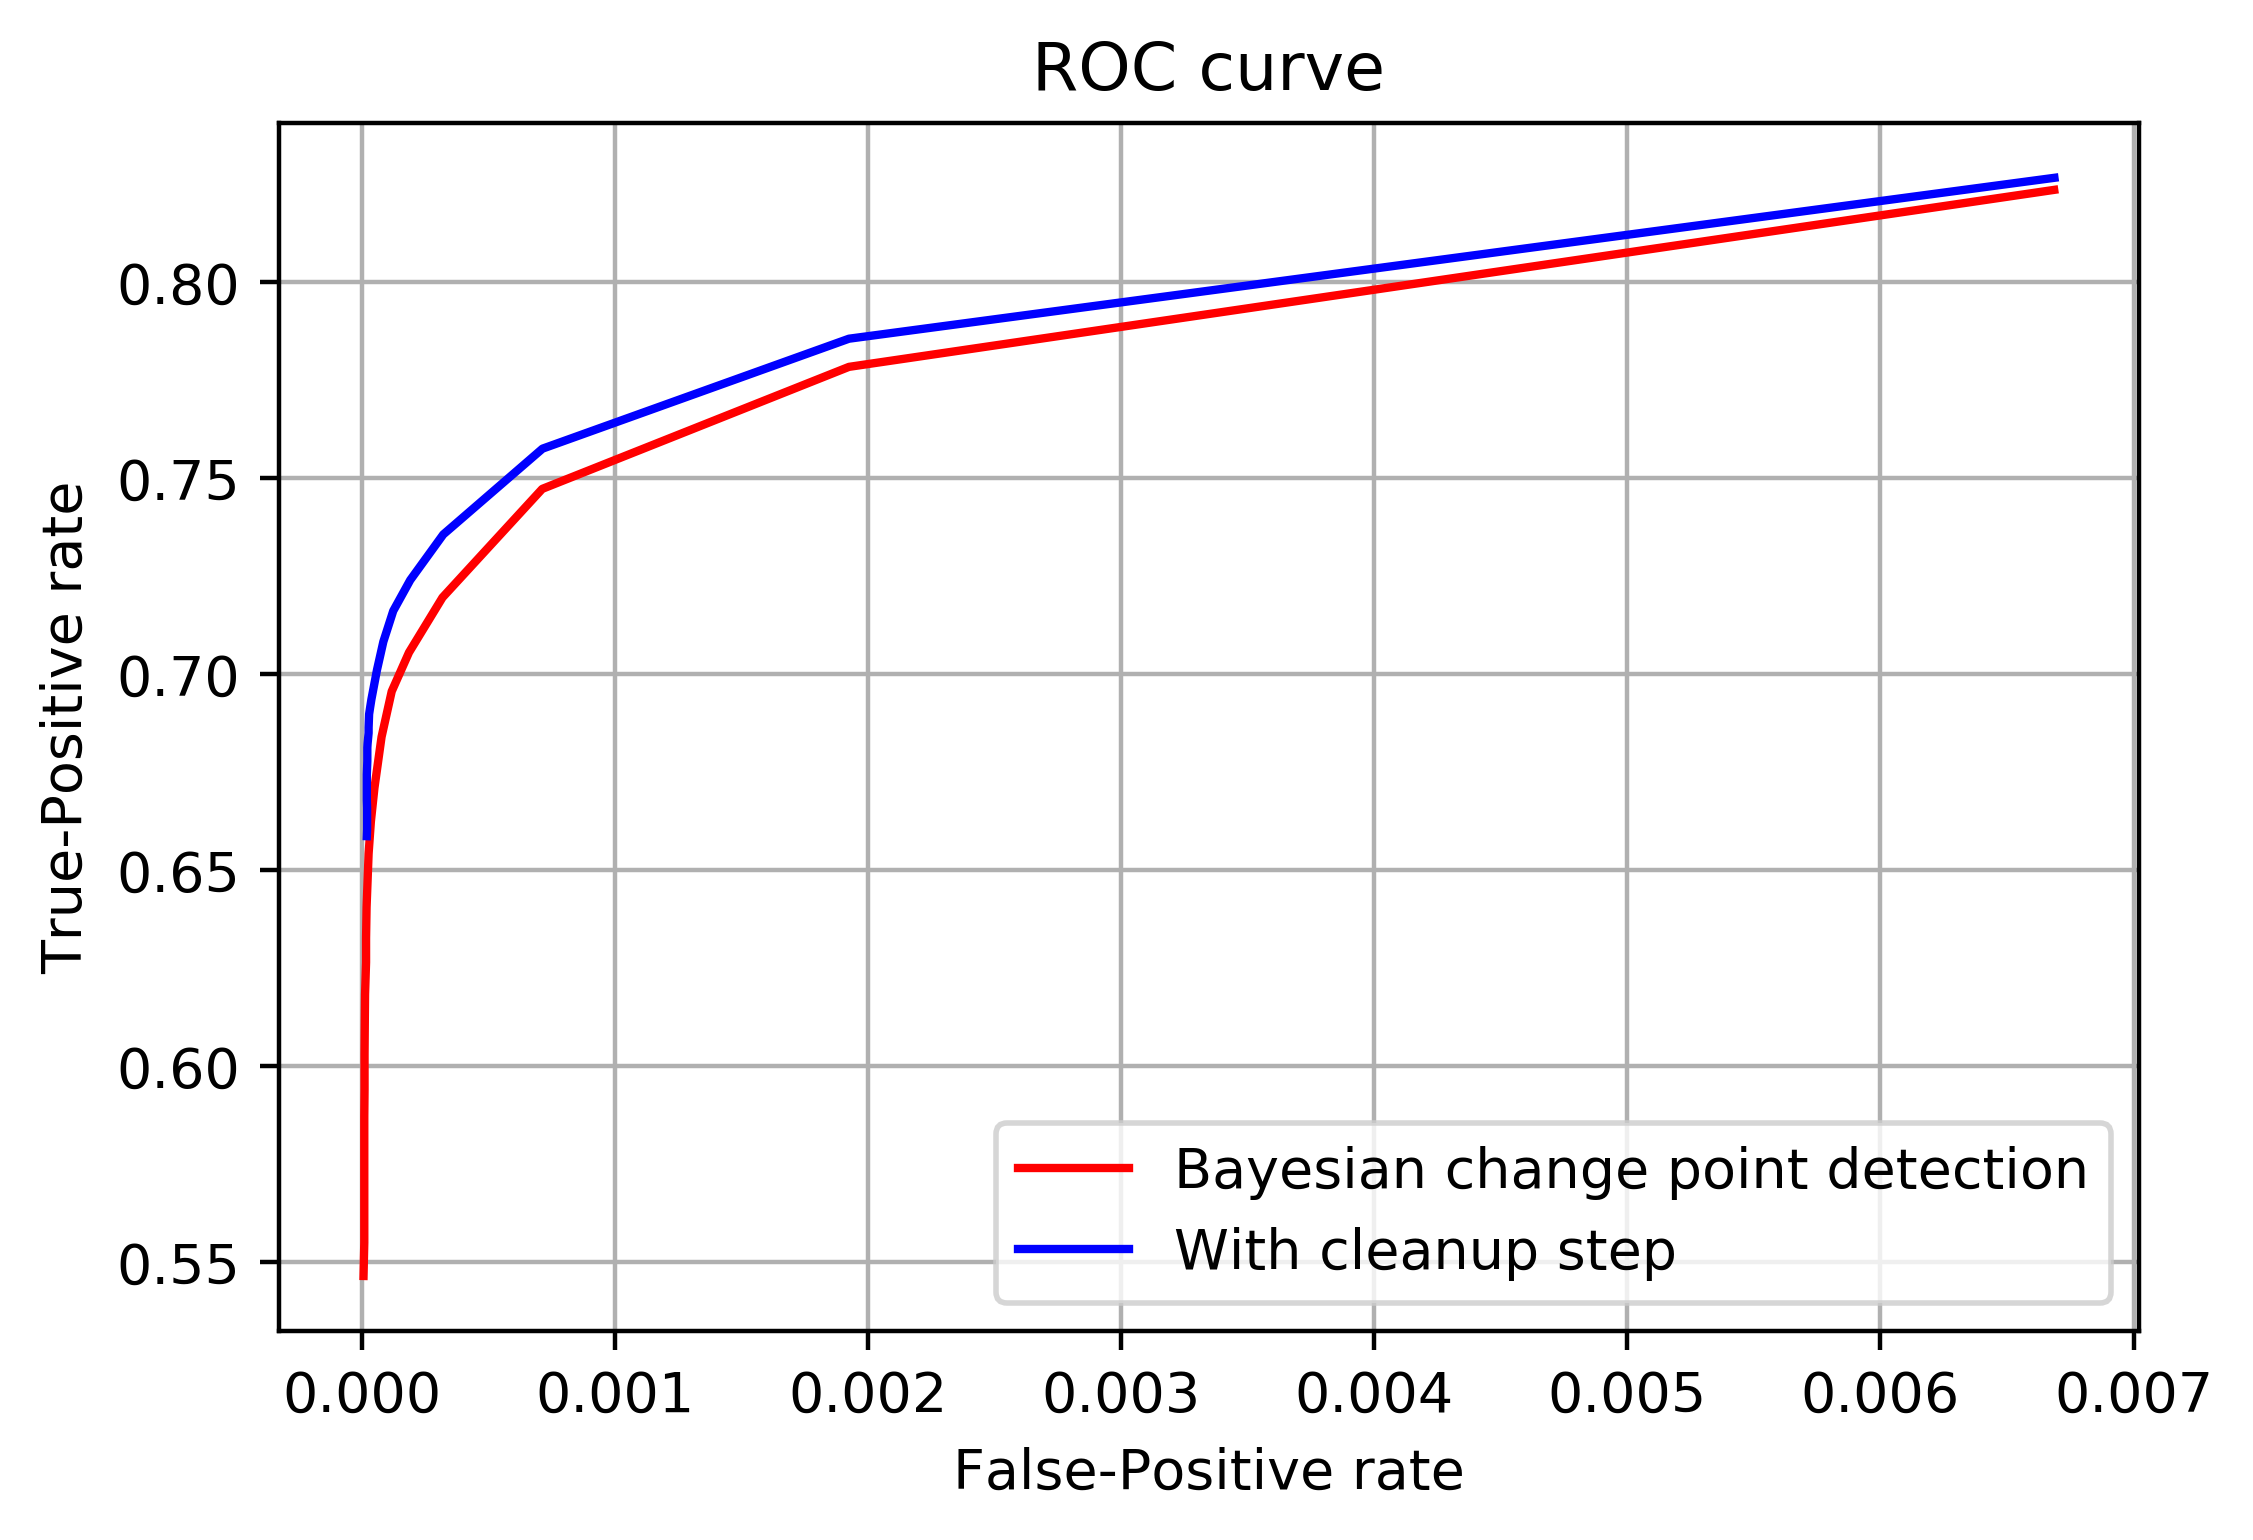

In [12]:
plt.figure(dpi=400)
plt.plot(FPRS, TPRS, label='Bayesian change point detection', color='red');
plt.plot(FPRS_refinement, TPRS_refinement, label='With cleanup step', color='blue');
plt.legend();
plt.xlabel('False-Positive rate');
plt.ylabel('True-Positive rate');
plt.title('ROC curve');
plt.grid()
plt.savefig('ROC_3.png')